In [1]:
import torch
import torchvision
import numpy as np
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os
%load_ext autoreload
%autoreload 2

In [2]:
def walk(file_name,start,size):
    float32_1d_array = np.memmap(
            file_name, shape=(), mode='r',
            offset=start,
            dtype='({})float32,'.format(size)
        )
    start = start+ size*4
    
    return start,float32_1d_array
    

In [3]:
def merge_batch_norm2d(bias,scales, mean, variance,weight):
    eps =1e-05
    conv_weight = torch.tensor(weight,dtype= torch.float32)
    conv_bias = torch.tensor(bias,dtype= torch.float32) # here for darknet it is bn2d_beta
    bn2d_gamma = torch.tensor(scales,dtype= torch.float32)
    
    bn2d_mean = torch.tensor(mean,dtype= torch.float32)
    bn2d_var = torch.tensor(variance,dtype= torch.float32)
    bn2d_var = torch.sqrt(torch.add(bn2d_var, eps))
    #bn2d_var = torch.add(bn2d_var, eps)

    conv_weight = conv_weight.transpose(0,3)
    #print(conv_weight.shape)
    #gamma = bn.weight
    #beta = bn.bias
    #mean = bn.running_mean
    #var = bn.running_var
    #eps =1e-05

    #var_sqrt = torch.sqrt(var + eps)

    #w = (self.weight * gamma.reshape(self.out_channels, 1, 1, 1)) / var_sqrt.reshape(self.out_channels, 1,1, 1)
    #b = ((self.bias - mean) * gamma) / var_sqrt + beta

    output_conv_weight = torch.mul(conv_weight, torch.div(bn2d_gamma, bn2d_var))
    #print(output_conv_weight.shape)
    output_conv_weight = output_conv_weight.transpose(0,3)
    conv_weight = conv_weight.transpose(0,3)
    output_conv_bias = torch.sub(conv_bias,torch.mul(bn2d_mean,torch.div(bn2d_gamma,bn2d_var)))
    return output_conv_weight, output_conv_bias#, #output_conv_weight, 



In [4]:
leaky = 1
l0_num_channels = 3
l1_num_channels = 16
l1_kernel_size = 3
l1_pad = 1
l1_stride=1
l1_bn = 1
l1_activation=leaky
l1_pool_size=2
l1_pool_stride=2

l2_num_channels = 32
l2_kernel_size = 3
l2_pad = 1
l2_stride=1
l2_bn = 1
l2_activation=leaky
l2_pool_size=2
l2_pool_stride=2

l3_num_channels = 64
l3_kernel_size = 3
l3_pad = 1
l3_stride=1
l3_bn = 1
l3_activation=leaky
l3_pool_size=2
l3_pool_stride=2

l4_num_channels = 128
l4_kernel_size = 3
l4_pad = 1
l4_stride=1
l4_bn = 1
l4_activation=leaky
l4_pool_size=2
l4_pool_stride=2


l5_num_channels = 256
l5_kernel_size = 3
l5_pad = 1
l5_stride=1
l5_bn = 1
l5_activation=leaky
l5_pool_size=2
l5_pool_stride=2


l6_num_channels = 512
l6_kernel_size = 3
l6_pad = 1
l6_stride=1
l6_bn = 1
l6_activation=leaky
l6_pool_size=2
l6_pool_stride=1

l7_num_channels = 1024
l7_kernel_size = 3
l7_pad = 1
l7_stride=1
l7_bn = 1
l7_activation=leaky

l8_num_channels = 512
l8_kernel_size = 3
l8_pad = 1
l8_stride=1
l8_bn = 1
l8_activation=leaky


l9_num_channels = 425
l9_kernel_size = 1
l9_pad = 1
l9_stride=1
l9_bn = 0
l9_activation=leaky

file = os.getcwd()+'/yolov2-tiny.weights'
start_loc=20 ## Found this value from debug prints added in parse net
filters = l1_num_channels
weight_size = l1_num_channels*l0_num_channels*l1_kernel_size*l1_kernel_size
start_loc,l1_biases = walk(file,start_loc,filters)
start_loc,l1_scales = walk(file,start_loc,filters) if l1_bn else (start_loc,None)
start_loc,l1_rolling_mean = walk(file,start_loc,filters) if l1_bn else (start_loc,None)
start_loc,l1_rolling_variance = walk(file,start_loc,filters) if l1_bn else (start_loc,None)
start_loc,l1_weights = walk(file,start_loc,weight_size)
#print('l1_mean ', l1_rolling_mean)
#print('l1_var ', l1_rolling_variance)

filters = l2_num_channels
weight_size = l2_num_channels*l1_num_channels*l2_kernel_size*l2_kernel_size
start_loc,l2_biases = walk(file,start_loc,filters)
start_loc,l2_scales = walk(file,start_loc,filters) if l2_bn else (start_loc,None)
start_loc,l2_rolling_mean = walk(file,start_loc,filters) if l2_bn else (start_loc,None)
start_loc,l2_rolling_variance = walk(file,start_loc,filters) if l2_bn else (start_loc,None)
start_loc,l2_weights = walk(file,start_loc,weight_size)
#print('l2_mean ', l2_rolling_mean)
#print('l2_var ', l2_rolling_variance)
filters = l3_num_channels
weight_size = l3_num_channels*l2_num_channels*l3_kernel_size*l3_kernel_size
start_loc,l3_biases = walk(file,start_loc,filters)
start_loc,l3_scales = walk(file,start_loc,filters) if l3_bn else (start_loc,None)
start_loc,l3_rolling_mean = walk(file,start_loc,filters) if l3_bn else (start_loc,None)
start_loc,l3_rolling_variance = walk(file,start_loc,filters) if l3_bn else (start_loc,None)
start_loc,l3_weights = walk(file,start_loc,weight_size)

filters = l4_num_channels
weight_size = l4_num_channels*l3_num_channels*l4_kernel_size*l4_kernel_size
start_loc,l4_biases = walk(file,start_loc,filters)
start_loc,l4_scales = walk(file,start_loc,filters) if l4_bn else (start_loc,None)
start_loc,l4_rolling_mean = walk(file,start_loc,filters) if l4_bn else (start_loc,None)
start_loc,l4_rolling_variance = walk(file,start_loc,filters) if l4_bn else (start_loc,None)
start_loc,l4_weights = walk(file,start_loc,weight_size)

filters = l5_num_channels
weight_size = l5_num_channels*l4_num_channels*l5_kernel_size*l5_kernel_size
start_loc,l5_biases = walk(file,start_loc,filters)
start_loc,l5_scales = walk(file,start_loc,filters) if l5_bn else (start_loc,None)
start_loc,l5_rolling_mean = walk(file,start_loc,filters) if l5_bn else (start_loc,None)
start_loc,l5_rolling_variance = walk(file,start_loc,filters) if l5_bn else (start_loc,None)
start_loc,l5_weights = walk(file,start_loc,weight_size)

filters = l6_num_channels
weight_size = l6_num_channels*l5_num_channels*l6_kernel_size*l6_kernel_size
start_loc,l6_biases = walk(file,start_loc,filters)
start_loc,l6_scales = walk(file,start_loc,filters) if l6_bn else (start_loc,None)
start_loc,l6_rolling_mean = walk(file,start_loc,filters) if l6_bn else (start_loc,None)
start_loc,l6_rolling_variance = walk(file,start_loc,filters) if l6_bn else (start_loc,None)
start_loc,l6_weights = walk(file,start_loc,weight_size)

filters = l7_num_channels
weight_size = l7_num_channels*l6_num_channels*l7_kernel_size*l7_kernel_size
start_loc,l7_biases = walk(file,start_loc,filters)
start_loc,l7_scales = walk(file,start_loc,filters) if l7_bn else (start_loc,None)
start_loc,l7_rolling_mean = walk(file,start_loc,filters) if l7_bn else (start_loc,None)
start_loc,l7_rolling_variance = walk(file,start_loc,filters) if l7_bn else (start_loc,None)
start_loc,l7_weights = walk(file,start_loc,weight_size)

filters = l8_num_channels
weight_size = l8_num_channels*l7_num_channels*l8_kernel_size*l8_kernel_size
start_loc,l8_biases = walk(file,start_loc,filters)
start_loc,l8_scales = walk(file,start_loc,filters) if l8_bn else (start_loc,None)
start_loc,l8_rolling_mean = walk(file,start_loc,filters) if l8_bn else (start_loc,None)
start_loc,l8_rolling_variance = walk(file,start_loc,filters) if l8_bn else (start_loc,None)
start_loc,l8_weights = walk(file,start_loc,weight_size)

filters = l9_num_channels
weight_size = l9_num_channels*l8_num_channels*l9_kernel_size*l9_kernel_size
start_loc,l9_biases = walk(file,start_loc,filters)
start_loc,l9_scales = walk(file,start_loc,filters) if l9_bn else (start_loc,None)
start_loc,l9_rolling_mean = walk(file,start_loc,filters) if l9_bn else (start_loc,None)
start_loc,l9_rolling_variance = walk(file,start_loc,filters) if l9_bn else (start_loc,None)
start_loc,l9_weights = walk(file,start_loc,weight_size)
#print(l9_biases, l9_scales,l9_rolling_mean,l9_rolling_variance,l9_weights)
#print('size of file ',os.path.getsize(file))
#print('start loc and weight size ',start_loc, weight_size )

In [5]:
## Reshape and merge batchnorm
#print('l1_weights before reshape ',l1_weights[0:27])
l1_weights_copy = l1_weights
l1_weights = l1_weights.reshape(l1_num_channels, l0_num_channels, l1_kernel_size, l1_kernel_size)
#print('l1_weights ', l1_weights)
l2_weights = l2_weights.reshape(l2_num_channels, l1_num_channels, l2_kernel_size, l2_kernel_size)
l3_weights = l3_weights.reshape(l3_num_channels, l2_num_channels, l3_kernel_size, l3_kernel_size)
l4_weights = l4_weights.reshape(l4_num_channels, l3_num_channels, l4_kernel_size, l4_kernel_size)
l5_weights = l5_weights.reshape(l5_num_channels, l4_num_channels, l5_kernel_size, l5_kernel_size)
l6_weights = l6_weights.reshape(l6_num_channels, l5_num_channels, l6_kernel_size, l6_kernel_size)
l7_weights = l7_weights.reshape(l7_num_channels, l6_num_channels, l7_kernel_size, l7_kernel_size)
l8_weights = l8_weights.reshape(l8_num_channels, l7_num_channels, l8_kernel_size, l8_kernel_size)
l9_weights = l9_weights.reshape(l9_num_channels, l8_num_channels, l9_kernel_size, l9_kernel_size)
l1_weight,l1_bias = merge_batch_norm2d(l1_biases,l1_scales, l1_rolling_mean, l1_rolling_variance,l1_weights)
l2_weight,l2_bias = merge_batch_norm2d(l2_biases,l2_scales, l2_rolling_mean, l2_rolling_variance,l2_weights)
l3_weight,l3_bias = merge_batch_norm2d(l3_biases,l3_scales, l3_rolling_mean, l3_rolling_variance,l3_weights)
l4_weight,l4_bias = merge_batch_norm2d(l4_biases,l4_scales, l4_rolling_mean, l4_rolling_variance,l4_weights)
l5_weight,l5_bias = merge_batch_norm2d(l5_biases,l5_scales, l5_rolling_mean, l5_rolling_variance,l5_weights)
l6_weight,l6_bias = merge_batch_norm2d(l6_biases,l6_scales, l6_rolling_mean, l6_rolling_variance,l6_weights)
l7_weight,l7_bias = merge_batch_norm2d(l7_biases,l7_scales, l7_rolling_mean, l7_rolling_variance,l7_weights)
l8_weight,l8_bias = merge_batch_norm2d(l8_biases,l8_scales, l8_rolling_mean, l8_rolling_variance,l8_weights)
l9_weight = torch.tensor(l9_weights)
l9_bias = torch.tensor(l9_biases)
#.transpose([2, 3, 1, 0])

print(l9_weight.shape)

In [6]:
####refer to: https://github.com/ayooshkathuria/pytorch-yolo-v3/blob/master/darknet.py
class MaxPoolStride1(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPoolStride1, self).__init__()
        self.kernel_size = kernel_size
        self.pad = kernel_size - 1
    
    def forward(self, x):
        padded_x = F.pad(x, (0,self.pad,0,self.pad), mode="replicate")
        pooled_x = nn.MaxPool2d(self.kernel_size, self.pad)(padded_x)
        return pooled_x

In [8]:
spikenet_1 = nn.Conv2d(l1_weight.shape[0],l1_weight.shape[1],kernel_size=l1_weight.shape[2],padding=l1_pad)
spikenet_2 = nn.Conv2d(l2_weight.shape[0],l2_weight.shape[1],kernel_size=l2_weight.shape[2],padding=l2_pad)
spikenet_3 = nn.Conv2d(l3_weight.shape[0],l3_weight.shape[1],kernel_size=l3_weight.shape[2],padding=l3_pad)
spikenet_4 = nn.Conv2d(l4_weight.shape[0],l4_weight.shape[1],kernel_size=l4_weight.shape[2],padding=l4_pad)
spikenet_5 = nn.Conv2d(l5_weight.shape[0],l5_weight.shape[1],kernel_size=l5_weight.shape[2],padding=l5_pad)
spikenet_6 = nn.Conv2d(l6_weight.shape[0],l6_weight.shape[1],kernel_size=l6_weight.shape[2],padding=l6_pad)
spikenet_7 = nn.Conv2d(l7_weight.shape[0],l7_weight.shape[1],kernel_size=l7_weight.shape[2],padding=l7_pad)
spikenet_8 = nn.Conv2d(l8_weight.shape[0],l8_weight.shape[1],kernel_size=l8_weight.shape[2],padding=l8_pad)
spikenet_9 = nn.Conv2d(l9_weight.shape[0],l9_weight.shape[1],kernel_size=l9_weight.shape[2],padding=0)
maxpool_1 = nn.MaxPool2d(l1_pool_size,stride=l1_pool_stride)
maxpool_2 = nn.MaxPool2d(l2_pool_size,stride=l2_pool_stride)
maxpool_3 = nn.MaxPool2d(l3_pool_size,stride=l3_pool_stride)
maxpool_4 = nn.MaxPool2d(l4_pool_size,stride=l4_pool_stride)
maxpool_5 = nn.MaxPool2d(l5_pool_size,stride=l5_pool_stride)
## Single stride is different: refer to: https://github.com/ayooshkathuria/pytorch-yolo-v3/blob/master/darknet.py

maxpool_6 = MaxPoolStride1(l6_pool_size)

In [9]:
spikenet_1.weight = nn.Parameter(l1_weight)
spikenet_1.bias = nn.Parameter(l1_bias)
spikenet_2.weight = nn.Parameter(l2_weight)
spikenet_2.bias = nn.Parameter(l2_bias)
spikenet_3.weight = nn.Parameter(l3_weight)
spikenet_3.bias = nn.Parameter(l3_bias)
spikenet_4.weight = nn.Parameter(l4_weight)
spikenet_4.bias = nn.Parameter(l4_bias)
spikenet_5.weight = nn.Parameter(l5_weight)
spikenet_5.bias = nn.Parameter(l5_bias)
spikenet_6.weight = nn.Parameter(l6_weight)
spikenet_6.bias = nn.Parameter(l6_bias)
spikenet_7.weight = nn.Parameter(l7_weight)
spikenet_7.bias = nn.Parameter(l7_bias)
spikenet_8.weight = nn.Parameter(l8_weight)
spikenet_8.bias = nn.Parameter(l8_bias)
spikenet_9.weight = nn.Parameter(l9_weight)
spikenet_9.bias = nn.Parameter(l9_bias)

In [10]:
tiny_yolo = nn.Sequential(
spikenet_1,
nn.LeakyReLU(0.1),
maxpool_1,
spikenet_2,
nn.LeakyReLU(0.1),
maxpool_2,
spikenet_3,
nn.LeakyReLU(0.1),
maxpool_3,
spikenet_4,
nn.LeakyReLU(0.1),
maxpool_4,
spikenet_5,
nn.LeakyReLU(0.1),
maxpool_5,
spikenet_6,
nn.LeakyReLU(0.1),
maxpool_6,
spikenet_7,
nn.LeakyReLU(0.1),
spikenet_8,
nn.LeakyReLU(0.1),
spikenet_9,
#nn.ReLU(),
)

#img_path = os.getcwd()+'/darknet/data/dog.jpg'
img_path = os.getcwd()+'/coco/val2017/000000000785.jpg'
orig_image = cv2.imread(img_path)
plt.imshow(orig_image)
resized_img = cv2.resize(orig_image,(416,416),interpolation=cv2.INTER_CUBIC)
resized_image = np.array(resized_img, dtype='f')
#resized_image = np.array(boxed_img, dtype='f')

resized_image /= 255.
r,g,b = cv2.split(resized_image)
resized_image = cv2.merge([b,g,r])
resized_image = resized_image.transpose([2,0,1])
plt.imshow(resized_image[2,:,:])


image_from_c = os.getcwd()+'/../darknet/resized_image.txt'
file = open(image_from_c,'r')
image_array = np.zeros((416,416,3),dtype= np.float32)
count =0

for line in file:
    #print(line)
    j = count%416
    k = count//173056
    i = (count-k*173056)//(416)
    image_array[i,j,k] = float(line)
    #image_array[count] = float(line)

    count+=1
    #count +=1
    #count += float(line)
    #if count >= 20:
    #    break
print(count)
#print(image_array[:-20])
#image_array = image_array.reshape(416,416,3)
plt.imshow(image_array)

#input_tensor = torch.tensor(np_array[np.newaxis,:,:,:], dtype=torch.float32)
input_tensor = torch.tensor(resized_image[np.newaxis,:,:,:], dtype=torch.float32).cuda()
#image_array_trans = image_array.transpose([2,0,1])
#input_tensor = torch.tensor(image_array_trans[np.newaxis,:,:,:], dtype=torch.float32).cuda()

yolo_out = tiny_yolo(input_tensor).detach()

print(yolo_out.shape)
#print(tiny_yolo)
print(torch.max(yolo_out))

x = input_tensor
for idx,seq in enumerate(tiny_yolo):
    x = seq(x)
    print(idx, x[0,0,0,0:5])
    #if idx == 11 or idx == 12:
    #    print(idx, x.shape)

In [11]:
### Yolo post processing
def sigmoid(x):
    return 1. / (1. + np.exp(-x))



def softmax(x):
    e_x = np.exp(x - np.max(x))
    out = e_x / e_x.sum()
    return out



def iou(boxA,boxB):
    # boxA = boxB = [x1,y1,x2,y2]
    #print('boxA ', boxA)
    #print('boxB ', boxB)
    #x_in_range = False
    #y_in_range = False
    #x_min = min(boxA[0],boxA[2])
    #x_max = max(boxA[0],boxA[2])
    #y_min = min(boxA[1],boxA[3])
    #y_max = max(boxA[1],boxA[3])
    #if x_min <= boxB[0] and x_max>= boxB[0]:
    #    x_in_range = True
    #if x_min <= boxB[2] and x_max>= boxB[2]:
    #    x_in_range = True
    #if y_min <= boxB[1] and y_max>= boxB[1]:
    #    y_in_range = True
    #if y_min <= boxB[2] and y_max>= boxB[3]:
    #    y_in_range = True
    
    #if y_in_range == False and x_in_range == False:
    #    return 0
    
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # Compute the area of intersection
    intersection_area = max(0,(xB - xA + 1)) * max(0,(yB - yA + 1))
    #print('intersection_area ', intersection_area)
 
    # Compute the area of both rectangles
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    #print('boxA_area', boxA_area)
    #print('boxB_area', boxB_area)

 
    # Compute the IOU
    iou = intersection_area / float(boxA_area + boxB_area - intersection_area)

    return iou


In [12]:
def non_maximal_suppression(thresholded_predictions,iou_threshold):

    nms_predictions = []

    # Add the best B-Box because it will never be deleted
    nms_predictions.append(thresholded_predictions[0])

    # For each B-Box (starting from the 2nd) check its iou with the higher score B-Boxes
    # thresholded_predictions[i][0] = [x1,y1,x2,y2]
    i = 1
    while i < len(thresholded_predictions):
        n_boxes_to_check = len(nms_predictions)
        #print('N boxes to check = {}'.format(n_boxes_to_check))
        to_delete = False

        j = 0
        while j < n_boxes_to_check:
            curr_iou = iou(thresholded_predictions[i][0],nms_predictions[j][0])
            if(curr_iou > iou_threshold ):
                to_delete = True
            #print('Checking box {} vs {}: IOU = {} , To delete = {}'.format(thresholded_predictions[i][0],nms_predictions[j][0],curr_iou,to_delete))
            j = j+1

        if to_delete == False:
            nms_predictions.append(thresholded_predictions[i])
        i = i+1

    return nms_predictions

In [13]:
def postprocessing(predictions,input_image,score_threshold,iou_threshold,input_height,input_width,print_en = True):

    #input_image = cv2.imread(input_img_path)
    #input_image = cv2.resize(input_image,(input_height, input_width), interpolation = cv2.INTER_CUBIC)

    n_classes = 80
    n_grid_cells = 13
    n_b_boxes = 5
    n_b_box_coord = 4

    # Names and colors for each class
    #classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
    classes = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
    colors = [(254.0, 254.0, 254), (239.88888888888889, 211.66666666666669, 127),
              (225.77777777777777, 169.33333333333334, 0), (211.66666666666669, 127.0, 254),
              (197.55555555555557, 84.66666666666667, 127), (183.44444444444443, 42.33333333333332, 0),
              (169.33333333333334, 0.0, 254), (155.22222222222223, -42.33333333333335, 127),
              (141.11111111111111, -84.66666666666664, 0), (127.0, 254.0, 254), 
              (112.88888888888889, 211.66666666666669, 127), (98.77777777777777, 169.33333333333334, 0),
              (84.66666666666667, 127.0, 254), (70.55555555555556, 84.66666666666667, 127),
              (56.44444444444444, 42.33333333333332, 0), (42.33333333333332, 0.0, 254), 
              (28.222222222222236, -42.33333333333335, 127), (14.111111111111118, -84.66666666666664, 0),
              (0.0, 254.0, 254), (-14.111111111111118, 211.66666666666669, 127),
              (254.0, 254.0, 254), (239.88888888888889, 211.66666666666669, 127),
              (225.77777777777777, 169.33333333333334, 0), (211.66666666666669, 127.0, 254),
              (197.55555555555557, 84.66666666666667, 127), (183.44444444444443, 42.33333333333332, 0),
              (169.33333333333334, 0.0, 254), (155.22222222222223, -42.33333333333335, 127),
              (141.11111111111111, -84.66666666666664, 0), (127.0, 254.0, 254), 
              (112.88888888888889, 211.66666666666669, 127), (98.77777777777777, 169.33333333333334, 0),
              (84.66666666666667, 127.0, 254), (70.55555555555556, 84.66666666666667, 127),
              (56.44444444444444, 42.33333333333332, 0), (42.33333333333332, 0.0, 254), 
              (28.222222222222236, -42.33333333333335, 127), (14.111111111111118, -84.66666666666664, 0),
              (0.0, 254.0, 254), (-14.111111111111118, 211.66666666666669, 127),
              (254.0, 254.0, 254), (239.88888888888889, 211.66666666666669, 127),
              (225.77777777777777, 169.33333333333334, 0), (211.66666666666669, 127.0, 254),
              (197.55555555555557, 84.66666666666667, 127), (183.44444444444443, 42.33333333333332, 0),
              (169.33333333333334, 0.0, 254), (155.22222222222223, -42.33333333333335, 127),
              (141.11111111111111, -84.66666666666664, 0), (127.0, 254.0, 254), 
              (112.88888888888889, 211.66666666666669, 127), (98.77777777777777, 169.33333333333334, 0),
              (84.66666666666667, 127.0, 254), (70.55555555555556, 84.66666666666667, 127),
              (56.44444444444444, 42.33333333333332, 0), (42.33333333333332, 0.0, 254), 
              (28.222222222222236, -42.33333333333335, 127), (14.111111111111118, -84.66666666666664, 0),
              (0.0, 254.0, 254), (-14.111111111111118, 211.66666666666669, 127),
              (254.0, 254.0, 254), (239.88888888888889, 211.66666666666669, 127),
              (225.77777777777777, 169.33333333333334, 0), (211.66666666666669, 127.0, 254),
              (197.55555555555557, 84.66666666666667, 127), (183.44444444444443, 42.33333333333332, 0),
              (169.33333333333334, 0.0, 254), (155.22222222222223, -42.33333333333335, 127),
              (141.11111111111111, -84.66666666666664, 0), (127.0, 254.0, 254), 
              (112.88888888888889, 211.66666666666669, 127), (98.77777777777777, 169.33333333333334, 0),
              (84.66666666666667, 127.0, 254), (70.55555555555556, 84.66666666666667, 127),
              (56.44444444444444, 42.33333333333332, 0), (42.33333333333332, 0.0, 254), 
              (28.222222222222236, -42.33333333333335, 127), (14.111111111111118, -84.66666666666664, 0),
              (0.0, 254.0, 254), (-14.111111111111118, 211.66666666666669, 127)
             ]
    # Pre-computed YOLOv2 shapes of the k=5 B-Boxes
    anchors = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]#1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52]

    thresholded_predictions = []
    if print_en:
        print('Thresholding on (Objectness score)*(Best class score) with threshold = {}'.format(score_threshold))

    # IMPORTANT: reshape to have shape = [ 13 x 13 x (5 B-Boxes) x (4 Coords + 1 Obj score + 20 Class scores ) ]
    # From now on the predictions are ORDERED and can be extracted in a simple way!
    # We have 13x13 grid cells, each cell has 5 B-Boxes, each B-Box have 25 channels with 4 coords, 1 Obj score , 20 Class scores
    # E.g. predictions[row, col, b, :4] will return the 4 coords of the "b" B-Box which is in the [row,col] grid cell
    predictions = np.reshape(predictions,(13,13,5,(n_classes+5)))

    # IMPORTANT: Compute the coordinates and score of the B-Boxes by considering the parametrization of YOLOv2
    for row in range(n_grid_cells):
        for col in range(n_grid_cells):
            for b in range(n_b_boxes):

                tx, ty, tw, th, tc = predictions[row, col, b, :5]
                #print(tx,ty,tw,th,tc)

                # IMPORTANT: (416 img size) / (13 grid cells) = 32!
                # YOLOv2 predicts parametrized coordinates that must be converted to full size
                # final_coordinates = parametrized_coordinates * 32.0 ( You can see other EQUIVALENT ways to do this...)
                center_x = (float(col) + sigmoid(tx)) * 32.0
                center_y = (float(row) + sigmoid(ty)) * 32.0

                roi_w = np.exp(tw) * anchors[2*b + 0] * 32.0
                roi_h = np.exp(th) * anchors[2*b + 1] * 32.0
                #center_x =0
                #center_y =0
                #roi_w =0
                #roi_h =0
                final_confidence = sigmoid(tc)

                # Find best class
                class_predictions = predictions[row, col, b, 5:]
                class_predictions = softmax(class_predictions)

                class_predictions = tuple(class_predictions)
                best_class = class_predictions.index(max(class_predictions))
                best_class_score = class_predictions[best_class]

                # Compute the final coordinates on both axes
                left   = int(center_x - (roi_w/2.))
                right  = int(center_x + (roi_w/2.))
                top    = int(center_y - (roi_h/2.))
                bottom = int(center_y + (roi_h/2.))
        
                if( (final_confidence * best_class_score) > score_threshold):
                  thresholded_predictions.append([[left,top,right,bottom],final_confidence * best_class_score,classes[best_class]])

    # Sort the B-boxes by their final score
    thresholded_predictions.sort(key=lambda tup: tup[1],reverse=True)

    if print_en:
        print('Printing {} B-boxes survived after score thresholding:'.format(len(thresholded_predictions)))
    for i in range(len(thresholded_predictions)):
        if print_en:
            print('B-Box {} : {}'.format(i+1,thresholded_predictions[i]))

    # Non maximal suppression
    if print_en:
        print('Non maximal suppression with iou threshold = {}'.format(iou_threshold))
    if len(thresholded_predictions) >0:
        nms_predictions = non_maximal_suppression(thresholded_predictions,iou_threshold)
        if print_en:
            print('nms_predictions len ',len(nms_predictions))

        # Print survived b-boxes
        if print_en:
            print('Printing the {} B-Boxes survived after non maximal suppression:'.format(len(nms_predictions)))
        for i in range(len(nms_predictions)):
            if print_en:
                print('B-Box {} : {}'.format(i+1,nms_predictions[i]))

        # Draw final B-Boxes and label on input image
        for i in range(len(nms_predictions)):
            if print_en:
                print('color of bbox ',classes.index(nms_predictions[i][2]))
            color = colors[classes.index(nms_predictions[i][2])]
            best_class_name = nms_predictions[i][2]
        
            # Put a class rectangle with B-Box coordinates and a class label on the image
        
            input_image = cv2.rectangle(input_image,(nms_predictions[i][0][0],nms_predictions[i][0][1]),(nms_predictions[i][0][2],nms_predictions[i][0][3]),color,1)
            cv2.putText(input_image,best_class_name,(int((nms_predictions[i][0][0]+nms_predictions[i][0][2])/2),int((nms_predictions[i][0][1]+nms_predictions[i][0][3])/2)),cv2.FONT_HERSHEY_SIMPLEX,1,color,1)
  
    return input_image


input_height = 416
input_width = 416
score_threshold = 0.4
iou_threshold = 0.3
prediction = yolo_out.detach().cpu().numpy()
#prediction = yolo_out_new.detach().cpu().numpy()
print(prediction.shape)
prediction_reshape = prediction[0,:,:,:]
prediction_reshape = prediction_reshape.transpose([1,2,0])
print(prediction_reshape.shape)
output_image = postprocessing(prediction_reshape,img_path,score_threshold,iou_threshold,input_height,input_width)
#output_image = postprocessing(prediction_reshape,os.getcwd()+'/../darknet/resized.jpg',score_threshold,iou_threshold,input_height,input_width)

r,g,b = cv2.split(output_image)
output_image_remap = cv2.merge([b,g,r])
plt.imshow(output_image_remap)

In [14]:
def yolo_flow(img_path, network_inp_size=(416,416), display= True, save_image=False,print_en=True):
    input_img = cv2.imread(img_path)
    r,g,b = cv2.split(input_img)
    input_img = cv2.merge([b,g,r]) 
    h,w,_ = input_img.shape
    print(h,w)
    input_image = np.zeros((*network_inp_size,3),dtype=np.float32)+0.5
    if w>h:
        new_w = network_inp_size[1]
        new_h = h*network_inp_size[0]//w
        temp_image = cv2.resize(input_img,(new_w,new_h),interpolation=cv2.INTER_CUBIC)
        h_diff = network_inp_size[0] - new_h
        input_image[h_diff//2:h_diff//2+new_h,:,:] = temp_image/255
    else:
        new_h = network_inp_size[0]
        new_w = w*network_inp_size[1]//h
        temp_image = cv2.resize(input_img,(new_w,new_h),interpolation=cv2.INTER_CUBIC)
        w_diff = network_inp_size[1] - new_w
        input_image[:,w_diff//2:w_diff//2+new_w,:] = temp_image/255
    image2tensor_tmp = input_image.transpose([2,0,1]) 
    input_tensor = torch.tensor(image2tensor_tmp[np.newaxis,:,:,:])
    yolo_out = tiny_yolo(input_tensor)
    #print(yolo_out)
    prediction = yolo_out.detach().cpu().numpy()
    prediction_reshape = prediction[0,:,:,:]
    prediction_reshape = prediction_reshape.transpose([1,2,0])
    if display == True:
        plt.figure(figsize=(64,64))
        plt.subplot(1,2,1)
        plt.imshow(input_image)
    
    output_prediction = postprocessing(prediction_reshape,input_image,score_threshold,iou_threshold,input_height,input_width,print_en)

    if display == True:
        plt.subplot(1,2,2)
        plt.imshow(output_prediction)
    if save_image == True:
        write_path = os.getcwd()+ '/coco/outputs/'+img_path[-16:-4]+'_ann.jpg'
        r,g,b = cv2.split(output_prediction)
        output_prediction = cv2.merge([b,g,r])
        cv2.imwrite(write_path, output_prediction*255)
        
    
    
    

480 640


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 6 B-boxes survived after score thresholding:
B-Box 1 : [[-1, 150, 126, 279], 0.7456693543595045, 'bowl']
B-Box 2 : [[104, 54, 172, 99], 0.6355843841074773, 'bowl']
B-Box 3 : [[-9, 145, 142, 327], 0.6202484039391052, 'bowl']
B-Box 4 : [[0, 160, 123, 305], 0.5664143069354219, 'bowl']
B-Box 5 : [[-6, 145, 137, 287], 0.44416340665438264, 'bowl']
B-Box 6 : [[319, 133, 424, 355], 0.40236068800697217, 'sandwich']
Non maximal suppression with iou threshold = 0.4
nms_predictions len  3
Printing the 3 B-Boxes survived after non maximal suppression:
B-Box 1 : [[-1, 150, 126, 279], 0.7456693543595045, 'bowl']
B-Box 2 : [[104, 54, 172, 99], 0.6355843841074773, 'bowl']
B-Box 3 : [[319, 133, 424, 355], 0.40236068800697217, 'sandwich']
color of bbox  45
color of bbox  45
color of bbox  48


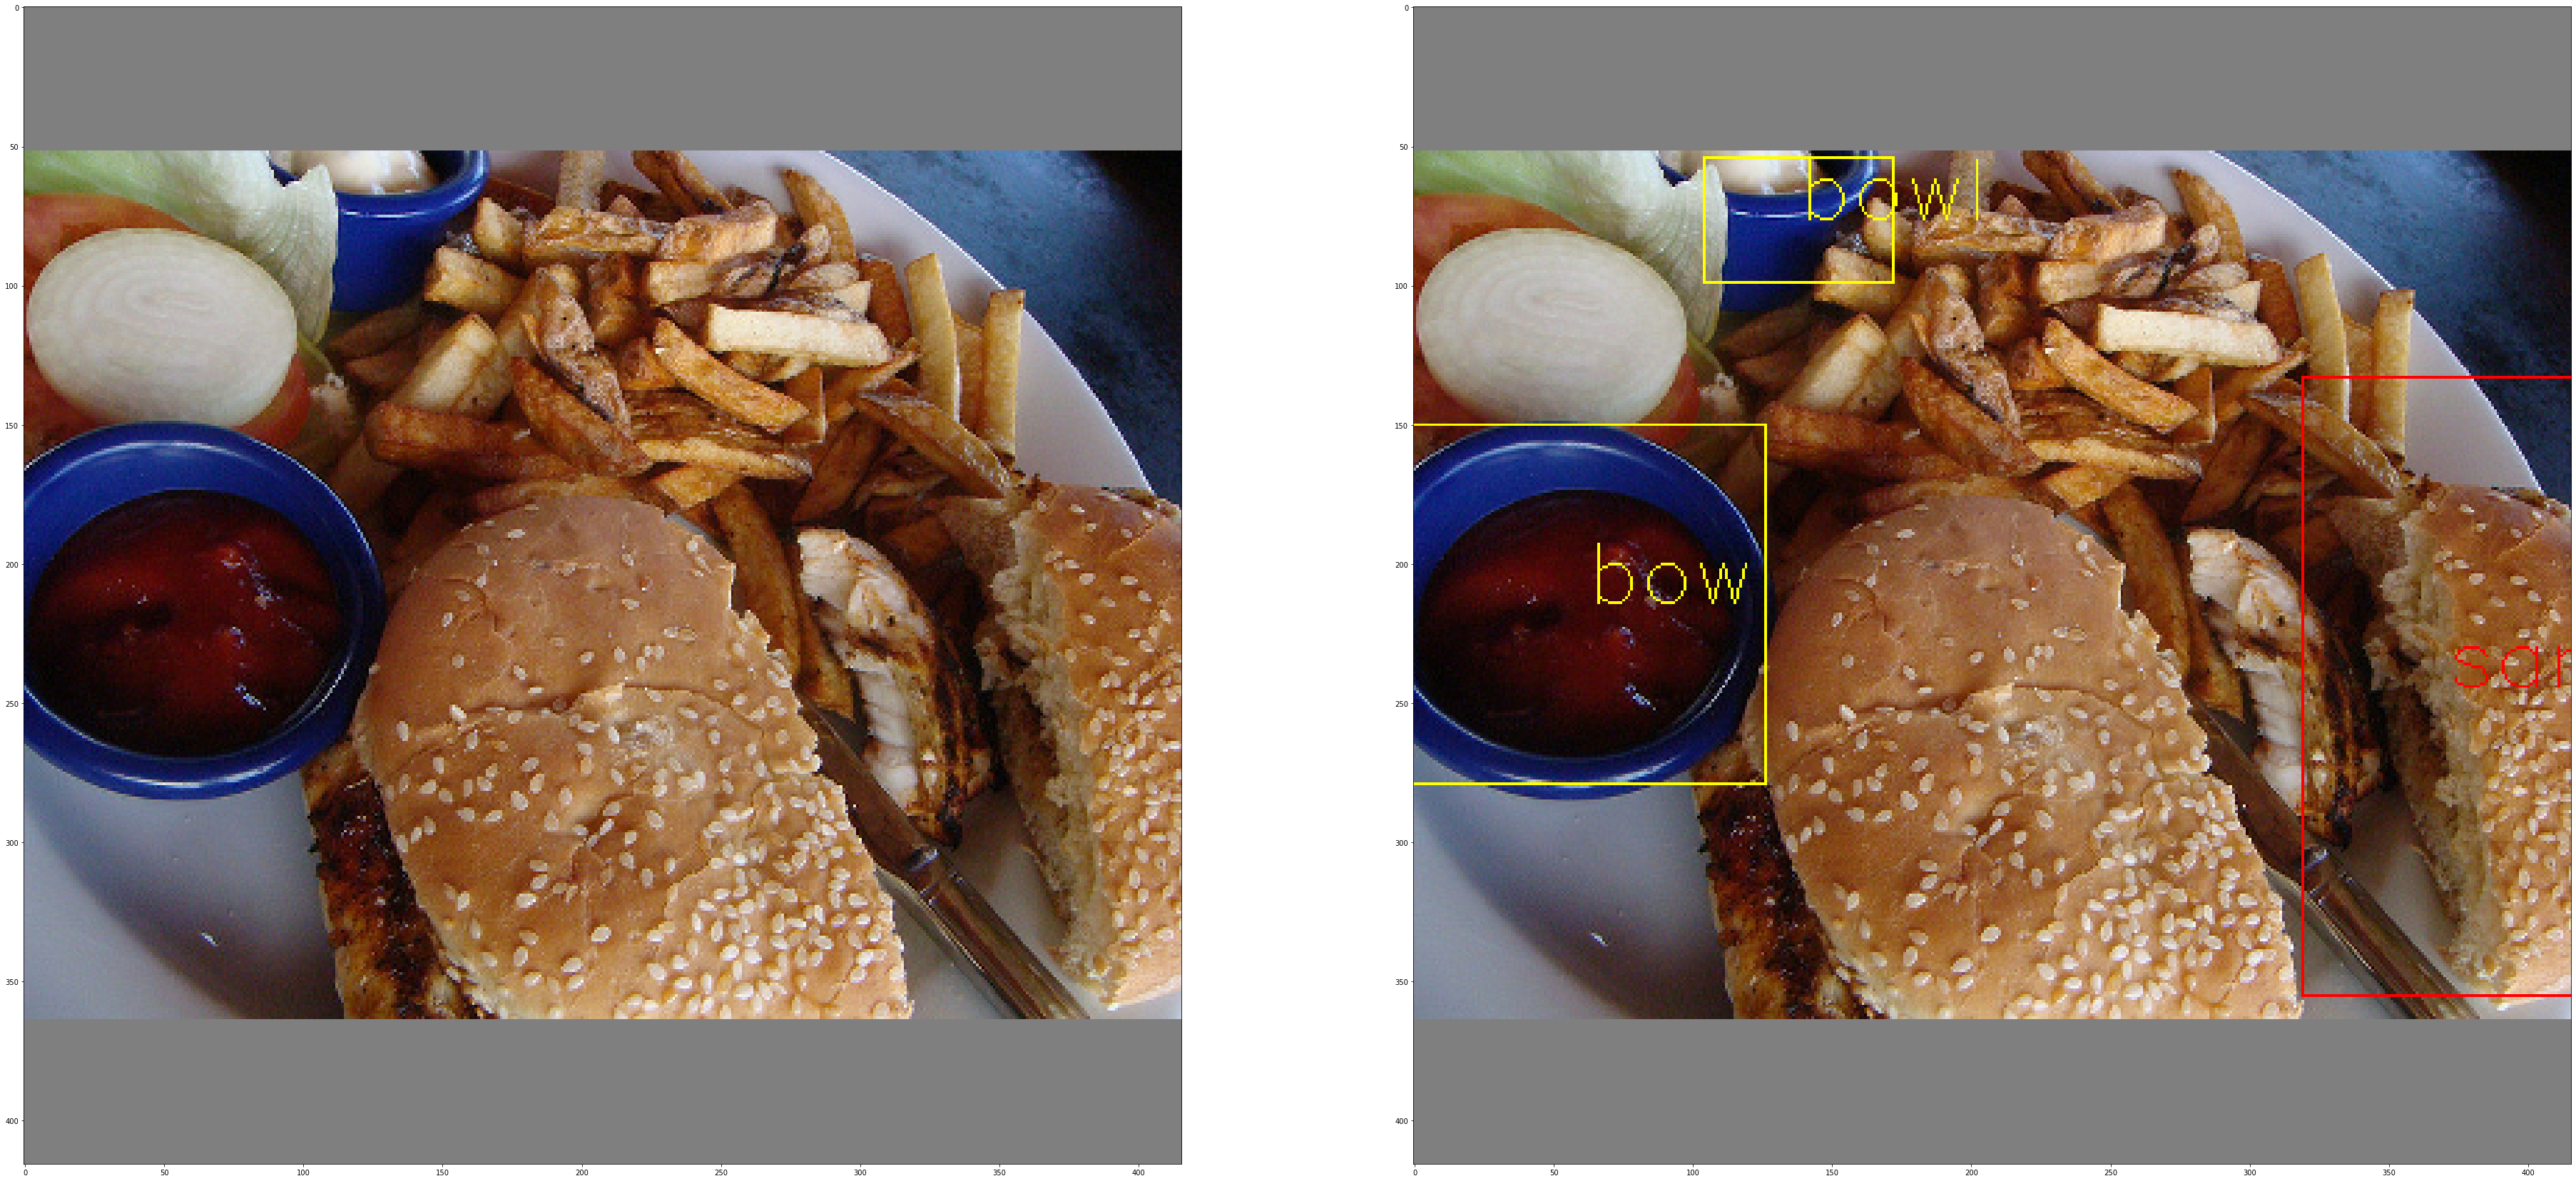

In [18]:
input_height = 416
input_width = 416
score_threshold = 0.4
iou_threshold = 0.4
img_path = os.getcwd()+'/coco/val2017/000000009914.jpg'
yolo_flow(img_path,display=True,save_image =True,print_en=True)

In [19]:
val_img_dir = os.getcwd()+'/coco/val2017/'
val_image_list = os.listdir(val_img_dir)
val_image_list =  sorted(val_image_list)
print(val_image_list[100])

000000009914.jpg


In [ ]:
count =0 
for img in val_image_list:
    img_path = val_img_dir+img
    print(count)
    count+=1
    print(img_path)
    yolo_flow(img_path,display=False,save_image = True, print_en = False)    
    

In [46]:
print(img_path)

/home/isdgenomics/users/rsumiran/Spiking_MNIST/spiking_yolo/coco/val2017/000000163057.jpg


In [84]:
print(tiny_yolo)

Sequential(
  (0): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.1)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): LeakyReLU(negative_slope=0.1)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): LeakyReLU(negative_slope=0.1)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): LeakyReLU(negative_slope=0.1)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): LeakyReLU(negative_slope=0.1)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(512, 2

In [85]:
print(len(val_image_list))

5000


# Creating Dataset from images

In [20]:
dataset_size = len(val_image_list)
network_inp_size=(416,416)
dataset = np.zeros((dataset_size,3,*network_inp_size),dtype= np.float32)
count =0
for img in val_image_list:
    img_path = val_img_dir+img
    input_img = cv2.imread(img_path)
    r,g,b = cv2.split(input_img)
    input_img = cv2.merge([b,g,r]) 
    h,w,_ = input_img.shape
    #print(h,w)
    input_image = np.zeros((*network_inp_size,3),dtype=np.float32)+0.5
    if w>h:
        new_w = network_inp_size[1]
        new_h = h*network_inp_size[0]//w
        temp_image = cv2.resize(input_img,(new_w,new_h),interpolation=cv2.INTER_CUBIC)
        h_diff = network_inp_size[0] - new_h
        input_image[h_diff//2:h_diff//2+new_h,:,:] = temp_image/255
    else:
        new_h = network_inp_size[0]
        new_w = w*network_inp_size[1]//h
        temp_image = cv2.resize(input_img,(new_w,new_h),interpolation=cv2.INTER_CUBIC)
        w_diff = network_inp_size[1] - new_w
        input_image[:,w_diff//2:w_diff//2+new_w,:] = temp_image/255
    image2tensor_tmp = input_image.transpose([2,0,1])
    dataset[count,:,:,:] = image2tensor_tmp
    count+=1
    

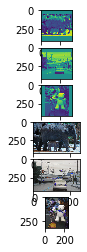

In [21]:
plt.subplot(6,1,1)
plt.imshow(dataset[500,0,:,:])
plt.subplot(6,1,2)
plt.imshow(dataset[501,0,:,:])
plt.subplot(6,1,3)
plt.imshow(dataset[502,0,:,:])
im1 = cv2.imread(val_img_dir+val_image_list[500])
plt.subplot(6,1,4)
plt.imshow(im1)
im2 = cv2.imread(val_img_dir+val_image_list[501])
plt.subplot(6,1,5)
plt.imshow(im2)
im3 = cv2.imread(val_img_dir+val_image_list[502])
plt.subplot(6,1,6)
plt.imshow(im3)

In [22]:
def percentile_channel_wise(batch_input, layers_list, network, percentile=99.9):
    shape_list = []
    flattened_list = []
    percentile_list = []
    shape = batch_input.shape[1]
    shape_list.append(shape)
    for i in range(shape):
        flattened_list.append(batch_input[:,i,:,:].flatten())
    x = torch.tensor(batch_input)
    for idx,seq in enumerate(network):
        x = seq(x).detach()
        if idx in layers_list:
            shape = x.shape[1]
            shape_list.append(shape)
            for i in range(shape):
                flattened_list.append(x[:,i,:,:].numpy().flatten())
    ## The above code appends number of channels in the output and then appends output of each channel after flattening
    ## The below code goes over the list of data and then computes percentile
    count =0
    for shape in shape_list:
        for i in range(shape):
            array_for_precentile = flattened_list[count]
            percentile_list.append(np.percentile(array_for_precentile,99))
            percentile_list.append(np.percentile(array_for_precentile,99.9))
            percentile_list.append(np.percentile(array_for_precentile,100))

            count+=1
    return percentile_list,shape_list
            
    

In [73]:
final_list = [2,5,8,11,14,17,19,21,22]
batch_size = 5000
num_batches = len(dataset)//batch_size
print(num_batches)
percentile_list = []
for i in range(num_batches):
    percentile_list.append(percentile_channel_wise(dataset[i*batch_size:i*batch_size+batch_size,:,:,:],final_list,tiny_yolo)[0])  

1


In [76]:
print(len(percentile_list))

for i in range(len(percentile_list)):
    print(percentile_list[i][2951:2972])

1
[7.080556392669678, 2.718188524246216, 4.905035018920898, 9.927018165588379, 2.287469890117647, 4.073021411895752, 8.654479026794434, 2.2605576515197754, 3.5361573696136475, 6.651589393615723, 1.9051630771160137, 4.2905168533325195, 8.8361177444458, 2.565817110538486, 4.709582328796387, 10.06728458404541, 2.356468677520752, 6.429280757904053, 18.97911834716797, 2.1467604637145996, 3.958794593811035]


In [72]:
percentile_array = np.array(percentile_list)
averaged_percentile_array = np.mean(percentile_array,axis=0)
print(averaged_percentile_array[2951:2972])   

[ 6.32099085  2.71891351  4.90595245  8.540658    2.28294372  4.07337927
  7.29738607  2.26172762  3.53920958  5.64806137  1.89824696  4.31199608
  8.15433483  2.56988922  4.71125841  8.80707111  2.35554604  6.39118346
 15.63307743  2.14727917  3.96051116]


In [27]:
print(len(percentile_list))

for i in range(len(percentile_list)):
    print(percentile_list[i][2951:2972])

10
[5.8267998695373535, 2.6215028762817383, 4.4513163566589355, 9.178659439086914, 2.290590763092041, 4.168554306030273, 6.733392238616943, 2.237405776977539, 3.3628158569335938, 5.597496509552002, 1.9167429947853067, 4.098896503448486, 7.06770133972168, 2.660644769668579, 4.775222301483154, 8.856839179992676, 2.3226850032806396, 6.1744266886717165, 16.971500396728516, 2.119462251663208, 4.06442403793335]
[6.297580242156982, 2.7669456005096436, 4.733295104503743, 9.927018165588379, 2.344583034515381, 4.202121734619141, 7.391086101531982, 2.263152599334717, 3.456323230505129, 4.404271602630615, 1.9391990900039673, 4.729438781738281, 8.8361177444458, 2.598069429397583, 4.709639072418213, 7.44473123550415, 2.2785074710845685, 6.459285259246826, 18.97911834716797, 2.2263588905334473, 3.819587469100952]
[4.934579849243164, 2.785372734069824, 4.942042827606201, 7.885463237762451, 2.1803104877471924, 3.937593317985895, 7.396876811981201, 2.277998685836792, 3.4700698852539062, 4.79840135574340

In [28]:
percentile_array = np.array(percentile_list)
averaged_percentile_array = np.mean(percentile_array,axis=0)
print(averaged_percentile_array[2951:2972])   

[ 5.75160851  2.71360922  4.84466392  8.18660679  2.28411098  4.0374497
  6.90199342  2.25814288  3.52311215  5.23466678  1.89614502  4.29231695
  7.64390674  2.56658305  4.7256139   8.06452327  2.35471189  6.38213954
 15.06833563  2.14990603  3.96674363]


In [29]:
_,shape_list = percentile_channel_wise(dataset[0:20,:,:,:],final_list,tiny_yolo)

In [30]:
print(shape_list)

[3, 16, 32, 64, 128, 256, 512, 1024, 512, 425]


In [77]:
weight_list=[]
bias_list = []
weight_list.append(l1_weight)
weight_list.append(l2_weight)
weight_list.append(l3_weight)
weight_list.append(l4_weight)
weight_list.append(l5_weight)
weight_list.append(l6_weight)
weight_list.append(l7_weight)
weight_list.append(l8_weight)
weight_list.append(l9_weight)
bias_list.append(l1_bias)
bias_list.append(l2_bias)
bias_list.append(l3_bias)
bias_list.append(l4_bias)
bias_list.append(l5_bias)
bias_list.append(l6_bias)
bias_list.append(l7_bias)
bias_list.append(l8_bias)
bias_list.append(l9_bias)

In [78]:
count = 0
updated_weight_list = []
updated_bias_list = []

for i in range(len(shape_list)-1):
    s1 = shape_list[i]
    s2 = shape_list[i+1]
    weight = weight_list[i]
    bias = bias_list[i]
    s1_outputs = averaged_percentile_array[count:count+s1*3]#percentile_list[0][count:count+s1*3]
    count += s1*3
    s2_outputs = averaged_percentile_array[count:count+s2*3]#percentile_list[0][count:count+(s2)*3]
    updated_weight = torch.zeros_like(weight)
    updated_bias = torch.zeros_like(bias)
    for j in range(s2):
        updated_bias[j] = torch.div(bias[j],s2_outputs[j*3+1])
        for k in range(s1):
            updated_weight[j,k,:,:] = torch.mul(weight[j,k,:,:], torch.div(s2_outputs[j*3+1],s1_outputs[k*3+1]))
    updated_weight_list.append(updated_weight)
    updated_bias_list.append(updated_bias)

            

    
    

In [79]:
spikenet_1_snn = nn.Conv2d(l1_weight.shape[0],l1_weight.shape[1],kernel_size=l1_weight.shape[2],padding=l1_pad)
spikenet_2_snn = nn.Conv2d(l2_weight.shape[0],l2_weight.shape[1],kernel_size=l2_weight.shape[2],padding=l2_pad)
spikenet_3_snn = nn.Conv2d(l3_weight.shape[0],l3_weight.shape[1],kernel_size=l3_weight.shape[2],padding=l3_pad)
spikenet_4_snn = nn.Conv2d(l4_weight.shape[0],l4_weight.shape[1],kernel_size=l4_weight.shape[2],padding=l4_pad)
spikenet_5_snn = nn.Conv2d(l5_weight.shape[0],l5_weight.shape[1],kernel_size=l5_weight.shape[2],padding=l5_pad)
spikenet_6_snn = nn.Conv2d(l6_weight.shape[0],l6_weight.shape[1],kernel_size=l6_weight.shape[2],padding=l6_pad)
spikenet_7_snn = nn.Conv2d(l7_weight.shape[0],l7_weight.shape[1],kernel_size=l7_weight.shape[2],padding=l7_pad)
spikenet_8_snn = nn.Conv2d(l8_weight.shape[0],l8_weight.shape[1],kernel_size=l8_weight.shape[2],padding=l8_pad)
spikenet_9_snn = nn.Conv2d(l9_weight.shape[0],l9_weight.shape[1],kernel_size=l9_weight.shape[2],padding=0)
maxpool_1_snn = nn.MaxPool2d(l1_pool_size,stride=l1_pool_stride)
maxpool_2_snn = nn.MaxPool2d(l2_pool_size,stride=l2_pool_stride)
maxpool_3_snn = nn.MaxPool2d(l3_pool_size,stride=l3_pool_stride)
maxpool_4_snn = nn.MaxPool2d(l4_pool_size,stride=l4_pool_stride)
maxpool_5_snn = nn.MaxPool2d(l5_pool_size,stride=l5_pool_stride)
## Single stride is different: refer to: https://github.com/ayooshkathuria/pytorch-yolo-v3/blob/master/darknet.py

maxpool_6_snn = MaxPoolStride1(l6_pool_size)

In [81]:
spikenet_1_snn.weight = nn.Parameter(updated_weight_list[0])
spikenet_1_snn.bias = nn.Parameter(updated_bias_list[0])
spikenet_2_snn.weight = nn.Parameter(updated_weight_list[1])
spikenet_2_snn.bias = nn.Parameter(updated_bias_list[1])
spikenet_3_snn.weight = nn.Parameter(updated_weight_list[2])
spikenet_3_snn.bias = nn.Parameter(updated_bias_list[2])
spikenet_4_snn.weight = nn.Parameter(updated_weight_list[3])
spikenet_4_snn.bias = nn.Parameter(updated_bias_list[3])
spikenet_5_snn.weight = nn.Parameter(updated_weight_list[4])
spikenet_5_snn.bias = nn.Parameter(updated_bias_list[4])
spikenet_6_snn.weight = nn.Parameter(updated_weight_list[5])
spikenet_6_snn.bias = nn.Parameter(updated_bias_list[5])
spikenet_7_snn.weight = nn.Parameter(updated_weight_list[6])
spikenet_7_snn.bias = nn.Parameter(updated_bias_list[6])
spikenet_8_snn.weight = nn.Parameter(updated_weight_list[7])
spikenet_8_snn.bias = nn.Parameter(updated_bias_list[7])
spikenet_9_snn.weight = nn.Parameter(updated_weight_list[8])
spikenet_9_snn.bias = nn.Parameter(updated_bias_list[8])

In [82]:
tiny_yolo_snn = nn.Sequential(
spikenet_1_snn,
nn.LeakyReLU(0.1),
maxpool_1_snn,
spikenet_2_snn,
nn.LeakyReLU(0.1),
maxpool_2_snn,
spikenet_3_snn,
nn.LeakyReLU(0.1),
maxpool_3,
spikenet_4_snn,
nn.LeakyReLU(0.1),
maxpool_4_snn,
spikenet_5_snn,
nn.LeakyReLU(0.1),
maxpool_5_snn,
spikenet_6_snn,
nn.LeakyReLU(0.1),
maxpool_6_snn,
spikenet_7_snn,
nn.LeakyReLU(0.1),
spikenet_8_snn,
nn.LeakyReLU(0.1),
spikenet_9_snn,
#nn.ReLU(),
)

In [83]:
def yolo_flow_snn(img_path, network_inp_size=(416,416), display= True, save_image=False,print_en=True):
    input_img = cv2.imread(img_path)
    r,g,b = cv2.split(input_img)
    input_img = cv2.merge([b,g,r]) 
    h,w,_ = input_img.shape
    print(h,w)
    input_image = np.zeros((*network_inp_size,3),dtype=np.float32)+0.5
    if w>h:
        new_w = network_inp_size[1]
        new_h = h*network_inp_size[0]//w
        temp_image = cv2.resize(input_img,(new_w,new_h),interpolation=cv2.INTER_CUBIC)
        h_diff = network_inp_size[0] - new_h
        input_image[h_diff//2:h_diff//2+new_h,:,:] = temp_image/255
    else:
        new_h = network_inp_size[0]
        new_w = w*network_inp_size[1]//h
        temp_image = cv2.resize(input_img,(new_w,new_h),interpolation=cv2.INTER_CUBIC)
        w_diff = network_inp_size[1] - new_w
        input_image[:,w_diff//2:w_diff//2+new_w,:] = temp_image/255
    image2tensor_tmp = input_image.transpose([2,0,1]) 
    input_tensor = torch.tensor(image2tensor_tmp[np.newaxis,:,:,:])
    yolo_out = tiny_yolo_snn(input_tensor)
    #print(yolo_out)
    prediction = yolo_out.detach().cpu().numpy()
    prediction_reshape = prediction[0,:,:,:]
    prediction_reshape = prediction_reshape.transpose([1,2,0])
    if display == True:
        plt.figure(figsize=(64,64))
        plt.subplot(1,2,1)
        plt.imshow(input_image)
    
    output_prediction = postprocessing(prediction_reshape,input_image,score_threshold,iou_threshold,input_height,input_width,print_en)

    if display == True:
        plt.subplot(1,2,2)
        plt.imshow(output_prediction)
    if save_image == True:
        write_path = os.getcwd()+ '/coco/outputs/'+img_path[-16:-4]+'_ann.jpg'
        r,g,b = cv2.split(output_prediction)
        output_prediction = cv2.merge([b,g,r])
        cv2.imwrite(write_path, output_prediction*255)
        
    
    
    

425 640


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


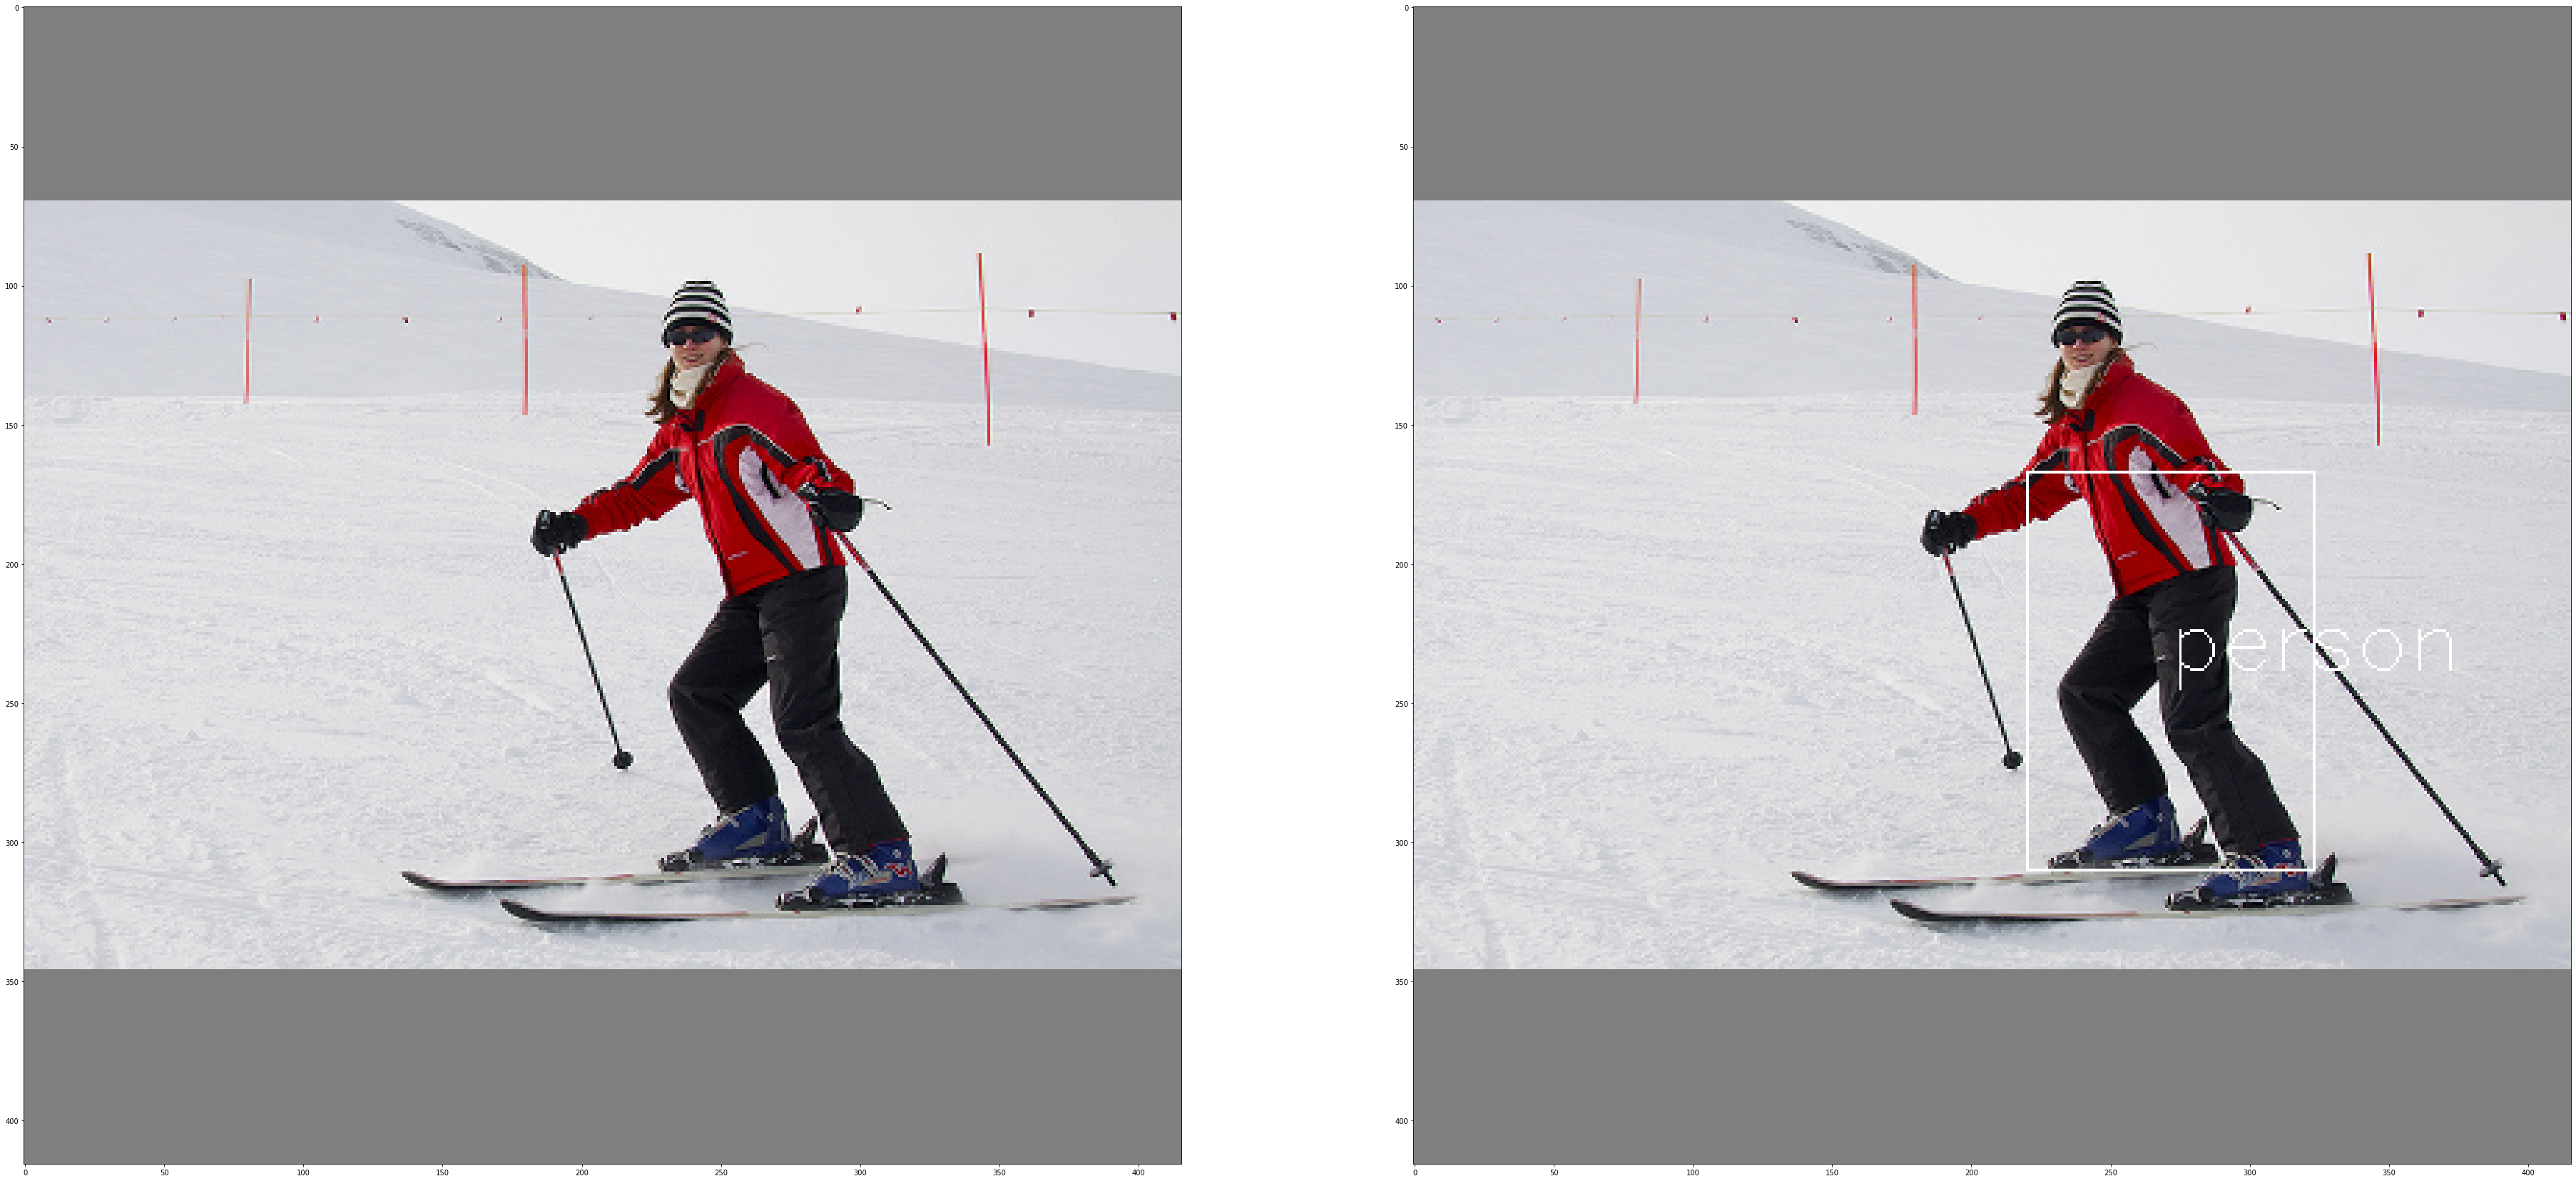

In [84]:
input_height = 416
input_width = 416
score_threshold = 0.4
iou_threshold = 0.3
img_path = os.getcwd()+'/coco/val2017/000000000785.jpg'
yolo_flow_snn(img_path,display=True,save_image =False,print_en=False)

In [39]:
print(tiny_yolo_snn)
conv_list = [0,3,6,9,12,15,18,20,22]
relu_list = [1,4,7,10,13,16]
max_pool_list = [2,5,8,11,14]
max_pool_1_list = [17]


Sequential(
  (0): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.1)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): LeakyReLU(negative_slope=0.1)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): LeakyReLU(negative_slope=0.1)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): LeakyReLU(negative_slope=0.1)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): LeakyReLU(negative_slope=0.1)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(512, 2

In [40]:
x = torch.tensor(dataset[100:101,:,:,:])

conv_out_shape_list = []
for idx,seq in enumerate(tiny_yolo_snn):
    x = seq(x)
    if idx in conv_list:
        conv_out_shape_list.append(x.shape)
print(conv_out_shape_list)
        
        

[torch.Size([1, 16, 416, 416]), torch.Size([1, 32, 208, 208]), torch.Size([1, 64, 104, 104]), torch.Size([1, 128, 52, 52]), torch.Size([1, 256, 26, 26]), torch.Size([1, 512, 13, 13]), torch.Size([1, 1024, 13, 13]), torch.Size([1, 512, 13, 13]), torch.Size([1, 425, 13, 13])]


In [41]:
pool_list = []
unpool_list = []
pool_conv_list = []
count =0
for i in range(len(max_pool_list)):
    shape = conv_out_shape_list[i]
    conv = nn.Conv2d(shape[1],shape[1],kernel_size=2,padding=0,stride=2)
    weight = torch.zeros((shape[1],shape[1],2,2))
    for i in range(shape[1]):
        weight[i,i,:,:].add_(1.0)
    bias = torch.zeros(shape[1])
    pool_list.append(nn.MaxPool2d(2,stride=2,return_indices=True))
    unpool_list.append(nn.MaxUnpool2d(2, stride=2))
    conv.weight = nn.Parameter(weight)
    conv.bias = nn.Parameter(bias)
    pool_conv_list.append(conv)
    count+=1
for i in range(count,count+1):
    shape = conv_out_shape_list[i]
    conv = nn.Conv2d(shape[1],shape[1],kernel_size=2,padding=0,stride=1)
    weight = torch.zeros((shape[1],shape[1],2,2))
    for i in range(shape[1]):
        weight[i,i,:,:].add_(1.0)
    bias = torch.zeros(shape[1])
    pool_list.append(nn.MaxPool2d(2, 1,return_indices=True))
    unpool_list.append(nn.MaxUnpool2d(2, stride=1))
    conv.weight = nn.Parameter(weight)
    conv.bias = nn.Parameter(bias)
    pool_conv_list.append(conv)
    count+=1


In [42]:
####refer to: https://github.com/ayooshkathuria/pytorch-yolo-v3/blob/master/darknet.py
def snn_pool(input_frame,count_frame,pool, unpool,conv):
    #zeros = torch.zeros_like(x)
    #conv = nn.Conv2d(input_img.shape[1],input_img.shape[1],kernel_size=2,padding=0,stride=2)
    #weight = torch.zeros((input_img.shape[1],input_img.shape[1],2,2))
    #bias = torch.zeros(input_img.shape[1])
    #print(weight)
    #for i in range(input_img.shape[1]):
    #    weight[i,i,:,:].add_(1.0)
    #print(weight)
    #conv.weight = nn.Parameter(weight)
    #conv.bias = nn.Parameter(bias)     

        
    #x = torch.abs(input_frame)
    #pool = nn.MaxPool2d(2,stride=2,return_indices=True)
    #unpool = nn.MaxUnpool2d(2, stride=2)
    pool_out = pool(count_frame)
    unpool_out = unpool(*pool_out).detach()
    output_non_zero = (~(unpool_out == 0))*1.0 #zeros))*1.0
    output = torch.mul(input_frame,output_non_zero)
    #output = torch.sign(output)
    pool_output = conv(output).detach()
    return pool_output
    #print(pool_output)
    

In [43]:
def snn_pool_stride1(input_frame,count_frame,pool,unpool,conv):
    #conv = nn.Conv2d(weight.shape[0],weight.shape[1],kernel_size=weight.shape[2],padding=0,stride=2)
    #conv.weight = nn.Parameter(weight)
    #conv.bias = nn.Parameter(bias)
    padded_inp = F.pad(input_frame, (0,1,0,1), mode="replicate")
    padded_count = F.pad(count_frame, (0,1,0,1), mode="replicate")
    padded_x = torch.abs(padded_count)
    #pool = nn.MaxPool2d(2, 1,return_indices=True)
    #unpool = nn.MaxUnpool2d(2, stride=1)
    pool_out = pool(padded_x)
    unpool_out = unpool(*pool_out).detach()
    output_non_zero = (~(unpool_out == 0))*1.0 #zeros))*1.0
    output = torch.mul(padded_inp,output_non_zero)
    #output = torch.sign(output)
    pool_output = conv(output).detach()
    return pool_output

In [324]:
pool = nn.MaxPool2d(2,stride=2,return_indices=True)
unpool = nn.MaxUnpool2d(2, stride=2)
    
inp = torch.tensor(dataset[100:101,:,:,:])
pool_unpool(inp,pool,unpool)

True


# SPIKING YOLO CODE START

In [64]:
img = torch.tensor(dataset[108:109,:,:,:])
input_tensor = torch.zeros_like(img)
print(input_tensor.shape)
num_cycles = 2000
conv_count =0
conv_buffers = []
pool_buffers = []

for shape in conv_out_shape_list:
    conv_buffers.append(torch.zeros(shape,dtype= torch.float32))
    pool_buffers.append(torch.zeros(shape,dtype= torch.float32))

for i in range(num_cycles):
    #print(x.shape)
    print('cycle ', i)
    conv_count=0
    pool_count=0
    input_tensor.add_(img)
    x = torch.gt(input_tensor,1.0)*1.0
    for idx,seq in enumerate(tiny_yolo_snn):
        #print(idx,conv_count,pool_count)
        if idx in conv_list:
            x = seq(x).detach()
            conv_buffers[conv_count].add_(x)
            pos = torch.gt(conv_buffers[conv_count],1)*1.0
            conv_buffers[conv_count].sub_(pos)
            neg = torch.le(conv_buffers[conv_count],-10)*1.0
            conv_buffers[conv_count].add_(torch.mul(neg,10.0))
            x = torch.sub(pos, neg)
            conv_count+=1
            #print('conv',x.shape)

        if idx in max_pool_list:
            pool_buffers[pool_count].add_(torch.abs(x))
            pool_out = pool_list[pool_count](pool_buffers[pool_count])
            unpool_out = unpool_list[pool_count](*pool_out).detach()

            output_non_zero = (~(unpool_out == 0))*1.0 #zeros))*1.0
            output = torch.mul(x,output_non_zero)
            
            if (pool_count==100):
                print(x[0,0,4:6,0:10])
                print(pool_buffers[pool_count][0,0,4:6,0:10])
                print('pool',pool_out[0][0,0,2,0:10])
                print('unpool',unpool_out[0,0,4:6,0:10])

                print(output_non_zero[0,0,4:6,0:10])
                print(output[0,0,4:6,0:10])

            #output = torch.sign(output)
            x = pool_conv_list[pool_count](output).detach()
            if (pool_count==100):
                print(x[0,0,2,0:10])
            pool_count+=1


            #print('pool',x.shape)
        if idx in max_pool_1_list:
            
            pool_buffers[pool_count].add_(torch.abs_(x))
            padded_inp = F.pad(x, (0,1,0,1), mode="replicate")
            padded_count = F.pad(pool_buffers[pool_count], (0,1,0,1), mode="replicate")
            #padded_x = torch.abs(padded_count)
            pool_out = pool_list[pool_count](padded_count)
            unpool_out = unpool_list[pool_count](*pool_out).detach()
            output_non_zero = (~(unpool_out == 0))*1.0 #zeros))*1.0
            output = torch.mul(padded_inp,output_non_zero)
            pool_output = pool_conv_list[pool_count](output).detach()
            #x= snn_pool_stride1(x,pool_buffers[pool_count],pool_list[pool_count],unpool_list[pool_count],pool_conv_list[pool_count])
            pool_count+=1
    output = conv_buffers[conv_count-1][0].numpy()
    output = output.transpose([1,2,0])
    postprocessing_snn(output,score_threshold,iou_threshold,416,416)
    #predictions = np.reshape(output,(13,13,5,(n_classes+5)))
    


            
        
    
    

torch.Size([1, 3, 416, 416])
cycle  0
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 0 B-boxes survived after score thresholding:
cycle  1
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 0 B-boxes survived after score thresholding:
cycle  2
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 0 B-boxes survived after score thresholding:
cycle  3
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 0 B-boxes survived after score thresholding:
cycle  4
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 0 B-boxes survived after score thresholding:
cycle  5
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 0 B-boxes survived after score thresholding:
cycle  6
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 0 B-boxes survived after score thresholding:
cycle

Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.4527792744015373, 'person']
B-Box 2 : [0.4128297891010224, 'person']
B-Box 3 : [0.4464535903441071, 'person']
B-Box 4 : [0.4062614312194584, 'person']
B-Box 5 : [0.4090344037335068, 'person']
B-Box 6 : [0.48823023084489514, 'person']
B-Box 7 : [0.4650359244368166, 'person']
B-Box 8 : [0.4162161212548449, 'person']
B-Box 9 : [0.4162818787794269, 'person']
B-Box 10 : [0.4216052987838532, 'person']
B-Box 11 : [0.4261016393904742, 'person']
B-Box 12 : [0.4505706648832935, 'person']
B-Box 13 : [0.4506896255438201, 'person']
B-Box 14 : [0.405393206562866, 'person']
B-Box 15 : [0.44719355769213975, 'person']
B-Box 16 : [0.43479723935911685, 'person']
B-Box 17 : [0.458192663795888, 'person']
B-Box 18 : [0.4826710207251022, 'person']
B-Box 19 : [0.4055343651714221, 'person']
B-Box 20 : [0.4199749494427521, 'person']
B-Box 21 : [0.4565242834490596, 'person']
B-Box 22 : [0.48847725087063276, 'person']
B-Box 23 : [0.46511505417789

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 20 B-boxes survived after score thresholding:
B-Box 1 : [0.40055620428191674, 'person']
B-Box 2 : [0.453663702521822, 'person']
B-Box 3 : [0.4333601852967844, 'person']
B-Box 4 : [0.46801495837118995, 'person']
B-Box 5 : [0.40343737257874906, 'person']
B-Box 6 : [0.4418592646452456, 'person']
B-Box 7 : [0.4963956523910595, 'person']
B-Box 8 : [0.40359773810933397, 'person']
B-Box 9 : [0.4107556619313341, 'person']
B-Box 10 : [0.4914066865144384, 'person']
B-Box 11 : [0.4500033018329706, 'person']
B-Box 12 : [0.4905876343681674, 'person']
B-Box 13 : [0.43707507715733385, 'person']
B-Box 14 : [0.4146571775647577, 'person']
B-Box 15 : [0.4120483478245493, 'person']
B-Box 16 : [0.4121513223470346, 'person']
B-Box 17 : [0.49454766952018087, 'person']
B-Box 18 : [0.410461491560647, 'chair']
B-Box 19 : [0.40458338728733056, 'chair']
B-Box 20 : [0.4902583116246076, 'bird']
cycle  32
Thresholding on (Objectness 

Printing 15 B-boxes survived after score thresholding:
B-Box 1 : [0.47512535422253194, 'person']
B-Box 2 : [0.4427473107874045, 'person']
B-Box 3 : [0.4259101469760943, 'person']
B-Box 4 : [0.49595220474033985, 'person']
B-Box 5 : [0.47795291194018663, 'person']
B-Box 6 : [0.4531692102375541, 'person']
B-Box 7 : [0.45733718098232373, 'person']
B-Box 8 : [0.4368139437217817, 'person']
B-Box 9 : [0.40624303999639694, 'person']
B-Box 10 : [0.44542306283153416, 'person']
B-Box 11 : [0.40085105386607106, 'person']
B-Box 12 : [0.4139855993001643, 'person']
B-Box 13 : [0.43181956233513236, 'person']
B-Box 14 : [0.4020036811245396, 'person']
B-Box 15 : [0.4309739068015063, 'person']
cycle  37
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 71 B-boxes survived after score thresholding:
B-Box 1 : [0.45981841229873577, 'person']
B-Box 2 : [0.46762337147160077, 'person']
B-Box 3 : [0.4514200559603945, 'person']
B-Box 4 : [0.4202995049837329, 'person']
B-Box 5 : 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 61 B-boxes survived after score thresholding:
B-Box 1 : [0.4263960051399665, 'person']
B-Box 2 : [0.4456950131161918, 'person']
B-Box 3 : [0.4241326690523601, 'person']
B-Box 4 : [0.41378144361384694, 'person']
B-Box 5 : [0.4608241300020771, 'person']
B-Box 6 : [0.4592276917220135, 'person']
B-Box 7 : [0.4327852437738491, 'person']
B-Box 8 : [0.45177072183603484, 'person']
B-Box 9 : [0.4675335474758223, 'person']
B-Box 10 : [0.45240124434761897, 'person']
B-Box 11 : [0.4886579912276287, 'person']
B-Box 12 : [0.4326904364033198, 'person']
B-Box 13 : [0.4915469486774402, 'person']
B-Box 14 : [0.47900956133830186, 'person']
B-Box 15 : [0.42364918329710927, 'person']
B-Box 16 : [0.4305087903287267, 'person']
B-Box 17 : [0.44104917510118213, 'person']
B-Box 18 : [0.4876945978715197, 'person']
B-Box 19 : [0.4953011502635835, 'person']
B-Box 20 : [0.48566925067441935, 'person']
B-Box 21 : [0.4481422942047135, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 21 B-boxes survived after score thresholding:
B-Box 1 : [0.4037000071850313, 'person']
B-Box 2 : [0.4154758798022482, 'person']
B-Box 3 : [0.41436599805349034, 'person']
B-Box 4 : [0.4761854699935775, 'person']
B-Box 5 : [0.40321885527970824, 'person']
B-Box 6 : [0.4860276478172306, 'person']
B-Box 7 : [0.4119739105998796, 'person']
B-Box 8 : [0.405198670476007, 'person']
B-Box 9 : [0.412141917474612, 'person']
B-Box 10 : [0.49160023832801886, 'person']
B-Box 11 : [0.44326289497433485, 'person']
B-Box 12 : [0.4672642886856029, 'person']
B-Box 13 : [0.44235160016001124, 'person']
B-Box 14 : [0.4279732816687095, 'person']
B-Box 15 : [0.40110440118014073, 'person']
B-Box 16 : [0.4743403468755377, 'person']
B-Box 17 : [0.4128768877363386, 'person']
B-Box 18 : [0.46294081872997406, 'person']
B-Box 19 : [0.46263377932600447, 'person']
B-Box 20 : [0.4219714063159833, 'person']
B-Box 21 : [0.4356194343643889, '

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 7 B-boxes survived after score thresholding:
B-Box 1 : [0.420178082239126, 'person']
B-Box 2 : [0.4830749265536326, 'person']
B-Box 3 : [0.42706447905490286, 'person']
B-Box 4 : [0.4227216026705532, 'person']
B-Box 5 : [0.4559160136175743, 'person']
B-Box 6 : [0.4489122400044396, 'person']
B-Box 7 : [0.45326326164983977, 'person']
cycle  56
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 23 B-boxes survived after score thresholding:
B-Box 1 : [0.48736458863844223, 'person']
B-Box 2 : [0.4717731179627525, 'person']
B-Box 3 : [0.4920699073429365, 'person']
B-Box 4 : [0.43146253087925, 'person']
B-Box 5 : [0.44958035517562844, 'person']
B-Box 6 : [0.4047927891497531, 'person']
B-Box 7 : [0.4917080975546622, 'person']
B-Box 8 : [0.4367963713820825, 'person']
B-Box 9 : [0.4542533985785313, 'person']
B-Box 10 : [0.42360425746970043, 'person']
B-Box 11 : [0.4900282849902621,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.4204741008130381, 'person']
B-Box 2 : [0.45258979895096124, 'person']
B-Box 3 : [0.463913358680073, 'person']
B-Box 4 : [0.495861617110502, 'person']
B-Box 5 : [0.438215309959748, 'person']
B-Box 6 : [0.4996271234028264, 'person']
B-Box 7 : [0.47825196824266897, 'person']
B-Box 8 : [0.4760831795738116, 'person']
B-Box 9 : [0.4125333782097251, 'person']
B-Box 10 : [0.46524962538139886, 'person']
B-Box 11 : [0.4399968885641778, 'person']
B-Box 12 : [0.43900736262676937, 'person']
B-Box 13 : [0.4067853354719859, 'person']
B-Box 14 : [0.4344739519684185, 'person']
B-Box 15 : [0.46675374543010373, 'person']
B-Box 16 : [0.49359380738833075, 'person']
B-Box 17 : [0.4551905570758525, 'person']
B-Box 18 : [0.4851651888554274, 'person']
B-Box 19 : [0.45613446677701813, 'person']
B-Box 20 : [0.48556419477145235, 'person']
B-Box 21 : [0.49317784816020604, '

B-Box 13 : [0.48802627518021136, 'person']
B-Box 14 : [0.44305392449034403, 'person']
B-Box 15 : [0.42350855444964514, 'person']
B-Box 16 : [0.4223764333852186, 'person']
B-Box 17 : [0.4101212023698281, 'person']
B-Box 18 : [0.492317313658814, 'person']
B-Box 19 : [0.46753047269043563, 'person']
B-Box 20 : [0.4240662927119268, 'person']
B-Box 21 : [0.43450160973561136, 'person']
B-Box 22 : [0.4414171452241869, 'person']
B-Box 23 : [0.4858390892231406, 'person']
B-Box 24 : [0.40404372796476423, 'person']
B-Box 25 : [0.40590055731313696, 'person']
B-Box 26 : [0.48754805455516065, 'person']
B-Box 27 : [0.4695155223017981, 'person']
B-Box 28 : [0.41715021520864803, 'person']
B-Box 29 : [0.4421963250497817, 'person']
B-Box 30 : [0.40361827080389995, 'person']
B-Box 31 : [0.467070856718359, 'person']
B-Box 32 : [0.46471677045032156, 'person']
B-Box 33 : [0.47126767659403107, 'person']
B-Box 34 : [0.4484814592447688, 'person']
B-Box 35 : [0.4827348758207351, 'person']
B-Box 36 : [0.4576216744

Printing 45 B-boxes survived after score thresholding:
B-Box 1 : [0.40577982467499457, 'person']
B-Box 2 : [0.4015266864262704, 'person']
B-Box 3 : [0.4955483629717278, 'person']
B-Box 4 : [0.4281124563989013, 'person']
B-Box 5 : [0.48368770730596305, 'person']
B-Box 6 : [0.4786492433776105, 'person']
B-Box 7 : [0.4358276527357919, 'person']
B-Box 8 : [0.4886527536161644, 'person']
B-Box 9 : [0.47688177850139907, 'person']
B-Box 10 : [0.4630980449051093, 'person']
B-Box 11 : [0.4258533112746341, 'person']
B-Box 12 : [0.4581408258214534, 'person']
B-Box 13 : [0.4377422756325108, 'person']
B-Box 14 : [0.4369570532768727, 'person']
B-Box 15 : [0.45026920260570386, 'person']
B-Box 16 : [0.48405671820674123, 'person']
B-Box 17 : [0.4421869313607786, 'person']
B-Box 18 : [0.41978917281654765, 'person']
B-Box 19 : [0.4776131639960206, 'person']
B-Box 20 : [0.434502307414, 'person']
B-Box 21 : [0.44975723823176295, 'person']
B-Box 22 : [0.49077781358300576, 'person']
B-Box 23 : [0.467019604271

Printing 38 B-boxes survived after score thresholding:
B-Box 1 : [0.44851284764110194, 'person']
B-Box 2 : [0.41441668336053344, 'person']
B-Box 3 : [0.4092572270890499, 'person']
B-Box 4 : [0.4168080107197556, 'person']
B-Box 5 : [0.46101288303216353, 'person']
B-Box 6 : [0.47133755599747895, 'person']
B-Box 7 : [0.4646673225817654, 'person']
B-Box 8 : [0.4337027104816662, 'person']
B-Box 9 : [0.4136394596113599, 'person']
B-Box 10 : [0.44648193119161705, 'person']
B-Box 11 : [0.4836762728951906, 'person']
B-Box 12 : [0.42009124256561486, 'person']
B-Box 13 : [0.4752711478065458, 'person']
B-Box 14 : [0.45350220182391116, 'person']
B-Box 15 : [0.40900500556002684, 'person']
B-Box 16 : [0.406570651603899, 'person']
B-Box 17 : [0.4019046446374556, 'person']
B-Box 18 : [0.4001361929008926, 'person']
B-Box 19 : [0.40842883828334825, 'person']
B-Box 20 : [0.4121329068646648, 'person']
B-Box 21 : [0.4309533159526039, 'person']
B-Box 22 : [0.4633512827515017, 'person']
B-Box 23 : [0.45631701

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.48510991673692966, 'person']
B-Box 2 : [0.42501036102996237, 'person']
B-Box 3 : [0.4286852866535638, 'person']
B-Box 4 : [0.4428426027206345, 'person']
B-Box 5 : [0.40997077532717824, 'person']
B-Box 6 : [0.47935086380045, 'person']
B-Box 7 : [0.4928975137743353, 'person']
B-Box 8 : [0.4071068679988081, 'person']
B-Box 9 : [0.471454217880252, 'person']
B-Box 10 : [0.43991040700248013, 'person']
B-Box 11 : [0.4755696359117264, 'person']
B-Box 12 : [0.4575771920084492, 'person']
B-Box 13 : [0.4000242629462465, 'person']
B-Box 14 : [0.4502104318239854, 'person']
B-Box 15 : [0.40348650952997034, 'person']
B-Box 16 : [0.44321818597203044, 'person']
B-Box 17 : [0.45440997072659156, 'person']
B-Box 18 : [0.4841349934628045, 'person']
B-Box 19 : [0.4404744408131216, 'person']
B-Box 20 : [0.4338268575007923, 'person']
B-Box 21 : [0.4010123058066083, 'pe

B-Box 5 : [0.4906136009545334, 'person']
B-Box 6 : [0.4041792224729716, 'person']
B-Box 7 : [0.4725142317133545, 'person']
B-Box 8 : [0.481875017412706, 'person']
B-Box 9 : [0.43658543528935767, 'person']
B-Box 10 : [0.47860000588792806, 'person']
B-Box 11 : [0.413199414804658, 'person']
B-Box 12 : [0.4681739047349668, 'person']
B-Box 13 : [0.47579608249914823, 'person']
B-Box 14 : [0.4949781182187366, 'person']
B-Box 15 : [0.4080549104423791, 'person']
B-Box 16 : [0.4960339965621919, 'person']
B-Box 17 : [0.42560196903254716, 'person']
B-Box 18 : [0.40281071199075963, 'person']
B-Box 19 : [0.4880274676485617, 'person']
B-Box 20 : [0.43458079928267246, 'person']
B-Box 21 : [0.47923138411279154, 'person']
B-Box 22 : [0.40489710431706416, 'person']
B-Box 23 : [0.41929796473783754, 'person']
B-Box 24 : [0.4596471592516492, 'person']
B-Box 25 : [0.4601995721353885, 'person']
B-Box 26 : [0.4161850101004869, 'person']
B-Box 27 : [0.4281810942041406, 'person']
B-Box 28 : [0.43156148546608014,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 55 B-boxes survived after score thresholding:
B-Box 1 : [0.45250403288993346, 'person']
B-Box 2 : [0.47253967780965683, 'person']
B-Box 3 : [0.41539969369216617, 'person']
B-Box 4 : [0.45523596016594176, 'person']
B-Box 5 : [0.4494027790665057, 'person']
B-Box 6 : [0.4188886513072643, 'person']
B-Box 7 : [0.47907765161368876, 'person']
B-Box 8 : [0.4811614675875373, 'person']
B-Box 9 : [0.4736722159318955, 'person']
B-Box 10 : [0.44246380464813884, 'person']
B-Box 11 : [0.4565488983236215, 'person']
B-Box 12 : [0.42057448878183323, 'person']
B-Box 13 : [0.48657739999030164, 'person']
B-Box 14 : [0.4407489646328795, 'person']
B-Box 15 : [0.4425127500691046, 'person']
B-Box 16 : [0.4499328314203277, 'person']
B-Box 17 : [0.4595784621026733, 'person']
B-Box 18 : [0.4845525414030476, 'person']
B-Box 19 : [0.4789957760294037, 'person']
B-Box 20 : [0.42800505323654087, 'person']
B-Box 21 : [0.4129009292206302

Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.47114554994617713, 'person']
B-Box 2 : [0.48491673164607874, 'person']
B-Box 3 : [0.40125675911740627, 'person']
B-Box 4 : [0.4330067194798845, 'person']
B-Box 5 : [0.44190325759396376, 'person']
B-Box 6 : [0.4287607483980394, 'person']
B-Box 7 : [0.4098840568563947, 'person']
B-Box 8 : [0.45244118771766223, 'person']
B-Box 9 : [0.4554786422442545, 'person']
B-Box 10 : [0.41876708845416094, 'person']
B-Box 11 : [0.4283368509760297, 'person']
B-Box 12 : [0.44379437853583337, 'person']
B-Box 13 : [0.45772892221873307, 'person']
B-Box 14 : [0.43865016399035206, 'person']
B-Box 15 : [0.48177621715344765, 'person']
B-Box 16 : [0.4024558775912756, 'person']
B-Box 17 : [0.4631478264796785, 'person']
B-Box 18 : [0.42164367087497334, 'person']
B-Box 19 : [0.44253884938320737, 'person']
B-Box 20 : [0.4650690695046021, 'person']
B-Box 21 : [0.486399430000668, 'person']
B-Box 22 : [0.4153327684398493, 'person']
B-Box 23 : [0.46748

Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.42899573945235614, 'person']
B-Box 2 : [0.4019610520879424, 'person']
B-Box 3 : [0.44564992358146516, 'person']
B-Box 4 : [0.4489672120873252, 'person']
B-Box 5 : [0.4270507001112316, 'person']
B-Box 6 : [0.4659387262776171, 'person']
B-Box 7 : [0.41119099594240566, 'person']
B-Box 8 : [0.4488987873493993, 'person']
B-Box 9 : [0.43586517590935575, 'person']
B-Box 10 : [0.4612686378113826, 'person']
B-Box 11 : [0.44895116115413186, 'person']
B-Box 12 : [0.4102868699033939, 'person']
B-Box 13 : [0.4345142583175116, 'person']
B-Box 14 : [0.47895363182177547, 'person']
B-Box 15 : [0.44353262832195767, 'person']
B-Box 16 : [0.45324861634923463, 'person']
B-Box 17 : [0.49713256843996434, 'person']
B-Box 18 : [0.4018386281683216, 'person']
B-Box 19 : [0.44040908875894225, 'person']
B-Box 20 : [0.4651903102136421, 'person']
B-Box 21 : [0.48094455526287666, 'person']
B-Box 22 : [0.4457342714045473, 'person']
B-Box 23 : [0.47720

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 40 B-boxes survived after score thresholding:
B-Box 1 : [0.4111789835125649, 'person']
B-Box 2 : [0.4344226290234392, 'person']
B-Box 3 : [0.44499269380048306, 'person']
B-Box 4 : [0.4464911812407244, 'person']
B-Box 5 : [0.4657683157138384, 'person']
B-Box 6 : [0.43193233591725627, 'person']
B-Box 7 : [0.4414533603701288, 'person']
B-Box 8 : [0.409309785771524, 'person']
B-Box 9 : [0.42773912557960236, 'person']
B-Box 10 : [0.46891104198199274, 'person']
B-Box 11 : [0.49125569100546623, 'person']
B-Box 12 : [0.4811055035271918, 'person']
B-Box 13 : [0.45079568161729555, 'person']
B-Box 14 : [0.4466516757062527, 'person']
B-Box 15 : [0.40299104524447626, 'person']
B-Box 16 : [0.4215934484261677, 'person']
B-Box 17 : [0.4283249312740982, 'person']
B-Box 18 : [0.4042334067659951, 'person']
B-Box 19 : [0.4894060145436631, 'person']
B-Box 20 : [0.40498788407333053, 'person']
B-Box 21 : [0.4781852077503712, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 21 B-boxes survived after score thresholding:
B-Box 1 : [0.4283550489381109, 'person']
B-Box 2 : [0.47060140890811725, 'person']
B-Box 3 : [0.47682992246732164, 'person']
B-Box 4 : [0.4946315026532922, 'person']
B-Box 5 : [0.45686313861507194, 'person']
B-Box 6 : [0.41127572769028886, 'person']
B-Box 7 : [0.497772233134678, 'person']
B-Box 8 : [0.42530123701063294, 'person']
B-Box 9 : [0.460160493751311, 'person']
B-Box 10 : [0.4956412364989175, 'person']
B-Box 11 : [0.42734676375789493, 'person']
B-Box 12 : [0.41079386541954127, 'person']
B-Box 13 : [0.4608222366980184, 'person']
B-Box 14 : [0.4513305322882392, 'person']
B-Box 15 : [0.42667009551366636, 'person']
B-Box 16 : [0.4507338186305068, 'person']
B-Box 17 : [0.49562583410712635, 'person']
B-Box 18 : [0.47624470231782307, 'person']
B-Box 19 : [0.4975080732448662, 'chair']
B-Box 20 : [0.4667848480076742, 'chair']
B-Box 21 : [0.4438823881451551, '

Printing 20 B-boxes survived after score thresholding:
B-Box 1 : [0.4260112221576278, 'person']
B-Box 2 : [0.4730100986088038, 'person']
B-Box 3 : [0.4106094818070794, 'person']
B-Box 4 : [0.41691510945315813, 'person']
B-Box 5 : [0.4421829222651535, 'person']
B-Box 6 : [0.42181718929303624, 'person']
B-Box 7 : [0.4178464485750641, 'person']
B-Box 8 : [0.4689583059868688, 'person']
B-Box 9 : [0.46819598486856495, 'person']
B-Box 10 : [0.42686225071224343, 'person']
B-Box 11 : [0.4493329218139179, 'person']
B-Box 12 : [0.4670815454801888, 'person']
B-Box 13 : [0.4265529816882301, 'person']
B-Box 14 : [0.4857616654696262, 'person']
B-Box 15 : [0.40639670890970864, 'person']
B-Box 16 : [0.4413884607277457, 'person']
B-Box 17 : [0.492853582861642, 'person']
B-Box 18 : [0.4347858627505189, 'person']
B-Box 19 : [0.40713334446381494, 'person']
B-Box 20 : [0.45835768705695096, 'person']
cycle  130
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 53 B-boxes su

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 39 B-boxes survived after score thresholding:
B-Box 1 : [0.49881267046957, 'person']
B-Box 2 : [0.43258766188308967, 'person']
B-Box 3 : [0.49030688309290377, 'person']
B-Box 4 : [0.49382074169937373, 'person']
B-Box 5 : [0.41669765510803597, 'person']
B-Box 6 : [0.4052462151258926, 'person']
B-Box 7 : [0.4011658024150076, 'person']
B-Box 8 : [0.40777413555767045, 'person']
B-Box 9 : [0.40429128820722776, 'person']
B-Box 10 : [0.4848316993604766, 'person']
B-Box 11 : [0.4742873258217275, 'person']
B-Box 12 : [0.4459432656469794, 'person']
B-Box 13 : [0.40308672473296, 'person']
B-Box 14 : [0.4684151745018801, 'person']
B-Box 15 : [0.43220497437639965, 'person']
B-Box 16 : [0.4487749166913605, 'person']
B-Box 17 : [0.46027989551723275, 'person']
B-Box 18 : [0.48512826456149677, 'person']
B-Box 19 : [0.42393237101056525, 'person']
B-Box 20 : [0.476501374670448, 'person']
B-Box 21 : [0.4770231183632173, 'p

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.4885788697149884, 'person']
B-Box 2 : [0.45856796019778656, 'person']
B-Box 3 : [0.4265604431188197, 'person']
B-Box 4 : [0.4790267120266221, 'person']
B-Box 5 : [0.43648879684506203, 'person']
B-Box 6 : [0.4228211294836684, 'person']
B-Box 7 : [0.41314275968324277, 'person']
B-Box 8 : [0.4243535160993508, 'person']
B-Box 9 : [0.4263106272125839, 'person']
B-Box 10 : [0.4799375966149116, 'person']
B-Box 11 : [0.4008634282071851, 'person']
B-Box 12 : [0.4545185010515803, 'person']
B-Box 13 : [0.49973653735679857, 'person']
B-Box 14 : [0.41434933765961457, 'person']
B-Box 15 : [0.44295980468092416, 'person']
B-Box 16 : [0.4190530218012169, 'person']
B-Box 17 : [0.46787426517189035, 'person']
B-Box 18 : [0.4032248729991392, 'person']
B-Box 19 : [0.4207395099482284, 'person']
B-Box 20 : [0.4781397448510225, 'person']
B-Box 21 : [0.43491922173559183,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 21 B-boxes survived after score thresholding:
B-Box 1 : [0.4086772435012702, 'person']
B-Box 2 : [0.4378112942534178, 'person']
B-Box 3 : [0.4015913123156275, 'person']
B-Box 4 : [0.45324246952343616, 'person']
B-Box 5 : [0.4610798082403193, 'person']
B-Box 6 : [0.4306981749075706, 'person']
B-Box 7 : [0.4952932835352072, 'person']
B-Box 8 : [0.4136862424181512, 'person']
B-Box 9 : [0.4879126199503061, 'person']
B-Box 10 : [0.47596043505349994, 'person']
B-Box 11 : [0.4341341997447033, 'person']
B-Box 12 : [0.49884702021462546, 'person']
B-Box 13 : [0.48022515133752874, 'person']
B-Box 14 : [0.46895356080628453, 'person']
B-Box 15 : [0.48456729220686495, 'person']
B-Box 16 : [0.47280542845900897, 'person']
B-Box 17 : [0.45141884198041626, 'person']
B-Box 18 : [0.4737161911551377, 'person']
B-Box 19 : [0.45464083661030585, 'person']
B-Box 20 : [0.4830887427518905, 'car']
B-Box 21 : [0.4681784251134851, '

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 36 B-boxes survived after score thresholding:
B-Box 1 : [0.4651293337882266, 'person']
B-Box 2 : [0.41400525444548364, 'person']
B-Box 3 : [0.49127165833865, 'person']
B-Box 4 : [0.4391980912079418, 'person']
B-Box 5 : [0.471755570043623, 'person']
B-Box 6 : [0.4043636487038356, 'person']
B-Box 7 : [0.46574648981797506, 'person']
B-Box 8 : [0.4843300727718433, 'person']
B-Box 9 : [0.41419290994411123, 'person']
B-Box 10 : [0.4078966530537541, 'person']
B-Box 11 : [0.44479791450074496, 'person']
B-Box 12 : [0.45810532349377525, 'person']
B-Box 13 : [0.44821209303776915, 'person']
B-Box 14 : [0.4493787045074539, 'person']
B-Box 15 : [0.4272454890363552, 'person']
B-Box 16 : [0.472225201093515, 'person']
B-Box 17 : [0.415911147033816, 'person']
B-Box 18 : [0.4073329376190639, 'person']
B-Box 19 : [0.41720980083505543, 'person']
B-Box 20 : [0.46726481288648347, 'person']
B-Box 21 : [0.41718660357135184, 'pe

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 38 B-boxes survived after score thresholding:
B-Box 1 : [0.4714083568327341, 'person']
B-Box 2 : [0.49811554599880636, 'person']
B-Box 3 : [0.4249308460906785, 'person']
B-Box 4 : [0.42329294815188595, 'person']
B-Box 5 : [0.476333429675784, 'person']
B-Box 6 : [0.43316781924434217, 'person']
B-Box 7 : [0.4537716820797032, 'person']
B-Box 8 : [0.4934085791580453, 'person']
B-Box 9 : [0.4266866545821569, 'person']
B-Box 10 : [0.43342213330743046, 'person']
B-Box 11 : [0.43449949420838824, 'person']
B-Box 12 : [0.450041647831346, 'person']
B-Box 13 : [0.4569511874994451, 'person']
B-Box 14 : [0.41625615543549555, 'person']
B-Box 15 : [0.4223196577062314, 'person']
B-Box 16 : [0.44949033590805254, 'person']
B-Box 17 : [0.4430226169680046, 'person']
B-Box 18 : [0.4883851586851445, 'person']
B-Box 19 : [0.46310632830776827, 'person']
B-Box 20 : [0.4794755827266637, 'person']
B-Box 21 : [0.45027604247210257, 

Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.450631348496613, 'person']
B-Box 2 : [0.41808008494165544, 'person']
B-Box 3 : [0.4611354940850521, 'person']
B-Box 4 : [0.47843341636870834, 'person']
B-Box 5 : [0.4293697955225934, 'person']
B-Box 6 : [0.43701337076469504, 'person']
B-Box 7 : [0.42430178760844317, 'person']
B-Box 8 : [0.4577966178005471, 'person']
B-Box 9 : [0.4866564956565517, 'person']
B-Box 10 : [0.46207003830695004, 'person']
B-Box 11 : [0.4333008140227221, 'person']
B-Box 12 : [0.4257127062632325, 'person']
B-Box 13 : [0.4113743330240894, 'person']
B-Box 14 : [0.48623266610252774, 'person']
B-Box 15 : [0.4118790102265072, 'person']
B-Box 16 : [0.41258515837882115, 'person']
B-Box 17 : [0.4292830908598703, 'person']
B-Box 18 : [0.4805522490225956, 'person']
B-Box 19 : [0.45737126760735397, 'person']
B-Box 20 : [0.4205126734677038, 'person']
B-Box 21 : [0.44431398242894166, 'person']
B-Box 22 : [0.4678094525124449, 'person']
B-Box 23 : [0.42775873

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 27 B-boxes survived after score thresholding:
B-Box 1 : [0.46242208149052727, 'person']
B-Box 2 : [0.4622397651454379, 'person']
B-Box 3 : [0.47871135768805334, 'person']
B-Box 4 : [0.4457689006689184, 'person']
B-Box 5 : [0.4951898110687916, 'person']
B-Box 6 : [0.489979426210726, 'person']
B-Box 7 : [0.4055885156952056, 'person']
B-Box 8 : [0.4238285108398361, 'person']
B-Box 9 : [0.4824960331266922, 'person']
B-Box 10 : [0.4620482267815975, 'person']
B-Box 11 : [0.4518373738193655, 'person']
B-Box 12 : [0.4065731738927209, 'person']
B-Box 13 : [0.4484965654111669, 'person']
B-Box 14 : [0.4783137117093806, 'person']
B-Box 15 : [0.4447557485471331, 'person']
B-Box 16 : [0.48610068937502515, 'person']
B-Box 17 : [0.45472043441843263, 'person']
B-Box 18 : [0.4046985824370554, 'person']
B-Box 19 : [0.45852201538725085, 'person']
B-Box 20 : [0.4254984547379405, 'person']
B-Box 21 : [0.42275177042190826, 'p

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 28 B-boxes survived after score thresholding:
B-Box 1 : [0.4455429600179139, 'person']
B-Box 2 : [0.42728446530635905, 'person']
B-Box 3 : [0.432454480221771, 'person']
B-Box 4 : [0.4525089880284769, 'person']
B-Box 5 : [0.4057940755940343, 'person']
B-Box 6 : [0.48537337192122987, 'person']
B-Box 7 : [0.4327819615437021, 'person']
B-Box 8 : [0.46664526454749344, 'person']
B-Box 9 : [0.44961612008875684, 'person']
B-Box 10 : [0.43846043800737416, 'person']
B-Box 11 : [0.49068893395318974, 'person']
B-Box 12 : [0.47168426704548616, 'person']
B-Box 13 : [0.42501432318081417, 'person']
B-Box 14 : [0.45184464563518306, 'person']
B-Box 15 : [0.4999773512609626, 'person']
B-Box 16 : [0.4501004228533998, 'person']
B-Box 17 : [0.46761332362795704, 'person']
B-Box 18 : [0.408020117416449, 'person']
B-Box 19 : [0.44199569459531346, 'person']
B-Box 20 : [0.41066602724641116, 'person']
B-Box 21 : [0.460192225498473

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.4620963574044142, 'person']
B-Box 2 : [0.4442824259896762, 'person']
B-Box 3 : [0.4962723994871277, 'person']
B-Box 4 : [0.48308214104677344, 'person']
B-Box 5 : [0.4349632869475257, 'person']
B-Box 6 : [0.40530436741299175, 'person']
B-Box 7 : [0.4295277380664665, 'person']
B-Box 8 : [0.4959863082698067, 'person']
B-Box 9 : [0.43395756339211444, 'person']
B-Box 10 : [0.4729701477558099, 'person']
B-Box 11 : [0.4769074802872062, 'person']
B-Box 12 : [0.4547478703941074, 'person']
B-Box 13 : [0.45424919101526867, 'person']
B-Box 14 : [0.49887846713394574, 'person']
B-Box 15 : [0.42479550348975004, 'person']
B-Box 16 : [0.46619477037181284, 'person']
B-Box 17 : [0.42936581767965276, 'person']
B-Box 18 : [0.4535996046161283, 'person']
B-Box 19 : [0.43436101700839225, 'person']
B-Box 20 : [0.4770923273382811, 'person']
B-Box 21 : [0.4402941569043622

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.47747968197422286, 'person']
B-Box 2 : [0.49829506101117815, 'person']
B-Box 3 : [0.47014027020569726, 'person']
B-Box 4 : [0.46871770745038394, 'person']
B-Box 5 : [0.49550618271641633, 'person']
B-Box 6 : [0.4610836097591595, 'person']
B-Box 7 : [0.4431355835326102, 'person']
B-Box 8 : [0.45027369804219214, 'person']
B-Box 9 : [0.4456718244252536, 'person']
B-Box 10 : [0.42735144449398493, 'person']
B-Box 11 : [0.48567900797120506, 'person']
B-Box 12 : [0.43871756481493296, 'person']
B-Box 13 : [0.48893774026185066, 'person']
B-Box 14 : [0.4386365395193963, 'person']
B-Box 15 : [0.48195383759240945, 'person']
B-Box 16 : [0.4704213190166933, 'person']
B-Box 17 : [0.42745672253408623, 'person']
B-Box 18 : [0.48286536452512674, 'person']
B-Box 19 : [0.47856666778293705, 'person']
B-Box 20 : [0.4314449777282931, 'person']
B-Box 21 : [0.40693517072

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.40908638485284565, 'person']
B-Box 2 : [0.47842247459947856, 'person']
B-Box 3 : [0.46594915623379285, 'person']
B-Box 4 : [0.45068541069760865, 'person']
B-Box 5 : [0.4357584884411335, 'person']
B-Box 6 : [0.40809038439833895, 'person']
B-Box 7 : [0.49380978245864954, 'person']
B-Box 8 : [0.48060723083849344, 'person']
B-Box 9 : [0.42152762639962604, 'person']
B-Box 10 : [0.44053224705997024, 'person']
B-Box 11 : [0.4462185031294736, 'person']
B-Box 12 : [0.4444063007456881, 'person']
B-Box 13 : [0.4402779575396649, 'person']
B-Box 14 : [0.41917769872432403, 'person']
B-Box 15 : [0.45317677502306103, 'person']
B-Box 16 : [0.40010437827365564, 'person']
B-Box 17 : [0.4228173999229528, 'person']
B-Box 18 : [0.4644593894639919, 'person']
B-Box 19 : [0.42681007422639666, 'person']
B-Box 20 : [0.40487228575926826, 'person']
B-Box 21 : [0.41891371182

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 28 B-boxes survived after score thresholding:
B-Box 1 : [0.45444923558326644, 'person']
B-Box 2 : [0.4656029398574297, 'person']
B-Box 3 : [0.470748242973113, 'person']
B-Box 4 : [0.4374390436527622, 'person']
B-Box 5 : [0.4796762500041457, 'person']
B-Box 6 : [0.4653042066320125, 'person']
B-Box 7 : [0.44360770765938323, 'person']
B-Box 8 : [0.4854243500903508, 'person']
B-Box 9 : [0.44735489657321015, 'person']
B-Box 10 : [0.4818319222333232, 'person']
B-Box 11 : [0.4648095211445853, 'person']
B-Box 12 : [0.419308423179697, 'person']
B-Box 13 : [0.4117701978326985, 'person']
B-Box 14 : [0.40613629988232197, 'person']
B-Box 15 : [0.43302522700171897, 'person']
B-Box 16 : [0.43382053067692505, 'person']
B-Box 17 : [0.42076112015666345, 'person']
B-Box 18 : [0.47537723816435856, 'person']
B-Box 19 : [0.4480130501848267, 'person']
B-Box 20 : [0.48666222699824674, 'person']
B-Box 21 : [0.4713596442110718, 

B-Box 3 : [0.46444560602796514, 'person']
B-Box 4 : [0.4393890776462814, 'person']
B-Box 5 : [0.4980006320136462, 'person']
B-Box 6 : [0.48871279362370407, 'person']
B-Box 7 : [0.4098512940771351, 'person']
B-Box 8 : [0.4271705814257307, 'person']
B-Box 9 : [0.46344069833705465, 'person']
B-Box 10 : [0.4732252504575223, 'person']
B-Box 11 : [0.4496673356868578, 'person']
B-Box 12 : [0.4381002617025866, 'person']
B-Box 13 : [0.44580282456310316, 'person']
B-Box 14 : [0.49725677959706743, 'person']
B-Box 15 : [0.4928593742279434, 'person']
B-Box 16 : [0.4236163651118528, 'person']
B-Box 17 : [0.47954937059705344, 'person']
B-Box 18 : [0.41925293023463167, 'person']
B-Box 19 : [0.43863465876665586, 'person']
B-Box 20 : [0.48121954268296707, 'person']
B-Box 21 : [0.45139972471347906, 'person']
B-Box 22 : [0.4785626271161155, 'person']
B-Box 23 : [0.49692156654484043, 'person']
B-Box 24 : [0.41843673827761213, 'person']
B-Box 25 : [0.4857071291751834, 'person']
B-Box 26 : [0.450957419437522

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.45893308854299253, 'person']
B-Box 2 : [0.4229721786868432, 'person']
B-Box 3 : [0.41897269328122494, 'person']
B-Box 4 : [0.4974637296768802, 'person']
B-Box 5 : [0.46466670252413494, 'person']
B-Box 6 : [0.4790474203155979, 'person']
B-Box 7 : [0.4388819554844392, 'person']
B-Box 8 : [0.44395117758935154, 'person']
B-Box 9 : [0.4356515590630431, 'person']
B-Box 10 : [0.43734585755247485, 'person']
B-Box 11 : [0.4196920780106396, 'person']
B-Box 12 : [0.42558307580608234, 'person']
B-Box 13 : [0.46493977448840657, 'person']
B-Box 14 : [0.4234102873368515, 'person']
B-Box 15 : [0.4444206627279199, 'person']
B-Box 16 : [0.4151560775721405, 'person']
B-Box 17 : [0.46594322947684946, 'person']
B-Box 18 : [0.4464376691149951, 'person']
B-Box 19 : [0.42363917043039184, 'person']
B-Box 20 : [0.433022879945778, 'person']
B-Box 21 : [0.49581800613332305

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.4201743396771153, 'person']
B-Box 2 : [0.4101341155760023, 'person']
B-Box 3 : [0.46915566992648805, 'person']
B-Box 4 : [0.492952576028222, 'person']
B-Box 5 : [0.44525321649308996, 'person']
B-Box 6 : [0.49407270576315715, 'person']
B-Box 7 : [0.4646076388188877, 'person']
B-Box 8 : [0.46537633029427483, 'person']
B-Box 9 : [0.4908624456531248, 'person']
B-Box 10 : [0.46726767595408053, 'person']
B-Box 11 : [0.47390783544839205, 'person']
B-Box 12 : [0.42371928661915914, 'person']
B-Box 13 : [0.4864099217648837, 'person']
B-Box 14 : [0.45529958419202393, 'person']
B-Box 15 : [0.48715707075124187, 'person']
B-Box 16 : [0.4707881628144492, 'person']
B-Box 17 : [0.4398533173484703, 'person']
B-Box 18 : [0.4059778371912629, 'person']
B-Box 19 : [0.49311586548200464, 'person']
B-Box 20 : [0.4870286352429785, 'person']
B-Box 21 : [0.4468506292157551

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.4574886522351129, 'person']
B-Box 2 : [0.41206012773134604, 'person']
B-Box 3 : [0.4458438386221809, 'person']
B-Box 4 : [0.47344989696381906, 'person']
B-Box 5 : [0.40204816904967267, 'person']
B-Box 6 : [0.45769388325658006, 'person']
B-Box 7 : [0.48440390791148985, 'person']
B-Box 8 : [0.4204178564403142, 'person']
B-Box 9 : [0.4991149800097757, 'person']
B-Box 10 : [0.41352850056353224, 'person']
B-Box 11 : [0.4057395898796301, 'person']
B-Box 12 : [0.4630131571096539, 'person']
B-Box 13 : [0.44712267457627697, 'person']
B-Box 14 : [0.46526219212793274, 'person']
B-Box 15 : [0.44212952897591135, 'person']
B-Box 16 : [0.49228706401157646, 'person']
B-Box 17 : [0.4739679753536436, 'person']
B-Box 18 : [0.4766988282457794, 'person']
B-Box 19 : [0.48803223758023834, 'person']
B-Box 20 : [0.49968361026097524, 'person']
B-Box 21 : [0.4632054453286

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 27 B-boxes survived after score thresholding:
B-Box 1 : [0.43177299815943593, 'person']
B-Box 2 : [0.44694186159637894, 'person']
B-Box 3 : [0.4727417201524521, 'person']
B-Box 4 : [0.4837863166679066, 'person']
B-Box 5 : [0.48828648488025245, 'person']
B-Box 6 : [0.43478738839346454, 'person']
B-Box 7 : [0.4430127436149237, 'person']
B-Box 8 : [0.40200762800106987, 'person']
B-Box 9 : [0.4781176161602529, 'person']
B-Box 10 : [0.41619172088558465, 'person']
B-Box 11 : [0.40431311250768215, 'person']
B-Box 12 : [0.4025480770868803, 'person']
B-Box 13 : [0.44548619716879734, 'person']
B-Box 14 : [0.42664607304263724, 'person']
B-Box 15 : [0.46755872054483477, 'person']
B-Box 16 : [0.4494207162897683, 'person']
B-Box 17 : [0.4711186926943312, 'person']
B-Box 18 : [0.45854923526003344, 'person']
B-Box 19 : [0.43693288263962504, 'person']
B-Box 20 : [0.40526299338268185, 'person']
B-Box 21 : [0.442515574622

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 36 B-boxes survived after score thresholding:
B-Box 1 : [0.49946092138502357, 'person']
B-Box 2 : [0.45074680021445995, 'person']
B-Box 3 : [0.42447279725312936, 'person']
B-Box 4 : [0.4575130296953412, 'person']
B-Box 5 : [0.4658687049666513, 'person']
B-Box 6 : [0.4251254873093681, 'person']
B-Box 7 : [0.42370229363511736, 'person']
B-Box 8 : [0.45565556413544483, 'person']
B-Box 9 : [0.4335190987549322, 'person']
B-Box 10 : [0.49111364182963924, 'person']
B-Box 11 : [0.4786811452843196, 'person']
B-Box 12 : [0.4669301019896694, 'person']
B-Box 13 : [0.44931901072995445, 'person']
B-Box 14 : [0.466302290179873, 'person']
B-Box 15 : [0.48274415441675145, 'person']
B-Box 16 : [0.4463667354242265, 'person']
B-Box 17 : [0.47635390575361214, 'person']
B-Box 18 : [0.4657398441872241, 'person']
B-Box 19 : [0.4234349727394373, 'person']
B-Box 20 : [0.4146511515596807, 'person']
B-Box 21 : [0.44526664060796467

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 41 B-boxes survived after score thresholding:
B-Box 1 : [0.40351911665542495, 'person']
B-Box 2 : [0.4378016746631356, 'person']
B-Box 3 : [0.40829427570374915, 'person']
B-Box 4 : [0.48748898028160503, 'person']
B-Box 5 : [0.4754856937246106, 'person']
B-Box 6 : [0.42950392052643904, 'person']
B-Box 7 : [0.4146687381464277, 'person']
B-Box 8 : [0.49496094529036433, 'person']
B-Box 9 : [0.47704023560940517, 'person']
B-Box 10 : [0.4219890674118919, 'person']
B-Box 11 : [0.4545385976517425, 'person']
B-Box 12 : [0.4933613943165687, 'person']
B-Box 13 : [0.45320892631957477, 'person']
B-Box 14 : [0.46928178127079323, 'person']
B-Box 15 : [0.4667955102512561, 'person']
B-Box 16 : [0.4335221233230401, 'person']
B-Box 17 : [0.41939806440923405, 'person']
B-Box 18 : [0.4001547267283936, 'person']
B-Box 19 : [0.49484961301825, 'person']
B-Box 20 : [0.43752213726069134, 'person']
B-Box 21 : [0.481407389021918, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 46 B-boxes survived after score thresholding:
B-Box 1 : [0.49909401486975796, 'person']
B-Box 2 : [0.44134166770970007, 'person']
B-Box 3 : [0.49510566741580303, 'person']
B-Box 4 : [0.4430557965302288, 'person']
B-Box 5 : [0.48000971394169795, 'person']
B-Box 6 : [0.4093065703581056, 'person']
B-Box 7 : [0.416539346186888, 'person']
B-Box 8 : [0.4931149089023304, 'person']
B-Box 9 : [0.45866597146372734, 'person']
B-Box 10 : [0.4144201638244039, 'person']
B-Box 11 : [0.4806309138708204, 'person']
B-Box 12 : [0.46676275747990414, 'person']
B-Box 13 : [0.41323570747988136, 'person']
B-Box 14 : [0.4480922870734371, 'person']
B-Box 15 : [0.42539565952415836, 'person']
B-Box 16 : [0.48924086379163817, 'person']
B-Box 17 : [0.46242799548299907, 'person']
B-Box 18 : [0.4149178365927842, 'person']
B-Box 19 : [0.4898636008613453, 'person']
B-Box 20 : [0.46009368710883836, 'person']
B-Box 21 : [0.408664342235964

Printing 52 B-boxes survived after score thresholding:
B-Box 1 : [0.43803218123066845, 'person']
B-Box 2 : [0.4042754475792316, 'person']
B-Box 3 : [0.4326312112543214, 'person']
B-Box 4 : [0.490938688320714, 'person']
B-Box 5 : [0.4638768278411212, 'person']
B-Box 6 : [0.49618800495063675, 'person']
B-Box 7 : [0.45296738007278053, 'person']
B-Box 8 : [0.4850093930513853, 'person']
B-Box 9 : [0.46856384029610554, 'person']
B-Box 10 : [0.46298302827678595, 'person']
B-Box 11 : [0.4920858699172484, 'person']
B-Box 12 : [0.43757611253800477, 'person']
B-Box 13 : [0.42948474525766833, 'person']
B-Box 14 : [0.4535988933162224, 'person']
B-Box 15 : [0.4074998634964685, 'person']
B-Box 16 : [0.4160930218946386, 'person']
B-Box 17 : [0.4687034606112572, 'person']
B-Box 18 : [0.4385872324317711, 'person']
B-Box 19 : [0.44682799354522035, 'person']
B-Box 20 : [0.48609283051134444, 'person']
B-Box 21 : [0.43914500246752497, 'person']
B-Box 22 : [0.46332289553878303, 'person']
B-Box 23 : [0.432508

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.488053930588611, 'person']
B-Box 2 : [0.43567171887354306, 'person']
B-Box 3 : [0.4830775591954589, 'person']
B-Box 4 : [0.4440849059715191, 'person']
B-Box 5 : [0.4276235823123889, 'person']
B-Box 6 : [0.43747613755760295, 'person']
B-Box 7 : [0.47618952468058784, 'person']
B-Box 8 : [0.49559295129793346, 'person']
B-Box 9 : [0.4915166784224466, 'person']
B-Box 10 : [0.45036788115444737, 'person']
B-Box 11 : [0.492319711831907, 'person']
B-Box 12 : [0.4800175696128099, 'person']
B-Box 13 : [0.41778079254065326, 'person']
B-Box 14 : [0.4667382933016114, 'person']
B-Box 15 : [0.45104973032805146, 'person']
B-Box 16 : [0.4240047969521582, 'person']
B-Box 17 : [0.43650992007212613, 'person']
B-Box 18 : [0.4855644196218174, 'person']
B-Box 19 : [0.48504108268495305, 'person']
B-Box 20 : [0.4250161966148201, 'person']
B-Box 21 : [0.4099463325901599, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 36 B-boxes survived after score thresholding:
B-Box 1 : [0.4792037887488272, 'person']
B-Box 2 : [0.44014258578774096, 'person']
B-Box 3 : [0.4558675267164223, 'person']
B-Box 4 : [0.462563370393436, 'person']
B-Box 5 : [0.4345109723161776, 'person']
B-Box 6 : [0.4839877887907598, 'person']
B-Box 7 : [0.4662344139872636, 'person']
B-Box 8 : [0.4709825219645375, 'person']
B-Box 9 : [0.45805606968762275, 'person']
B-Box 10 : [0.44976148230811713, 'person']
B-Box 11 : [0.4558523801611811, 'person']
B-Box 12 : [0.4571272625696254, 'person']
B-Box 13 : [0.4408124486334123, 'person']
B-Box 14 : [0.49604065488231713, 'person']
B-Box 15 : [0.4147678084200366, 'person']
B-Box 16 : [0.4606502099573627, 'person']
B-Box 17 : [0.49113270541052834, 'person']
B-Box 18 : [0.46382511986118546, 'person']
B-Box 19 : [0.4476317126749942, 'person']
B-Box 20 : [0.47274076106196883, 'person']
B-Box 21 : [0.46005553501079827, 

Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.4020499996429357, 'person']
B-Box 2 : [0.4834283628439733, 'person']
B-Box 3 : [0.43079757560917514, 'person']
B-Box 4 : [0.4033442062010783, 'person']
B-Box 5 : [0.43027218333970213, 'person']
B-Box 6 : [0.41524545251815886, 'person']
B-Box 7 : [0.44720612655709135, 'person']
B-Box 8 : [0.45421303494761117, 'person']
B-Box 9 : [0.4738631286697652, 'person']
B-Box 10 : [0.40619933014895754, 'person']
B-Box 11 : [0.45393548912170606, 'person']
B-Box 12 : [0.46510158500654, 'person']
B-Box 13 : [0.48466878080490206, 'person']
B-Box 14 : [0.4391701312242409, 'person']
B-Box 15 : [0.48848523775679936, 'person']
B-Box 16 : [0.4297032511702392, 'person']
B-Box 17 : [0.4408446492601357, 'person']
B-Box 18 : [0.450531247834916, 'person']
B-Box 19 : [0.42976097277552955, 'person']
B-Box 20 : [0.480197771272184, 'person']
B-Box 21 : [0.45096403779458444, 'person']
B-Box 22 : [0.42559030901461575, 'person']
B-Box 23 : [0.42109515

Printing 44 B-boxes survived after score thresholding:
B-Box 1 : [0.4334863017043386, 'person']
B-Box 2 : [0.47081049023096944, 'person']
B-Box 3 : [0.4091926654848028, 'person']
B-Box 4 : [0.4276887053652025, 'person']
B-Box 5 : [0.4675644278597814, 'person']
B-Box 6 : [0.4023765163453852, 'person']
B-Box 7 : [0.4072318566517575, 'person']
B-Box 8 : [0.44963405024612574, 'person']
B-Box 9 : [0.48561706844591396, 'person']
B-Box 10 : [0.4768903454555212, 'person']
B-Box 11 : [0.4863160478519323, 'person']
B-Box 12 : [0.4398573073759427, 'person']
B-Box 13 : [0.4723768541756484, 'person']
B-Box 14 : [0.4552430752903253, 'person']
B-Box 15 : [0.4661178861607917, 'person']
B-Box 16 : [0.4496128185893386, 'person']
B-Box 17 : [0.4901970042415213, 'person']
B-Box 18 : [0.4618235124131398, 'person']
B-Box 19 : [0.4024707842405822, 'person']
B-Box 20 : [0.48286322434163426, 'person']
B-Box 21 : [0.45044601824217106, 'person']
B-Box 22 : [0.48041560612165934, 'person']
B-Box 23 : [0.4173633038

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.41403811253567474, 'person']
B-Box 2 : [0.402579953096212, 'person']
B-Box 3 : [0.4991505297466917, 'person']
B-Box 4 : [0.4727837907556953, 'person']
B-Box 5 : [0.48925732819420964, 'person']
B-Box 6 : [0.45267462042007084, 'person']
B-Box 7 : [0.47347771550804263, 'person']
B-Box 8 : [0.4761980938129673, 'person']
B-Box 9 : [0.48168359758263807, 'person']
B-Box 10 : [0.4276389946481199, 'person']
B-Box 11 : [0.41437039874974724, 'person']
B-Box 12 : [0.417572037404734, 'person']
B-Box 13 : [0.4473270811266557, 'person']
B-Box 14 : [0.44444467991970904, 'person']
B-Box 15 : [0.41766992128179725, 'person']
B-Box 16 : [0.4546615556178854, 'person']
B-Box 17 : [0.466981854716598, 'person']
B-Box 18 : [0.4493447396916791, 'person']
B-Box 19 : [0.48760955233909775, 'person']
B-Box 20 : [0.4520417057463819, 'person']
B-Box 21 : [0.4774463638873634, '

Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.4784272223381259, 'person']
B-Box 2 : [0.41439539238369005, 'person']
B-Box 3 : [0.4243935767820721, 'person']
B-Box 4 : [0.4232796842849027, 'person']
B-Box 5 : [0.47798769231014687, 'person']
B-Box 6 : [0.43715133480436497, 'person']
B-Box 7 : [0.45949581603182366, 'person']
B-Box 8 : [0.4097170534413909, 'person']
B-Box 9 : [0.44064202583988016, 'person']
B-Box 10 : [0.4734701258787249, 'person']
B-Box 11 : [0.4516923450696626, 'person']
B-Box 12 : [0.4305648942790347, 'person']
B-Box 13 : [0.4812795370504453, 'person']
B-Box 14 : [0.42782433484079313, 'person']
B-Box 15 : [0.49555313468102435, 'person']
B-Box 16 : [0.45038439626744947, 'person']
B-Box 17 : [0.4613084923773582, 'person']
B-Box 18 : [0.47553895610778374, 'person']
B-Box 19 : [0.46751835634510963, 'person']
B-Box 20 : [0.49064817951602246, 'person']
B-Box 21 : [0.45828098739392503, 'person']
B-Box 22 : [0.4030309691092042, 'person']
B-Box 23 : [0.4928

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 43 B-boxes survived after score thresholding:
B-Box 1 : [0.40741788730184864, 'person']
B-Box 2 : [0.4089900297134976, 'person']
B-Box 3 : [0.491268320936364, 'person']
B-Box 4 : [0.41974760326378646, 'person']
B-Box 5 : [0.4638500234064716, 'person']
B-Box 6 : [0.44459939399367915, 'person']
B-Box 7 : [0.4739958012485505, 'person']
B-Box 8 : [0.48711726858278953, 'person']
B-Box 9 : [0.46577496215713915, 'person']
B-Box 10 : [0.4101544294543464, 'person']
B-Box 11 : [0.4909086653027402, 'person']
B-Box 12 : [0.4036602808786876, 'person']
B-Box 13 : [0.4569270440951117, 'person']
B-Box 14 : [0.43564216988917065, 'person']
B-Box 15 : [0.4082318253891085, 'person']
B-Box 16 : [0.4693350019590575, 'person']
B-Box 17 : [0.42430202368493863, 'person']
B-Box 18 : [0.43216892479342606, 'person']
B-Box 19 : [0.480316330768301, 'person']
B-Box 20 : [0.40042349782857123, 'person']
B-Box 21 : [0.4410924502308364, 

Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.4207997032744402, 'person']
B-Box 2 : [0.42185857577631086, 'person']
B-Box 3 : [0.4380070681739813, 'person']
B-Box 4 : [0.49033239005160334, 'person']
B-Box 5 : [0.4557714753157434, 'person']
B-Box 6 : [0.46065069058274294, 'person']
B-Box 7 : [0.4155783405530565, 'person']
B-Box 8 : [0.49001062372113896, 'person']
B-Box 9 : [0.4415808226736686, 'person']
B-Box 10 : [0.45829613498279576, 'person']
B-Box 11 : [0.42854773156158615, 'person']
B-Box 12 : [0.43307648857833225, 'person']
B-Box 13 : [0.4890030383261872, 'person']
B-Box 14 : [0.4330069653423901, 'person']
B-Box 15 : [0.47655204928377226, 'person']
B-Box 16 : [0.41073988339906586, 'person']
B-Box 17 : [0.45839653497446486, 'person']
B-Box 18 : [0.4692046631880028, 'person']
B-Box 19 : [0.45942545310755134, 'person']
B-Box 20 : [0.4879221554173029, 'person']
B-Box 21 : [0.4623108909090408, 'person']
B-Box 22 : [0.43722643404097933, 'person']
B-Box 23 : [0.4352

Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.4061029538701837, 'person']
B-Box 2 : [0.4265926343755855, 'person']
B-Box 3 : [0.47062113110763104, 'person']
B-Box 4 : [0.46821642064666896, 'person']
B-Box 5 : [0.410825535902854, 'person']
B-Box 6 : [0.4311822950096014, 'person']
B-Box 7 : [0.45702926033802566, 'person']
B-Box 8 : [0.4122179462596783, 'person']
B-Box 9 : [0.46781727917493454, 'person']
B-Box 10 : [0.48821501321134664, 'person']
B-Box 11 : [0.4247407423684993, 'person']
B-Box 12 : [0.49874736560912897, 'person']
B-Box 13 : [0.417800060603513, 'person']
B-Box 14 : [0.45688822087778813, 'person']
B-Box 15 : [0.4056589291282456, 'person']
B-Box 16 : [0.4331947517002617, 'person']
B-Box 17 : [0.49596891869584525, 'person']
B-Box 18 : [0.485424125369691, 'person']
B-Box 19 : [0.43920160945146974, 'person']
B-Box 20 : [0.41087886045316047, 'person']
B-Box 21 : [0.41324865469921984, 'person']
B-Box 22 : [0.47966552558994213, 'person']
B-Box 23 : [0.4475836

B-Box 24 : [0.4986894300187257, 'person']
B-Box 25 : [0.4348669594323625, 'person']
B-Box 26 : [0.4030178990779496, 'person']
B-Box 27 : [0.4370459750712206, 'person']
B-Box 28 : [0.48324996032256956, 'person']
B-Box 29 : [0.41056100945660795, 'person']
B-Box 30 : [0.44466931918735736, 'person']
B-Box 31 : [0.4901880574098274, 'chair']
B-Box 32 : [0.45653043729267684, 'chair']
B-Box 33 : [0.44337021932973075, 'chair']
B-Box 34 : [0.49335366859376356, 'car']
B-Box 35 : [0.4962622482875123, 'car']
B-Box 36 : [0.4139069361096969, 'car']
cycle  315
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 24 B-boxes survived after score thresholding:
B-Box 1 : [0.42190533890857157, 'person']
B-Box 2 : [0.4762218565220521, 'person']
B-Box 3 : [0.4009676443328708, 'person']
B-Box 4 : [0.488500485000168, 'person']
B-Box 5 : [0.4315177516200676, 'person']
B-Box 6 : [0.4558992142286767, 'person']
B-Box 7 : [0.4952842180986692, 'person']
B-Box 8 : [0.41501460312132876, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.40290775723733285, 'person']
B-Box 2 : [0.49224509047810094, 'person']
B-Box 3 : [0.40118573644170125, 'person']
B-Box 4 : [0.44291461892462125, 'person']
B-Box 5 : [0.492700392739739, 'person']
B-Box 6 : [0.43433265751210043, 'person']
B-Box 7 : [0.4590621538677069, 'person']
B-Box 8 : [0.4623502334677403, 'person']
B-Box 9 : [0.4746130950225589, 'person']
B-Box 10 : [0.473373833545089, 'person']
B-Box 11 : [0.4468204488313147, 'person']
B-Box 12 : [0.48919749666602363, 'person']
B-Box 13 : [0.45559028174923993, 'person']
B-Box 14 : [0.4486484749009587, 'person']
B-Box 15 : [0.42229684541244833, 'person']
B-Box 16 : [0.42829153777070705, 'person']
B-Box 17 : [0.48453926808606684, 'person']
B-Box 18 : [0.4539787503771382, 'person']
B-Box 19 : [0.437760116493781, 'person']
B-Box 20 : [0.4501077406213022, 'person']
B-Box 21 : [0.4710135691105785, 

B-Box 28 : [0.4951623932885213, 'person']
B-Box 29 : [0.42485329113605425, 'person']
B-Box 30 : [0.46339374637240316, 'person']
B-Box 31 : [0.44400625734564586, 'person']
B-Box 32 : [0.4368329511061675, 'person']
B-Box 33 : [0.49937606328495865, 'person']
B-Box 34 : [0.43358092034887397, 'person']
B-Box 35 : [0.4454897222433763, 'person']
B-Box 36 : [0.4578318973819186, 'person']
B-Box 37 : [0.4557520866613782, 'person']
B-Box 38 : [0.4405773380388458, 'person']
B-Box 39 : [0.45371849662391484, 'person']
B-Box 40 : [0.42473794661783376, 'person']
B-Box 41 : [0.4762601116336964, 'person']
B-Box 42 : [0.4246235459671786, 'person']
B-Box 43 : [0.47977501395238814, 'chair']
B-Box 44 : [0.48661338787092084, 'chair']
B-Box 45 : [0.44070665984114693, 'car']
B-Box 46 : [0.4621113000444505, 'car']
cycle  326
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 45 B-boxes survived after score thresholding:
B-Box 1 : [0.43532871344727275, 'person']
B-Box 2 : [0.4079

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 39 B-boxes survived after score thresholding:
B-Box 1 : [0.41652081467512764, 'person']
B-Box 2 : [0.46545891016489577, 'person']
B-Box 3 : [0.48169524223184906, 'person']
B-Box 4 : [0.41947121454917563, 'person']
B-Box 5 : [0.4897014380762089, 'person']
B-Box 6 : [0.46715323264092967, 'person']
B-Box 7 : [0.43865415515727446, 'person']
B-Box 8 : [0.43441536244047096, 'person']
B-Box 9 : [0.4508216526607513, 'person']
B-Box 10 : [0.44458266422874104, 'person']
B-Box 11 : [0.4310188149609208, 'person']
B-Box 12 : [0.49557269086687566, 'person']
B-Box 13 : [0.4787896654451414, 'person']
B-Box 14 : [0.457372913469114, 'person']
B-Box 15 : [0.41696633742896355, 'person']
B-Box 16 : [0.44481864666789334, 'person']
B-Box 17 : [0.44278166444596895, 'person']
B-Box 18 : [0.4641856484067379, 'person']
B-Box 19 : [0.4879069158758917, 'person']
B-Box 20 : [0.4547842842540566, 'person']
B-Box 21 : [0.48745226794729

Printing 38 B-boxes survived after score thresholding:
B-Box 1 : [0.4293048186689639, 'person']
B-Box 2 : [0.4061719523538859, 'person']
B-Box 3 : [0.4669429156345182, 'person']
B-Box 4 : [0.46423545856558873, 'person']
B-Box 5 : [0.49163539028291076, 'person']
B-Box 6 : [0.4108603864570092, 'person']
B-Box 7 : [0.40635155934604417, 'person']
B-Box 8 : [0.41554976771668933, 'person']
B-Box 9 : [0.4423379547127909, 'person']
B-Box 10 : [0.49662596479977533, 'person']
B-Box 11 : [0.47410185883854705, 'person']
B-Box 12 : [0.41292704676960673, 'person']
B-Box 13 : [0.44757866713391886, 'person']
B-Box 14 : [0.43601243241855325, 'person']
B-Box 15 : [0.4522037540217908, 'person']
B-Box 16 : [0.44726199314247983, 'person']
B-Box 17 : [0.40355215615355117, 'person']
B-Box 18 : [0.4748825546240941, 'person']
B-Box 19 : [0.41480948456338657, 'person']
B-Box 20 : [0.4757066379856997, 'person']
B-Box 21 : [0.41599315257853176, 'person']
B-Box 22 : [0.41712609119073957, 'person']
B-Box 23 : [0.49

Printing 43 B-boxes survived after score thresholding:
B-Box 1 : [0.45771471118756357, 'person']
B-Box 2 : [0.42537070185135417, 'person']
B-Box 3 : [0.4062437285705984, 'person']
B-Box 4 : [0.4445162524145769, 'person']
B-Box 5 : [0.42598948794270014, 'person']
B-Box 6 : [0.456100293469588, 'person']
B-Box 7 : [0.40614642667160256, 'person']
B-Box 8 : [0.4711350712846239, 'person']
B-Box 9 : [0.4366921871185142, 'person']
B-Box 10 : [0.43647894003870685, 'person']
B-Box 11 : [0.4434078806813926, 'person']
B-Box 12 : [0.4633823554269531, 'person']
B-Box 13 : [0.48922394399176755, 'person']
B-Box 14 : [0.47603298281315215, 'person']
B-Box 15 : [0.4396998830749358, 'person']
B-Box 16 : [0.4512500004706904, 'person']
B-Box 17 : [0.401616749326151, 'person']
B-Box 18 : [0.47381701189314246, 'person']
B-Box 19 : [0.4048945832381062, 'person']
B-Box 20 : [0.4378137560528126, 'person']
B-Box 21 : [0.4451088166545652, 'person']
B-Box 22 : [0.41527534180381487, 'person']
B-Box 23 : [0.446622687

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.47560223417063235, 'person']
B-Box 2 : [0.4075249656534015, 'person']
B-Box 3 : [0.4717491497686555, 'person']
B-Box 4 : [0.41732412341670355, 'person']
B-Box 5 : [0.4682781569376203, 'person']
B-Box 6 : [0.4311451084124407, 'person']
B-Box 7 : [0.44766119050781583, 'person']
B-Box 8 : [0.46992027955653226, 'person']
B-Box 9 : [0.4671171522085138, 'person']
B-Box 10 : [0.4312987939522184, 'person']
B-Box 11 : [0.4347692098942942, 'person']
B-Box 12 : [0.43624720630646674, 'person']
B-Box 13 : [0.463931369680212, 'person']
B-Box 14 : [0.41364968698929333, 'person']
B-Box 15 : [0.45749032389199845, 'person']
B-Box 16 : [0.41673336417705076, 'person']
B-Box 17 : [0.45728178547199827, 'person']
B-Box 18 : [0.42123814349279937, 'person']
B-Box 19 : [0.4407595478895621, 'person']
B-Box 20 : [0.4892678009297981, 'person']
B-Box 21 : [0.4101673447530353

Printing 24 B-boxes survived after score thresholding:
B-Box 1 : [0.4686077621137751, 'person']
B-Box 2 : [0.46421030810860403, 'person']
B-Box 3 : [0.4445282658523013, 'person']
B-Box 4 : [0.48381059161571105, 'person']
B-Box 5 : [0.44170710264933444, 'person']
B-Box 6 : [0.4664456492860974, 'person']
B-Box 7 : [0.47271414785334415, 'person']
B-Box 8 : [0.4330683055850869, 'person']
B-Box 9 : [0.451690204762154, 'person']
B-Box 10 : [0.4127483549691512, 'person']
B-Box 11 : [0.4710545387487277, 'person']
B-Box 12 : [0.4039562304600698, 'person']
B-Box 13 : [0.40979086890129146, 'person']
B-Box 14 : [0.42318423459375215, 'person']
B-Box 15 : [0.43103143876169553, 'person']
B-Box 16 : [0.42315466887167336, 'person']
B-Box 17 : [0.44358582155414905, 'person']
B-Box 18 : [0.4924946681100701, 'person']
B-Box 19 : [0.4309820772642246, 'person']
B-Box 20 : [0.42923661084027365, 'person']
B-Box 21 : [0.45749149655411925, 'person']
B-Box 22 : [0.4840799837451399, 'person']
B-Box 23 : [0.425404

Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.4702809108100203, 'person']
B-Box 2 : [0.4809210082006339, 'person']
B-Box 3 : [0.4069853378002737, 'person']
B-Box 4 : [0.49123353984767126, 'person']
B-Box 5 : [0.4113152125535994, 'person']
B-Box 6 : [0.4566201226960604, 'person']
B-Box 7 : [0.4069213527708763, 'person']
B-Box 8 : [0.4838410922157468, 'person']
B-Box 9 : [0.4752159801488777, 'person']
B-Box 10 : [0.46652253788997383, 'person']
B-Box 11 : [0.4852749848463795, 'person']
B-Box 12 : [0.4231262811277667, 'person']
B-Box 13 : [0.47079244317282576, 'person']
B-Box 14 : [0.4630034203913166, 'person']
B-Box 15 : [0.46571233277653246, 'person']
B-Box 16 : [0.47202484827003444, 'person']
B-Box 17 : [0.4569738896047882, 'person']
B-Box 18 : [0.4364979499924498, 'person']
B-Box 19 : [0.4779429749611472, 'person']
B-Box 20 : [0.4686908905900641, 'person']
B-Box 21 : [0.4424807487615736, 'person']
B-Box 22 : [0.4494768726671481, 'person']
B-Box 23 : [0.40807426452

Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.45488406394377806, 'person']
B-Box 2 : [0.45703117764061296, 'person']
B-Box 3 : [0.4313588969860236, 'person']
B-Box 4 : [0.44949221456392824, 'person']
B-Box 5 : [0.47521786463062166, 'person']
B-Box 6 : [0.4224753062749152, 'person']
B-Box 7 : [0.49396162723945575, 'person']
B-Box 8 : [0.46688192066243006, 'person']
B-Box 9 : [0.49153312355038853, 'person']
B-Box 10 : [0.44646501762631946, 'person']
B-Box 11 : [0.46052298069846964, 'person']
B-Box 12 : [0.4736377422848745, 'person']
B-Box 13 : [0.4888176499096761, 'person']
B-Box 14 : [0.4747246408994984, 'person']
B-Box 15 : [0.47314632360140907, 'person']
B-Box 16 : [0.4656083927767104, 'person']
B-Box 17 : [0.42945086287360235, 'person']
B-Box 18 : [0.47545904005837497, 'person']
B-Box 19 : [0.49704555446662724, 'person']
B-Box 20 : [0.4268476461781077, 'person']
B-Box 21 : [0.49636131632722796, 'person']
B-Box 22 : [0.40381295418744817, 'person']
B-Box 23 : [0.4

Printing 36 B-boxes survived after score thresholding:
B-Box 1 : [0.47836059889964505, 'person']
B-Box 2 : [0.45557088376626625, 'person']
B-Box 3 : [0.45501483518569746, 'person']
B-Box 4 : [0.40626696439982934, 'person']
B-Box 5 : [0.4425783777301501, 'person']
B-Box 6 : [0.4892279955067537, 'person']
B-Box 7 : [0.48226385889250967, 'person']
B-Box 8 : [0.45820689130796244, 'person']
B-Box 9 : [0.46790132794471445, 'person']
B-Box 10 : [0.4113521633775508, 'person']
B-Box 11 : [0.407233709671954, 'person']
B-Box 12 : [0.41183395791271676, 'person']
B-Box 13 : [0.4808331544478572, 'person']
B-Box 14 : [0.4004736398548756, 'person']
B-Box 15 : [0.49863719871802226, 'person']
B-Box 16 : [0.48198573843907005, 'person']
B-Box 17 : [0.40708845505502383, 'person']
B-Box 18 : [0.41346535598250816, 'person']
B-Box 19 : [0.41153946008444875, 'person']
B-Box 20 : [0.45230059979404236, 'person']
B-Box 21 : [0.4023453286670797, 'person']
B-Box 22 : [0.45356296330980506, 'person']
B-Box 23 : [0.43

Printing 35 B-boxes survived after score thresholding:
B-Box 1 : [0.4154501795547755, 'person']
B-Box 2 : [0.4943418519798612, 'person']
B-Box 3 : [0.4017157593862527, 'person']
B-Box 4 : [0.40293094202730084, 'person']
B-Box 5 : [0.4099751633073996, 'person']
B-Box 6 : [0.4681466014143945, 'person']
B-Box 7 : [0.4964829090984848, 'person']
B-Box 8 : [0.40069027606457047, 'person']
B-Box 9 : [0.40538497924114486, 'person']
B-Box 10 : [0.43604058644502147, 'person']
B-Box 11 : [0.4951073330599069, 'person']
B-Box 12 : [0.464175451358265, 'person']
B-Box 13 : [0.4582918785343568, 'person']
B-Box 14 : [0.41836455354516067, 'person']
B-Box 15 : [0.4493154729273036, 'person']
B-Box 16 : [0.4746016828581352, 'person']
B-Box 17 : [0.46918059811492335, 'person']
B-Box 18 : [0.41454676959872677, 'person']
B-Box 19 : [0.48589365515681854, 'person']
B-Box 20 : [0.49241958903672145, 'person']
B-Box 21 : [0.4030107738475919, 'person']
B-Box 22 : [0.42851152333029646, 'person']
B-Box 23 : [0.4205335

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.4575520839583219, 'person']
B-Box 2 : [0.45296148545911646, 'person']
B-Box 3 : [0.4766457932381092, 'person']
B-Box 4 : [0.4989671628694457, 'person']
B-Box 5 : [0.40742572329094917, 'person']
B-Box 6 : [0.4368622750886095, 'person']
B-Box 7 : [0.4016183804896172, 'person']
B-Box 8 : [0.42388252291467743, 'person']
B-Box 9 : [0.41299663516819113, 'person']
B-Box 10 : [0.40987159997476846, 'person']
B-Box 11 : [0.47720202847360743, 'person']
B-Box 12 : [0.43139095139237693, 'person']
B-Box 13 : [0.48531954048870124, 'person']
B-Box 14 : [0.40750378303016466, 'person']
B-Box 15 : [0.41863656042229924, 'person']
B-Box 16 : [0.4912521236710787, 'person']
B-Box 17 : [0.49015458441579157, 'person']
B-Box 18 : [0.4488662400641766, 'person']
B-Box 19 : [0.47863758167003423, 'person']
B-Box 20 : [0.43016276747526244, 'person']
B-Box 21 : [0.462621940963

B-Box 28 : [0.45518487615153347, 'chair']
B-Box 29 : [0.4330287364566373, 'chair']
B-Box 30 : [0.4797947716226881, 'chair']
B-Box 31 : [0.4320563614477701, 'chair']
B-Box 32 : [0.4108661619178281, 'chair']
B-Box 33 : [0.41868622709995257, 'chair']
cycle  390
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 41 B-boxes survived after score thresholding:
B-Box 1 : [0.4696259729350901, 'person']
B-Box 2 : [0.45191507219854377, 'person']
B-Box 3 : [0.4264130198025212, 'person']
B-Box 4 : [0.44231043312435137, 'person']
B-Box 5 : [0.4085117788765435, 'person']
B-Box 6 : [0.4000315881876964, 'person']
B-Box 7 : [0.41749017702579916, 'person']
B-Box 8 : [0.4305709717956932, 'person']
B-Box 9 : [0.4880396198011738, 'person']
B-Box 10 : [0.4161972961639393, 'person']
B-Box 11 : [0.4918703904052588, 'person']
B-Box 12 : [0.43698099895534315, 'person']
B-Box 13 : [0.4054298922460145, 'person']
B-Box 14 : [0.4534717291302845, 'person']
B-Box 15 : [0.46442145567778

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 46 B-boxes survived after score thresholding:
B-Box 1 : [0.4111281803088874, 'person']
B-Box 2 : [0.43518151195731214, 'person']
B-Box 3 : [0.48178191713136087, 'person']
B-Box 4 : [0.4481014785475748, 'person']
B-Box 5 : [0.4220418897030098, 'person']
B-Box 6 : [0.44726883734153244, 'person']
B-Box 7 : [0.45080936934094007, 'person']
B-Box 8 : [0.43412296619877283, 'person']
B-Box 9 : [0.4427654451156583, 'person']
B-Box 10 : [0.48567900797120506, 'person']
B-Box 11 : [0.48579528212768935, 'person']
B-Box 12 : [0.42757735848824446, 'person']
B-Box 13 : [0.4085117788765435, 'person']
B-Box 14 : [0.4559879329594119, 'person']
B-Box 15 : [0.48222695906311724, 'person']
B-Box 16 : [0.41906369831079315, 'person']
B-Box 17 : [0.4259234972344651, 'person']
B-Box 18 : [0.48288943594738454, 'person']
B-Box 19 : [0.44398083060633237, 'person']
B-Box 20 : [0.42601958095570475, 'person']
B-Box 21 : [0.480793634863

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.406601221241724, 'surfboard']
B-Box 2 : [0.46216392517762384, 'person']
B-Box 3 : [0.470718789588464, 'person']
B-Box 4 : [0.4566090573306842, 'person']
B-Box 5 : [0.4425590913107647, 'person']
B-Box 6 : [0.48349002392837026, 'person']
B-Box 7 : [0.47845863072988687, 'person']
B-Box 8 : [0.45600520986787246, 'person']
B-Box 9 : [0.4573099552290677, 'person']
B-Box 10 : [0.4663756311153854, 'person']
B-Box 11 : [0.49463482757494254, 'person']
B-Box 12 : [0.4820028813500986, 'person']
B-Box 13 : [0.4960516253679019, 'person']
B-Box 14 : [0.40230635086724115, 'person']
B-Box 15 : [0.4608494771869123, 'person']
B-Box 16 : [0.4986810699036815, 'person']
B-Box 17 : [0.4542054601198825, 'person']
B-Box 18 : [0.4501370140725234, 'person']
B-Box 19 : [0.4514906372806388, 'person']
B-Box 20 : [0.4871811475722592, 'person']
B-Box 21 : [0.45325476334176057,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.46391051091493246, 'person']
B-Box 2 : [0.4473657517381097, 'person']
B-Box 3 : [0.4851418439675295, 'person']
B-Box 4 : [0.4778051990186679, 'person']
B-Box 5 : [0.4375580356132238, 'person']
B-Box 6 : [0.4143502586537754, 'person']
B-Box 7 : [0.45260739691565705, 'person']
B-Box 8 : [0.4373900054033668, 'person']
B-Box 9 : [0.45758737578041414, 'person']
B-Box 10 : [0.4660141792925709, 'person']
B-Box 11 : [0.48084933344598957, 'person']
B-Box 12 : [0.452366772326306, 'person']
B-Box 13 : [0.4246689677520506, 'person']
B-Box 14 : [0.44909909905086776, 'person']
B-Box 15 : [0.4133409373092785, 'person']
B-Box 16 : [0.4801277958563075, 'person']
B-Box 17 : [0.4731104055200786, 'person']
B-Box 18 : [0.45542777573642784, 'person']
B-Box 19 : [0.4299949458239486, 'person']
B-Box 20 : [0.4123635201730346, 'person']
B-Box 21 : [0.4623993191294205, 'p

B-Box 39 : [0.4647744198456039, 'chair']
B-Box 40 : [0.46291978057262645, 'chair']
B-Box 41 : [0.4917838823945513, 'chair']
B-Box 42 : [0.48014969877197505, 'chair']
B-Box 43 : [0.4803857814146231, 'chair']
B-Box 44 : [0.4674167601005241, 'car']
B-Box 45 : [0.40415050017226223, 'car']
B-Box 46 : [0.4757580341160937, 'car']
B-Box 47 : [0.4383723829947255, 'car']
cycle  413
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 41 B-boxes survived after score thresholding:
B-Box 1 : [0.44138657952667193, 'person']
B-Box 2 : [0.4513560307136601, 'person']
B-Box 3 : [0.4827958321647524, 'person']
B-Box 4 : [0.47342969649644523, 'person']
B-Box 5 : [0.4377889939014589, 'person']
B-Box 6 : [0.44877681338058306, 'person']
B-Box 7 : [0.4538258129834331, 'person']
B-Box 8 : [0.4198825505245323, 'person']
B-Box 9 : [0.4547057687453204, 'person']
B-Box 10 : [0.4459482203819715, 'person']
B-Box 11 : [0.4834933679523615, 'person']
B-Box 12 : [0.45565912823104526, 'perso

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.45506165969485846, 'person']
B-Box 2 : [0.47571211431506705, 'person']
B-Box 3 : [0.46720854771497666, 'person']
B-Box 4 : [0.4896579227307156, 'person']
B-Box 5 : [0.4932233738948993, 'person']
B-Box 6 : [0.46271533761484995, 'person']
B-Box 7 : [0.4262105792045144, 'person']
B-Box 8 : [0.43860273430265806, 'person']
B-Box 9 : [0.48181667331308753, 'person']
B-Box 10 : [0.4175316954913379, 'person']
B-Box 11 : [0.40237354404385456, 'person']
B-Box 12 : [0.4850325008355045, 'person']
B-Box 13 : [0.4824512452154491, 'person']
B-Box 14 : [0.4237656283191116, 'person']
B-Box 15 : [0.4775510624655618, 'person']
B-Box 16 : [0.4863556063959128, 'person']
B-Box 17 : [0.4383895192154128, 'person']
B-Box 18 : [0.42877218829810737, 'person']
B-Box 19 : [0.4850596496860293, 'person']
B-Box 20 : [0.42507516439178245, 'person']
B-Box 21 : [0.4341873872426482

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 27 B-boxes survived after score thresholding:
B-Box 1 : [0.4376838290155624, 'person']
B-Box 2 : [0.4892246858134366, 'person']
B-Box 3 : [0.4232990143519655, 'person']
B-Box 4 : [0.44683318217141244, 'person']
B-Box 5 : [0.41443543760997764, 'person']
B-Box 6 : [0.458742950578514, 'person']
B-Box 7 : [0.4775258349336519, 'person']
B-Box 8 : [0.40918156175756043, 'person']
B-Box 9 : [0.44871475914755726, 'person']
B-Box 10 : [0.47901743901393057, 'person']
B-Box 11 : [0.4996435502974087, 'person']
B-Box 12 : [0.4991750640972162, 'person']
B-Box 13 : [0.4145289475448871, 'person']
B-Box 14 : [0.40232813505312787, 'person']
B-Box 15 : [0.47131592003042994, 'person']
B-Box 16 : [0.4850668020067635, 'person']
B-Box 17 : [0.43670132606397366, 'person']
B-Box 18 : [0.4104474698099797, 'person']
B-Box 19 : [0.49187612984635554, 'person']
B-Box 20 : [0.4485968194074117, 'person']
B-Box 21 : [0.407408231245014, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.4612336170289977, 'person']
B-Box 2 : [0.47485376435850196, 'person']
B-Box 3 : [0.49186825617489444, 'person']
B-Box 4 : [0.45719470553709973, 'person']
B-Box 5 : [0.4614082878609407, 'person']
B-Box 6 : [0.49697997537437716, 'person']
B-Box 7 : [0.4307262386820609, 'person']
B-Box 8 : [0.49825454269422487, 'person']
B-Box 9 : [0.42062398364719644, 'person']
B-Box 10 : [0.40604176166950257, 'person']
B-Box 11 : [0.43817749551237534, 'person']
B-Box 12 : [0.46501356385277165, 'person']
B-Box 13 : [0.4577684380188096, 'person']
B-Box 14 : [0.4074436917978903, 'person']
B-Box 15 : [0.4538499244179315, 'person']
B-Box 16 : [0.446709187941771, 'person']
B-Box 17 : [0.47091100303622396, 'person']
B-Box 18 : [0.42157251534358964, 'person']
B-Box 19 : [0.49703886914195966, 'person']
B-Box 20 : [0.45918933120155303, 'person']
B-Box 21 : [0.4890280676985

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 46 B-boxes survived after score thresholding:
B-Box 1 : [0.45370855794687204, 'person']
B-Box 2 : [0.4254620909712817, 'person']
B-Box 3 : [0.4855975311111852, 'person']
B-Box 4 : [0.4615085327777147, 'person']
B-Box 5 : [0.416468662284729, 'person']
B-Box 6 : [0.4099119574105567, 'person']
B-Box 7 : [0.4220456055950699, 'person']
B-Box 8 : [0.4144021069940502, 'person']
B-Box 9 : [0.4673818628642325, 'person']
B-Box 10 : [0.46448878485960476, 'person']
B-Box 11 : [0.430314031580955, 'person']
B-Box 12 : [0.43021560404242065, 'person']
B-Box 13 : [0.4679756427071913, 'person']
B-Box 14 : [0.44736031216105765, 'person']
B-Box 15 : [0.4057743090920911, 'person']
B-Box 16 : [0.4297918212261193, 'person']
B-Box 17 : [0.429650672404761, 'person']
B-Box 18 : [0.48682185532422234, 'person']
B-Box 19 : [0.49742461476846733, 'person']
B-Box 20 : [0.43702509591531497, 'person']
B-Box 21 : [0.46052416895905585, 'p

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 40 B-boxes survived after score thresholding:
B-Box 1 : [0.4104382319085844, 'person']
B-Box 2 : [0.4229570582473724, 'person']
B-Box 3 : [0.41726776377054187, 'person']
B-Box 4 : [0.4588710555293291, 'person']
B-Box 5 : [0.43695612008588264, 'person']
B-Box 6 : [0.4745415162618252, 'person']
B-Box 7 : [0.49240791148476404, 'person']
B-Box 8 : [0.4187310354246338, 'person']
B-Box 9 : [0.4851230181763947, 'person']
B-Box 10 : [0.40042716773016257, 'person']
B-Box 11 : [0.426044052240551, 'person']
B-Box 12 : [0.4136765317522054, 'person']
B-Box 13 : [0.4878382787930937, 'person']
B-Box 14 : [0.47930279639312506, 'person']
B-Box 15 : [0.4844384279668649, 'person']
B-Box 16 : [0.4834402591715882, 'person']
B-Box 17 : [0.4888488705746373, 'person']
B-Box 18 : [0.4473780151295393, 'person']
B-Box 19 : [0.4322747080837035, 'person']
B-Box 20 : [0.41405315379957797, 'person']
B-Box 21 : [0.4002794882080951, 'p

Printing 44 B-boxes survived after score thresholding:
B-Box 1 : [0.4337027104816662, 'person']
B-Box 2 : [0.41684601722013775, 'person']
B-Box 3 : [0.42217308969450934, 'person']
B-Box 4 : [0.46083740084789476, 'person']
B-Box 5 : [0.4721232231094434, 'person']
B-Box 6 : [0.41795456065088565, 'person']
B-Box 7 : [0.47537985129418847, 'person']
B-Box 8 : [0.42382360717370005, 'person']
B-Box 9 : [0.4022951027382331, 'person']
B-Box 10 : [0.4088853689991233, 'person']
B-Box 11 : [0.40401732101121657, 'person']
B-Box 12 : [0.4180557074172997, 'person']
B-Box 13 : [0.43413936737105696, 'person']
B-Box 14 : [0.4998574365476441, 'person']
B-Box 15 : [0.43358840556578, 'person']
B-Box 16 : [0.4551449160910443, 'person']
B-Box 17 : [0.42322217442734694, 'person']
B-Box 18 : [0.4921097146785958, 'person']
B-Box 19 : [0.42647740603802076, 'person']
B-Box 20 : [0.46696807712942995, 'person']
B-Box 21 : [0.4823057557766417, 'person']
B-Box 22 : [0.4337870374818512, 'person']
B-Box 23 : [0.4668465

Printing 39 B-boxes survived after score thresholding:
B-Box 1 : [0.46087649300826644, 'person']
B-Box 2 : [0.43222439332083434, 'person']
B-Box 3 : [0.45205892851907864, 'person']
B-Box 4 : [0.49632484129909116, 'person']
B-Box 5 : [0.4962132762686047, 'person']
B-Box 6 : [0.4601038570231617, 'person']
B-Box 7 : [0.44237817037781935, 'person']
B-Box 8 : [0.4053181541057908, 'person']
B-Box 9 : [0.44490107555578373, 'person']
B-Box 10 : [0.4690575835488803, 'person']
B-Box 11 : [0.48260509621198566, 'person']
B-Box 12 : [0.43911658951536986, 'person']
B-Box 13 : [0.4179932972447428, 'person']
B-Box 14 : [0.41277723587333187, 'person']
B-Box 15 : [0.4996838483780305, 'person']
B-Box 16 : [0.4748880119961106, 'person']
B-Box 17 : [0.42627401619297006, 'person']
B-Box 18 : [0.41088878235900367, 'person']
B-Box 19 : [0.4162288096192894, 'person']
B-Box 20 : [0.47241298021088995, 'person']
B-Box 21 : [0.4044938965774234, 'person']
B-Box 22 : [0.48348456212199525, 'person']
B-Box 23 : [0.449

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.4674912857480497, 'person']
B-Box 2 : [0.45206153519166303, 'person']
B-Box 3 : [0.41973947516253596, 'person']
B-Box 4 : [0.48546247134341247, 'person']
B-Box 5 : [0.4501365551359069, 'person']
B-Box 6 : [0.4128322670092972, 'person']
B-Box 7 : [0.4295132668916072, 'person']
B-Box 8 : [0.45722311377658703, 'person']
B-Box 9 : [0.4500768288988044, 'person']
B-Box 10 : [0.4635670858067461, 'person']
B-Box 11 : [0.4259447132555883, 'person']
B-Box 12 : [0.4725344339861249, 'person']
B-Box 13 : [0.4480569129909087, 'person']
B-Box 14 : [0.4918401379773092, 'person']
B-Box 15 : [0.45021374210579673, 'person']
B-Box 16 : [0.44685722279188067, 'person']
B-Box 17 : [0.46676488717939646, 'person']
B-Box 18 : [0.4374958505316248, 'person']
B-Box 19 : [0.49876379401406723, 'person']
B-Box 20 : [0.4306460377455353, 'person']
B-Box 21 : [0.4060429212602953,

Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.4144275612768633, 'surfboard']
B-Box 2 : [0.45166398764119803, 'person']
B-Box 3 : [0.4302455247809718, 'person']
B-Box 4 : [0.40310462247913287, 'person']
B-Box 5 : [0.4933072850524319, 'person']
B-Box 6 : [0.41404042178914885, 'person']
B-Box 7 : [0.4459527010744459, 'person']
B-Box 8 : [0.4217150836371124, 'person']
B-Box 9 : [0.40924568675430467, 'person']
B-Box 10 : [0.4265147242671322, 'person']
B-Box 11 : [0.4893121224008271, 'person']
B-Box 12 : [0.4067986904630855, 'person']
B-Box 13 : [0.4652735982638144, 'person']
B-Box 14 : [0.4766077171559808, 'person']
B-Box 15 : [0.45604400712286064, 'person']
B-Box 16 : [0.4787325578176902, 'person']
B-Box 17 : [0.4093190128905162, 'person']
B-Box 18 : [0.41231315342388525, 'person']
B-Box 19 : [0.48236602130640527, 'person']
B-Box 20 : [0.44533542826133327, 'person']
B-Box 21 : [0.4422278655901859, 'person']
B-Box 22 : [0.4125807752277465, 'person']
B-Box 23 : [0.43256

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 36 B-boxes survived after score thresholding:
B-Box 1 : [0.43935736543796583, 'person']
B-Box 2 : [0.461370830947951, 'person']
B-Box 3 : [0.40748260260890434, 'person']
B-Box 4 : [0.45180335267864474, 'person']
B-Box 5 : [0.44727968833029075, 'person']
B-Box 6 : [0.4679625895824283, 'person']
B-Box 7 : [0.43179755701008143, 'person']
B-Box 8 : [0.42089919086138944, 'person']
B-Box 9 : [0.4022753862664371, 'person']
B-Box 10 : [0.4239689451610546, 'person']
B-Box 11 : [0.4870379382486693, 'person']
B-Box 12 : [0.49596507731865047, 'person']
B-Box 13 : [0.4821739174952564, 'person']
B-Box 14 : [0.4146909592305974, 'person']
B-Box 15 : [0.4075215010550437, 'person']
B-Box 16 : [0.4220356046859461, 'person']
B-Box 17 : [0.4200981460030719, 'person']
B-Box 18 : [0.4537754622313132, 'person']
B-Box 19 : [0.46450943844336606, 'person']
B-Box 20 : [0.4918773123609109, 'person']
B-Box 21 : [0.472974681224751, '

Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.45705931652899395, 'person']
B-Box 2 : [0.4009603039353256, 'person']
B-Box 3 : [0.47804148948937725, 'person']
B-Box 4 : [0.4040639295711934, 'person']
B-Box 5 : [0.4764428632322442, 'person']
B-Box 6 : [0.45229045488829456, 'person']
B-Box 7 : [0.43317227047406515, 'person']
B-Box 8 : [0.4780205411987884, 'person']
B-Box 9 : [0.46227889179699605, 'person']
B-Box 10 : [0.44858880703384185, 'person']
B-Box 11 : [0.49719432736937, 'person']
B-Box 12 : [0.41210494610944237, 'person']
B-Box 13 : [0.43660984019562116, 'person']
B-Box 14 : [0.42736661949230303, 'person']
B-Box 15 : [0.43870017351143786, 'person']
B-Box 16 : [0.46311842158509836, 'person']
B-Box 17 : [0.45793984368722074, 'person']
B-Box 18 : [0.4124353926321112, 'person']
B-Box 19 : [0.4834062155033295, 'person']
B-Box 20 : [0.4280634116610147, 'person']
B-Box 21 : [0.43377297322788816, 'person']
B-Box 22 : [0.4132674051767105, 'person']
B-Box 23 : [0.40883

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 40 B-boxes survived after score thresholding:
B-Box 1 : [0.43146346294489707, 'person']
B-Box 2 : [0.40135641746941303, 'person']
B-Box 3 : [0.422845788863519, 'person']
B-Box 4 : [0.4810426560667566, 'person']
B-Box 5 : [0.41695475200769194, 'person']
B-Box 6 : [0.4374909221215687, 'person']
B-Box 7 : [0.43147305013957304, 'person']
B-Box 8 : [0.4521281495290916, 'person']
B-Box 9 : [0.48285847153445366, 'person']
B-Box 10 : [0.480380611621986, 'person']
B-Box 11 : [0.4669559639225288, 'person']
B-Box 12 : [0.42541593844148085, 'person']
B-Box 13 : [0.40867608872519645, 'person']
B-Box 14 : [0.4499179661835101, 'person']
B-Box 15 : [0.4495682169518558, 'person']
B-Box 16 : [0.47636388746542807, 'person']
B-Box 17 : [0.40797820694415343, 'person']
B-Box 18 : [0.46149334981708295, 'person']
B-Box 19 : [0.4767356996760046, 'person']
B-Box 20 : [0.40943430705386413, 'person']
B-Box 21 : [0.4492961242983939

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.44514273463817, 'person']
B-Box 2 : [0.42329132483205817, 'person']
B-Box 3 : [0.49724557889256593, 'person']
B-Box 4 : [0.4384895454116111, 'person']
B-Box 5 : [0.41892021801249346, 'person']
B-Box 6 : [0.43574300589145426, 'person']
B-Box 7 : [0.47543548814271736, 'person']
B-Box 8 : [0.42526022868602237, 'person']
B-Box 9 : [0.4271153475067031, 'person']
B-Box 10 : [0.44869023025372534, 'person']
B-Box 11 : [0.4592594206644424, 'person']
B-Box 12 : [0.48061485825324285, 'person']
B-Box 13 : [0.450529820221662, 'person']
B-Box 14 : [0.4259997420217169, 'person']
B-Box 15 : [0.4498792632597236, 'person']
B-Box 16 : [0.4230508480046817, 'person']
B-Box 17 : [0.4980411681816795, 'person']
B-Box 18 : [0.4287904013525649, 'person']
B-Box 19 : [0.49794103720343624, 'person']
B-Box 20 : [0.4092491607658415, 'person']
B-Box 21 : [0.40385934061405376, 

Printing 38 B-boxes survived after score thresholding:
B-Box 1 : [0.4502623629471025, 'person']
B-Box 2 : [0.4767871016270118, 'person']
B-Box 3 : [0.4343256188134896, 'person']
B-Box 4 : [0.43769417423171014, 'person']
B-Box 5 : [0.44727828124929186, 'person']
B-Box 6 : [0.4415986988417244, 'person']
B-Box 7 : [0.404418311397271, 'person']
B-Box 8 : [0.47346560963027434, 'person']
B-Box 9 : [0.4992747411301087, 'person']
B-Box 10 : [0.41634722390283235, 'person']
B-Box 11 : [0.49261431576262127, 'person']
B-Box 12 : [0.4645049114733202, 'person']
B-Box 13 : [0.47557963870699566, 'person']
B-Box 14 : [0.41365872324918496, 'person']
B-Box 15 : [0.41812136653173076, 'person']
B-Box 16 : [0.41526027328363113, 'person']
B-Box 17 : [0.49796772894852726, 'person']
B-Box 18 : [0.47705640453270826, 'person']
B-Box 19 : [0.4577447826715668, 'person']
B-Box 20 : [0.4832759355130333, 'person']
B-Box 21 : [0.46680143273390867, 'person']
B-Box 22 : [0.47543123072278276, 'person']
B-Box 23 : [0.4604

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.42835577076416187, 'person']
B-Box 2 : [0.44642636002357566, 'person']
B-Box 3 : [0.4749950340909374, 'person']
B-Box 4 : [0.42137927916614343, 'person']
B-Box 5 : [0.47836201738721046, 'person']
B-Box 6 : [0.49385365141451615, 'person']
B-Box 7 : [0.4201617966475142, 'person']
B-Box 8 : [0.4689991552141624, 'person']
B-Box 9 : [0.44114392297558513, 'person']
B-Box 10 : [0.46465056467458205, 'person']
B-Box 11 : [0.4160647482353373, 'person']
B-Box 12 : [0.41049661841951957, 'person']
B-Box 13 : [0.4668346845496432, 'person']
B-Box 14 : [0.49169498387306937, 'person']
B-Box 15 : [0.47127646664898853, 'person']
B-Box 16 : [0.4371715197457126, 'person']
B-Box 17 : [0.4008505941529465, 'person']
B-Box 18 : [0.41837849187679876, 'person']
B-Box 19 : [0.4526179064313217, 'person']
B-Box 20 : [0.48887792988606904, 'person']
B-Box 21 : [0.4236459312030

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 26 B-boxes survived after score thresholding:
B-Box 1 : [0.4955981923438583, 'person']
B-Box 2 : [0.42891841855313007, 'person']
B-Box 3 : [0.43139259306114064, 'person']
B-Box 4 : [0.47220808208754883, 'person']
B-Box 5 : [0.49645643505133197, 'person']
B-Box 6 : [0.4781495017471028, 'person']
B-Box 7 : [0.41959546885744853, 'person']
B-Box 8 : [0.43214530322032585, 'person']
B-Box 9 : [0.44799369393642186, 'person']
B-Box 10 : [0.4672778791711889, 'person']
B-Box 11 : [0.42710757320687903, 'person']
B-Box 12 : [0.40265634082571206, 'person']
B-Box 13 : [0.43239244450515324, 'person']
B-Box 14 : [0.4428414338195895, 'person']
B-Box 15 : [0.4880965839846683, 'person']
B-Box 16 : [0.45323088651598065, 'person']
B-Box 17 : [0.4362762928689183, 'person']
B-Box 18 : [0.4780800402314975, 'person']
B-Box 19 : [0.4070120354362042, 'person']
B-Box 20 : [0.40970412646378146, 'person']
B-Box 21 : [0.4225839751731

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 41 B-boxes survived after score thresholding:
B-Box 1 : [0.4346054083935246, 'person']
B-Box 2 : [0.47712206813444064, 'person']
B-Box 3 : [0.4510126753441424, 'person']
B-Box 4 : [0.4929144279604423, 'person']
B-Box 5 : [0.47486328008245765, 'person']
B-Box 6 : [0.4583027701924612, 'person']
B-Box 7 : [0.4617087975680256, 'person']
B-Box 8 : [0.40090877539466435, 'person']
B-Box 9 : [0.4796576814371808, 'person']
B-Box 10 : [0.4115886484345653, 'person']
B-Box 11 : [0.49336687843793064, 'person']
B-Box 12 : [0.47175700269081083, 'person']
B-Box 13 : [0.4231893583157719, 'person']
B-Box 14 : [0.4366560442912453, 'person']
B-Box 15 : [0.4683142600847192, 'person']
B-Box 16 : [0.4022003964464901, 'person']
B-Box 17 : [0.4748777963281949, 'person']
B-Box 18 : [0.41468400976107667, 'person']
B-Box 19 : [0.40945599064938243, 'person']
B-Box 20 : [0.40979801568179625, 'person']
B-Box 21 : [0.4889296469109032,

Printing 44 B-boxes survived after score thresholding:
B-Box 1 : [0.4015294348136113, 'person']
B-Box 2 : [0.4320940392651678, 'person']
B-Box 3 : [0.4850887090543792, 'person']
B-Box 4 : [0.452296600305704, 'person']
B-Box 5 : [0.4517358122935719, 'person']
B-Box 6 : [0.4601803855360669, 'person']
B-Box 7 : [0.40142241004528406, 'person']
B-Box 8 : [0.42264495298340116, 'person']
B-Box 9 : [0.40820856291170393, 'person']
B-Box 10 : [0.4287282729278128, 'person']
B-Box 11 : [0.41457268600895864, 'person']
B-Box 12 : [0.4457952907383813, 'person']
B-Box 13 : [0.42262144548628877, 'person']
B-Box 14 : [0.4327496554452242, 'person']
B-Box 15 : [0.4311238143284109, 'person']
B-Box 16 : [0.411089637900776, 'person']
B-Box 17 : [0.4152292557208559, 'person']
B-Box 18 : [0.49007618005710946, 'person']
B-Box 19 : [0.46894975948780177, 'person']
B-Box 20 : [0.41595608520273564, 'person']
B-Box 21 : [0.48998775469864664, 'person']
B-Box 22 : [0.40497525378878835, 'person']
B-Box 23 : [0.49004663

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 22 B-boxes survived after score thresholding:
B-Box 1 : [0.4431280459543514, 'person']
B-Box 2 : [0.46141397291045033, 'person']
B-Box 3 : [0.4483684830064466, 'person']
B-Box 4 : [0.4649454695849986, 'person']
B-Box 5 : [0.48007352810727505, 'person']
B-Box 6 : [0.41714347347817693, 'person']
B-Box 7 : [0.40003410630140623, 'person']
B-Box 8 : [0.4128875160438832, 'person']
B-Box 9 : [0.49218074303461884, 'person']
B-Box 10 : [0.4097502550984272, 'person']
B-Box 11 : [0.49259693041809277, 'person']
B-Box 12 : [0.44916775322794505, 'person']
B-Box 13 : [0.43482171917021006, 'person']
B-Box 14 : [0.4412861791747694, 'person']
B-Box 15 : [0.41503057783822145, 'person']
B-Box 16 : [0.4336041163974162, 'person']
B-Box 17 : [0.4193351270591322, 'person']
B-Box 18 : [0.4351339975850234, 'chair']
B-Box 19 : [0.4546277484816084, 'chair']
B-Box 20 : [0.46527310794330246, 'chair']
B-Box 21 : [0.4465734229176603, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 22 B-boxes survived after score thresholding:
B-Box 1 : [0.4565290210975897, 'person']
B-Box 2 : [0.4218609094436688, 'person']
B-Box 3 : [0.4225616451749935, 'person']
B-Box 4 : [0.44185714668725706, 'person']
B-Box 5 : [0.43862479654680686, 'person']
B-Box 6 : [0.42526139285114817, 'person']
B-Box 7 : [0.47562267439892497, 'person']
B-Box 8 : [0.47422407543890105, 'person']
B-Box 9 : [0.46888585413318523, 'person']
B-Box 10 : [0.4564686794743612, 'person']
B-Box 11 : [0.470307751728023, 'person']
B-Box 12 : [0.4460723854730476, 'person']
B-Box 13 : [0.40031933508666345, 'person']
B-Box 14 : [0.4280332913103957, 'person']
B-Box 15 : [0.4679369553647387, 'person']
B-Box 16 : [0.466856040948121, 'person']
B-Box 17 : [0.4171780349305084, 'person']
B-Box 18 : [0.4498236145117905, 'person']
B-Box 19 : [0.44167912462888714, 'chair']
B-Box 20 : [0.410874936099325, 'chair']
B-Box 21 : [0.43903084423468886, 'ca

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.4296226714755664, 'surfboard']
B-Box 2 : [0.4577857252040745, 'person']
B-Box 3 : [0.44343659385029527, 'person']
B-Box 4 : [0.47481049144191784, 'person']
B-Box 5 : [0.4102725625362319, 'person']
B-Box 6 : [0.45498813200555277, 'person']
B-Box 7 : [0.4058221288810822, 'person']
B-Box 8 : [0.4996657223661043, 'person']
B-Box 9 : [0.44226502998991213, 'person']
B-Box 10 : [0.4116609378721175, 'person']
B-Box 11 : [0.4933992923750631, 'person']
B-Box 12 : [0.4672849852463287, 'person']
B-Box 13 : [0.4719704050768812, 'person']
B-Box 14 : [0.4120227055797869, 'person']
B-Box 15 : [0.4783277578089843, 'person']
B-Box 16 : [0.41068981193943654, 'person']
B-Box 17 : [0.4923502255678638, 'person']
B-Box 18 : [0.42928052057697713, 'person']
B-Box 19 : [0.43672972288987705, 'person']
B-Box 20 : [0.4470564309746509, 'person']
B-Box 21 : [0.496819531244355

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.43584853085579267, 'person']
B-Box 2 : [0.4006905057371779, 'person']
B-Box 3 : [0.40981899702653607, 'person']
B-Box 4 : [0.4129080832712433, 'person']
B-Box 5 : [0.40072874989812923, 'person']
B-Box 6 : [0.4629681058625572, 'person']
B-Box 7 : [0.4525349859769098, 'person']
B-Box 8 : [0.4848633657771733, 'person']
B-Box 9 : [0.47480146156707537, 'person']
B-Box 10 : [0.43026002327277457, 'person']
B-Box 11 : [0.4675214570274534, 'person']
B-Box 12 : [0.43915980808411154, 'person']
B-Box 13 : [0.4964414216133319, 'person']
B-Box 14 : [0.45623893613748745, 'person']
B-Box 15 : [0.4830084941263273, 'person']
B-Box 16 : [0.428886182327632, 'person']
B-Box 17 : [0.4383871594691217, 'person']
B-Box 18 : [0.4048695305007359, 'person']
B-Box 19 : [0.43113644428052716, 'person']
B-Box 20 : [0.4316599967818241, 'person']
B-Box 21 : [0.4544530024120886, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.4041362671075807, 'person']
B-Box 2 : [0.46223265886677123, 'person']
B-Box 3 : [0.42273200033239605, 'person']
B-Box 4 : [0.4379638703906769, 'person']
B-Box 5 : [0.4335497720720947, 'person']
B-Box 6 : [0.4507838599692105, 'person']
B-Box 7 : [0.44962672377248286, 'person']
B-Box 8 : [0.48636369934999085, 'person']
B-Box 9 : [0.47963269705225664, 'person']
B-Box 10 : [0.42358172764107066, 'person']
B-Box 11 : [0.46528949553084337, 'person']
B-Box 12 : [0.4774746812469929, 'person']
B-Box 13 : [0.48405163166317616, 'person']
B-Box 14 : [0.4230862459425651, 'person']
B-Box 15 : [0.46950553646718435, 'person']
B-Box 16 : [0.4360133842456933, 'person']
B-Box 17 : [0.4438176940908275, 'person']
B-Box 18 : [0.4712223018271292, 'person']
B-Box 19 : [0.46990840755224983, 'person']
B-Box 20 : [0.42555673605001276, 'person']
B-Box 21 : [0.48640515528901

Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.469679876566235, 'surfboard']
B-Box 2 : [0.4958792629786753, 'person']
B-Box 3 : [0.46264587345158886, 'person']
B-Box 4 : [0.498920214593893, 'person']
B-Box 5 : [0.4410374185345212, 'person']
B-Box 6 : [0.4837713064823194, 'person']
B-Box 7 : [0.4957605439732493, 'person']
B-Box 8 : [0.48343192889478404, 'person']
B-Box 9 : [0.4309844243920942, 'person']
B-Box 10 : [0.4977326562413038, 'person']
B-Box 11 : [0.4867084214587117, 'person']
B-Box 12 : [0.47057289780708617, 'person']
B-Box 13 : [0.48517374733984947, 'person']
B-Box 14 : [0.428178296690536, 'person']
B-Box 15 : [0.4823943427088631, 'person']
B-Box 16 : [0.43258531956806484, 'person']
B-Box 17 : [0.4843255427121593, 'person']
B-Box 18 : [0.4513694853297255, 'person']
B-Box 19 : [0.43268878484180484, 'person']
B-Box 20 : [0.45021231650401233, 'person']
B-Box 21 : [0.43094490305367167, 'person']
B-Box 22 : [0.4590425093555692, 'person']
B-Box 23 : [0.41670044

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.4666352965992774, 'person']
B-Box 2 : [0.4098388391868015, 'person']
B-Box 3 : [0.4094709806524341, 'person']
B-Box 4 : [0.4689948811812, 'person']
B-Box 5 : [0.41927220859569686, 'person']
B-Box 6 : [0.43742239222358154, 'person']
B-Box 7 : [0.4876043088355309, 'person']
B-Box 8 : [0.4410750324775005, 'person']
B-Box 9 : [0.43003327902600114, 'person']
B-Box 10 : [0.48513920658538573, 'person']
B-Box 11 : [0.42136765888008415, 'person']
B-Box 12 : [0.45617316400754426, 'person']
B-Box 13 : [0.4501200098881859, 'person']
B-Box 14 : [0.46907324208838774, 'person']
B-Box 15 : [0.4307213289162095, 'person']
B-Box 16 : [0.46842228905312017, 'person']
B-Box 17 : [0.4238459636726471, 'person']
B-Box 18 : [0.45145355841301144, 'person']
B-Box 19 : [0.4162579937650184, 'person']
B-Box 20 : [0.49783184663237723, 'person']
B-Box 21 : [0.4793882288317405, 

Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.4484309928460982, 'person']
B-Box 2 : [0.4813719184144065, 'person']
B-Box 3 : [0.46995782114930307, 'person']
B-Box 4 : [0.46751788733791605, 'person']
B-Box 5 : [0.4552180636729356, 'person']
B-Box 6 : [0.4202435923634028, 'person']
B-Box 7 : [0.4634800541770461, 'person']
B-Box 8 : [0.4182944795114387, 'person']
B-Box 9 : [0.4687196193163973, 'person']
B-Box 10 : [0.459933072197131, 'person']
B-Box 11 : [0.49853659093199854, 'person']
B-Box 12 : [0.4849767542537033, 'person']
B-Box 13 : [0.46156208734853066, 'person']
B-Box 14 : [0.4906519676712566, 'person']
B-Box 15 : [0.425554641963424, 'person']
B-Box 16 : [0.48666937018942646, 'person']
B-Box 17 : [0.47129357112943937, 'person']
B-Box 18 : [0.40843850300707363, 'person']
B-Box 19 : [0.4268275780236975, 'person']
B-Box 20 : [0.4924496237007725, 'person']
B-Box 21 : [0.4024728504047562, 'person']
B-Box 22 : [0.43569283097802886, 'person']
B-Box 23 : [0.4596942870

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 51 B-boxes survived after score thresholding:
B-Box 1 : [0.43393929035479983, 'surfboard']
B-Box 2 : [0.41951115589751026, 'person']
B-Box 3 : [0.46363539189550235, 'person']
B-Box 4 : [0.4050954298087579, 'person']
B-Box 5 : [0.44451766572648915, 'person']
B-Box 6 : [0.49825693986923664, 'person']
B-Box 7 : [0.41225838215154775, 'person']
B-Box 8 : [0.4620278423751048, 'person']
B-Box 9 : [0.402239392292361, 'person']
B-Box 10 : [0.4496918751049366, 'person']
B-Box 11 : [0.4149178365927842, 'person']
B-Box 12 : [0.45241732332895473, 'person']
B-Box 13 : [0.4667057822480169, 'person']
B-Box 14 : [0.44559431694885415, 'person']
B-Box 15 : [0.4980936000145831, 'person']
B-Box 16 : [0.40693538787499023, 'person']
B-Box 17 : [0.499262795613067, 'person']
B-Box 18 : [0.4624704430143522, 'person']
B-Box 19 : [0.46882125875420283, 'person']
B-Box 20 : [0.41491180300932695, 'person']
B-Box 21 : [0.4219355792112

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.4608101364729727, 'person']
B-Box 2 : [0.4385599921537538, 'person']
B-Box 3 : [0.4249029373820116, 'person']
B-Box 4 : [0.48974991753438013, 'person']
B-Box 5 : [0.4725895931235424, 'person']
B-Box 6 : [0.4191616754498691, 'person']
B-Box 7 : [0.42342798359310246, 'person']
B-Box 8 : [0.43052960387321276, 'person']
B-Box 9 : [0.4254187215501565, 'person']
B-Box 10 : [0.4142114189633456, 'person']
B-Box 11 : [0.49122186095060466, 'person']
B-Box 12 : [0.42449049651465326, 'person']
B-Box 13 : [0.4388302746042457, 'person']
B-Box 14 : [0.4613001970612116, 'person']
B-Box 15 : [0.46091511062314744, 'person']
B-Box 16 : [0.49917723250327034, 'person']
B-Box 17 : [0.4131291273289587, 'person']
B-Box 18 : [0.4504519201323077, 'person']
B-Box 19 : [0.4440834954101199, 'person']
B-Box 20 : [0.4338252196882591, 'person']
B-Box 21 : [0.48693429626492507,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 39 B-boxes survived after score thresholding:
B-Box 1 : [0.42672164336764784, 'person']
B-Box 2 : [0.46017753292831354, 'person']
B-Box 3 : [0.4833904768029437, 'person']
B-Box 4 : [0.44700761866811084, 'person']
B-Box 5 : [0.4700537821793718, 'person']
B-Box 6 : [0.4336139334436381, 'person']
B-Box 7 : [0.4245378020272893, 'person']
B-Box 8 : [0.45065921324193087, 'person']
B-Box 9 : [0.4825581783310956, 'person']
B-Box 10 : [0.4546348446064179, 'person']
B-Box 11 : [0.4429433150214435, 'person']
B-Box 12 : [0.4756540932148677, 'person']
B-Box 13 : [0.4347947643267527, 'person']
B-Box 14 : [0.44466931918735736, 'person']
B-Box 15 : [0.4262586154479296, 'person']
B-Box 16 : [0.4424753339726642, 'person']
B-Box 17 : [0.462965729607984, 'person']
B-Box 18 : [0.4016928488723439, 'person']
B-Box 19 : [0.4413125054680012, 'person']
B-Box 20 : [0.4920282017068528, 'person']
B-Box 21 : [0.4416097414111736, 'pe

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 45 B-boxes survived after score thresholding:
B-Box 1 : [0.42944222273176824, 'person']
B-Box 2 : [0.47054343996510106, 'person']
B-Box 3 : [0.48002399717133687, 'person']
B-Box 4 : [0.4732960855021771, 'person']
B-Box 5 : [0.4512039327845231, 'person']
B-Box 6 : [0.4129339781291794, 'person']
B-Box 7 : [0.42311486307188684, 'person']
B-Box 8 : [0.48269343207615234, 'person']
B-Box 9 : [0.44572790039543, 'person']
B-Box 10 : [0.42879460964295724, 'person']
B-Box 11 : [0.49742461476846733, 'person']
B-Box 12 : [0.4957815230039724, 'person']
B-Box 13 : [0.43587384995813305, 'person']
B-Box 14 : [0.46913809058641537, 'person']
B-Box 15 : [0.4995908809236878, 'person']
B-Box 16 : [0.41070849179119917, 'person']
B-Box 17 : [0.42274525120097967, 'person']
B-Box 18 : [0.40976272462106167, 'person']
B-Box 19 : [0.44059617775328097, 'person']
B-Box 20 : [0.4098616670555054, 'person']
B-Box 21 : [0.42873480268793

Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.41774643381530524, 'surfboard']
B-Box 2 : [0.4379469732059363, 'person']
B-Box 3 : [0.4040349901308072, 'person']
B-Box 4 : [0.4435448700784787, 'person']
B-Box 5 : [0.4539714290399325, 'person']
B-Box 6 : [0.4374859938225489, 'person']
B-Box 7 : [0.4456939879027399, 'person']
B-Box 8 : [0.46237584540216037, 'person']
B-Box 9 : [0.4385916810814213, 'person']
B-Box 10 : [0.4155060080795895, 'person']
B-Box 11 : [0.4874120210404028, 'person']
B-Box 12 : [0.4879533753275545, 'person']
B-Box 13 : [0.45292296634618084, 'person']
B-Box 14 : [0.4511009819715728, 'person']
B-Box 15 : [0.4426757928245914, 'person']
B-Box 16 : [0.4135359006260661, 'person']
B-Box 17 : [0.47789322925419764, 'person']
B-Box 18 : [0.421303938615021, 'person']
B-Box 19 : [0.4853352646595138, 'person']
B-Box 20 : [0.4535341253205407, 'person']
B-Box 21 : [0.4092023464307293, 'person']
B-Box 22 : [0.44824653354153804, 'person']
B-Box 23 : [0.458397010

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 35 B-boxes survived after score thresholding:
B-Box 1 : [0.46832754200573473, 'person']
B-Box 2 : [0.4697100417041825, 'person']
B-Box 3 : [0.4089178778583362, 'person']
B-Box 4 : [0.4392323792380457, 'person']
B-Box 5 : [0.4944617577348361, 'person']
B-Box 6 : [0.4386555543766656, 'person']
B-Box 7 : [0.44593997045356804, 'person']
B-Box 8 : [0.49471875289899336, 'person']
B-Box 9 : [0.4063203322672799, 'person']
B-Box 10 : [0.44609855053473435, 'person']
B-Box 11 : [0.4305679440659483, 'person']
B-Box 12 : [0.468504697580858, 'person']
B-Box 13 : [0.4120471941585492, 'person']
B-Box 14 : [0.43773007798054286, 'person']
B-Box 15 : [0.4329479440024385, 'person']
B-Box 16 : [0.4026230806775039, 'person']
B-Box 17 : [0.43888383835847156, 'person']
B-Box 18 : [0.4176008073428694, 'person']
B-Box 19 : [0.4182151087155834, 'person']
B-Box 20 : [0.4997932871806772, 'person']
B-Box 21 : [0.4320465480448014, 'p

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.4395154656524802, 'person']
B-Box 2 : [0.4513203580064686, 'person']
B-Box 3 : [0.47236092110460703, 'person']
B-Box 4 : [0.484430818585434, 'person']
B-Box 5 : [0.43755169078416434, 'person']
B-Box 6 : [0.451551347027855, 'person']
B-Box 7 : [0.4028609506723684, 'person']
B-Box 8 : [0.4209477693768844, 'person']
B-Box 9 : [0.4015255332679617, 'person']
B-Box 10 : [0.49997592088317433, 'person']
B-Box 11 : [0.46971385535844024, 'person']
B-Box 12 : [0.49024561991618154, 'person']
B-Box 13 : [0.44102378448475327, 'person']
B-Box 14 : [0.4347211738901175, 'person']
B-Box 15 : [0.469699127104933, 'person']
B-Box 16 : [0.4723625968194305, 'person']
B-Box 17 : [0.4318431927722473, 'person']
B-Box 18 : [0.4730509898810629, 'person']
B-Box 19 : [0.4610682013240185, 'person']
B-Box 20 : [0.42694447329950563, 'person']
B-Box 21 : [0.41977245158217175, 'p

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.4480804871138657, 'person']
B-Box 2 : [0.484368413892721, 'person']
B-Box 3 : [0.45400145293748445, 'person']
B-Box 4 : [0.4854129176907454, 'person']
B-Box 5 : [0.40612847408818953, 'person']
B-Box 6 : [0.4023350046036393, 'person']
B-Box 7 : [0.40647585200622094, 'person']
B-Box 8 : [0.479849772373891, 'person']
B-Box 9 : [0.48593106199232705, 'person']
B-Box 10 : [0.46128718390948076, 'person']
B-Box 11 : [0.4002936801224882, 'person']
B-Box 12 : [0.42035558161736075, 'person']
B-Box 13 : [0.42855635764124517, 'person']
B-Box 14 : [0.4620354258767792, 'person']
B-Box 15 : [0.41143599293919497, 'person']
B-Box 16 : [0.4723228882354349, 'person']
B-Box 17 : [0.49123115224473674, 'person']
B-Box 18 : [0.4690537805438091, 'person']
B-Box 19 : [0.4912974096482107, 'person']
B-Box 20 : [0.4954902023441698, 'person']
B-Box 21 : [0.45324435518533557,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.48433793066894415, 'person']
B-Box 2 : [0.4720517026843547, 'person']
B-Box 3 : [0.49808860180607567, 'person']
B-Box 4 : [0.4379105766636681, 'person']
B-Box 5 : [0.425852381671318, 'person']
B-Box 6 : [0.49228611064472777, 'person']
B-Box 7 : [0.4692753756476264, 'person']
B-Box 8 : [0.4549304174486685, 'person']
B-Box 9 : [0.4126216882598553, 'person']
B-Box 10 : [0.40287312049394003, 'person']
B-Box 11 : [0.4780157742889689, 'person']
B-Box 12 : [0.40475419502768395, 'person']
B-Box 13 : [0.42601958095570475, 'person']
B-Box 14 : [0.41316495996461655, 'person']
B-Box 15 : [0.4970822533283668, 'person']
B-Box 16 : [0.401432495222687, 'person']
B-Box 17 : [0.4886899317013857, 'person']
B-Box 18 : [0.4664767492819709, 'person']
B-Box 19 : [0.41562874775150394, 'person']
B-Box 20 : [0.41813297519127895, 'person']
B-Box 21 : [0.44751052170994243,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 41 B-boxes survived after score thresholding:
B-Box 1 : [0.46399470150703825, 'person']
B-Box 2 : [0.47473796652230693, 'person']
B-Box 3 : [0.4437086978955779, 'person']
B-Box 4 : [0.4685954066343005, 'person']
B-Box 5 : [0.44091775519327253, 'person']
B-Box 6 : [0.472980628201078, 'person']
B-Box 7 : [0.45700062721350443, 'person']
B-Box 8 : [0.48507513262269697, 'person']
B-Box 9 : [0.4642895451321707, 'person']
B-Box 10 : [0.44459962963316296, 'person']
B-Box 11 : [0.4776288822682881, 'person']
B-Box 12 : [0.4211444579438314, 'person']
B-Box 13 : [0.4585821490538711, 'person']
B-Box 14 : [0.462477786080604, 'person']
B-Box 15 : [0.43969283066967524, 'person']
B-Box 16 : [0.48650044612940335, 'person']
B-Box 17 : [0.4250595486142077, 'person']
B-Box 18 : [0.48939053941536886, 'person']
B-Box 19 : [0.496987866329433, 'person']
B-Box 20 : [0.461021526133349, 'person']
B-Box 21 : [0.49955654766176183, '

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.48277177007341593, 'person']
B-Box 2 : [0.4788446546560414, 'person']
B-Box 3 : [0.4103320861374696, 'person']
B-Box 4 : [0.4823483810558926, 'person']
B-Box 5 : [0.4966955678166495, 'person']
B-Box 6 : [0.4833926216628561, 'person']
B-Box 7 : [0.49340286194091015, 'person']
B-Box 8 : [0.4517348635631263, 'person']
B-Box 9 : [0.46163602780533625, 'person']
B-Box 10 : [0.44548525084954965, 'person']
B-Box 11 : [0.4622345691352619, 'person']
B-Box 12 : [0.43049685990493114, 'person']
B-Box 13 : [0.48183812170734786, 'person']
B-Box 14 : [0.42617699491805017, 'person']
B-Box 15 : [0.4480635182818084, 'person']
B-Box 16 : [0.48023634067653914, 'person']
B-Box 17 : [0.4545277117727257, 'person']
B-Box 18 : [0.4541662127860287, 'person']
B-Box 19 : [0.4010029126533828, 'person']
B-Box 20 : [0.4766945481700217, 'person']
B-Box 21 : [0.4390231010002857,

B-Box 8 : [0.48450297744428994, 'person']
B-Box 9 : [0.4766229360265312, 'person']
B-Box 10 : [0.4109891956576857, 'person']
B-Box 11 : [0.4325373411534349, 'person']
B-Box 12 : [0.40515036881321714, 'person']
B-Box 13 : [0.4628320087925087, 'person']
B-Box 14 : [0.4383308080278952, 'person']
B-Box 15 : [0.4469569356662567, 'person']
B-Box 16 : [0.44493828944235525, 'person']
B-Box 17 : [0.44122692168589905, 'person']
B-Box 18 : [0.4541785075870684, 'person']
B-Box 19 : [0.47657395206495295, 'person']
B-Box 20 : [0.4736750510710955, 'person']
B-Box 21 : [0.4625029276496718, 'person']
B-Box 22 : [0.4943523395909631, 'person']
B-Box 23 : [0.42875163197989574, 'person']
B-Box 24 : [0.43516275193827403, 'person']
B-Box 25 : [0.4039217827587977, 'person']
B-Box 26 : [0.43781504166665797, 'person']
B-Box 27 : [0.4249628209812262, 'person']
B-Box 28 : [0.48227242622709543, 'person']
B-Box 29 : [0.4983449114284044, 'person']
B-Box 30 : [0.47372806907570536, 'person']
B-Box 31 : [0.499406328212

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.44285342703745195, 'person']
B-Box 2 : [0.44888226090551525, 'person']
B-Box 3 : [0.48484265603311394, 'person']
B-Box 4 : [0.42525649908881663, 'person']
B-Box 5 : [0.40814590051342475, 'person']
B-Box 6 : [0.410650105305907, 'person']
B-Box 7 : [0.469689396444158, 'person']
B-Box 8 : [0.45031877821501914, 'person']
B-Box 9 : [0.43714759874426623, 'person']
B-Box 10 : [0.4125460988572347, 'person']
B-Box 11 : [0.49666480717030637, 'person']
B-Box 12 : [0.44978793724872845, 'person']
B-Box 13 : [0.4886348782660381, 'person']
B-Box 14 : [0.4189434410912476, 'person']
B-Box 15 : [0.4747415129834487, 'person']
B-Box 16 : [0.41080036749962306, 'person']
B-Box 17 : [0.4344664586475192, 'person']
B-Box 18 : [0.4976239407868058, 'person']
B-Box 19 : [0.48772247091087023, 'person']
B-Box 20 : [0.41309281268632886, 'person']
B-Box 21 : [0.435707133158768

Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.4895485345071687, 'surfboard']
B-Box 2 : [0.4311907171799005, 'person']
B-Box 3 : [0.40745681297538344, 'person']
B-Box 4 : [0.4037954988537092, 'person']
B-Box 5 : [0.4004821096105207, 'person']
B-Box 6 : [0.41779795892499033, 'person']
B-Box 7 : [0.44642894965989666, 'person']
B-Box 8 : [0.4383728411650131, 'person']
B-Box 9 : [0.47643645004010343, 'person']
B-Box 10 : [0.48483335263741095, 'person']
B-Box 11 : [0.41154107527869244, 'person']
B-Box 12 : [0.4930998939865042, 'person']
B-Box 13 : [0.4493640925080825, 'person']
B-Box 14 : [0.4142998146700794, 'person']
B-Box 15 : [0.4624979297164368, 'person']
B-Box 16 : [0.46666805744585627, 'person']
B-Box 17 : [0.4481064334830261, 'person']
B-Box 18 : [0.44308146847303476, 'person']
B-Box 19 : [0.44668257063694566, 'person']
B-Box 20 : [0.4964991298873772, 'person']
B-Box 21 : [0.46272932484035395, 'person']
B-Box 22 : [0.41839241026936275, 'person']
B-Box 23 : [0.42

Printing 41 B-boxes survived after score thresholding:
B-Box 1 : [0.47060140890811725, 'surfboard']
B-Box 2 : [0.47337621099175736, 'person']
B-Box 3 : [0.40025706588842636, 'person']
B-Box 4 : [0.4745003937479545, 'person']
B-Box 5 : [0.41961473675385597, 'person']
B-Box 6 : [0.4713183033321385, 'person']
B-Box 7 : [0.44449531289608507, 'person']
B-Box 8 : [0.48223075690657247, 'person']
B-Box 9 : [0.4433177337811004, 'person']
B-Box 10 : [0.40498628080470367, 'person']
B-Box 11 : [0.4359770364649544, 'person']
B-Box 12 : [0.4329196346666701, 'person']
B-Box 13 : [0.48226194583995285, 'person']
B-Box 14 : [0.43795870277764626, 'person']
B-Box 15 : [0.4431261733038684, 'person']
B-Box 16 : [0.46568360957468924, 'person']
B-Box 17 : [0.48959690733520944, 'person']
B-Box 18 : [0.42774497090622077, 'person']
B-Box 19 : [0.40019844358514983, 'person']
B-Box 20 : [0.47899435378078337, 'person']
B-Box 21 : [0.45933285151050035, 'person']
B-Box 22 : [0.41998175204408345, 'person']
B-Box 23 : 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.46927702954177924, 'person']
B-Box 2 : [0.46878279823710656, 'person']
B-Box 3 : [0.4014001860241131, 'person']
B-Box 4 : [0.4500190015709825, 'person']
B-Box 5 : [0.45395912088107143, 'person']
B-Box 6 : [0.4046946776327695, 'person']
B-Box 7 : [0.44524967152743433, 'person']
B-Box 8 : [0.42170995315176185, 'person']
B-Box 9 : [0.49328773320313235, 'person']
B-Box 10 : [0.46854054779859156, 'person']
B-Box 11 : [0.45376930110744573, 'person']
B-Box 12 : [0.4451019911670532, 'person']
B-Box 13 : [0.4231535162123948, 'person']
B-Box 14 : [0.4453688605882011, 'person']
B-Box 15 : [0.4862193073847754, 'person']
B-Box 16 : [0.46584498115902473, 'person']
B-Box 17 : [0.48745467560842143, 'person']
B-Box 18 : [0.4389251738097241, 'person']
B-Box 19 : [0.44142467116692846, 'person']
B-Box 20 : [0.48701984154307915, 'person']
B-Box 21 : [0.4269507532630

Printing 39 B-boxes survived after score thresholding:
B-Box 1 : [0.4423544226567343, 'surfboard']
B-Box 2 : [0.4575506863744649, 'person']
B-Box 3 : [0.40586514883715824, 'person']
B-Box 4 : [0.44200275119920385, 'person']
B-Box 5 : [0.4165106189103764, 'person']
B-Box 6 : [0.49965310339043784, 'person']
B-Box 7 : [0.4103733975598446, 'person']
B-Box 8 : [0.4878682962737136, 'person']
B-Box 9 : [0.49737695363280315, 'person']
B-Box 10 : [0.45297046196506463, 'person']
B-Box 11 : [0.4220356046859461, 'person']
B-Box 12 : [0.4173851086214776, 'person']
B-Box 13 : [0.4769724248838516, 'person']
B-Box 14 : [0.406042233366653, 'person']
B-Box 15 : [0.4024668836894077, 'person']
B-Box 16 : [0.4299514627771693, 'person']
B-Box 17 : [0.4027058837027649, 'person']
B-Box 18 : [0.46480382937793885, 'person']
B-Box 19 : [0.4679461958893449, 'person']
B-Box 20 : [0.4290064898126782, 'person']
B-Box 21 : [0.4430007417665027, 'person']
B-Box 22 : [0.4750778076079997, 'person']
B-Box 23 : [0.43370154

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 44 B-boxes survived after score thresholding:
B-Box 1 : [0.47096541361218214, 'person']
B-Box 2 : [0.4903955383554116, 'person']
B-Box 3 : [0.4692943830070907, 'person']
B-Box 4 : [0.4398974884502504, 'person']
B-Box 5 : [0.4319550445041592, 'person']
B-Box 6 : [0.40672849286839124, 'person']
B-Box 7 : [0.4372304221308038, 'person']
B-Box 8 : [0.44838545097876764, 'person']
B-Box 9 : [0.4355183837686566, 'person']
B-Box 10 : [0.4383604021816726, 'person']
B-Box 11 : [0.45986958368482556, 'person']
B-Box 12 : [0.43231779342190707, 'person']
B-Box 13 : [0.45345753608774947, 'person']
B-Box 14 : [0.4742464350282834, 'person']
B-Box 15 : [0.4577251258639222, 'person']
B-Box 16 : [0.41137479701856294, 'person']
B-Box 17 : [0.4063295235032095, 'person']
B-Box 18 : [0.45991410953474077, 'person']
B-Box 19 : [0.4118843087675015, 'person']
B-Box 20 : [0.43375823702156063, 'person']
B-Box 21 : [0.4379807688793465

Printing 28 B-boxes survived after score thresholding:
B-Box 1 : [0.4668033549754943, 'person']
B-Box 2 : [0.42483558312408776, 'person']
B-Box 3 : [0.40251321244545135, 'person']
B-Box 4 : [0.44336600128179937, 'person']
B-Box 5 : [0.42848022368438193, 'person']
B-Box 6 : [0.41002315671094935, 'person']
B-Box 7 : [0.4660635540603983, 'person']
B-Box 8 : [0.449188533971062, 'person']
B-Box 9 : [0.46402316540209054, 'person']
B-Box 10 : [0.4248947805702629, 'person']
B-Box 11 : [0.4194663272909325, 'person']
B-Box 12 : [0.45199727851408206, 'person']
B-Box 13 : [0.49784901253155617, 'person']
B-Box 14 : [0.447472780845499, 'person']
B-Box 15 : [0.4014533587409176, 'person']
B-Box 16 : [0.426840391887201, 'person']
B-Box 17 : [0.4891774990227947, 'person']
B-Box 18 : [0.41148933479584265, 'person']
B-Box 19 : [0.47520241232151106, 'person']
B-Box 20 : [0.4532618411611783, 'person']
B-Box 21 : [0.41892833533651597, 'person']
B-Box 22 : [0.4078837613590044, 'chair']
B-Box 23 : [0.408724256

Printing 43 B-boxes survived after score thresholding:
B-Box 1 : [0.46090847552988545, 'surfboard']
B-Box 2 : [0.4834366929978798, 'surfboard']
B-Box 3 : [0.4514379851611013, 'person']
B-Box 4 : [0.4012070348477195, 'person']
B-Box 5 : [0.4802808557654746, 'person']
B-Box 6 : [0.4255278308409024, 'person']
B-Box 7 : [0.4732663658434772, 'person']
B-Box 8 : [0.4957197630054514, 'person']
B-Box 9 : [0.40660630154341665, 'person']
B-Box 10 : [0.42042853939537855, 'person']
B-Box 11 : [0.43331113213802264, 'person']
B-Box 12 : [0.4259489091308845, 'person']
B-Box 13 : [0.4976139337937886, 'person']
B-Box 14 : [0.4328203689861588, 'person']
B-Box 15 : [0.4874132105088387, 'person']
B-Box 16 : [0.47214012337340716, 'person']
B-Box 17 : [0.4181225336209603, 'person']
B-Box 18 : [0.4911520292833734, 'person']
B-Box 19 : [0.4529187113031743, 'person']
B-Box 20 : [0.49695138748273265, 'person']
B-Box 21 : [0.49692992664417057, 'person']
B-Box 22 : [0.41371584644205744, 'person']
B-Box 23 : [0.43

Printing 47 B-boxes survived after score thresholding:
B-Box 1 : [0.4759749644420611, 'person']
B-Box 2 : [0.4071100884594645, 'person']
B-Box 3 : [0.4791097748387248, 'person']
B-Box 4 : [0.40557702446011107, 'person']
B-Box 5 : [0.4450732508398106, 'person']
B-Box 6 : [0.4249562979728754, 'person']
B-Box 7 : [0.4915402952379713, 'person']
B-Box 8 : [0.47803647698747154, 'person']
B-Box 9 : [0.4769548243713301, 'person']
B-Box 10 : [0.4946603492952338, 'person']
B-Box 11 : [0.46951242139189375, 'person']
B-Box 12 : [0.414034638486054, 'person']
B-Box 13 : [0.45353647930465374, 'person']
B-Box 14 : [0.46866381495981785, 'person']
B-Box 15 : [0.4362791064394976, 'person']
B-Box 16 : [0.4240977441081203, 'person']
B-Box 17 : [0.44280260643397074, 'person']
B-Box 18 : [0.43805425473744997, 'person']
B-Box 19 : [0.4439250523815292, 'person']
B-Box 20 : [0.44630498968247234, 'person']
B-Box 21 : [0.4392338051473235, 'person']
B-Box 22 : [0.42094683994355464, 'person']
B-Box 23 : [0.41344314

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 41 B-boxes survived after score thresholding:
B-Box 1 : [0.44479885790210244, 'person']
B-Box 2 : [0.47638409562609674, 'person']
B-Box 3 : [0.4080452241666093, 'person']
B-Box 4 : [0.4431268755459447, 'person']
B-Box 5 : [0.46356946823848133, 'person']
B-Box 6 : [0.41778682662406097, 'person']
B-Box 7 : [0.4305326310637676, 'person']
B-Box 8 : [0.40741420686554886, 'person']
B-Box 9 : [0.49054569194325987, 'person']
B-Box 10 : [0.4883877746094258, 'person']
B-Box 11 : [0.49654441853316567, 'person']
B-Box 12 : [0.48636011811409385, 'person']
B-Box 13 : [0.41987395484589923, 'person']
B-Box 14 : [0.48300015091221277, 'person']
B-Box 15 : [0.44391539717017564, 'person']
B-Box 16 : [0.40902415071593784, 'person']
B-Box 17 : [0.4201450667585563, 'person']
B-Box 18 : [0.4213218401369267, 'person']
B-Box 19 : [0.46833562133800843, 'person']
B-Box 20 : [0.4549755959189673, 'person']
B-Box 21 : [0.413748699422

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.47149653665142116, 'person']
B-Box 2 : [0.4681129012285845, 'person']
B-Box 3 : [0.4203269995226818, 'person']
B-Box 4 : [0.4388025680120839, 'person']
B-Box 5 : [0.46331998393189316, 'person']
B-Box 6 : [0.42140974048055013, 'person']
B-Box 7 : [0.40705783635811155, 'person']
B-Box 8 : [0.4788786876067095, 'person']
B-Box 9 : [0.47999021321224355, 'person']
B-Box 10 : [0.4013119673003249, 'person']
B-Box 11 : [0.48390204912588114, 'person']
B-Box 12 : [0.47704427773747726, 'person']
B-Box 13 : [0.41932699396328865, 'person']
B-Box 14 : [0.43341440750453186, 'person']
B-Box 15 : [0.48168738687224827, 'person']
B-Box 16 : [0.49850989742006546, 'person']
B-Box 17 : [0.44604176462559214, 'person']
B-Box 18 : [0.4712085111120585, 'person']
B-Box 19 : [0.431315625548714, 'person']
B-Box 20 : [0.4792356824862965, 'person']
B-Box 21 : [0.40295434240460

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.4529820316650802, 'person']
B-Box 2 : [0.41800212852703594, 'person']
B-Box 3 : [0.4326290915891097, 'person']
B-Box 4 : [0.43548275147630566, 'person']
B-Box 5 : [0.4890640483464356, 'person']
B-Box 6 : [0.47961791607855125, 'person']
B-Box 7 : [0.4939234973372576, 'person']
B-Box 8 : [0.4357826425101547, 'person']
B-Box 9 : [0.4962418673669078, 'person']
B-Box 10 : [0.44279271951198784, 'person']
B-Box 11 : [0.4226502978969835, 'person']
B-Box 12 : [0.4084242248316589, 'person']
B-Box 13 : [0.4360272088702755, 'person']
B-Box 14 : [0.49920176947892836, 'person']
B-Box 15 : [0.48753042994010287, 'person']
B-Box 16 : [0.49081953725063737, 'person']
B-Box 17 : [0.49417259688730353, 'person']
B-Box 18 : [0.43142627221281826, 'person']
B-Box 19 : [0.4951006413295971, 'person']
B-Box 20 : [0.44414352271988433, 'person']
B-Box 21 : [0.433098736257030

Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.46293869823545836, 'person']
B-Box 2 : [0.4341979274193561, 'person']
B-Box 3 : [0.45131470043010596, 'person']
B-Box 4 : [0.4969852457979116, 'person']
B-Box 5 : [0.48501225336156545, 'person']
B-Box 6 : [0.45108492364913944, 'person']
B-Box 7 : [0.47641788793382517, 'person']
B-Box 8 : [0.4746965681948283, 'person']
B-Box 9 : [0.41026748596838214, 'person']
B-Box 10 : [0.40929872176608284, 'person']
B-Box 11 : [0.4342321359530521, 'person']
B-Box 12 : [0.4057871855619116, 'person']
B-Box 13 : [0.45363102667571337, 'person']
B-Box 14 : [0.4950493927645407, 'person']
B-Box 15 : [0.4712403553843004, 'person']
B-Box 16 : [0.4770514126676177, 'person']
B-Box 17 : [0.4356276457475998, 'person']
B-Box 18 : [0.40323128863388863, 'person']
B-Box 19 : [0.4580302588196649, 'person']
B-Box 20 : [0.4617182766034727, 'person']
B-Box 21 : [0.4029577684943874, 'person']
B-Box 22 : [0.4994003819647849, 'person']
B-Box 23 : [0.4369612

B-Box 24 : [0.4374430356221154, 'person']
B-Box 25 : [0.496107658677594, 'person']
B-Box 26 : [0.49660259173665344, 'chair']
B-Box 27 : [0.4342993774975711, 'chair']
B-Box 28 : [0.4507208377942758, 'chair']
B-Box 29 : [0.4449691366145077, 'car']
B-Box 30 : [0.47808515450534506, 'car']
B-Box 31 : [0.45969025654424783, 'car']
B-Box 32 : [0.4676228381188453, 'car']
cycle  732
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 38 B-boxes survived after score thresholding:
B-Box 1 : [0.4354154594296741, 'person']
B-Box 2 : [0.4502675591352011, 'person']
B-Box 3 : [0.43437037353092817, 'person']
B-Box 4 : [0.4284706595998309, 'person']
B-Box 5 : [0.49355756371567544, 'person']
B-Box 6 : [0.47151649297197373, 'person']
B-Box 7 : [0.4418707857613509, 'person']
B-Box 8 : [0.4268515992188592, 'person']
B-Box 9 : [0.4916811504176789, 'person']
B-Box 10 : [0.4075233620319815, 'person']
B-Box 11 : [0.4589210120039521, 'person']
B-Box 12 : [0.4774320977761063, 'perso

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.49345722439487927, 'person']
B-Box 2 : [0.4258027078439681, 'person']
B-Box 3 : [0.49393969673664834, 'person']
B-Box 4 : [0.467443822067043, 'person']
B-Box 5 : [0.4816793105020414, 'person']
B-Box 6 : [0.4255005482715876, 'person']
B-Box 7 : [0.4065862981818069, 'person']
B-Box 8 : [0.45104383701442236, 'person']
B-Box 9 : [0.4413957534365652, 'person']
B-Box 10 : [0.4869907765244731, 'person']
B-Box 11 : [0.43424760123802325, 'person']
B-Box 12 : [0.40783470103794384, 'person']
B-Box 13 : [0.47860000588792806, 'person']
B-Box 14 : [0.4505272311834194, 'person']
B-Box 15 : [0.4648489037470656, 'person']
B-Box 16 : [0.46869824920815123, 'person']
B-Box 17 : [0.48110288225579373, 'person']
B-Box 18 : [0.40763364535683144, 'person']
B-Box 19 : [0.4546700574746286, 'person']
B-Box 20 : [0.499519095871656, 'person']
B-Box 21 : [0.4144618110856151, 

Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.46112152700418996, 'surfboard']
B-Box 2 : [0.46210653967774096, 'person']
B-Box 3 : [0.4466076120421772, 'person']
B-Box 4 : [0.44957103591816516, 'person']
B-Box 5 : [0.4766603103306475, 'person']
B-Box 6 : [0.49519790837141403, 'person']
B-Box 7 : [0.4905838185158576, 'person']
B-Box 8 : [0.46499031368108223, 'person']
B-Box 9 : [0.4539697584323181, 'person']
B-Box 10 : [0.48267485136728977, 'person']
B-Box 11 : [0.4420897778786362, 'person']
B-Box 12 : [0.4105462409282488, 'person']
B-Box 13 : [0.4694523296422325, 'person']
B-Box 14 : [0.43886833957137267, 'person']
B-Box 15 : [0.4647853127848252, 'person']
B-Box 16 : [0.4353758443813365, 'person']
B-Box 17 : [0.4264881389677071, 'person']
B-Box 18 : [0.4023792763789833, 'person']
B-Box 19 : [0.4862514935585911, 'person']
B-Box 20 : [0.448167289984358, 'person']
B-Box 21 : [0.4649380994865489, 'person']
B-Box 22 : [0.4447873250950778, 'person']
B-Box 23 : [0.4055882

Printing 28 B-boxes survived after score thresholding:
B-Box 1 : [0.4191756041090423, 'person']
B-Box 2 : [0.4233637241840909, 'person']
B-Box 3 : [0.44227843775253006, 'person']
B-Box 4 : [0.4536007819450125, 'person']
B-Box 5 : [0.4055413783211204, 'person']
B-Box 6 : [0.4617431831626334, 'person']
B-Box 7 : [0.47497220045612826, 'person']
B-Box 8 : [0.46360528451822564, 'person']
B-Box 9 : [0.47018564765368415, 'person']
B-Box 10 : [0.4401860527597266, 'person']
B-Box 11 : [0.4022063745473409, 'person']
B-Box 12 : [0.48238934946793804, 'person']
B-Box 13 : [0.45612752418624686, 'person']
B-Box 14 : [0.4176474213933297, 'person']
B-Box 15 : [0.4130683013689011, 'person']
B-Box 16 : [0.46767174610498313, 'person']
B-Box 17 : [0.4545984300366118, 'person']
B-Box 18 : [0.47174843346782175, 'person']
B-Box 19 : [0.49146449906770295, 'person']
B-Box 20 : [0.4136261089016163, 'person']
B-Box 21 : [0.48915795939583456, 'person']
B-Box 22 : [0.4800775668538822, 'person']
B-Box 23 : [0.436328

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 21 B-boxes survived after score thresholding:
B-Box 1 : [0.49980138684236536, 'person']
B-Box 2 : [0.45738144221523197, 'person']
B-Box 3 : [0.4798150249236344, 'person']
B-Box 4 : [0.427734698069133, 'person']
B-Box 5 : [0.4979658370805693, 'person']
B-Box 6 : [0.49012574541857956, 'person']
B-Box 7 : [0.4163414173055143, 'person']
B-Box 8 : [0.42110004060600076, 'person']
B-Box 9 : [0.4675349806523212, 'person']
B-Box 10 : [0.42886445302145265, 'person']
B-Box 11 : [0.47165883343182274, 'person']
B-Box 12 : [0.43263540602143785, 'person']
B-Box 13 : [0.4077432748987411, 'person']
B-Box 14 : [0.42665935342396527, 'person']
B-Box 15 : [0.42728655468746696, 'person']
B-Box 16 : [0.4654821297338066, 'chair']
B-Box 17 : [0.40643626675907235, 'chair']
B-Box 18 : [0.46781965331432446, 'chair']
B-Box 19 : [0.4814473964152446, 'chair']
B-Box 20 : [0.4885621948527635, 'chair']
B-Box 21 : [0.4870436503006005, 'c

Printing 39 B-boxes survived after score thresholding:
B-Box 1 : [0.49726966103107567, 'surfboard']
B-Box 2 : [0.4367871871715091, 'person']
B-Box 3 : [0.46225851250614014, 'person']
B-Box 4 : [0.42352228170076606, 'person']
B-Box 5 : [0.46409314650272404, 'person']
B-Box 6 : [0.4257854608966124, 'person']
B-Box 7 : [0.4541796879229878, 'person']
B-Box 8 : [0.446795008125402, 'person']
B-Box 9 : [0.4636408500770551, 'person']
B-Box 10 : [0.46762614873112923, 'person']
B-Box 11 : [0.4016211141257642, 'person']
B-Box 12 : [0.47368171110705926, 'person']
B-Box 13 : [0.4901002599539872, 'person']
B-Box 14 : [0.4564038591949245, 'person']
B-Box 15 : [0.49502888462402306, 'person']
B-Box 16 : [0.4406241576063719, 'person']
B-Box 17 : [0.44756357497773813, 'person']
B-Box 18 : [0.45243906470989986, 'person']
B-Box 19 : [0.4855348816883906, 'person']
B-Box 20 : [0.452137604800547, 'person']
B-Box 21 : [0.45296975263693473, 'person']
B-Box 22 : [0.47705236219912706, 'person']
B-Box 23 : [0.4295

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 41 B-boxes survived after score thresholding:
B-Box 1 : [0.46216295760210124, 'person']
B-Box 2 : [0.4696846364569577, 'person']
B-Box 3 : [0.41712748089075025, 'person']
B-Box 4 : [0.4909410730814772, 'person']
B-Box 5 : [0.45145805323309984, 'person']
B-Box 6 : [0.433881675263932, 'person']
B-Box 7 : [0.4797183843148719, 'person']
B-Box 8 : [0.48881218100659457, 'person']
B-Box 9 : [0.4795665051305552, 'person']
B-Box 10 : [0.43671940047790964, 'person']
B-Box 11 : [0.4845677680541988, 'person']
B-Box 12 : [0.4752521378847419, 'person']
B-Box 13 : [0.40173411276617804, 'person']
B-Box 14 : [0.4408634621628556, 'person']
B-Box 15 : [0.4831987698102609, 'person']
B-Box 16 : [0.4446820480799615, 'person']
B-Box 17 : [0.4995431905014114, 'person']
B-Box 18 : [0.420365797973651, 'person']
B-Box 19 : [0.42007235457225733, 'person']
B-Box 20 : [0.43723158438781484, 'person']
B-Box 21 : [0.40412892705428277, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 21 B-boxes survived after score thresholding:
B-Box 1 : [0.4839668466352838, 'person']
B-Box 2 : [0.4635917566892221, 'person']
B-Box 3 : [0.4796812420945249, 'person']
B-Box 4 : [0.4769367370624225, 'person']
B-Box 5 : [0.4216434377473608, 'person']
B-Box 6 : [0.4814047920867104, 'person']
B-Box 7 : [0.4597419033360221, 'person']
B-Box 8 : [0.4797141047112311, 'person']
B-Box 9 : [0.40022133670153925, 'person']
B-Box 10 : [0.46909414799932536, 'person']
B-Box 11 : [0.4210291318193444, 'person']
B-Box 12 : [0.4544617673012345, 'person']
B-Box 13 : [0.4873093238381902, 'person']
B-Box 14 : [0.43449715364908165, 'person']
B-Box 15 : [0.41146370153052125, 'person']
B-Box 16 : [0.46502825751052407, 'person']
B-Box 17 : [0.4107728889760083, 'person']
B-Box 18 : [0.444512483626747, 'person']
B-Box 19 : [0.4506974451153912, 'person']
B-Box 20 : [0.4487371783099765, 'person']
B-Box 21 : [0.4854784295482843, 'ca

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.4286661405990487, 'person']
B-Box 2 : [0.4259043808361185, 'person']
B-Box 3 : [0.4446867626695663, 'person']
B-Box 4 : [0.4855480060924102, 'person']
B-Box 5 : [0.43674661722922786, 'person']
B-Box 6 : [0.42613757099174604, 'person']
B-Box 7 : [0.44255603272313776, 'person']
B-Box 8 : [0.4878342218933528, 'person']
B-Box 9 : [0.4653409626412321, 'person']
B-Box 10 : [0.4473287270559339, 'person']
B-Box 11 : [0.4473820235433459, 'person']
B-Box 12 : [0.4820095560604631, 'person']
B-Box 13 : [0.40480634571440416, 'person']
B-Box 14 : [0.4351716689538153, 'person']
B-Box 15 : [0.4299243591949353, 'person']
B-Box 16 : [0.45111963725898535, 'person']
B-Box 17 : [0.43884884709559413, 'person']
B-Box 18 : [0.4628625776851188, 'person']
B-Box 19 : [0.4056800374041996, 'person']
B-Box 20 : [0.46123574729236083, 'person']
B-Box 21 : [0.45751824486294645,

Printing 35 B-boxes survived after score thresholding:
B-Box 1 : [0.4240085260579795, 'surfboard']
B-Box 2 : [0.45135083365795814, 'person']
B-Box 3 : [0.4081136532632033, 'person']
B-Box 4 : [0.4044904443165569, 'person']
B-Box 5 : [0.4112009127724119, 'person']
B-Box 6 : [0.4546745672842215, 'person']
B-Box 7 : [0.46201125115232833, 'person']
B-Box 8 : [0.49318735857460605, 'person']
B-Box 9 : [0.41366935104874936, 'person']
B-Box 10 : [0.49687223591167523, 'person']
B-Box 11 : [0.43412835822826573, 'person']
B-Box 12 : [0.4944322056915231, 'person']
B-Box 13 : [0.45993163481289767, 'person']
B-Box 14 : [0.4001824256892008, 'person']
B-Box 15 : [0.42679350557724444, 'person']
B-Box 16 : [0.41935300840229933, 'person']
B-Box 17 : [0.490995440418147, 'person']
B-Box 18 : [0.4132632314704434, 'person']
B-Box 19 : [0.446693416984121, 'person']
B-Box 20 : [0.4605665711212199, 'person']
B-Box 21 : [0.42086246872232147, 'person']
B-Box 22 : [0.4747783778234121, 'person']
B-Box 23 : [0.44394

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 41 B-boxes survived after score thresholding:
B-Box 1 : [0.4956680347365548, 'surfboard']
B-Box 2 : [0.41855833371171164, 'person']
B-Box 3 : [0.49823285078888874, 'person']
B-Box 4 : [0.4742109931077625, 'person']
B-Box 5 : [0.4436385583024577, 'person']
B-Box 6 : [0.4097705710018453, 'person']
B-Box 7 : [0.4488985471307439, 'person']
B-Box 8 : [0.4408622805170286, 'person']
B-Box 9 : [0.4784077135542393, 'person']
B-Box 10 : [0.48893107177719974, 'person']
B-Box 11 : [0.4069554256014431, 'person']
B-Box 12 : [0.4483455974509648, 'person']
B-Box 13 : [0.4731313259384755, 'person']
B-Box 14 : [0.48666626442836525, 'person']
B-Box 15 : [0.4450482684272069, 'person']
B-Box 16 : [0.4889520467699912, 'person']
B-Box 17 : [0.4912790525724776, 'person']
B-Box 18 : [0.47580606783465906, 'person']
B-Box 19 : [0.45716488068469047, 'person']
B-Box 20 : [0.4983589743650676, 'person']
B-Box 21 : [0.4324912241011931

Printing 24 B-boxes survived after score thresholding:
B-Box 1 : [0.40606522993180894, 'person']
B-Box 2 : [0.4891467497743808, 'person']
B-Box 3 : [0.4064668707963188, 'person']
B-Box 4 : [0.44240217729632964, 'person']
B-Box 5 : [0.4403263511916085, 'person']
B-Box 6 : [0.45512150641027554, 'person']
B-Box 7 : [0.488112318211269, 'person']
B-Box 8 : [0.49257737698774595, 'person']
B-Box 9 : [0.45217257811971073, 'person']
B-Box 10 : [0.44862512888748174, 'person']
B-Box 11 : [0.4616805914807062, 'person']
B-Box 12 : [0.46921954387088916, 'person']
B-Box 13 : [0.48145883621559227, 'person']
B-Box 14 : [0.4636078723178957, 'person']
B-Box 15 : [0.4106357926960393, 'person']
B-Box 16 : [0.44457064785062916, 'person']
B-Box 17 : [0.4778296939719215, 'person']
B-Box 18 : [0.4568877480715756, 'person']
B-Box 19 : [0.4231560776859863, 'person']
B-Box 20 : [0.4762803948116907, 'person']
B-Box 21 : [0.431571543284291, 'chair']
B-Box 22 : [0.406972227225992, 'chair']
B-Box 23 : [0.469108864569

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.485118024396522, 'person']
B-Box 2 : [0.46663340169896095, 'person']
B-Box 3 : [0.4563761733846975, 'person']
B-Box 4 : [0.4203906774048621, 'person']
B-Box 5 : [0.4037084973901858, 'person']
B-Box 6 : [0.4729799081556282, 'person']
B-Box 7 : [0.49643998201630335, 'person']
B-Box 8 : [0.44448330123938695, 'person']
B-Box 9 : [0.4705363136219196, 'person']
B-Box 10 : [0.4060403858924068, 'person']
B-Box 11 : [0.47942324328948976, 'person']
B-Box 12 : [0.4790719333651702, 'person']
B-Box 13 : [0.43207696881962376, 'person']
B-Box 14 : [0.43573478972203766, 'person']
B-Box 15 : [0.45935204296086896, 'person']
B-Box 16 : [0.481468121090902, 'person']
B-Box 17 : [0.4713902904010022, 'person']
B-Box 18 : [0.4691126684681942, 'person']
B-Box 19 : [0.403912602883596, 'person']
B-Box 20 : [0.49874736560912897, 'person']
B-Box 21 : [0.433928291356866, 'pe

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 25 B-boxes survived after score thresholding:
B-Box 1 : [0.4937234918011232, 'person']
B-Box 2 : [0.4144655175650878, 'person']
B-Box 3 : [0.49788142710441446, 'person']
B-Box 4 : [0.4472459685201753, 'person']
B-Box 5 : [0.4069664619998837, 'person']
B-Box 6 : [0.42117234777176665, 'person']
B-Box 7 : [0.4062913442192923, 'person']
B-Box 8 : [0.4908922332058323, 'person']
B-Box 9 : [0.45074844718527785, 'person']
B-Box 10 : [0.49510517064692416, 'person']
B-Box 11 : [0.4581332445241125, 'person']
B-Box 12 : [0.4184643541153071, 'person']
B-Box 13 : [0.4811045653846725, 'person']
B-Box 14 : [0.4317168455663969, 'person']
B-Box 15 : [0.45834726861929503, 'person']
B-Box 16 : [0.417487621354029, 'person']
B-Box 17 : [0.45807808125283683, 'person']
B-Box 18 : [0.41629901958959803, 'person']
B-Box 19 : [0.48637537398123254, 'person']
B-Box 20 : [0.44854656688636974, 'person']
B-Box 21 : [0.47104763497375146

Printing 26 B-boxes survived after score thresholding:
B-Box 1 : [0.4777497408389812, 'person']
B-Box 2 : [0.48334332254974277, 'person']
B-Box 3 : [0.4803834451063968, 'person']
B-Box 4 : [0.40113508985697666, 'person']
B-Box 5 : [0.4107073456157329, 'person']
B-Box 6 : [0.4850205821039336, 'person']
B-Box 7 : [0.4446625071719691, 'person']
B-Box 8 : [0.4678222622864991, 'person']
B-Box 9 : [0.4270856323542896, 'person']
B-Box 10 : [0.43947058843560494, 'person']
B-Box 11 : [0.48071387139509353, 'person']
B-Box 12 : [0.4153832586039331, 'person']
B-Box 13 : [0.4976780563675066, 'person']
B-Box 14 : [0.40477050288076505, 'person']
B-Box 15 : [0.4372142195442273, 'person']
B-Box 16 : [0.43947740347194464, 'person']
B-Box 17 : [0.46147890408134423, 'person']
B-Box 18 : [0.4050446518739514, 'person']
B-Box 19 : [0.4468923600743083, 'person']
B-Box 20 : [0.45384425235309145, 'person']
B-Box 21 : [0.46304111731208325, 'person']
B-Box 22 : [0.42481297151493136, 'person']
B-Box 23 : [0.464628

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 39 B-boxes survived after score thresholding:
B-Box 1 : [0.46059074662948385, 'person']
B-Box 2 : [0.43107516269235746, 'person']
B-Box 3 : [0.4393082642726346, 'person']
B-Box 4 : [0.4083647763104064, 'person']
B-Box 5 : [0.4865392727577069, 'person']
B-Box 6 : [0.40316198732919306, 'person']
B-Box 7 : [0.4569440686634532, 'person']
B-Box 8 : [0.4855903912400934, 'person']
B-Box 9 : [0.4058172992774673, 'person']
B-Box 10 : [0.4060176083094958, 'person']
B-Box 11 : [0.44044294175448767, 'person']
B-Box 12 : [0.49139514532332984, 'person']
B-Box 13 : [0.4021511128130929, 'person']
B-Box 14 : [0.46644634957397596, 'person']
B-Box 15 : [0.496822385426273, 'person']
B-Box 16 : [0.4222077458835841, 'person']
B-Box 17 : [0.4846359078433515, 'person']
B-Box 18 : [0.4246349596142602, 'person']
B-Box 19 : [0.457147142100113, 'person']
B-Box 20 : [0.40552022496716505, 'person']
B-Box 21 : [0.40538435896164565, '

B-Box 25 : [0.4639733494617099, 'chair']
B-Box 26 : [0.48034441198607214, 'chair']
B-Box 27 : [0.4770428670541269, 'chair']
B-Box 28 : [0.4569551950536497, 'chair']
B-Box 29 : [0.4329095585984325, 'chair']
B-Box 30 : [0.4115075827825501, 'car']
B-Box 31 : [0.43037505277971455, 'car']
B-Box 32 : [0.4518633433309201, 'car']
B-Box 33 : [0.47112485768432744, 'car']
B-Box 34 : [0.46891104198199274, 'car']
B-Box 35 : [0.44351663532103347, 'car']
cycle  828
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 28 B-boxes survived after score thresholding:
B-Box 1 : [0.4299395411870986, 'surfboard']
B-Box 2 : [0.43135399496738724, 'person']
B-Box 3 : [0.41350026859795613, 'person']
B-Box 4 : [0.4317086472210461, 'person']
B-Box 5 : [0.4365755968390637, 'person']
B-Box 6 : [0.40060805105558156, 'person']
B-Box 7 : [0.4212718635700374, 'person']
B-Box 8 : [0.4620330591867827, 'person']
B-Box 9 : [0.4091945018352175, 'person']
B-Box 10 : [0.4171119458159738, 'person'

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.46156635396547163, 'person']
B-Box 2 : [0.4716868927780682, 'person']
B-Box 3 : [0.45183807960542766, 'person']
B-Box 4 : [0.4475060335317126, 'person']
B-Box 5 : [0.4288518462093737, 'person']
B-Box 6 : [0.47826326165016575, 'person']
B-Box 7 : [0.47201650835171777, 'person']
B-Box 8 : [0.4284809240460235, 'person']
B-Box 9 : [0.40285338601871584, 'person']
B-Box 10 : [0.412373007118867, 'person']
B-Box 11 : [0.480083748740501, 'person']
B-Box 12 : [0.4077927889979374, 'person']
B-Box 13 : [0.40816432980168, 'person']
B-Box 14 : [0.4629118999246857, 'person']
B-Box 15 : [0.4953342868476785, 'person']
B-Box 16 : [0.4570086939220887, 'person']
B-Box 17 : [0.42854468843360594, 'person']
B-Box 18 : [0.4427536669807977, 'person']
B-Box 19 : [0.4657500583672224, 'person']
B-Box 20 : [0.443388123493142, 'person']
B-Box 21 : [0.4158020283402969, 'perso

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 28 B-boxes survived after score thresholding:
B-Box 1 : [0.40642844276114387, 'surfboard']
B-Box 2 : [0.4458871828792157, 'person']
B-Box 3 : [0.4169776954973152, 'person']
B-Box 4 : [0.45571400749092156, 'person']
B-Box 5 : [0.4216953043951411, 'person']
B-Box 6 : [0.4378967466494166, 'person']
B-Box 7 : [0.4884337568972148, 'person']
B-Box 8 : [0.42089477710851597, 'person']
B-Box 9 : [0.4841226158848001, 'person']
B-Box 10 : [0.47370145159094385, 'person']
B-Box 11 : [0.440900837876881, 'person']
B-Box 12 : [0.46195247895427, 'person']
B-Box 13 : [0.40569290789155765, 'person']
B-Box 14 : [0.40839841528752124, 'person']
B-Box 15 : [0.4607876337693745, 'person']
B-Box 16 : [0.4985022542993743, 'person']
B-Box 17 : [0.4367754747831732, 'person']
B-Box 18 : [0.4569294085426316, 'person']
B-Box 19 : [0.4831430543486174, 'person']
B-Box 20 : [0.4519864166050403, 'person']
B-Box 21 : [0.4159204061008741, '

B-Box 11 : [0.41803993646532583, 'person']
B-Box 12 : [0.4461793898359319, 'person']
B-Box 13 : [0.4028478723197347, 'person']
B-Box 14 : [0.45911923800049564, 'person']
B-Box 15 : [0.4904579860336015, 'person']
B-Box 16 : [0.4534828341509452, 'person']
B-Box 17 : [0.4059428670535717, 'person']
B-Box 18 : [0.4478960529324787, 'person']
B-Box 19 : [0.458571269181122, 'person']
B-Box 20 : [0.4263225217314453, 'person']
B-Box 21 : [0.46360907655135436, 'person']
B-Box 22 : [0.4794368066016201, 'person']
B-Box 23 : [0.43642171576532013, 'person']
B-Box 24 : [0.41380282639205723, 'person']
B-Box 25 : [0.40790817693529113, 'person']
B-Box 26 : [0.48929377068250834, 'person']
B-Box 27 : [0.4549108042487368, 'person']
B-Box 28 : [0.40911036600677775, 'person']
B-Box 29 : [0.4252951779747541, 'person']
B-Box 30 : [0.4038519911738642, 'person']
B-Box 31 : [0.4611539998691623, 'chair']
B-Box 32 : [0.44270401407599624, 'chair']
B-Box 33 : [0.4519623323057341, 'chair']
B-Box 34 : [0.456801141506224

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 35 B-boxes survived after score thresholding:
B-Box 1 : [0.4207643703214486, 'person']
B-Box 2 : [0.45958840781581156, 'person']
B-Box 3 : [0.4332996501880621, 'person']
B-Box 4 : [0.4134806206097362, 'person']
B-Box 5 : [0.40567819322442716, 'person']
B-Box 6 : [0.4221970573165956, 'person']
B-Box 7 : [0.45989540056793077, 'person']
B-Box 8 : [0.4078146757624592, 'person']
B-Box 9 : [0.429990493531593, 'person']
B-Box 10 : [0.43760402971339274, 'person']
B-Box 11 : [0.4315741188716338, 'person']
B-Box 12 : [0.41389490742387697, 'person']
B-Box 13 : [0.4897425120743897, 'person']
B-Box 14 : [0.41055662902035406, 'person']
B-Box 15 : [0.4977803264983894, 'person']
B-Box 16 : [0.4414345435488239, 'person']
B-Box 17 : [0.4601479234340389, 'person']
B-Box 18 : [0.46654936666676305, 'person']
B-Box 19 : [0.4770673652986627, 'person']
B-Box 20 : [0.45896221545160376, 'person']
B-Box 21 : [0.4917989037689421, 

Printing 35 B-boxes survived after score thresholding:
B-Box 1 : [0.4134776042789563, 'person']
B-Box 2 : [0.49609477869702945, 'person']
B-Box 3 : [0.4669357939682146, 'person']
B-Box 4 : [0.4517764168260623, 'person']
B-Box 5 : [0.4885300150176567, 'person']
B-Box 6 : [0.43239244450515324, 'person']
B-Box 7 : [0.41492315203788527, 'person']
B-Box 8 : [0.46963070544134783, 'person']
B-Box 9 : [0.4345229236963535, 'person']
B-Box 10 : [0.43199833310579705, 'person']
B-Box 11 : [0.4226810284492893, 'person']
B-Box 12 : [0.40676209948317127, 'person']
B-Box 13 : [0.4233225332008822, 'person']
B-Box 14 : [0.4460940669109619, 'person']
B-Box 15 : [0.47655705777682134, 'person']
B-Box 16 : [0.4413541371373324, 'person']
B-Box 17 : [0.40250311151987606, 'person']
B-Box 18 : [0.4100912083707296, 'person']
B-Box 19 : [0.4223450241287638, 'person']
B-Box 20 : [0.4259985738105837, 'person']
B-Box 21 : [0.40857399648119963, 'person']
B-Box 22 : [0.49633080263204293, 'person']
B-Box 23 : [0.427281

Printing 39 B-boxes survived after score thresholding:
B-Box 1 : [0.4184160757491689, 'person']
B-Box 2 : [0.41030093744621243, 'person']
B-Box 3 : [0.4671093229443751, 'person']
B-Box 4 : [0.47319981055328325, 'person']
B-Box 5 : [0.4014966680297802, 'person']
B-Box 6 : [0.40986120646810653, 'person']
B-Box 7 : [0.4205314986494889, 'person']
B-Box 8 : [0.40544345232600276, 'person']
B-Box 9 : [0.4968693811569607, 'person']
B-Box 10 : [0.459528009976535, 'person']
B-Box 11 : [0.4128274113281415, 'person']
B-Box 12 : [0.4652724111738264, 'person']
B-Box 13 : [0.4058593952978491, 'person']
B-Box 14 : [0.48738843111576435, 'person']
B-Box 15 : [0.46838025878981276, 'person']
B-Box 16 : [0.452325427468582, 'person']
B-Box 17 : [0.40598703258734187, 'person']
B-Box 18 : [0.4081267779145075, 'person']
B-Box 19 : [0.4288401609046256, 'person']
B-Box 20 : [0.4568439804085429, 'person']
B-Box 21 : [0.4990985284621722, 'person']
B-Box 22 : [0.4538409375756414, 'person']
B-Box 23 : [0.43318701163

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 38 B-boxes survived after score thresholding:
B-Box 1 : [0.4762235327071119, 'surfboard']
B-Box 2 : [0.45735730319631857, 'person']
B-Box 3 : [0.47885154286281206, 'person']
B-Box 4 : [0.4857816942487628, 'person']
B-Box 5 : [0.4885093038029859, 'person']
B-Box 6 : [0.44627953641152035, 'person']
B-Box 7 : [0.4756034206266182, 'person']
B-Box 8 : [0.4131362892894891, 'person']
B-Box 9 : [0.484433923855602, 'person']
B-Box 10 : [0.43026960119904595, 'person']
B-Box 11 : [0.4198307506037758, 'person']
B-Box 12 : [0.49599894800027816, 'person']
B-Box 13 : [0.411695829285628, 'person']
B-Box 14 : [0.40177811768812516, 'person']
B-Box 15 : [0.42846855862243755, 'person']
B-Box 16 : [0.4746889663016199, 'person']
B-Box 17 : [0.4203272311968431, 'person']
B-Box 18 : [0.40554551514784976, 'person']
B-Box 19 : [0.4704194196236929, 'person']
B-Box 20 : [0.42361612979772484, 'person']
B-Box 21 : [0.496806673120105

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 27 B-boxes survived after score thresholding:
B-Box 1 : [0.47649187438021634, 'person']
B-Box 2 : [0.4045892178518371, 'person']
B-Box 3 : [0.40406784167642285, 'person']
B-Box 4 : [0.41853327392733675, 'person']
B-Box 5 : [0.4570519951042099, 'person']
B-Box 6 : [0.47301151221387006, 'person']
B-Box 7 : [0.4902670803438541, 'person']
B-Box 8 : [0.4518262762318847, 'person']
B-Box 9 : [0.4771561009297442, 'person']
B-Box 10 : [0.40431541199082327, 'person']
B-Box 11 : [0.438325883691958, 'person']
B-Box 12 : [0.4772855458791047, 'person']
B-Box 13 : [0.4247687018995578, 'person']
B-Box 14 : [0.4866476871581081, 'person']
B-Box 15 : [0.4973965065705182, 'person']
B-Box 16 : [0.4065073681631463, 'person']
B-Box 17 : [0.45333652685083864, 'person']
B-Box 18 : [0.4719656518527754, 'person']
B-Box 19 : [0.49934363215447053, 'person']
B-Box 20 : [0.45110382019276785, 'person']
B-Box 21 : [0.4927580739090588, 

Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.4891598419780685, 'person']
B-Box 2 : [0.42419534387825, 'person']
B-Box 3 : [0.4965603787981482, 'person']
B-Box 4 : [0.44122903360645505, 'person']
B-Box 5 : [0.4956437267650607, 'person']
B-Box 6 : [0.4619135855800018, 'person']
B-Box 7 : [0.43006436501840944, 'person']
B-Box 8 : [0.4544222787289666, 'person']
B-Box 9 : [0.4059325146911224, 'person']
B-Box 10 : [0.4616760940718493, 'person']
B-Box 11 : [0.4240367107893042, 'person']
B-Box 12 : [0.43952133790071257, 'person']
B-Box 13 : [0.45875358771749497, 'person']
B-Box 14 : [0.4954646827150229, 'person']
B-Box 15 : [0.4112129264836147, 'person']
B-Box 16 : [0.47405430252215003, 'person']
B-Box 17 : [0.4043815625592181, 'person']
B-Box 18 : [0.4460050061868873, 'person']
B-Box 19 : [0.48969248105074736, 'person']
B-Box 20 : [0.48337571399784685, 'person']
B-Box 21 : [0.45717529527034445, 'person']
B-Box 22 : [0.4046868682502503, 'person']
B-Box 23 : [0.4624623863

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.437123885364076, 'person']
B-Box 2 : [0.4097793184693419, 'person']
B-Box 3 : [0.4522505381272729, 'person']
B-Box 4 : [0.45612301030894875, 'person']
B-Box 5 : [0.4463203057828023, 'person']
B-Box 6 : [0.4943849996970726, 'person']
B-Box 7 : [0.40071753238564234, 'person']
B-Box 8 : [0.42369901932504306, 'person']
B-Box 9 : [0.4717028069343609, 'person']
B-Box 10 : [0.4429233185709968, 'person']
B-Box 11 : [0.4057455559014988, 'person']
B-Box 12 : [0.43219232627764037, 'person']
B-Box 13 : [0.45804589005412993, 'person']
B-Box 14 : [0.47654419834436185, 'person']
B-Box 15 : [0.42906793078062555, 'person']
B-Box 16 : [0.4508896470060851, 'person']
B-Box 17 : [0.422291275590177, 'person']
B-Box 18 : [0.49663502061554954, 'person']
B-Box 19 : [0.40133923146332756, 'person']
B-Box 20 : [0.41643436297557224, 'person']
B-Box 21 : [0.4453570854054192,

B-Box 20 : [0.4645829626160217, 'person']
B-Box 21 : [0.4316875862328401, 'person']
B-Box 22 : [0.44925483354435036, 'person']
B-Box 23 : [0.41107370324050885, 'person']
B-Box 24 : [0.433859190003053, 'person']
B-Box 25 : [0.4184360286215837, 'person']
B-Box 26 : [0.44100428554860943, 'person']
B-Box 27 : [0.4387222455595406, 'person']
B-Box 28 : [0.44469053441322887, 'person']
B-Box 29 : [0.4006746972206903, 'person']
B-Box 30 : [0.4414315004852079, 'person']
B-Box 31 : [0.45063701316142896, 'person']
B-Box 32 : [0.44006761273646344, 'person']
B-Box 33 : [0.43456979025342213, 'person']
B-Box 34 : [0.4925270832097897, 'chair']
B-Box 35 : [0.49851703713599543, 'chair']
B-Box 36 : [0.4824729166422227, 'chair']
B-Box 37 : [0.4600593196584378, 'chair']
B-Box 38 : [0.4569346104133123, 'chair']
B-Box 39 : [0.490668900292286, 'chair']
B-Box 40 : [0.4727055704606804, 'chair']
B-Box 41 : [0.4777395105108173, 'car']
B-Box 42 : [0.40211695300083433, 'car']
cycle  894
Thresholding on (Objectness s

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 23 B-boxes survived after score thresholding:
B-Box 1 : [0.4369406433531524, 'person']
B-Box 2 : [0.4490542627326269, 'person']
B-Box 3 : [0.40315235757349094, 'person']
B-Box 4 : [0.43883991649253584, 'person']
B-Box 5 : [0.4957359925581167, 'person']
B-Box 6 : [0.42739135465444517, 'person']
B-Box 7 : [0.4712924060789842, 'person']
B-Box 8 : [0.4961524650951461, 'person']
B-Box 9 : [0.46911434744984815, 'person']
B-Box 10 : [0.49660450265922856, 'person']
B-Box 11 : [0.4814097649659063, 'person']
B-Box 12 : [0.4856309001426394, 'person']
B-Box 13 : [0.4474282209243406, 'person']
B-Box 14 : [0.4261196258871769, 'person']
B-Box 15 : [0.47270391894876196, 'person']
B-Box 16 : [0.46362068363287795, 'person']
B-Box 17 : [0.45475425534129466, 'person']
B-Box 18 : [0.4404452774331105, 'person']
B-Box 19 : [0.4610930884858043, 'person']
B-Box 20 : [0.4195973327198343, 'chair']
B-Box 21 : [0.41596620403984164,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 39 B-boxes survived after score thresholding:
B-Box 1 : [0.46436780667490857, 'person']
B-Box 2 : [0.496718449621253, 'person']
B-Box 3 : [0.425474671915498, 'person']
B-Box 4 : [0.4999141840428088, 'person']
B-Box 5 : [0.46343642260084345, 'person']
B-Box 6 : [0.48900258223383253, 'person']
B-Box 7 : [0.49450778318761207, 'person']
B-Box 8 : [0.46534904251444237, 'person']
B-Box 9 : [0.48135479273376797, 'person']
B-Box 10 : [0.45114467512811757, 'person']
B-Box 11 : [0.4337036522511326, 'person']
B-Box 12 : [0.44682846956095146, 'person']
B-Box 13 : [0.4616362818497968, 'person']
B-Box 14 : [0.4593167550692427, 'person']
B-Box 15 : [0.4537383507416932, 'person']
B-Box 16 : [0.43066989368440756, 'person']
B-Box 17 : [0.49187015967675896, 'person']
B-Box 18 : [0.4248735614136608, 'person']
B-Box 19 : [0.44834511819729156, 'person']
B-Box 20 : [0.4353758443813365, 'person']
B-Box 21 : [0.4648678891118851

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 25 B-boxes survived after score thresholding:
B-Box 1 : [0.4395732507937343, 'person']
B-Box 2 : [0.4669835184802514, 'person']
B-Box 3 : [0.4539912807303383, 'person']
B-Box 4 : [0.43927888705229257, 'person']
B-Box 5 : [0.4164174324881039, 'person']
B-Box 6 : [0.48965292089660695, 'person']
B-Box 7 : [0.4896255126599412, 'person']
B-Box 8 : [0.4981248336957857, 'person']
B-Box 9 : [0.47726126960161075, 'person']
B-Box 10 : [0.4034679180640484, 'person']
B-Box 11 : [0.49685293016849663, 'person']
B-Box 12 : [0.43280185664111287, 'person']
B-Box 13 : [0.44548525084954965, 'person']
B-Box 14 : [0.4754961511863869, 'person']
B-Box 15 : [0.44001567534022556, 'person']
B-Box 16 : [0.41410821905250433, 'person']
B-Box 17 : [0.43455808392216916, 'person']
B-Box 18 : [0.4441590671005923, 'person']
B-Box 19 : [0.4651955212926041, 'person']
B-Box 20 : [0.47592975881221805, 'chair']
B-Box 21 : [0.4256700417398392

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.49231445321784695, 'person']
B-Box 2 : [0.46981766313569134, 'person']
B-Box 3 : [0.4235867817579829, 'person']
B-Box 4 : [0.43424690437735536, 'person']
B-Box 5 : [0.44664130700307086, 'person']
B-Box 6 : [0.48659001631188137, 'person']
B-Box 7 : [0.42891256304181885, 'person']
B-Box 8 : [0.44927441923787736, 'person']
B-Box 9 : [0.4791107325819204, 'person']
B-Box 10 : [0.41760382176379623, 'person']
B-Box 11 : [0.490228458656481, 'person']
B-Box 12 : [0.45581429467605866, 'person']
B-Box 13 : [0.46590811200645604, 'person']
B-Box 14 : [0.46291948692945983, 'person']
B-Box 15 : [0.422404805679674, 'person']
B-Box 16 : [0.42034117423928297, 'person']
B-Box 17 : [0.43129668732315635, 'person']
B-Box 18 : [0.42602563901372564, 'person']
B-Box 19 : [0.47941324255088796, 'person']
B-Box 20 : [0.4376652864965941, 'person']
B-Box 21 : [0.414950696023

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 44 B-boxes survived after score thresholding:
B-Box 1 : [0.44776236195995317, 'person']
B-Box 2 : [0.4959831997573004, 'person']
B-Box 3 : [0.4867799046194084, 'person']
B-Box 4 : [0.4777190511688405, 'person']
B-Box 5 : [0.46331903709973143, 'person']
B-Box 6 : [0.40285934485257224, 'person']
B-Box 7 : [0.47164862362856935, 'person']
B-Box 8 : [0.4232980745067683, 'person']
B-Box 9 : [0.41404990430355615, 'person']
B-Box 10 : [0.4780426609044324, 'person']
B-Box 11 : [0.43774181877935975, 'person']
B-Box 12 : [0.4953454893612071, 'person']
B-Box 13 : [0.44156787555973676, 'person']
B-Box 14 : [0.4443573121806049, 'person']
B-Box 15 : [0.4523053309874256, 'person']
B-Box 16 : [0.4995934992517063, 'person']
B-Box 17 : [0.4838660983209483, 'person']
B-Box 18 : [0.44095043478146595, 'person']
B-Box 19 : [0.4022765437358434, 'person']
B-Box 20 : [0.4730673963903536, 'person']
B-Box 21 : [0.44575594367260546

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 19 B-boxes survived after score thresholding:
B-Box 1 : [0.4842555053516515, 'person']
B-Box 2 : [0.4774903904054839, 'person']
B-Box 3 : [0.44990428427685086, 'person']
B-Box 4 : [0.43221270166016795, 'person']
B-Box 5 : [0.41063949136478634, 'person']
B-Box 6 : [0.45737458428028943, 'person']
B-Box 7 : [0.40787638370956325, 'person']
B-Box 8 : [0.4989731284852499, 'person']
B-Box 9 : [0.47292593765655233, 'person']
B-Box 10 : [0.48642636541344025, 'person']
B-Box 11 : [0.4584220865174546, 'person']
B-Box 12 : [0.4037939050120102, 'person']
B-Box 13 : [0.4611120471082955, 'person']
B-Box 14 : [0.4856859254853844, 'person']
B-Box 15 : [0.4979191065932046, 'person']
B-Box 16 : [0.48894822781937086, 'person']
B-Box 17 : [0.4621032303896898, 'person']
B-Box 18 : [0.44867655092010805, 'chair']
B-Box 19 : [0.42276527820580695, 'chair']
cycle  931
Thresholding on (Objectness score)*(Best class score) with thr

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.47036144275662517, 'person']
B-Box 2 : [0.42941557898741545, 'person']
B-Box 3 : [0.47142809374040234, 'person']
B-Box 4 : [0.4081417501813467, 'person']
B-Box 5 : [0.46589861541279526, 'person']
B-Box 6 : [0.4779620101301458, 'person']
B-Box 7 : [0.4565808297412221, 'person']
B-Box 8 : [0.4929308798578055, 'person']
B-Box 9 : [0.4465463226025014, 'person']
B-Box 10 : [0.40191702634387616, 'person']
B-Box 11 : [0.47256320990251244, 'person']
B-Box 12 : [0.41080429042913985, 'person']
B-Box 13 : [0.42929967761357796, 'person']
B-Box 14 : [0.4747774373226576, 'person']
B-Box 15 : [0.4450348574760862, 'person']
B-Box 16 : [0.4096792353247618, 'person']
B-Box 17 : [0.48699315135692767, 'person']
B-Box 18 : [0.4312433410299995, 'person']
B-Box 19 : [0.42606225065952835, 'person']
B-Box 20 : [0.408309697494524, 'person']
B-Box 21 : [0.4416640788965053

Printing 21 B-boxes survived after score thresholding:
B-Box 1 : [0.46976112351010896, 'person']
B-Box 2 : [0.4757594641934715, 'person']
B-Box 3 : [0.4020603090847062, 'person']
B-Box 4 : [0.44308970659107855, 'person']
B-Box 5 : [0.402073374893881, 'person']
B-Box 6 : [0.4503940931133571, 'person']
B-Box 7 : [0.43026845359092447, 'person']
B-Box 8 : [0.41966398497403656, 'person']
B-Box 9 : [0.46527524987735275, 'person']
B-Box 10 : [0.45176816881979703, 'person']
B-Box 11 : [0.4504120370067103, 'person']
B-Box 12 : [0.423663155032456, 'person']
B-Box 13 : [0.4260377556466607, 'person']
B-Box 14 : [0.4354853287434527, 'person']
B-Box 15 : [0.4241471281384638, 'person']
B-Box 16 : [0.41204025205919237, 'person']
B-Box 17 : [0.41164893837063904, 'person']
B-Box 18 : [0.4064135038105045, 'person']
B-Box 19 : [0.4023874988013914, 'chair']
B-Box 20 : [0.4554762680562645, 'chair']
B-Box 21 : [0.40457934418139585, 'car']
cycle  943
Thresholding on (Objectness score)*(Best class score) with 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.4842622707959152, 'surfboard']
B-Box 2 : [0.4582852436400595, 'person']
B-Box 3 : [0.4266378925656361, 'person']
B-Box 4 : [0.45676942798295156, 'person']
B-Box 5 : [0.4572372942976482, 'person']
B-Box 6 : [0.4204703703906056, 'person']
B-Box 7 : [0.4503249185187317, 'person']
B-Box 8 : [0.48465304378818685, 'person']
B-Box 9 : [0.4804841517878494, 'person']
B-Box 10 : [0.4228578958174431, 'person']
B-Box 11 : [0.45221816122705477, 'person']
B-Box 12 : [0.44423746404336306, 'person']
B-Box 13 : [0.43163332144729727, 'person']
B-Box 14 : [0.4469904213613112, 'person']
B-Box 15 : [0.4341768475776546, 'person']
B-Box 16 : [0.49024395817238753, 'person']
B-Box 17 : [0.40609766541265424, 'person']
B-Box 18 : [0.45714808878755, 'person']
B-Box 19 : [0.4712527183687658, 'person']
B-Box 20 : [0.47371667268087375, 'person']
B-Box 21 : [0.4712030321076763

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 43 B-boxes survived after score thresholding:
B-Box 1 : [0.43012818254736285, 'person']
B-Box 2 : [0.4085002606508309, 'person']
B-Box 3 : [0.4374181497333158, 'person']
B-Box 4 : [0.49215475467235914, 'person']
B-Box 5 : [0.4388495358461455, 'person']
B-Box 6 : [0.4306932657814819, 'person']
B-Box 7 : [0.4098143921580851, 'person']
B-Box 8 : [0.439794098168685, 'person']
B-Box 9 : [0.42124558936915063, 'person']
B-Box 10 : [0.4308674976615524, 'person']
B-Box 11 : [0.4369066211555603, 'person']
B-Box 12 : [0.4027595576322854, 'person']
B-Box 13 : [0.45565155459453915, 'person']
B-Box 14 : [0.4707800779054252, 'person']
B-Box 15 : [0.4547225542410321, 'person']
B-Box 16 : [0.49125284288755156, 'person']
B-Box 17 : [0.49116727091046664, 'person']
B-Box 18 : [0.4164285746198528, 'person']
B-Box 19 : [0.42025380327676015, 'person']
B-Box 20 : [0.43059740546395076, 'person']
B-Box 21 : [0.4452751019976583, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 25 B-boxes survived after score thresholding:
B-Box 1 : [0.46459791211937773, 'person']
B-Box 2 : [0.4366025684298119, 'person']
B-Box 3 : [0.4198272627114411, 'person']
B-Box 4 : [0.47716798912672814, 'person']
B-Box 5 : [0.4539529793348393, 'person']
B-Box 6 : [0.47348461052307056, 'person']
B-Box 7 : [0.4208064370491507, 'person']
B-Box 8 : [0.40084578638303037, 'person']
B-Box 9 : [0.45761932781094994, 'person']
B-Box 10 : [0.4706180419792509, 'person']
B-Box 11 : [0.4815935849127229, 'person']
B-Box 12 : [0.42909619953593653, 'person']
B-Box 13 : [0.40998784690165396, 'person']
B-Box 14 : [0.4400039276473644, 'person']
B-Box 15 : [0.47085208564553616, 'person']
B-Box 16 : [0.41753053169814053, 'person']
B-Box 17 : [0.4203416376191126, 'person']
B-Box 18 : [0.40469124146732877, 'person']
B-Box 19 : [0.4191600417730564, 'person']
B-Box 20 : [0.49668842136114616, 'person']
B-Box 21 : [0.44761095630368

B-Box 7 : [0.4486425721850107, 'person']
B-Box 8 : [0.45685037459233363, 'person']
B-Box 9 : [0.47209327860044503, 'person']
B-Box 10 : [0.4879281152734453, 'person']
B-Box 11 : [0.42264961646621907, 'person']
B-Box 12 : [0.42517118894448513, 'person']
B-Box 13 : [0.4021710484776115, 'person']
B-Box 14 : [0.457695306687918, 'person']
B-Box 15 : [0.40723210834191015, 'person']
B-Box 16 : [0.42591627432117657, 'person']
B-Box 17 : [0.49491994536215506, 'person']
B-Box 18 : [0.4351946291287836, 'person']
B-Box 19 : [0.40633666815584624, 'person']
B-Box 20 : [0.47381176644422246, 'person']
B-Box 21 : [0.419118952706244, 'person']
B-Box 22 : [0.4589430314513492, 'person']
B-Box 23 : [0.40924662513091725, 'person']
B-Box 24 : [0.4209280198016523, 'person']
B-Box 25 : [0.4109651950740465, 'person']
B-Box 26 : [0.4150451779159523, 'person']
B-Box 27 : [0.49773933070897913, 'person']
B-Box 28 : [0.4181202202897222, 'person']
B-Box 29 : [0.49610384449064215, 'chair']
B-Box 30 : [0.47403383614875

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.41380443898883945, 'person']
B-Box 2 : [0.4192770703753637, 'person']
B-Box 3 : [0.4967594539121413, 'person']
B-Box 4 : [0.4862795965308077, 'person']
B-Box 5 : [0.4656019836714762, 'person']
B-Box 6 : [0.4760967437013839, 'person']
B-Box 7 : [0.4359165231515021, 'person']
B-Box 8 : [0.4169702753752858, 'person']
B-Box 9 : [0.42333603475625603, 'person']
B-Box 10 : [0.4415636452490132, 'person']
B-Box 11 : [0.45325664910595553, 'person']
B-Box 12 : [0.4218648555217594, 'person']
B-Box 13 : [0.40886785103998097, 'person']
B-Box 14 : [0.4270977658672911, 'person']
B-Box 15 : [0.47000200470348935, 'person']
B-Box 16 : [0.40936859081172716, 'person']
B-Box 17 : [0.44084230934387103, 'person']
B-Box 18 : [0.48425623218230174, 'person']
B-Box 19 : [0.43579647514623165, 'person']
B-Box 20 : [0.42923028541540476, 'person']
B-Box 21 : [0.403745454342432

Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.46429286011069715, 'person']
B-Box 2 : [0.4645137082800655, 'person']
B-Box 3 : [0.48232863438154777, 'person']
B-Box 4 : [0.4814162022343255, 'person']
B-Box 5 : [0.4887561602817567, 'person']
B-Box 6 : [0.48801460633316535, 'person']
B-Box 7 : [0.4477540925723738, 'person']
B-Box 8 : [0.4058488115679622, 'person']
B-Box 9 : [0.44060582797112674, 'person']
B-Box 10 : [0.48259485123343004, 'person']
B-Box 11 : [0.4029015647566412, 'person']
B-Box 12 : [0.42372161951556286, 'person']
B-Box 13 : [0.4062129024069663, 'person']
B-Box 14 : [0.4672123468790216, 'person']
B-Box 15 : [0.4737903844128162, 'person']
B-Box 16 : [0.4545286722704885, 'person']
B-Box 17 : [0.49567614768660456, 'person']
B-Box 18 : [0.4451403724941443, 'person']
B-Box 19 : [0.48173286299828144, 'person']
B-Box 20 : [0.40647010083487983, 'person']
B-Box 21 : [0.40656489774965093, 'person']
B-Box 22 : [0.41660285393988195, 'person']
B-Box 23 : [0.49864

B-Box 5 : [0.42430459908195395, 'person']
B-Box 6 : [0.44238381608545596, 'person']
B-Box 7 : [0.47592263039281024, 'person']
B-Box 8 : [0.48577930308578376, 'person']
B-Box 9 : [0.4939887958411843, 'person']
B-Box 10 : [0.4018995997441022, 'person']
B-Box 11 : [0.4223578041765279, 'person']
B-Box 12 : [0.415374455361896, 'person']
B-Box 13 : [0.4430840428520163, 'person']
B-Box 14 : [0.45491670036627685, 'person']
B-Box 15 : [0.45252126649947033, 'person']
B-Box 16 : [0.45946644519520735, 'person']
B-Box 17 : [0.40980608363551574, 'person']
B-Box 18 : [0.4210719067211618, 'person']
B-Box 19 : [0.48171502006397476, 'person']
B-Box 20 : [0.4718382798702663, 'person']
B-Box 21 : [0.4034686166685296, 'person']
B-Box 22 : [0.44435448760471674, 'person']
B-Box 23 : [0.47524855686573064, 'person']
B-Box 24 : [0.49215380181790364, 'person']
B-Box 25 : [0.48005185191416533, 'person']
B-Box 26 : [0.40483461426758094, 'person']
B-Box 27 : [0.4613739013739014, 'person']
B-Box 28 : [0.430869356658

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 36 B-boxes survived after score thresholding:
B-Box 1 : [0.49464293590462977, 'surfboard']
B-Box 2 : [0.42676551768837245, 'person']
B-Box 3 : [0.41053239765353794, 'person']
B-Box 4 : [0.4157925272311231, 'person']
B-Box 5 : [0.40052402392236625, 'person']
B-Box 6 : [0.43150183647615503, 'person']
B-Box 7 : [0.48681897363040294, 'person']
B-Box 8 : [0.4112053069679052, 'person']
B-Box 9 : [0.45589448188097514, 'person']
B-Box 10 : [0.48604754136753947, 'person']
B-Box 11 : [0.4475032165296603, 'person']
B-Box 12 : [0.40548092362130284, 'person']
B-Box 13 : [0.4188257412773179, 'person']
B-Box 14 : [0.43132030492155915, 'person']
B-Box 15 : [0.4868911675126668, 'person']
B-Box 16 : [0.4016811541683035, 'person']
B-Box 17 : [0.4996821815634094, 'person']
B-Box 18 : [0.4049688020898506, 'person']
B-Box 19 : [0.48183524336028266, 'person']
B-Box 20 : [0.44870415043187317, 'person']
B-Box 21 : [0.4070256225

Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.450923167089596, 'person']
B-Box 2 : [0.4445440491985777, 'person']
B-Box 3 : [0.4417630693251279, 'person']
B-Box 4 : [0.4596523728135218, 'person']
B-Box 5 : [0.4995751417802024, 'person']
B-Box 6 : [0.4358846307192526, 'person']
B-Box 7 : [0.4946391150398958, 'person']
B-Box 8 : [0.49405245304765805, 'person']
B-Box 9 : [0.4289156113966705, 'person']
B-Box 10 : [0.4099094135558672, 'person']
B-Box 11 : [0.4564249175578314, 'person']
B-Box 12 : [0.42619425194637717, 'person']
B-Box 13 : [0.40924061560197256, 'person']
B-Box 14 : [0.4013380985827926, 'person']
B-Box 15 : [0.48966792670550335, 'person']
B-Box 16 : [0.4022024791195185, 'person']
B-Box 17 : [0.45389127830067805, 'person']
B-Box 18 : [0.40580465646926583, 'person']
B-Box 19 : [0.4704277295813104, 'person']
B-Box 20 : [0.43117387316830563, 'person']
B-Box 21 : [0.4377495625691762, 'person']
B-Box 22 : [0.46983953017660046, 'person']
B-Box 23 : [0.437351033

B-Box 2 : [0.43118604061839977, 'person']
B-Box 3 : [0.42338887428008165, 'person']
B-Box 4 : [0.4200170588269165, 'person']
B-Box 5 : [0.4592850182044473, 'person']
B-Box 6 : [0.4308457441606862, 'person']
B-Box 7 : [0.46670388677520586, 'person']
B-Box 8 : [0.48643039893099765, 'person']
B-Box 9 : [0.4792539993498432, 'person']
B-Box 10 : [0.40739325339038757, 'person']
B-Box 11 : [0.4588497457501357, 'person']
B-Box 12 : [0.46772324611198385, 'person']
B-Box 13 : [0.4739278089868121, 'person']
B-Box 14 : [0.4113711052654137, 'person']
B-Box 15 : [0.4204617717028986, 'person']
B-Box 16 : [0.454194344271686, 'person']
B-Box 17 : [0.43312145584350437, 'person']
B-Box 18 : [0.4099717170319124, 'person']
B-Box 19 : [0.4825808032708185, 'person']
B-Box 20 : [0.45802388158243534, 'person']
B-Box 21 : [0.4773773781634914, 'person']
B-Box 22 : [0.41360828434622876, 'chair']
B-Box 23 : [0.49573408831369725, 'chair']
B-Box 24 : [0.46290454306664724, 'chair']
B-Box 25 : [0.4662697880021382, 'ch

Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.44052517053843115, 'surfboard']
B-Box 2 : [0.46483159415540465, 'person']
B-Box 3 : [0.4757699067171766, 'person']
B-Box 4 : [0.42267544848822347, 'person']
B-Box 5 : [0.4632965189888099, 'person']
B-Box 6 : [0.4784659990644694, 'person']
B-Box 7 : [0.40748212755928126, 'person']
B-Box 8 : [0.4478932310180423, 'person']
B-Box 9 : [0.44340483378783263, 'person']
B-Box 10 : [0.4021912367980035, 'person']
B-Box 11 : [0.4715421497941706, 'person']
B-Box 12 : [0.47299988356295114, 'person']
B-Box 13 : [0.48502391928972854, 'person']
B-Box 14 : [0.46808604905027773, 'person']
B-Box 15 : [0.4098971954812354, 'person']
B-Box 16 : [0.4806165104327418, 'person']
B-Box 17 : [0.44703827698313026, 'person']
B-Box 18 : [0.4821419529253659, 'person']
B-Box 19 : [0.456348714365505, 'person']
B-Box 20 : [0.4151871047520135, 'person']
B-Box 21 : [0.4879683906889256, 'person']
B-Box 22 : [0.47246097945529447, 'person']
B-Box 23 : [0.4141

Printing 44 B-boxes survived after score thresholding:
B-Box 1 : [0.4810586008827141, 'surfboard']
B-Box 2 : [0.4304105828587812, 'person']
B-Box 3 : [0.4154636157166795, 'person']
B-Box 4 : [0.47630037953642096, 'person']
B-Box 5 : [0.4988143611494352, 'person']
B-Box 6 : [0.47982120005063267, 'person']
B-Box 7 : [0.45867331960876057, 'person']
B-Box 8 : [0.4446874698666294, 'person']
B-Box 9 : [0.46797895831685277, 'person']
B-Box 10 : [0.4099449502601481, 'person']
B-Box 11 : [0.4190079771078787, 'person']
B-Box 12 : [0.4393371622238067, 'person']
B-Box 13 : [0.4820809953457959, 'person']
B-Box 14 : [0.42466150785217543, 'person']
B-Box 15 : [0.4449156819130115, 'person']
B-Box 16 : [0.4355080733180875, 'person']
B-Box 17 : [0.46789540361782767, 'person']
B-Box 18 : [0.4541728518959151, 'person']
B-Box 19 : [0.4783206119231873, 'person']
B-Box 20 : [0.47642191952199514, 'person']
B-Box 21 : [0.41631060992031815, 'person']
B-Box 22 : [0.4703483880633469, 'person']
B-Box 23 : [0.48086

B-Box 14 : [0.4057200445369775, 'person']
B-Box 15 : [0.4653148663093299, 'person']
B-Box 16 : [0.44957624025653786, 'person']
B-Box 17 : [0.4904136574396697, 'person']
B-Box 18 : [0.4756937974319614, 'person']
B-Box 19 : [0.4440330972297953, 'person']
B-Box 20 : [0.45533317002307605, 'person']
B-Box 21 : [0.4860280257006063, 'person']
B-Box 22 : [0.4258901527757491, 'person']
B-Box 23 : [0.4529825208831785, 'person']
B-Box 24 : [0.4896772164766892, 'chair']
B-Box 25 : [0.4908498078609739, 'chair']
B-Box 26 : [0.423174222345087, 'chair']
B-Box 27 : [0.4259125332079044, 'car']
B-Box 28 : [0.4061330751466994, 'car']
cycle  1020
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 46 B-boxes survived after score thresholding:
B-Box 1 : [0.401151310356222, 'surfboard']
B-Box 2 : [0.46044833483255454, 'person']
B-Box 3 : [0.44146511588987664, 'person']
B-Box 4 : [0.44031955602544764, 'person']
B-Box 5 : [0.4251912309498939, 'person']
B-Box 6 : [0.4581450794644

Printing 39 B-boxes survived after score thresholding:
B-Box 1 : [0.4225037131345262, 'person']
B-Box 2 : [0.4194029291081434, 'person']
B-Box 3 : [0.46209707014894114, 'person']
B-Box 4 : [0.4017414430437726, 'person']
B-Box 5 : [0.46682281206857634, 'person']
B-Box 6 : [0.46452651826116426, 'person']
B-Box 7 : [0.42564578618126536, 'person']
B-Box 8 : [0.4109882694086632, 'person']
B-Box 9 : [0.453445966596406, 'person']
B-Box 10 : [0.4537071346658022, 'person']
B-Box 11 : [0.4505694821995522, 'person']
B-Box 12 : [0.4658333400434091, 'person']
B-Box 13 : [0.4159366362397452, 'person']
B-Box 14 : [0.4637297878523653, 'person']
B-Box 15 : [0.4112078467751004, 'person']
B-Box 16 : [0.4588724611909448, 'person']
B-Box 17 : [0.4041477547288075, 'person']
B-Box 18 : [0.44372400061295914, 'person']
B-Box 19 : [0.45374495280485794, 'person']
B-Box 20 : [0.493805247742703, 'person']
B-Box 21 : [0.4304295316883339, 'person']
B-Box 22 : [0.4249837906880581, 'person']
B-Box 23 : [0.451237718070

B-Box 20 : [0.4325012807049528, 'person']
B-Box 21 : [0.45218793396895957, 'person']
B-Box 22 : [0.45547391862376485, 'person']
B-Box 23 : [0.43128615448652646, 'person']
B-Box 24 : [0.48053771412037466, 'person']
B-Box 25 : [0.4126482576639259, 'person']
B-Box 26 : [0.4490441187058553, 'person']
B-Box 27 : [0.44326782350249044, 'chair']
B-Box 28 : [0.45720512148168196, 'chair']
B-Box 29 : [0.4029492904802108, 'chair']
B-Box 30 : [0.49928855941882927, 'chair']
B-Box 31 : [0.4865490368239537, 'chair']
B-Box 32 : [0.4580736037289775, 'chair']
B-Box 33 : [0.4173941634433498, 'chair']
B-Box 34 : [0.4392640964073964, 'car']
B-Box 35 : [0.4076534547535518, 'car']
cycle  1031
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.4675166887682519, 'person']
B-Box 2 : [0.49462316137992457, 'person']
B-Box 3 : [0.4545418979986109, 'person']
B-Box 4 : [0.46360195372948976, 'person']
B-Box 5 : [0.4298107596564

Printing 35 B-boxes survived after score thresholding:
B-Box 1 : [0.453941949266581, 'surfboard']
B-Box 2 : [0.42539587524714706, 'person']
B-Box 3 : [0.48259104765292965, 'person']
B-Box 4 : [0.46627831484956556, 'person']
B-Box 5 : [0.4879443211422793, 'person']
B-Box 6 : [0.4415027563501421, 'person']
B-Box 7 : [0.4709283453727233, 'person']
B-Box 8 : [0.4038974531123152, 'person']
B-Box 9 : [0.4746109736610567, 'person']
B-Box 10 : [0.4900749775559241, 'person']
B-Box 11 : [0.4670350230279793, 'person']
B-Box 12 : [0.4252383047665009, 'person']
B-Box 13 : [0.47606702251818817, 'person']
B-Box 14 : [0.4253814222906326, 'person']
B-Box 15 : [0.4139087741708066, 'person']
B-Box 16 : [0.4012952458331681, 'person']
B-Box 17 : [0.4139624527540621, 'person']
B-Box 18 : [0.4486602807988334, 'person']
B-Box 19 : [0.4286331976161383, 'person']
B-Box 20 : [0.4793568352398882, 'person']
B-Box 21 : [0.40031291626149534, 'person']
B-Box 22 : [0.40769928126582133, 'person']
B-Box 23 : [0.45441021

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 36 B-boxes survived after score thresholding:
B-Box 1 : [0.40734860336367473, 'person']
B-Box 2 : [0.4417186390912672, 'person']
B-Box 3 : [0.4286533044996137, 'person']
B-Box 4 : [0.4610091874208351, 'person']
B-Box 5 : [0.44157494175402245, 'person']
B-Box 6 : [0.48181717144768155, 'person']
B-Box 7 : [0.48089051625140794, 'person']
B-Box 8 : [0.40238614767604547, 'person']
B-Box 9 : [0.4695891415213787, 'person']
B-Box 10 : [0.4872538168498722, 'person']
B-Box 11 : [0.46813045606876713, 'person']
B-Box 12 : [0.46067462193562786, 'person']
B-Box 13 : [0.41862402547093663, 'person']
B-Box 14 : [0.43214599335219295, 'person']
B-Box 15 : [0.43308140746625107, 'person']
B-Box 16 : [0.40142815373181967, 'person']
B-Box 17 : [0.41388657556920944, 'person']
B-Box 18 : [0.43628684394571315, 'person']
B-Box 19 : [0.44020275356566985, 'person']
B-Box 20 : [0.4070516341637723, 'person']
B-Box 21 : [0.47223921089

Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.4365193012575611, 'person']
B-Box 2 : [0.4528128500570455, 'person']
B-Box 3 : [0.470244556534569, 'person']
B-Box 4 : [0.41664063679213537, 'person']
B-Box 5 : [0.4471584971893904, 'person']
B-Box 6 : [0.4922696439818676, 'person']
B-Box 7 : [0.44655504664320134, 'person']
B-Box 8 : [0.4253639506246459, 'person']
B-Box 9 : [0.4217383419896211, 'person']
B-Box 10 : [0.44872632849981836, 'person']
B-Box 11 : [0.4703260517133895, 'person']
B-Box 12 : [0.49815988751951695, 'person']
B-Box 13 : [0.4700084301791674, 'person']
B-Box 14 : [0.4071192957016647, 'person']
B-Box 15 : [0.49905182266835113, 'person']
B-Box 16 : [0.42098357680827647, 'person']
B-Box 17 : [0.4224580937894751, 'person']
B-Box 18 : [0.47066913662150933, 'person']
B-Box 19 : [0.43616863299225767, 'person']
B-Box 20 : [0.45742429026124404, 'person']
B-Box 21 : [0.4461428459893346, 'person']
B-Box 22 : [0.485324313789993, 'person']
B-Box 23 : [0.462355941

Printing 25 B-boxes survived after score thresholding:
B-Box 1 : [0.4019807570213468, 'person']
B-Box 2 : [0.4195922157379994, 'person']
B-Box 3 : [0.48692833239772243, 'person']
B-Box 4 : [0.48670534343775196, 'person']
B-Box 5 : [0.443684689777501, 'person']
B-Box 6 : [0.4749600718208971, 'person']
B-Box 7 : [0.4739936586188889, 'person']
B-Box 8 : [0.4807058000905069, 'person']
B-Box 9 : [0.49682288564709987, 'person']
B-Box 10 : [0.49713639846162017, 'person']
B-Box 11 : [0.42430552194015975, 'person']
B-Box 12 : [0.4649490258699218, 'person']
B-Box 13 : [0.45575136859474785, 'person']
B-Box 14 : [0.4921619156360207, 'person']
B-Box 15 : [0.44491896198615927, 'person']
B-Box 16 : [0.4159187769701026, 'person']
B-Box 17 : [0.43611867744587113, 'person']
B-Box 18 : [0.45245324287513305, 'person']
B-Box 19 : [0.4422158596065355, 'person']
B-Box 20 : [0.4878349595064687, 'person']
B-Box 21 : [0.4765613353839665, 'chair']
B-Box 22 : [0.48969462502781624, 'car']
B-Box 23 : [0.45432343967

Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.46685318292267086, 'person']
B-Box 2 : [0.43432328012706506, 'person']
B-Box 3 : [0.4482241154774173, 'person']
B-Box 4 : [0.4590230925834676, 'person']
B-Box 5 : [0.4203225977621398, 'person']
B-Box 6 : [0.4689659089625815, 'person']
B-Box 7 : [0.46905330845093063, 'person']
B-Box 8 : [0.4347082879875662, 'person']
B-Box 9 : [0.4045419027629492, 'person']
B-Box 10 : [0.45924878519762524, 'person']
B-Box 11 : [0.4380249077540872, 'person']
B-Box 12 : [0.4873736496376743, 'person']
B-Box 13 : [0.44493168157611934, 'person']
B-Box 14 : [0.46194299030017566, 'person']
B-Box 15 : [0.4591585418426884, 'person']
B-Box 16 : [0.41681681269849596, 'person']
B-Box 17 : [0.43237254245749895, 'person']
B-Box 18 : [0.4896793603200968, 'person']
B-Box 19 : [0.4038747208637401, 'person']
B-Box 20 : [0.4091186662956839, 'person']
B-Box 21 : [0.4213081281965592, 'person']
B-Box 22 : [0.42784349305526403, 'person']
B-Box 23 : [0.4750661

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.40038596165661094, 'person']
B-Box 2 : [0.4006777784438274, 'person']
B-Box 3 : [0.4299568398289544, 'person']
B-Box 4 : [0.40690524616516693, 'person']
B-Box 5 : [0.46378788494493195, 'person']
B-Box 6 : [0.42602306431801484, 'person']
B-Box 7 : [0.40381227382880547, 'person']
B-Box 8 : [0.43695495929289685, 'person']
B-Box 9 : [0.46885713123158074, 'person']
B-Box 10 : [0.40665301656447994, 'person']
B-Box 11 : [0.4058856115512053, 'person']
B-Box 12 : [0.45629973826133247, 'person']
B-Box 13 : [0.446670535613829, 'person']
B-Box 14 : [0.479872610721664, 'person']
B-Box 15 : [0.4886327435584576, 'person']
B-Box 16 : [0.4068806149990314, 'person']
B-Box 17 : [0.4202110470726993, 'person']
B-Box 18 : [0.4613442899610388, 'person']
B-Box 19 : [0.4986672555760875, 'person']
B-Box 20 : [0.45922960237420046, 'person']
B-Box 21 : [0.4145782384835246,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 35 B-boxes survived after score thresholding:
B-Box 1 : [0.4465590640953727, 'person']
B-Box 2 : [0.4710906479952778, 'person']
B-Box 3 : [0.4072106991759193, 'person']
B-Box 4 : [0.41086223780655823, 'person']
B-Box 5 : [0.4363203838758535, 'person']
B-Box 6 : [0.42534180034114116, 'person']
B-Box 7 : [0.43988175652379746, 'person']
B-Box 8 : [0.45266350609421796, 'person']
B-Box 9 : [0.4346937584718461, 'person']
B-Box 10 : [0.45781318253590036, 'person']
B-Box 11 : [0.41432412447650796, 'person']
B-Box 12 : [0.412920806712381, 'person']
B-Box 13 : [0.4077920951624818, 'person']
B-Box 14 : [0.4083728475690871, 'person']
B-Box 15 : [0.4918284590556394, 'person']
B-Box 16 : [0.4821264626977377, 'person']
B-Box 17 : [0.43969847718524474, 'person']
B-Box 18 : [0.4256628058208468, 'person']
B-Box 19 : [0.47813786437771433, 'person']
B-Box 20 : [0.41072441825969563, 'person']
B-Box 21 : [0.48159905937683717

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 28 B-boxes survived after score thresholding:
B-Box 1 : [0.48147114724045165, 'surfboard']
B-Box 2 : [0.4096141804909164, 'person']
B-Box 3 : [0.43208656104217413, 'person']
B-Box 4 : [0.4132153722119405, 'person']
B-Box 5 : [0.45629904328837, 'person']
B-Box 6 : [0.46774486645675434, 'person']
B-Box 7 : [0.47192619582257445, 'person']
B-Box 8 : [0.41575778283741655, 'person']
B-Box 9 : [0.4308590659829167, 'person']
B-Box 10 : [0.4337790743552451, 'person']
B-Box 11 : [0.4821781468537598, 'person']
B-Box 12 : [0.4919683830591225, 'person']
B-Box 13 : [0.41403024491855184, 'person']
B-Box 14 : [0.49643974698084664, 'person']
B-Box 15 : [0.40656765642657006, 'person']
B-Box 16 : [0.42937889429128184, 'person']
B-Box 17 : [0.4126068928786743, 'person']
B-Box 18 : [0.463790013226014, 'person']
B-Box 19 : [0.46834132148771, 'person']
B-Box 20 : [0.4595637835201678, 'person']
B-Box 21 : [0.41301652187600485,

Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.48501273008320883, 'surfboard']
B-Box 2 : [0.45896954798004297, 'person']
B-Box 3 : [0.4361834200333239, 'person']
B-Box 4 : [0.47552755328818946, 'person']
B-Box 5 : [0.49469086214511027, 'person']
B-Box 6 : [0.47591882325628787, 'person']
B-Box 7 : [0.4015113307446313, 'person']
B-Box 8 : [0.47855692115553194, 'person']
B-Box 9 : [0.4294377818781074, 'person']
B-Box 10 : [0.4716562345308755, 'person']
B-Box 11 : [0.47969218665627145, 'person']
B-Box 12 : [0.414680319871931, 'person']
B-Box 13 : [0.44892403576361595, 'person']
B-Box 14 : [0.49004400086902317, 'person']
B-Box 15 : [0.42262983463715365, 'person']
B-Box 16 : [0.477490635019931, 'person']
B-Box 17 : [0.4506214235725608, 'person']
B-Box 18 : [0.4920622872386666, 'person']
B-Box 19 : [0.4007740857657446, 'person']
B-Box 20 : [0.4523856544388662, 'person']
B-Box 21 : [0.4882705404800374, 'person']
B-Box 22 : [0.48109763979868775, 'person']
B-Box 23 : [0.4692

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.44695717381138017, 'person']
B-Box 2 : [0.41083475100556127, 'person']
B-Box 3 : [0.48917724228764875, 'person']
B-Box 4 : [0.41891789584622174, 'person']
B-Box 5 : [0.46750079527334554, 'person']
B-Box 6 : [0.48481740879253327, 'person']
B-Box 7 : [0.4135560227963876, 'person']
B-Box 8 : [0.46572489867553396, 'person']
B-Box 9 : [0.4039314298569595, 'person']
B-Box 10 : [0.42579408419564174, 'person']
B-Box 11 : [0.43403722846440396, 'person']
B-Box 12 : [0.42992365410669564, 'person']
B-Box 13 : [0.4579897976353759, 'person']
B-Box 14 : [0.47172230323933556, 'person']
B-Box 15 : [0.431416687096788, 'person']
B-Box 16 : [0.4551881858901998, 'person']
B-Box 17 : [0.4904977911072904, 'person']
B-Box 18 : [0.47274598282390584, 'person']
B-Box 19 : [0.47562553293499277, 'person']
B-Box 20 : [0.48896230693275916, 'person']
B-Box 21 : [0.492771418039

Printing 41 B-boxes survived after score thresholding:
B-Box 1 : [0.42285022231548763, 'person']
B-Box 2 : [0.4314845242636387, 'person']
B-Box 3 : [0.44227960368335056, 'person']
B-Box 4 : [0.4641614536208609, 'person']
B-Box 5 : [0.4973431008992021, 'person']
B-Box 6 : [0.4973941176676373, 'person']
B-Box 7 : [0.49708752592143113, 'person']
B-Box 8 : [0.4861483268506664, 'person']
B-Box 9 : [0.44577266710347946, 'person']
B-Box 10 : [0.41960010726338265, 'person']
B-Box 11 : [0.46108122746668684, 'person']
B-Box 12 : [0.4918358412231167, 'person']
B-Box 13 : [0.4622796051047223, 'person']
B-Box 14 : [0.4195854787929619, 'person']
B-Box 15 : [0.40339378271355947, 'person']
B-Box 16 : [0.4188942154042825, 'person']
B-Box 17 : [0.41284035329249785, 'person']
B-Box 18 : [0.4108232221319524, 'person']
B-Box 19 : [0.4688500034652591, 'person']
B-Box 20 : [0.4339845043374611, 'person']
B-Box 21 : [0.47780400155200997, 'person']
B-Box 22 : [0.4605397938920862, 'person']
B-Box 23 : [0.4725817

Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.4692226409133494, 'person']
B-Box 2 : [0.47157114960522273, 'person']
B-Box 3 : [0.4295237792895245, 'person']
B-Box 4 : [0.4286178011364702, 'person']
B-Box 5 : [0.44723747975101535, 'person']
B-Box 6 : [0.4399907728222901, 'person']
B-Box 7 : [0.48220242699011207, 'person']
B-Box 8 : [0.4135016750089726, 'person']
B-Box 9 : [0.477291248718596, 'person']
B-Box 10 : [0.43833575537913894, 'person']
B-Box 11 : [0.4179352991575587, 'person']
B-Box 12 : [0.4222542888951295, 'person']
B-Box 13 : [0.4558715400591721, 'person']
B-Box 14 : [0.4743553408155561, 'person']
B-Box 15 : [0.44649377162913384, 'person']
B-Box 16 : [0.4768223062998622, 'person']
B-Box 17 : [0.44002954719583326, 'person']
B-Box 18 : [0.46450612037145833, 'person']
B-Box 19 : [0.4694639684257436, 'person']
B-Box 20 : [0.4705930928134401, 'person']
B-Box 21 : [0.45606671835555607, 'person']
B-Box 22 : [0.4938293175718145, 'person']
B-Box 23 : [0.492521617

B-Box 25 : [0.487265732378529, 'person']
B-Box 26 : [0.43982958625301843, 'person']
B-Box 27 : [0.4510176221233379, 'person']
B-Box 28 : [0.45310468725187186, 'person']
B-Box 29 : [0.447820590919115, 'chair']
B-Box 30 : [0.4120224627324255, 'chair']
B-Box 31 : [0.4699901285695132, 'chair']
B-Box 32 : [0.41375147481993274, 'car']
cycle  1107
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 36 B-boxes survived after score thresholding:
B-Box 1 : [0.46573084573656204, 'person']
B-Box 2 : [0.4037700183310239, 'person']
B-Box 3 : [0.4873498369198609, 'person']
B-Box 4 : [0.4941239560414704, 'person']
B-Box 5 : [0.41275966719063206, 'person']
B-Box 6 : [0.43650310590453584, 'person']
B-Box 7 : [0.46949697001073193, 'person']
B-Box 8 : [0.44809063552039274, 'person']
B-Box 9 : [0.42182323447991077, 'person']
B-Box 10 : [0.45447523535998813, 'person']
B-Box 11 : [0.4982228488821683, 'person']
B-Box 12 : [0.464297125966669, 'person']
B-Box 13 : [0.433634555170

Printing 38 B-boxes survived after score thresholding:
B-Box 1 : [0.42845056984698865, 'person']
B-Box 2 : [0.45647814328511255, 'person']
B-Box 3 : [0.4732728007809225, 'person']
B-Box 4 : [0.48188143944809847, 'person']
B-Box 5 : [0.49493568455978076, 'person']
B-Box 6 : [0.4892790161001841, 'person']
B-Box 7 : [0.48282823364268823, 'person']
B-Box 8 : [0.4705693341623609, 'person']
B-Box 9 : [0.43724051802053027, 'person']
B-Box 10 : [0.4569223152734823, 'person']
B-Box 11 : [0.41762145180045374, 'person']
B-Box 12 : [0.44083570674379297, 'person']
B-Box 13 : [0.4557714753157434, 'person']
B-Box 14 : [0.48014444958502395, 'person']
B-Box 15 : [0.41683698616502635, 'person']
B-Box 16 : [0.44934733922681325, 'person']
B-Box 17 : [0.4573809683876586, 'person']
B-Box 18 : [0.4394581331214364, 'person']
B-Box 19 : [0.41625985276644123, 'person']
B-Box 20 : [0.47942559968863596, 'person']
B-Box 21 : [0.48845352312620205, 'person']
B-Box 22 : [0.48730074646065974, 'person']
B-Box 23 : [0.4

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.4449206138398682, 'person']
B-Box 2 : [0.4888657929299908, 'person']
B-Box 3 : [0.42519914051929636, 'person']
B-Box 4 : [0.4030250051971948, 'person']
B-Box 5 : [0.41132352187645643, 'person']
B-Box 6 : [0.4445216701590459, 'person']
B-Box 7 : [0.46534950718021967, 'person']
B-Box 8 : [0.46621495408910296, 'person']
B-Box 9 : [0.441318866965947, 'person']
B-Box 10 : [0.40271504747473286, 'person']
B-Box 11 : [0.4505671347129779, 'person']
B-Box 12 : [0.46346346091945856, 'person']
B-Box 13 : [0.4135155358032014, 'person']
B-Box 14 : [0.47594331419882585, 'person']
B-Box 15 : [0.47726555986025576, 'person']
B-Box 16 : [0.40572624546583724, 'person']
B-Box 17 : [0.4414512463015745, 'person']
B-Box 18 : [0.4266619358163448, 'person']
B-Box 19 : [0.4522202821622002, 'person']
B-Box 20 : [0.4552979285065807, 'person']
B-Box 21 : [0.47138340326961725

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.45913579807020405, 'surfboard']
B-Box 2 : [0.46918298611200443, 'person']
B-Box 3 : [0.48018922251390717, 'person']
B-Box 4 : [0.4362631557898373, 'person']
B-Box 5 : [0.47684989912297354, 'person']
B-Box 6 : [0.40267238341924144, 'person']
B-Box 7 : [0.46528095319550744, 'person']
B-Box 8 : [0.4010013216118263, 'person']
B-Box 9 : [0.4122364209935986, 'person']
B-Box 10 : [0.4070785577982237, 'person']
B-Box 11 : [0.43486039934895937, 'person']
B-Box 12 : [0.4343432047431314, 'person']
B-Box 13 : [0.4985873787129081, 'person']
B-Box 14 : [0.4305342662063001, 'person']
B-Box 15 : [0.40145107248533274, 'person']
B-Box 16 : [0.4019949735101734, 'person']
B-Box 17 : [0.4180185840342826, 'person']
B-Box 18 : [0.4960695194470822, 'person']
B-Box 19 : [0.4849288695363033, 'person']
B-Box 20 : [0.4254704853780481, 'person']
B-Box 21 : [0.45444212063252

Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.4627924054804817, 'person']
B-Box 2 : [0.4095041824198166, 'person']
B-Box 3 : [0.4645241259821276, 'person']
B-Box 4 : [0.4399463753259369, 'person']
B-Box 5 : [0.4852804871798165, 'person']
B-Box 6 : [0.42545322217643516, 'person']
B-Box 7 : [0.4263565840253205, 'person']
B-Box 8 : [0.4327121980196753, 'person']
B-Box 9 : [0.4987525846240871, 'person']
B-Box 10 : [0.4331251904918253, 'person']
B-Box 11 : [0.4102961009924357, 'person']
B-Box 12 : [0.4593508607412985, 'person']
B-Box 13 : [0.4616291687105906, 'person']
B-Box 14 : [0.47584247737813234, 'person']
B-Box 15 : [0.41022641653927894, 'person']
B-Box 16 : [0.44768902362941465, 'person']
B-Box 17 : [0.48460399117677966, 'person']
B-Box 18 : [0.4644079114801254, 'person']
B-Box 19 : [0.4487829597241672, 'person']
B-Box 20 : [0.45790644712622847, 'person']
B-Box 21 : [0.42260703140330075, 'person']
B-Box 22 : [0.47866044133653446, 'person']
B-Box 23 : [0.41454351

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 41 B-boxes survived after score thresholding:
B-Box 1 : [0.4854634265585499, 'person']
B-Box 2 : [0.4402100302467653, 'person']
B-Box 3 : [0.4296569882193499, 'person']
B-Box 4 : [0.4843779511754928, 'person']
B-Box 5 : [0.47353598203358127, 'person']
B-Box 6 : [0.45319070566100483, 'person']
B-Box 7 : [0.49850820880346375, 'person']
B-Box 8 : [0.4621767077398189, 'person']
B-Box 9 : [0.4447906032759094, 'person']
B-Box 10 : [0.4843331487866019, 'person']
B-Box 11 : [0.460480561284461, 'person']
B-Box 12 : [0.4439156320851748, 'person']
B-Box 13 : [0.40836201307101855, 'person']
B-Box 14 : [0.4988424815055721, 'person']
B-Box 15 : [0.451818951149351, 'person']
B-Box 16 : [0.48796694304294674, 'person']
B-Box 17 : [0.4240381040481128, 'person']
B-Box 18 : [0.48828173839914335, 'person']
B-Box 19 : [0.4976224943234038, 'person']
B-Box 20 : [0.48974156853765755, 'person']
B-Box 21 : [0.43497172214643093, '

Printing 46 B-boxes survived after score thresholding:
B-Box 1 : [0.45015000961355855, 'person']
B-Box 2 : [0.42893545965862423, 'person']
B-Box 3 : [0.48897017334916326, 'person']
B-Box 4 : [0.48045011040731406, 'person']
B-Box 5 : [0.42036000513335214, 'person']
B-Box 6 : [0.48978731995869457, 'person']
B-Box 7 : [0.48423836955342753, 'person']
B-Box 8 : [0.4478043350061788, 'person']
B-Box 9 : [0.48491650739516334, 'person']
B-Box 10 : [0.49598296515416423, 'person']
B-Box 11 : [0.4534435890410174, 'person']
B-Box 12 : [0.41454699494485014, 'person']
B-Box 13 : [0.4212925552233427, 'person']
B-Box 14 : [0.4331486061918412, 'person']
B-Box 15 : [0.493120155642554, 'person']
B-Box 16 : [0.4287553573923914, 'person']
B-Box 17 : [0.41223089055419365, 'person']
B-Box 18 : [0.46778093958713574, 'person']
B-Box 19 : [0.4494379325553356, 'person']
B-Box 20 : [0.43828221081988517, 'person']
B-Box 21 : [0.40868877170983464, 'person']
B-Box 22 : [0.429242914487326, 'person']
B-Box 23 : [0.4014

Printing 40 B-boxes survived after score thresholding:
B-Box 1 : [0.4025645747063322, 'person']
B-Box 2 : [0.4596047499348968, 'person']
B-Box 3 : [0.4036967821663654, 'person']
B-Box 4 : [0.41656855321101266, 'person']
B-Box 5 : [0.49483174845870315, 'person']
B-Box 6 : [0.4544539625941286, 'person']
B-Box 7 : [0.47801648250955736, 'person']
B-Box 8 : [0.4583051238601661, 'person']
B-Box 9 : [0.40511198037638396, 'person']
B-Box 10 : [0.4757939505493751, 'person']
B-Box 11 : [0.47827157835969986, 'person']
B-Box 12 : [0.43693288263962504, 'person']
B-Box 13 : [0.4166700856833734, 'person']
B-Box 14 : [0.48155358086462685, 'person']
B-Box 15 : [0.4643891693339798, 'person']
B-Box 16 : [0.4138333658025257, 'person']
B-Box 17 : [0.4868733077764654, 'person']
B-Box 18 : [0.45642774866517616, 'person']
B-Box 19 : [0.46400063012780884, 'person']
B-Box 20 : [0.4542648112330224, 'person']
B-Box 21 : [0.47273101052961874, 'person']
B-Box 22 : [0.4386729421426156, 'person']
B-Box 23 : [0.420765

Printing 45 B-boxes survived after score thresholding:
B-Box 1 : [0.44677300460566927, 'surfboard']
B-Box 2 : [0.47130593690632777, 'person']
B-Box 3 : [0.4298184676350374, 'person']
B-Box 4 : [0.4744735283831744, 'person']
B-Box 5 : [0.4105494758483438, 'person']
B-Box 6 : [0.41496830802901025, 'person']
B-Box 7 : [0.4897842314687499, 'person']
B-Box 8 : [0.45724180533321807, 'person']
B-Box 9 : [0.4122230306978246, 'person']
B-Box 10 : [0.49292705643159135, 'person']
B-Box 11 : [0.43917976506004386, 'person']
B-Box 12 : [0.4844091387543341, 'person']
B-Box 13 : [0.4481908757238295, 'person']
B-Box 14 : [0.4394990011657825, 'person']
B-Box 15 : [0.43704481380077903, 'person']
B-Box 16 : [0.43032431831267637, 'person']
B-Box 17 : [0.4502743989516688, 'person']
B-Box 18 : [0.40805030543425924, 'person']
B-Box 19 : [0.46876307264105155, 'person']
B-Box 20 : [0.4663991237580549, 'person']
B-Box 21 : [0.49281573963355446, 'person']
B-Box 22 : [0.40331643626617397, 'person']
B-Box 23 : [0.4

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.4281773569090122, 'person']
B-Box 2 : [0.4377617613070865, 'person']
B-Box 3 : [0.47998257814700673, 'person']
B-Box 4 : [0.499151717795266, 'person']
B-Box 5 : [0.42814466382234123, 'person']
B-Box 6 : [0.4751724527804694, 'person']
B-Box 7 : [0.4667983675706158, 'person']
B-Box 8 : [0.4918262963532328, 'person']
B-Box 9 : [0.45184138952810127, 'person']
B-Box 10 : [0.4303084248570154, 'person']
B-Box 11 : [0.489271368040192, 'person']
B-Box 12 : [0.4913248327256255, 'person']
B-Box 13 : [0.4596000158886915, 'person']
B-Box 14 : [0.4181169691647627, 'person']
B-Box 15 : [0.4956990235354287, 'person']
B-Box 16 : [0.4178710514907047, 'person']
B-Box 17 : [0.4214355481947558, 'person']
B-Box 18 : [0.4215408866028659, 'person']
B-Box 19 : [0.4180918996877447, 'person']
B-Box 20 : [0.42925062407739295, 'person']
B-Box 21 : [0.418799729487365, 'perso

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 26 B-boxes survived after score thresholding:
B-Box 1 : [0.460967488980829, 'person']
B-Box 2 : [0.4742720948529716, 'person']
B-Box 3 : [0.43898599700581753, 'person']
B-Box 4 : [0.4986944106460329, 'person']
B-Box 5 : [0.42363521248326325, 'person']
B-Box 6 : [0.47268846988004287, 'person']
B-Box 7 : [0.482879901598189, 'person']
B-Box 8 : [0.42491014748956224, 'person']
B-Box 9 : [0.4424647381743281, 'person']
B-Box 10 : [0.4538733262537545, 'person']
B-Box 11 : [0.4409737074553377, 'person']
B-Box 12 : [0.48117501902935655, 'person']
B-Box 13 : [0.40268500577989674, 'person']
B-Box 14 : [0.4394367466226773, 'person']
B-Box 15 : [0.4433622285402574, 'person']
B-Box 16 : [0.4275731675385798, 'person']
B-Box 17 : [0.45478852510973933, 'person']
B-Box 18 : [0.47209899087994267, 'person']
B-Box 19 : [0.4959085778280613, 'person']
B-Box 20 : [0.40902345268398044, 'person']
B-Box 21 : [0.4590841868617418, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 38 B-boxes survived after score thresholding:
B-Box 1 : [0.42358772288564733, 'person']
B-Box 2 : [0.4196553772477425, 'person']
B-Box 3 : [0.41187506674440727, 'person']
B-Box 4 : [0.48640205289928945, 'person']
B-Box 5 : [0.43188436881878767, 'person']
B-Box 6 : [0.4833357196832963, 'person']
B-Box 7 : [0.4004168654166528, 'person']
B-Box 8 : [0.44764750218204336, 'person']
B-Box 9 : [0.49498311261035044, 'person']
B-Box 10 : [0.42854282754930145, 'person']
B-Box 11 : [0.4833259449207381, 'person']
B-Box 12 : [0.4762318597368334, 'person']
B-Box 13 : [0.45172447644172886, 'person']
B-Box 14 : [0.48879739849040843, 'person']
B-Box 15 : [0.48051795026633076, 'person']
B-Box 16 : [0.4475003756906266, 'person']
B-Box 17 : [0.44170263709165475, 'person']
B-Box 18 : [0.44995739982522237, 'person']
B-Box 19 : [0.43611774783241064, 'person']
B-Box 20 : [0.41224636805477505, 'person']
B-Box 21 : [0.47982262721

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 39 B-boxes survived after score thresholding:
B-Box 1 : [0.455430866473689, 'person']
B-Box 2 : [0.43413748004978037, 'person']
B-Box 3 : [0.4522474660235169, 'person']
B-Box 4 : [0.4384383464629689, 'person']
B-Box 5 : [0.4819971761425473, 'person']
B-Box 6 : [0.4659073874570582, 'person']
B-Box 7 : [0.49671942023283844, 'person']
B-Box 8 : [0.4347567943187604, 'person']
B-Box 9 : [0.483985889960617, 'person']
B-Box 10 : [0.4221086370914817, 'person']
B-Box 11 : [0.4828456032922296, 'person']
B-Box 12 : [0.4534216039626652, 'person']
B-Box 13 : [0.47108731460213726, 'person']
B-Box 14 : [0.4018393211419611, 'person']
B-Box 15 : [0.41510629993947545, 'person']
B-Box 16 : [0.4628253694665535, 'person']
B-Box 17 : [0.45383644428795883, 'person']
B-Box 18 : [0.49354612250776686, 'person']
B-Box 19 : [0.48684281926097994, 'person']
B-Box 20 : [0.4101899484830355, 'person']
B-Box 21 : [0.49254854140337273, '

B-Box 4 : [0.44613131456349364, 'person']
B-Box 5 : [0.41673636608778886, 'person']
B-Box 6 : [0.41679918840352737, 'person']
B-Box 7 : [0.4406152240330305, 'person']
B-Box 8 : [0.4007150056606207, 'person']
B-Box 9 : [0.4342183125391586, 'person']
B-Box 10 : [0.4170964118982995, 'person']
B-Box 11 : [0.4056264649280633, 'person']
B-Box 12 : [0.4915784325457124, 'person']
B-Box 13 : [0.4327934384024744, 'person']
B-Box 14 : [0.4345929796561711, 'person']
B-Box 15 : [0.4283765516481369, 'person']
B-Box 16 : [0.4805229598916714, 'person']
B-Box 17 : [0.402681564996701, 'person']
B-Box 18 : [0.43153364573871605, 'person']
B-Box 19 : [0.40592699495657264, 'person']
B-Box 20 : [0.48016706862766084, 'person']
B-Box 21 : [0.4309219906392733, 'person']
B-Box 22 : [0.44431233507662615, 'person']
B-Box 23 : [0.4080924491050055, 'person']
B-Box 24 : [0.4629827983007754, 'person']
B-Box 25 : [0.42961093324622923, 'person']
B-Box 26 : [0.4960535320525932, 'person']
B-Box 27 : [0.44968454674675634, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 36 B-boxes survived after score thresholding:
B-Box 1 : [0.43715532152428993, 'person']
B-Box 2 : [0.4310092257959336, 'person']
B-Box 3 : [0.4122140165408296, 'person']
B-Box 4 : [0.4297170307393942, 'person']
B-Box 5 : [0.4812652618388382, 'person']
B-Box 6 : [0.49951838199215504, 'person']
B-Box 7 : [0.437695567333497, 'person']
B-Box 8 : [0.4141535658787474, 'person']
B-Box 9 : [0.44282897371793595, 'person']
B-Box 10 : [0.4648681209644594, 'person']
B-Box 11 : [0.40099582015579766, 'person']
B-Box 12 : [0.45226138835153346, 'person']
B-Box 13 : [0.45602766932714267, 'person']
B-Box 14 : [0.46657072291806934, 'person']
B-Box 15 : [0.41681635705753156, 'person']
B-Box 16 : [0.40217334294107016, 'person']
B-Box 17 : [0.422965439401155, 'person']
B-Box 18 : [0.43778289368862294, 'person']
B-Box 19 : [0.48647305112595735, 'person']
B-Box 20 : [0.428282200767799, 'person']
B-Box 21 : [0.45144789749668, '

Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.40677752409635426, 'person']
B-Box 2 : [0.4492942232170584, 'person']
B-Box 3 : [0.44123444114354965, 'person']
B-Box 4 : [0.4711205977383919, 'person']
B-Box 5 : [0.48775440264126496, 'person']
B-Box 6 : [0.419793353333292, 'person']
B-Box 7 : [0.404430945962338, 'person']
B-Box 8 : [0.4186834477949614, 'person']
B-Box 9 : [0.44648645207702814, 'person']
B-Box 10 : [0.4219630220583945, 'person']
B-Box 11 : [0.474637827737628, 'person']
B-Box 12 : [0.42661829975432575, 'person']
B-Box 13 : [0.40902991455658677, 'person']
B-Box 14 : [0.4042329587413981, 'person']
B-Box 15 : [0.48570591989640877, 'person']
B-Box 16 : [0.4281392882980936, 'person']
B-Box 17 : [0.40695035182305445, 'person']
B-Box 18 : [0.4495101589274055, 'person']
B-Box 19 : [0.47619141689149014, 'person']
B-Box 20 : [0.45345518292303877, 'person']
B-Box 21 : [0.4481873317182021, 'person']
B-Box 22 : [0.43352026376876174, 'person']
B-Box 23 : [0.42817945

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.46479126162676565, 'person']
B-Box 2 : [0.46208284112977344, 'person']
B-Box 3 : [0.4891155195694416, 'person']
B-Box 4 : [0.45638704866562435, 'person']
B-Box 5 : [0.4076695810239968, 'person']
B-Box 6 : [0.4523424279494142, 'person']
B-Box 7 : [0.4599084361697141, 'person']
B-Box 8 : [0.4382596792963694, 'person']
B-Box 9 : [0.4630005837866276, 'person']
B-Box 10 : [0.43132170209995974, 'person']
B-Box 11 : [0.40088998006830406, 'person']
B-Box 12 : [0.4847778759437689, 'person']
B-Box 13 : [0.41774740016159895, 'person']
B-Box 14 : [0.43758948859783287, 'person']
B-Box 15 : [0.4059941652006426, 'person']
B-Box 16 : [0.42325059639547613, 'person']
B-Box 17 : [0.4950207928480463, 'person']
B-Box 18 : [0.4837474818178222, 'person']
B-Box 19 : [0.4147992903628855, 'person']
B-Box 20 : [0.4919817133071173, 'person']
B-Box 21 : [0.41694894917642394

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 23 B-boxes survived after score thresholding:
B-Box 1 : [0.40825302416524073, 'person']
B-Box 2 : [0.4062975429450029, 'person']
B-Box 3 : [0.4035448178893057, 'person']
B-Box 4 : [0.41836757900230254, 'person']
B-Box 5 : [0.43591933208362915, 'person']
B-Box 6 : [0.4014522060037545, 'person']
B-Box 7 : [0.4799849675118131, 'person']
B-Box 8 : [0.4680352525293441, 'person']
B-Box 9 : [0.48892488791766375, 'person']
B-Box 10 : [0.46925825984036756, 'person']
B-Box 11 : [0.41464375252089875, 'person']
B-Box 12 : [0.4265014312031314, 'person']
B-Box 13 : [0.4943950229321841, 'person']
B-Box 14 : [0.4600609849231261, 'person']
B-Box 15 : [0.44272473842844, 'person']
B-Box 16 : [0.4216871642814432, 'person']
B-Box 17 : [0.42372348157057677, 'person']
B-Box 18 : [0.4087699056832295, 'person']
B-Box 19 : [0.4494780527758723, 'person']
B-Box 20 : [0.4798373933607513, 'person']
B-Box 21 : [0.4263118441439926, 'c

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.41233763600490697, 'person']
B-Box 2 : [0.49865605052491513, 'person']
B-Box 3 : [0.4393310417989941, 'person']
B-Box 4 : [0.4659047739225983, 'person']
B-Box 5 : [0.42372883239445913, 'person']
B-Box 6 : [0.4191363758323536, 'person']
B-Box 7 : [0.412847972567778, 'person']
B-Box 8 : [0.43261271508648635, 'person']
B-Box 9 : [0.44471078505591666, 'person']
B-Box 10 : [0.4065955014544623, 'person']
B-Box 11 : [0.48832724588783805, 'person']
B-Box 12 : [0.43194076517281504, 'person']
B-Box 13 : [0.41570565653218877, 'person']
B-Box 14 : [0.43397725240399404, 'person']
B-Box 15 : [0.49272898563042566, 'person']
B-Box 16 : [0.4856935462270837, 'person']
B-Box 17 : [0.45877135083221204, 'person']
B-Box 18 : [0.4274247168198034, 'person']
B-Box 19 : [0.41962936726448846, 'person']
B-Box 20 : [0.4024911957833802, 'person']
B-Box 21 : [0.43014126152498

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 45 B-boxes survived after score thresholding:
B-Box 1 : [0.4260042765735874, 'surfboard']
B-Box 2 : [0.4919426190644443, 'person']
B-Box 3 : [0.4455217580284765, 'person']
B-Box 4 : [0.41690605468418995, 'person']
B-Box 5 : [0.44048383127205376, 'person']
B-Box 6 : [0.45041651111116005, 'person']
B-Box 7 : [0.474836642392016, 'person']
B-Box 8 : [0.4214636883448666, 'person']
B-Box 9 : [0.4135969663470956, 'person']
B-Box 10 : [0.4043445865182159, 'person']
B-Box 11 : [0.486900465267353, 'person']
B-Box 12 : [0.43761859462516234, 'person']
B-Box 13 : [0.4497659676122273, 'person']
B-Box 14 : [0.43971258258428264, 'person']
B-Box 15 : [0.4488336734833646, 'person']
B-Box 16 : [0.4410567116915355, 'person']
B-Box 17 : [0.4602410307510679, 'person']
B-Box 18 : [0.45027698508482394, 'person']
B-Box 19 : [0.4488794505702785, 'person']
B-Box 20 : [0.4898914649023287, 'person']
B-Box 21 : [0.46608111090392956,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 44 B-boxes survived after score thresholding:
B-Box 1 : [0.4751029924051898, 'surfboard']
B-Box 2 : [0.4937315993395965, 'person']
B-Box 3 : [0.4957324184498611, 'person']
B-Box 4 : [0.44341589655520736, 'person']
B-Box 5 : [0.4510485662045116, 'person']
B-Box 6 : [0.4999787816469352, 'person']
B-Box 7 : [0.44802388945742355, 'person']
B-Box 8 : [0.47237754578571, 'person']
B-Box 9 : [0.4981582308564446, 'person']
B-Box 10 : [0.4970302992310809, 'person']
B-Box 11 : [0.41191066193340914, 'person']
B-Box 12 : [0.4286089097900352, 'person']
B-Box 13 : [0.47059665681802665, 'person']
B-Box 14 : [0.42922538773184893, 'person']
B-Box 15 : [0.45231408639500315, 'person']
B-Box 16 : [0.478775400923933, 'person']
B-Box 17 : [0.4334026961604379, 'person']
B-Box 18 : [0.4617362954677934, 'person']
B-Box 19 : [0.49822139893493594, 'person']
B-Box 20 : [0.4327417080358665, 'person']
B-Box 21 : [0.4355922443821475, 

Printing 45 B-boxes survived after score thresholding:
B-Box 1 : [0.4390785274390319, 'person']
B-Box 2 : [0.4823669643749974, 'person']
B-Box 3 : [0.4951292504736234, 'person']
B-Box 4 : [0.4433273864404712, 'person']
B-Box 5 : [0.43752752277906853, 'person']
B-Box 6 : [0.4146738422253697, 'person']
B-Box 7 : [0.432739587287767, 'person']
B-Box 8 : [0.43551065088496277, 'person']
B-Box 9 : [0.4332366557752489, 'person']
B-Box 10 : [0.4185109941225619, 'person']
B-Box 11 : [0.4286238676116283, 'person']
B-Box 12 : [0.45153314211131673, 'person']
B-Box 13 : [0.46569144282380864, 'person']
B-Box 14 : [0.4897294172531405, 'person']
B-Box 15 : [0.468088190842486, 'person']
B-Box 16 : [0.4215287914000289, 'person']
B-Box 17 : [0.4682615320163455, 'person']
B-Box 18 : [0.4834464443788728, 'person']
B-Box 19 : [0.45543417979062295, 'person']
B-Box 20 : [0.46720878190823356, 'person']
B-Box 21 : [0.40223433899174527, 'person']
B-Box 22 : [0.47187153649148217, 'person']
B-Box 23 : [0.4847178465

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 44 B-boxes survived after score thresholding:
B-Box 1 : [0.49337950108526213, 'surfboard']
B-Box 2 : [0.46280568243139203, 'person']
B-Box 3 : [0.43259890534830997, 'person']
B-Box 4 : [0.4378645866718001, 'person']
B-Box 5 : [0.4027941941915026, 'person']
B-Box 6 : [0.49605045203076187, 'person']
B-Box 7 : [0.48729811386079086, 'person']
B-Box 8 : [0.4137070525232772, 'person']
B-Box 9 : [0.4980991011174175, 'person']
B-Box 10 : [0.48469854952280184, 'person']
B-Box 11 : [0.49659759400867765, 'person']
B-Box 12 : [0.4111217124164069, 'person']
B-Box 13 : [0.4414467859156686, 'person']
B-Box 14 : [0.4876884168966324, 'person']
B-Box 15 : [0.45107808344210654, 'person']
B-Box 16 : [0.4207395099482284, 'person']
B-Box 17 : [0.43891695202746833, 'person']
B-Box 18 : [0.4784200734801796, 'person']
B-Box 19 : [0.4222291458935554, 'person']
B-Box 20 : [0.4944646140366844, 'person']
B-Box 21 : [0.4107604383516

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.45170297394264447, 'person']
B-Box 2 : [0.41121385374553965, 'person']
B-Box 3 : [0.4577838265476493, 'person']
B-Box 4 : [0.4140934190821723, 'person']
B-Box 5 : [0.448119886565722, 'person']
B-Box 6 : [0.4287696241294954, 'person']
B-Box 7 : [0.4410437721041526, 'person']
B-Box 8 : [0.49387342261032163, 'person']
B-Box 9 : [0.48153787964067296, 'person']
B-Box 10 : [0.429556485374503, 'person']
B-Box 11 : [0.4632315358071683, 'person']
B-Box 12 : [0.45312311701909813, 'person']
B-Box 13 : [0.40040128871375014, 'person']
B-Box 14 : [0.41993390074699566, 'person']
B-Box 15 : [0.44409195891293024, 'person']
B-Box 16 : [0.4450845623251765, 'person']
B-Box 17 : [0.4319332700138005, 'person']
B-Box 18 : [0.41233417016487944, 'person']
B-Box 19 : [0.4263418923684691, 'person']
B-Box 20 : [0.47087751162078856, 'person']
B-Box 21 : [0.4888560211239494,

B-Box 5 : [0.4186391092875801, 'person']
B-Box 6 : [0.4456843266287179, 'person']
B-Box 7 : [0.40633826245146626, 'person']
B-Box 8 : [0.4200965050183571, 'person']
B-Box 9 : [0.4526682448828938, 'person']
B-Box 10 : [0.49774435144422624, 'person']
B-Box 11 : [0.49746157613201963, 'person']
B-Box 12 : [0.41811371809036163, 'person']
B-Box 13 : [0.43486202244395167, 'person']
B-Box 14 : [0.4136732881649441, 'person']
B-Box 15 : [0.4994459040991665, 'person']
B-Box 16 : [0.4907103758008637, 'person']
B-Box 17 : [0.43733062682067775, 'person']
B-Box 18 : [0.45117512705726165, 'person']
B-Box 19 : [0.41584488147073895, 'person']
B-Box 20 : [0.42179602189901955, 'person']
B-Box 21 : [0.47272435056112505, 'person']
B-Box 22 : [0.4116831206106328, 'person']
B-Box 23 : [0.4288345486769384, 'person']
B-Box 24 : [0.46228031841464995, 'person']
B-Box 25 : [0.40740455098316863, 'person']
B-Box 26 : [0.47319671417244413, 'person']
B-Box 27 : [0.45301133769336843, 'chair']
B-Box 28 : [0.403545497347

B-Box 6 : [0.45110995766499007, 'person']
B-Box 7 : [0.4943895450672835, 'person']
B-Box 8 : [0.4083795274727297, 'person']
B-Box 9 : [0.4899744178062069, 'person']
B-Box 10 : [0.439339739295798, 'person']
B-Box 11 : [0.4937909464917866, 'person']
B-Box 12 : [0.47012245892092747, 'person']
B-Box 13 : [0.4140850792334453, 'person']
B-Box 14 : [0.4915226400141798, 'person']
B-Box 15 : [0.4204004319566969, 'person']
B-Box 16 : [0.44633776029494043, 'person']
B-Box 17 : [0.4023765163453852, 'person']
B-Box 18 : [0.4076599130330236, 'person']
B-Box 19 : [0.4861009147225343, 'person']
B-Box 20 : [0.4214785751358728, 'person']
B-Box 21 : [0.43132170209995974, 'chair']
B-Box 22 : [0.43443763539910857, 'chair']
B-Box 23 : [0.4780000850172194, 'chair']
B-Box 24 : [0.4341988713407434, 'chair']
B-Box 25 : [0.4405012254950225, 'chair']
B-Box 26 : [0.4468244710603317, 'car']
B-Box 27 : [0.4676563113500066, 'car']
B-Box 28 : [0.4273439771357996, 'car']
B-Box 29 : [0.41278810280139194, 'car']
B-Box 30

B-Box 5 : [0.48515017716125014, 'person']
B-Box 6 : [0.45437853911421133, 'person']
B-Box 7 : [0.45363387229185254, 'person']
B-Box 8 : [0.4500015234998783, 'person']
B-Box 9 : [0.45201854111621087, 'person']
B-Box 10 : [0.4195885009471569, 'person']
B-Box 11 : [0.43908487066019647, 'person']
B-Box 12 : [0.46205937407170006, 'person']
B-Box 13 : [0.41041863286878366, 'person']
B-Box 14 : [0.4864015734425899, 'person']
B-Box 15 : [0.4328861463973871, 'person']
B-Box 16 : [0.49089889783980345, 'person']
B-Box 17 : [0.4413209797667839, 'person']
B-Box 18 : [0.41635139814047156, 'person']
B-Box 19 : [0.4290730662869328, 'person']
B-Box 20 : [0.4149074113276352, 'person']
B-Box 21 : [0.4513522421939424, 'person']
B-Box 22 : [0.41956688510772555, 'person']
B-Box 23 : [0.43402105956791853, 'person']
B-Box 24 : [0.4631229471387999, 'person']
B-Box 25 : [0.41131313527534114, 'person']
B-Box 26 : [0.41193329639231907, 'person']
B-Box 27 : [0.48712179444334663, 'person']
B-Box 28 : [0.46627167995

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.4573163624635681, 'person']
B-Box 2 : [0.4570093910584214, 'person']
B-Box 3 : [0.4016946762313638, 'person']
B-Box 4 : [0.41862402547093663, 'person']
B-Box 5 : [0.4804360769659167, 'person']
B-Box 6 : [0.4881382790625329, 'person']
B-Box 7 : [0.4953473906213703, 'person']
B-Box 8 : [0.4556919997409893, 'person']
B-Box 9 : [0.4552411729609816, 'person']
B-Box 10 : [0.41904326687789484, 'person']
B-Box 11 : [0.48376726114554913, 'person']
B-Box 12 : [0.4550803477586096, 'person']
B-Box 13 : [0.42294914657236615, 'person']
B-Box 14 : [0.49336995424190067, 'person']
B-Box 15 : [0.42827310468808144, 'person']
B-Box 16 : [0.4511142030498122, 'person']
B-Box 17 : [0.4489702638167435, 'person']
B-Box 18 : [0.41918094541938095, 'person']
B-Box 19 : [0.4995148126252567, 'person']
B-Box 20 : [0.4166863122904115, 'person']
B-Box 21 : [0.4025003690998661, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 40 B-boxes survived after score thresholding:
B-Box 1 : [0.45347597005632145, 'person']
B-Box 2 : [0.4832301954353955, 'person']
B-Box 3 : [0.4734660639235583, 'person']
B-Box 4 : [0.46695835532131397, 'person']
B-Box 5 : [0.4318345450215629, 'person']
B-Box 6 : [0.4777242746640312, 'person']
B-Box 7 : [0.40008079252988643, 'person']
B-Box 8 : [0.4108139874276916, 'person']
B-Box 9 : [0.4749341492761346, 'person']
B-Box 10 : [0.47591407117134227, 'person']
B-Box 11 : [0.4879748058509453, 'person']
B-Box 12 : [0.47111631141092086, 'person']
B-Box 13 : [0.47573375109574445, 'person']
B-Box 14 : [0.406042233366653, 'person']
B-Box 15 : [0.4728745917890839, 'person']
B-Box 16 : [0.4158365533792475, 'person']
B-Box 17 : [0.46672668540077583, 'person']
B-Box 18 : [0.44047818769700425, 'person']
B-Box 19 : [0.4840699833213392, 'person']
B-Box 20 : [0.4356159275978624, 'person']
B-Box 21 : [0.40686060437216376,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 39 B-boxes survived after score thresholding:
B-Box 1 : [0.4034208648595254, 'person']
B-Box 2 : [0.4078768596788927, 'person']
B-Box 3 : [0.47658608203617725, 'person']
B-Box 4 : [0.40304771935151884, 'person']
B-Box 5 : [0.4123937866769984, 'person']
B-Box 6 : [0.4527183257759822, 'person']
B-Box 7 : [0.49284530144429983, 'person']
B-Box 8 : [0.46411281483716676, 'person']
B-Box 9 : [0.41948700977196873, 'person']
B-Box 10 : [0.46469421924177684, 'person']
B-Box 11 : [0.48809419837822265, 'person']
B-Box 12 : [0.45741575991709965, 'person']
B-Box 13 : [0.4519625514637208, 'person']
B-Box 14 : [0.4492493960502444, 'person']
B-Box 15 : [0.44061029452201106, 'person']
B-Box 16 : [0.47800054805389297, 'person']
B-Box 17 : [0.40901284289155215, 'person']
B-Box 18 : [0.46112223674469976, 'person']
B-Box 19 : [0.4208447962334211, 'person']
B-Box 20 : [0.47068598576261256, 'person']
B-Box 21 : [0.451900684298

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 40 B-boxes survived after score thresholding:
B-Box 1 : [0.42168462056036055, 'surfboard']
B-Box 2 : [0.4432419562673215, 'person']
B-Box 3 : [0.466692981614308, 'person']
B-Box 4 : [0.4664477760928255, 'person']
B-Box 5 : [0.45787805388203107, 'person']
B-Box 6 : [0.47425640905031385, 'person']
B-Box 7 : [0.4944367227869828, 'person']
B-Box 8 : [0.4890175767157761, 'person']
B-Box 9 : [0.4564523609114216, 'person']
B-Box 10 : [0.45182532712141876, 'person']
B-Box 11 : [0.41253362165973045, 'person']
B-Box 12 : [0.4975226201290962, 'person']
B-Box 13 : [0.4424092235531978, 'person']
B-Box 14 : [0.41768778567377973, 'person']
B-Box 15 : [0.4237055465945847, 'person']
B-Box 16 : [0.43851702909831586, 'person']
B-Box 17 : [0.45068516856300145, 'person']
B-Box 18 : [0.4221465542520408, 'person']
B-Box 19 : [0.4616945924500353, 'person']
B-Box 20 : [0.457285350125559, 'person']
B-Box 21 : [0.4804134600857924

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 35 B-boxes survived after score thresholding:
B-Box 1 : [0.46852487246636226, 'surfboard']
B-Box 2 : [0.4716956719548271, 'person']
B-Box 3 : [0.423481316402376, 'person']
B-Box 4 : [0.46892577327874707, 'person']
B-Box 5 : [0.431867759608979, 'person']
B-Box 6 : [0.4047773974941038, 'person']
B-Box 7 : [0.4550855569904793, 'person']
B-Box 8 : [0.48064983181053594, 'person']
B-Box 9 : [0.4674136608067561, 'person']
B-Box 10 : [0.49156005446381296, 'person']
B-Box 11 : [0.4202535716835351, 'person']
B-Box 12 : [0.46779353910630583, 'person']
B-Box 13 : [0.42825605057996974, 'person']
B-Box 14 : [0.41964679086771095, 'person']
B-Box 15 : [0.41481040760426674, 'person']
B-Box 16 : [0.413813461597658, 'person']
B-Box 17 : [0.464854364778607, 'person']
B-Box 18 : [0.43641467730779543, 'person']
B-Box 19 : [0.46254322105691736, 'person']
B-Box 20 : [0.4426374382500098, 'person']
B-Box 21 : [0.4600837195149441

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 25 B-boxes survived after score thresholding:
B-Box 1 : [0.4129226563513711, 'person']
B-Box 2 : [0.47006352794428236, 'person']
B-Box 3 : [0.436015718506034, 'person']
B-Box 4 : [0.41197003464265614, 'person']
B-Box 5 : [0.4856792610475194, 'person']
B-Box 6 : [0.43461009187026656, 'person']
B-Box 7 : [0.40575705668873324, 'person']
B-Box 8 : [0.4107994421015305, 'person']
B-Box 9 : [0.43039865787741516, 'person']
B-Box 10 : [0.4325591096776023, 'person']
B-Box 11 : [0.47189221475907506, 'person']
B-Box 12 : [0.41029078303172445, 'person']
B-Box 13 : [0.4880065151245167, 'person']
B-Box 14 : [0.4803636939397991, 'person']
B-Box 15 : [0.4609480609961306, 'person']
B-Box 16 : [0.4887859490634321, 'person']
B-Box 17 : [0.41489005072983803, 'person']
B-Box 18 : [0.4711087179234889, 'person']
B-Box 19 : [0.4592454664293888, 'person']
B-Box 20 : [0.4067869530165542, 'person']
B-Box 21 : [0.40443507966427183,

Printing 22 B-boxes survived after score thresholding:
B-Box 1 : [0.4891620098179852, 'surfboard']
B-Box 2 : [0.45061813149919044, 'person']
B-Box 3 : [0.487471813177707, 'person']
B-Box 4 : [0.4611833840215278, 'person']
B-Box 5 : [0.48551130450927904, 'person']
B-Box 6 : [0.40446333538973667, 'person']
B-Box 7 : [0.4700224404319993, 'person']
B-Box 8 : [0.45087265861378745, 'person']
B-Box 9 : [0.4422339737388573, 'person']
B-Box 10 : [0.44701940983006927, 'person']
B-Box 11 : [0.404201716345069, 'person']
B-Box 12 : [0.4602538334286091, 'person']
B-Box 13 : [0.45665609124620843, 'person']
B-Box 14 : [0.47759818093145845, 'person']
B-Box 15 : [0.4540806348267054, 'person']
B-Box 16 : [0.4135877084804529, 'person']
B-Box 17 : [0.4902251354128328, 'person']
B-Box 18 : [0.4743658022653227, 'person']
B-Box 19 : [0.4615509640395437, 'person']
B-Box 20 : [0.42725506378718575, 'person']
B-Box 21 : [0.4683078285590574, 'person']
B-Box 22 : [0.49898529759656773, 'chair']
cycle  1319
Threshold

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.45786338375269353, 'person']
B-Box 2 : [0.42082921527009703, 'person']
B-Box 3 : [0.47511227593662775, 'person']
B-Box 4 : [0.4241333817973913, 'person']
B-Box 5 : [0.48034204654628293, 'person']
B-Box 6 : [0.4073591863352068, 'person']
B-Box 7 : [0.4143361576583979, 'person']
B-Box 8 : [0.4380338280890922, 'person']
B-Box 9 : [0.47418174812961067, 'person']
B-Box 10 : [0.4090792429227422, 'person']
B-Box 11 : [0.4523738468349877, 'person']
B-Box 12 : [0.464142243421753, 'person']
B-Box 13 : [0.44814016346741753, 'person']
B-Box 14 : [0.41045486043050794, 'person']
B-Box 15 : [0.4617471989614634, 'person']
B-Box 16 : [0.4935094212991888, 'person']
B-Box 17 : [0.40863967680639574, 'person']
B-Box 18 : [0.46757224632560446, 'person']
B-Box 19 : [0.40983307254863155, 'person']
B-Box 20 : [0.43076226917208904, 'person']
B-Box 21 : [0.455223212790953

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 27 B-boxes survived after score thresholding:
B-Box 1 : [0.41524500030616407, 'surfboard']
B-Box 2 : [0.46123219686435424, 'person']
B-Box 3 : [0.40265106444479676, 'person']
B-Box 4 : [0.4571303265950733, 'person']
B-Box 5 : [0.40770619675307035, 'person']
B-Box 6 : [0.4451300029784616, 'person']
B-Box 7 : [0.49515739527837777, 'person']
B-Box 8 : [0.48007567110721644, 'person']
B-Box 9 : [0.4273124560040919, 'person']
B-Box 10 : [0.4367391135255089, 'person']
B-Box 11 : [0.4898114000770749, 'person']
B-Box 12 : [0.473702869331295, 'person']
B-Box 13 : [0.4060155448928539, 'person']
B-Box 14 : [0.433483501639656, 'person']
B-Box 15 : [0.4687777946419251, 'person']
B-Box 16 : [0.4217425190119794, 'person']
B-Box 17 : [0.48645637864346847, 'person']
B-Box 18 : [0.462201358182845, 'person']
B-Box 19 : [0.40877151913007564, 'person']
B-Box 20 : [0.41191735694324083, 'person']
B-Box 21 : [0.4649309873053887

Printing 36 B-boxes survived after score thresholding:
B-Box 1 : [0.4631585154449243, 'person']
B-Box 2 : [0.4825553191338817, 'person']
B-Box 3 : [0.4684671784845068, 'person']
B-Box 4 : [0.4188781928783285, 'person']
B-Box 5 : [0.4744173920075965, 'person']
B-Box 6 : [0.48332405128026074, 'person']
B-Box 7 : [0.44875487038675393, 'person']
B-Box 8 : [0.4498207389437808, 'person']
B-Box 9 : [0.426345619359608, 'person']
B-Box 10 : [0.4187430960193486, 'person']
B-Box 11 : [0.4452025524794626, 'person']
B-Box 12 : [0.49796914785892943, 'person']
B-Box 13 : [0.43014243051111195, 'person']
B-Box 14 : [0.43722456536106463, 'person']
B-Box 15 : [0.4146354109849759, 'person']
B-Box 16 : [0.4750171436596206, 'person']
B-Box 17 : [0.41953228341502735, 'person']
B-Box 18 : [0.4993948818115981, 'person']
B-Box 19 : [0.40978992802718917, 'person']
B-Box 20 : [0.4247493664158795, 'person']
B-Box 21 : [0.4399921805817746, 'person']
B-Box 22 : [0.4947797675930473, 'person']
B-Box 23 : [0.4658150775

Printing 27 B-boxes survived after score thresholding:
B-Box 1 : [0.48415405002331713, 'surfboard']
B-Box 2 : [0.4173461524473702, 'person']
B-Box 3 : [0.4495285624204319, 'person']
B-Box 4 : [0.42571201492177907, 'person']
B-Box 5 : [0.4384409359167905, 'person']
B-Box 6 : [0.46811906617126725, 'person']
B-Box 7 : [0.4876171768779254, 'person']
B-Box 8 : [0.4405153361797412, 'person']
B-Box 9 : [0.44897569455594877, 'person']
B-Box 10 : [0.407943188934278, 'person']
B-Box 11 : [0.46685723613277663, 'person']
B-Box 12 : [0.4130074933173013, 'person']
B-Box 13 : [0.4585447485208111, 'person']
B-Box 14 : [0.453657742529494, 'person']
B-Box 15 : [0.4811133675127714, 'person']
B-Box 16 : [0.4256772779048453, 'person']
B-Box 17 : [0.4598501472998069, 'person']
B-Box 18 : [0.45636078003748004, 'person']
B-Box 19 : [0.41395620179188397, 'person']
B-Box 20 : [0.43979880191299664, 'person']
B-Box 21 : [0.46334442377675, 'person']
B-Box 22 : [0.43454964224776216, 'person']
B-Box 23 : [0.45411185

Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.4158485921139743, 'person']
B-Box 2 : [0.486484731007593, 'person']
B-Box 3 : [0.43353384112239707, 'person']
B-Box 4 : [0.4530222244544065, 'person']
B-Box 5 : [0.4517480731686209, 'person']
B-Box 6 : [0.49518194787672776, 'person']
B-Box 7 : [0.4402250694833991, 'person']
B-Box 8 : [0.4147986135021206, 'person']
B-Box 9 : [0.4933799653788587, 'person']
B-Box 10 : [0.430519771321681, 'person']
B-Box 11 : [0.44986367780340003, 'person']
B-Box 12 : [0.43546188577875633, 'person']
B-Box 13 : [0.4767361873598822, 'person']
B-Box 14 : [0.48115503712965135, 'person']
B-Box 15 : [0.4231828469403898, 'person']
B-Box 16 : [0.4339039159731587, 'person']
B-Box 17 : [0.4612478445181769, 'person']
B-Box 18 : [0.44845765111507796, 'person']
B-Box 19 : [0.45078669420128165, 'person']
B-Box 20 : [0.4401070933584269, 'person']
B-Box 21 : [0.4722261580932138, 'person']
B-Box 22 : [0.4893652730898418, 'person']
B-Box 23 : [0.43967121392

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.40852721710274487, 'surfboard']
B-Box 2 : [0.4459326690474244, 'person']
B-Box 3 : [0.41027717770693495, 'person']
B-Box 4 : [0.47510371892934744, 'person']
B-Box 5 : [0.4476019998910423, 'person']
B-Box 6 : [0.47693936736542963, 'person']
B-Box 7 : [0.42737384813442775, 'person']
B-Box 8 : [0.44590296806438184, 'person']
B-Box 9 : [0.45473059002709537, 'person']
B-Box 10 : [0.4033924054236477, 'person']
B-Box 11 : [0.476265170767977, 'person']
B-Box 12 : [0.449141804050657, 'person']
B-Box 13 : [0.40693009745482894, 'person']
B-Box 14 : [0.44436790466001036, 'person']
B-Box 15 : [0.4601223558114897, 'person']
B-Box 16 : [0.4703201185650064, 'person']
B-Box 17 : [0.41638847400316986, 'person']
B-Box 18 : [0.42713440978203365, 'person']
B-Box 19 : [0.48367961949604216, 'person']
B-Box 20 : [0.44996707829304905, 'person']
B-Box 21 : [0.43700210155

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 38 B-boxes survived after score thresholding:
B-Box 1 : [0.4970834610074052, 'person']
B-Box 2 : [0.47447897635808917, 'person']
B-Box 3 : [0.4312419443592213, 'person']
B-Box 4 : [0.4724510009822867, 'person']
B-Box 5 : [0.4488907641854157, 'person']
B-Box 6 : [0.49140585371448775, 'person']
B-Box 7 : [0.41207723205954466, 'person']
B-Box 8 : [0.4674100927631462, 'person']
B-Box 9 : [0.42645524804165336, 'person']
B-Box 10 : [0.4184863993047683, 'person']
B-Box 11 : [0.41637086524509254, 'person']
B-Box 12 : [0.4758443668319446, 'person']
B-Box 13 : [0.45200200336390556, 'person']
B-Box 14 : [0.45968458870061224, 'person']
B-Box 15 : [0.496908703138591, 'person']
B-Box 16 : [0.4912089745362209, 'person']
B-Box 17 : [0.4580754797758061, 'person']
B-Box 18 : [0.41337261041208556, 'person']
B-Box 19 : [0.406466181465468, 'person']
B-Box 20 : [0.4355997313477075, 'person']
B-Box 21 : [0.40602037921626416, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.41292334742953174, 'person']
B-Box 2 : [0.43018101061825986, 'person']
B-Box 3 : [0.41998986850383396, 'person']
B-Box 4 : [0.48519187548754983, 'person']
B-Box 5 : [0.4194349928131713, 'person']
B-Box 6 : [0.4621098744698007, 'person']
B-Box 7 : [0.43914734738995087, 'person']
B-Box 8 : [0.4333647450062182, 'person']
B-Box 9 : [0.49191140583520154, 'person']
B-Box 10 : [0.4278539893421686, 'person']
B-Box 11 : [0.4533284912626564, 'person']
B-Box 12 : [0.4785669135013635, 'person']
B-Box 13 : [0.41750594808290664, 'person']
B-Box 14 : [0.45403784565239397, 'person']
B-Box 15 : [0.44681880664028595, 'person']
B-Box 16 : [0.43708165868282783, 'person']
B-Box 17 : [0.4660388524230597, 'person']
B-Box 18 : [0.4050968187524019, 'person']
B-Box 19 : [0.40040243542355813, 'person']
B-Box 20 : [0.44900518143756135, 'person']
B-Box 21 : [0.4446975830307

B-Box 11 : [0.43289528310966374, 'person']
B-Box 12 : [0.4547636975030089, 'person']
B-Box 13 : [0.4260804289914628, 'person']
B-Box 14 : [0.44836210836567125, 'person']
B-Box 15 : [0.4190321099794645, 'person']
B-Box 16 : [0.4595772787173617, 'person']
B-Box 17 : [0.4383836542618171, 'person']
B-Box 18 : [0.4236408178139668, 'person']
B-Box 19 : [0.4584334603752674, 'chair']
B-Box 20 : [0.46466623922095945, 'car']
B-Box 21 : [0.4770154960229128, 'car']
cycle  1372
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.40733202777698196, 'person']
B-Box 2 : [0.4930672295580021, 'person']
B-Box 3 : [0.41831790444901307, 'person']
B-Box 4 : [0.4654463327895382, 'person']
B-Box 5 : [0.45272611984790845, 'person']
B-Box 6 : [0.4621508887110252, 'person']
B-Box 7 : [0.40178750870524405, 'person']
B-Box 8 : [0.4134010694227894, 'person']
B-Box 9 : [0.4092369420898032, 'person']
B-Box 10 : [0.4654752850149

Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.4711906981969331, 'surfboard']
B-Box 2 : [0.49260526134520466, 'person']
B-Box 3 : [0.46277912929132675, 'person']
B-Box 4 : [0.49390442005351537, 'person']
B-Box 5 : [0.48448512458936105, 'person']
B-Box 6 : [0.49700264782253906, 'person']
B-Box 7 : [0.43113037294802625, 'person']
B-Box 8 : [0.408040401049154, 'person']
B-Box 9 : [0.43386363301355363, 'person']
B-Box 10 : [0.42659729860617857, 'person']
B-Box 11 : [0.46452934787032774, 'person']
B-Box 12 : [0.42762499924171904, 'person']
B-Box 13 : [0.4053390905223098, 'person']
B-Box 14 : [0.4941859595143284, 'person']
B-Box 15 : [0.4782404126388845, 'person']
B-Box 16 : [0.41055363510623233, 'person']
B-Box 17 : [0.44178542739352483, 'person']
B-Box 18 : [0.4768503870405233, 'person']
B-Box 19 : [0.46440433775803075, 'person']
B-Box 20 : [0.46766342893982343, 'person']
B-Box 21 : [0.49244389977673153, 'person']
B-Box 22 : [0.40399893353553007, 'person']
B-Box 23 : [

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 40 B-boxes survived after score thresholding:
B-Box 1 : [0.41655696919861945, 'person']
B-Box 2 : [0.40249003707841047, 'person']
B-Box 3 : [0.4494384141481616, 'person']
B-Box 4 : [0.4187802436716997, 'person']
B-Box 5 : [0.44401192118417465, 'person']
B-Box 6 : [0.41133392917184247, 'person']
B-Box 7 : [0.43640200865634393, 'person']
B-Box 8 : [0.44276567881515033, 'person']
B-Box 9 : [0.47467612690769845, 'person']
B-Box 10 : [0.44186492039080405, 'person']
B-Box 11 : [0.46528663084566874, 'person']
B-Box 12 : [0.4430188734648024, 'person']
B-Box 13 : [0.4738942886714313, 'person']
B-Box 14 : [0.4384965821909273, 'person']
B-Box 15 : [0.47569760096910974, 'person']
B-Box 16 : [0.47217028644215814, 'person']
B-Box 17 : [0.41811117561868794, 'person']
B-Box 18 : [0.4295518221985079, 'person']
B-Box 19 : [0.403912602883596, 'person']
B-Box 20 : [0.4684415412754033, 'person']
B-Box 21 : [0.41492013514692

Printing 27 B-boxes survived after score thresholding:
B-Box 1 : [0.48153953817230183, 'person']
B-Box 2 : [0.4553991698633592, 'person']
B-Box 3 : [0.43825074976039796, 'person']
B-Box 4 : [0.4125976386940529, 'person']
B-Box 5 : [0.4500805960377858, 'person']
B-Box 6 : [0.4370530339066677, 'person']
B-Box 7 : [0.4398685859375795, 'person']
B-Box 8 : [0.40796042934479926, 'person']
B-Box 9 : [0.40659733427585215, 'person']
B-Box 10 : [0.44570128149489746, 'person']
B-Box 11 : [0.4332324493408351, 'person']
B-Box 12 : [0.43835453800712487, 'person']
B-Box 13 : [0.42597527582667516, 'person']
B-Box 14 : [0.49663693178770535, 'person']
B-Box 15 : [0.4379239731797794, 'person']
B-Box 16 : [0.43908652544368576, 'person']
B-Box 17 : [0.430862805978122, 'person']
B-Box 18 : [0.42764623250737355, 'person']
B-Box 19 : [0.4227142982977559, 'person']
B-Box 20 : [0.4491302373112905, 'person']
B-Box 21 : [0.419623090923352, 'person']
B-Box 22 : [0.4773076519309274, 'chair']
B-Box 23 : [0.432744029

Printing 35 B-boxes survived after score thresholding:
B-Box 1 : [0.4300674077186993, 'surfboard']
B-Box 2 : [0.41463817779630147, 'person']
B-Box 3 : [0.42643565032391356, 'person']
B-Box 4 : [0.4709770746572006, 'person']
B-Box 5 : [0.478792534848068, 'person']
B-Box 6 : [0.4783601078866786, 'person']
B-Box 7 : [0.4292527327314542, 'person']
B-Box 8 : [0.45283458058049425, 'person']
B-Box 9 : [0.42270569279001413, 'person']
B-Box 10 : [0.417598250316474, 'person']
B-Box 11 : [0.4173387399691486, 'person']
B-Box 12 : [0.4220793276524138, 'person']
B-Box 13 : [0.46570093097350146, 'person']
B-Box 14 : [0.4972810986531109, 'person']
B-Box 15 : [0.48155358086462685, 'person']
B-Box 16 : [0.46412018447274195, 'person']
B-Box 17 : [0.49599657250293316, 'person']
B-Box 18 : [0.46245764419936675, 'person']
B-Box 19 : [0.44906253213618413, 'person']
B-Box 20 : [0.43629340175382647, 'person']
B-Box 21 : [0.4734750965239524, 'person']
B-Box 22 : [0.442203854274765, 'person']
B-Box 23 : [0.41846

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.40217174259824867, 'person']
B-Box 2 : [0.4678331941963219, 'person']
B-Box 3 : [0.4548261291793678, 'person']
B-Box 4 : [0.41369572911817737, 'person']
B-Box 5 : [0.42265472725051234, 'person']
B-Box 6 : [0.4883014923258458, 'person']
B-Box 7 : [0.4194089682017249, 'person']
B-Box 8 : [0.43488195143122976, 'person']
B-Box 9 : [0.47195426043719446, 'person']
B-Box 10 : [0.45637545335014496, 'person']
B-Box 11 : [0.43642171576532013, 'person']
B-Box 12 : [0.45034027001063925, 'person']
B-Box 13 : [0.4972758514312895, 'person']
B-Box 14 : [0.4049044723014105, 'person']
B-Box 15 : [0.45721623566840275, 'person']
B-Box 16 : [0.4125218349517872, 'person']
B-Box 17 : [0.4857445354226169, 'person']
B-Box 18 : [0.4803070352609018, 'person']
B-Box 19 : [0.44305909603903876, 'person']
B-Box 20 : [0.4276088903986537, 'person']
B-Box 21 : [0.450546129427021

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 27 B-boxes survived after score thresholding:
B-Box 1 : [0.4314908497186897, 'person']
B-Box 2 : [0.42014275203607715, 'person']
B-Box 3 : [0.41798819443333696, 'person']
B-Box 4 : [0.491705705336408, 'person']
B-Box 5 : [0.4441159641022752, 'person']
B-Box 6 : [0.4891653471880483, 'person']
B-Box 7 : [0.4094910289986307, 'person']
B-Box 8 : [0.4830196744851489, 'person']
B-Box 9 : [0.42759441745298815, 'person']
B-Box 10 : [0.41039877468543634, 'person']
B-Box 11 : [0.4594877619583321, 'person']
B-Box 12 : [0.43614259935042965, 'person']
B-Box 13 : [0.48519543953970623, 'person']
B-Box 14 : [0.46130161764464084, 'person']
B-Box 15 : [0.46296452871441396, 'person']
B-Box 16 : [0.4267704028195737, 'person']
B-Box 17 : [0.40776537438197985, 'person']
B-Box 18 : [0.4062545296542617, 'person']
B-Box 19 : [0.43057565712565177, 'person']
B-Box 20 : [0.42282880192975, 'person']
B-Box 21 : [0.49209969728793407,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.413506281581607, 'person']
B-Box 2 : [0.4367609204574286, 'person']
B-Box 3 : [0.4546953677824849, 'person']
B-Box 4 : [0.40455889589854854, 'person']
B-Box 5 : [0.43161577660511563, 'person']
B-Box 6 : [0.48372201378231033, 'person']
B-Box 7 : [0.4410921951006875, 'person']
B-Box 8 : [0.44320266054484087, 'person']
B-Box 9 : [0.46224381505790607, 'person']
B-Box 10 : [0.4274826121004381, 'person']
B-Box 11 : [0.40956668271028346, 'person']
B-Box 12 : [0.4799328463104146, 'person']
B-Box 13 : [0.4004424979423196, 'person']
B-Box 14 : [0.4520343736770816, 'person']
B-Box 15 : [0.48908263947188035, 'person']
B-Box 16 : [0.45547673794567295, 'person']
B-Box 17 : [0.42352602370705433, 'person']
B-Box 18 : [0.45316943056754166, 'person']
B-Box 19 : [0.4398396872226132, 'person']
B-Box 20 : [0.43982958625301843, 'person']
B-Box 21 : [0.468553371471379

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 38 B-boxes survived after score thresholding:
B-Box 1 : [0.4401108570857749, 'person']
B-Box 2 : [0.4313132969886868, 'person']
B-Box 3 : [0.404010199314109, 'person']
B-Box 4 : [0.40657985416822473, 'person']
B-Box 5 : [0.4646593412607364, 'person']
B-Box 6 : [0.479714324176227, 'person']
B-Box 7 : [0.46388370258760103, 'person']
B-Box 8 : [0.4647008608086915, 'person']
B-Box 9 : [0.4493855654939757, 'person']
B-Box 10 : [0.4897451425596273, 'person']
B-Box 11 : [0.4811197968569004, 'person']
B-Box 12 : [0.42267800417729584, 'person']
B-Box 13 : [0.4281105774179669, 'person']
B-Box 14 : [0.4864339812019766, 'person']
B-Box 15 : [0.46272411781818773, 'person']
B-Box 16 : [0.47397226016795413, 'person']
B-Box 17 : [0.49069464585534345, 'person']
B-Box 18 : [0.40125263255121685, 'person']
B-Box 19 : [0.435091022764275, 'person']
B-Box 20 : [0.4021815955134592, 'person']
B-Box 21 : [0.40299081292699673, 'p

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.4148988539719754, 'person']
B-Box 2 : [0.41500696525938974, 'person']
B-Box 3 : [0.43253172094774917, 'person']
B-Box 4 : [0.40553218349668424, 'person']
B-Box 5 : [0.41148703372659023, 'person']
B-Box 6 : [0.47838651490344286, 'person']
B-Box 7 : [0.4599401835986735, 'person']
B-Box 8 : [0.4703386304830456, 'person']
B-Box 9 : [0.41457893511445043, 'person']
B-Box 10 : [0.4224059755337512, 'person']
B-Box 11 : [0.4425400400335711, 'person']
B-Box 12 : [0.4254940303273896, 'person']
B-Box 13 : [0.46297497925235404, 'person']
B-Box 14 : [0.4615627984458764, 'person']
B-Box 15 : [0.40986513150694354, 'person']
B-Box 16 : [0.44953422348377065, 'person']
B-Box 17 : [0.4903066251709198, 'person']
B-Box 18 : [0.4433834129644307, 'person']
B-Box 19 : [0.4029050093005331, 'person']
B-Box 20 : [0.4923924193498778, 'person']
B-Box 21 : [0.4638592827700323

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.41513432021708546, 'person']
B-Box 2 : [0.47106427315075466, 'person']
B-Box 3 : [0.4127083508296101, 'person']
B-Box 4 : [0.40695449770255715, 'person']
B-Box 5 : [0.46468780953745253, 'person']
B-Box 6 : [0.41585902349914056, 'person']
B-Box 7 : [0.4742497596556794, 'person']
B-Box 8 : [0.46204776868529124, 'person']
B-Box 9 : [0.42167809181671523, 'person']
B-Box 10 : [0.46220278432199247, 'person']
B-Box 11 : [0.4956823570552268, 'person']
B-Box 12 : [0.49684098254851117, 'person']
B-Box 13 : [0.42262144548628877, 'person']
B-Box 14 : [0.4340076986805891, 'person']
B-Box 15 : [0.46001834785208995, 'person']
B-Box 16 : [0.44636554784499766, 'person']
B-Box 17 : [0.49806952672515176, 'person']
B-Box 18 : [0.45762901415153884, 'person']
B-Box 19 : [0.40628443729058533, 'person']
B-Box 20 : [0.4838022764742298, 'person']
B-Box 21 : [0.4925680925

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 35 B-boxes survived after score thresholding:
B-Box 1 : [0.4179605997549019, 'person']
B-Box 2 : [0.4918081880714555, 'person']
B-Box 3 : [0.4427327296215337, 'person']
B-Box 4 : [0.4327206354197746, 'person']
B-Box 5 : [0.44675303372479974, 'person']
B-Box 6 : [0.4433222086267483, 'person']
B-Box 7 : [0.4408599404135942, 'person']
B-Box 8 : [0.49278499448036217, 'person']
B-Box 9 : [0.46643970989196987, 'person']
B-Box 10 : [0.4009474828412364, 'person']
B-Box 11 : [0.4884023048728805, 'person']
B-Box 12 : [0.47800792952435506, 'person']
B-Box 13 : [0.4528305716431252, 'person']
B-Box 14 : [0.43729658945893424, 'person']
B-Box 15 : [0.42031794336921846, 'person']
B-Box 16 : [0.42969717611374453, 'person']
B-Box 17 : [0.459342811748533, 'person']
B-Box 18 : [0.4212423317658577, 'person']
B-Box 19 : [0.4149203814220944, 'person']
B-Box 20 : [0.46216771913126037, 'person']
B-Box 21 : [0.43750007171185, 'p

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.41269472682455116, 'person']
B-Box 2 : [0.4613426407653025, 'person']
B-Box 3 : [0.44059266027300376, 'person']
B-Box 4 : [0.4583259824186701, 'person']
B-Box 5 : [0.4513557878579243, 'person']
B-Box 6 : [0.498333928086739, 'person']
B-Box 7 : [0.42208748291368997, 'person']
B-Box 8 : [0.49150907544281536, 'person']
B-Box 9 : [0.47975907179639193, 'person']
B-Box 10 : [0.4680418854851247, 'person']
B-Box 11 : [0.44610303424863623, 'person']
B-Box 12 : [0.49464795270215767, 'person']
B-Box 13 : [0.4982872172871986, 'person']
B-Box 14 : [0.47709900241324754, 'person']
B-Box 15 : [0.4066937482058751, 'person']
B-Box 16 : [0.4796624262961297, 'person']
B-Box 17 : [0.4300033657575841, 'person']
B-Box 18 : [0.48959453561518745, 'person']
B-Box 19 : [0.490066875142254, 'person']
B-Box 20 : [0.4717650681262504, 'person']
B-Box 21 : [0.48016660138408235,

Printing 36 B-boxes survived after score thresholding:
B-Box 1 : [0.45653185349655034, 'surfboard']
B-Box 2 : [0.48848688759914977, 'person']
B-Box 3 : [0.4873696004620031, 'person']
B-Box 4 : [0.4928855818619031, 'person']
B-Box 5 : [0.498961197396287, 'person']
B-Box 6 : [0.409805162711586, 'person']
B-Box 7 : [0.48117907633047585, 'person']
B-Box 8 : [0.48323233887316636, 'person']
B-Box 9 : [0.4334926187831223, 'person']
B-Box 10 : [0.4446486009372988, 'person']
B-Box 11 : [0.437234888877781, 'person']
B-Box 12 : [0.42997202411523316, 'person']
B-Box 13 : [0.4085267595096729, 'person']
B-Box 14 : [0.406936552575516, 'person']
B-Box 15 : [0.42554158137301884, 'person']
B-Box 16 : [0.43191876973241206, 'person']
B-Box 17 : [0.4489414782868933, 'person']
B-Box 18 : [0.4739014100030806, 'person']
B-Box 19 : [0.40045922488686103, 'person']
B-Box 20 : [0.4829022787271347, 'person']
B-Box 21 : [0.4060364748055881, 'person']
B-Box 22 : [0.4700157775572303, 'person']
B-Box 23 : [0.465849482

Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.4894763216361562, 'surfboard']
B-Box 2 : [0.42996946761459487, 'person']
B-Box 3 : [0.43364509094074677, 'person']
B-Box 4 : [0.48857434519445836, 'person']
B-Box 5 : [0.43151002696845076, 'person']
B-Box 6 : [0.4471481287770031, 'person']
B-Box 7 : [0.4640879087417468, 'person']
B-Box 8 : [0.41137225514863374, 'person']
B-Box 9 : [0.4238056851321675, 'person']
B-Box 10 : [0.49593077147412895, 'person']
B-Box 11 : [0.4655362488433889, 'person']
B-Box 12 : [0.4008602100387752, 'person']
B-Box 13 : [0.4148444399123232, 'person']
B-Box 14 : [0.4665771327698401, 'person']
B-Box 15 : [0.412468671272528, 'person']
B-Box 16 : [0.45683733761339507, 'person']
B-Box 17 : [0.4423668793948387, 'person']
B-Box 18 : [0.42566001951764465, 'person']
B-Box 19 : [0.4843510184087393, 'person']
B-Box 20 : [0.49177958662320465, 'person']
B-Box 21 : [0.41832138816782827, 'person']
B-Box 22 : [0.4907418387175788, 'person']
B-Box 23 : [0.4127

Printing 38 B-boxes survived after score thresholding:
B-Box 1 : [0.4357214362785147, 'surfboard']
B-Box 2 : [0.4244264296095413, 'surfboard']
B-Box 3 : [0.45852579990909953, 'person']
B-Box 4 : [0.42475564649118935, 'person']
B-Box 5 : [0.4896853345961022, 'person']
B-Box 6 : [0.4865959718945646, 'person']
B-Box 7 : [0.41702987180044865, 'person']
B-Box 8 : [0.43350948762975144, 'person']
B-Box 9 : [0.42806271266357365, 'person']
B-Box 10 : [0.4841073613207671, 'person']
B-Box 11 : [0.4795893713592469, 'person']
B-Box 12 : [0.4122715518647989, 'person']
B-Box 13 : [0.4205465937417797, 'person']
B-Box 14 : [0.4396268117700342, 'person']
B-Box 15 : [0.48628960388994213, 'person']
B-Box 16 : [0.42269964358340273, 'person']
B-Box 17 : [0.43879129814591683, 'person']
B-Box 18 : [0.48803533240721164, 'person']
B-Box 19 : [0.49797130580066623, 'person']
B-Box 20 : [0.491049532348441, 'person']
B-Box 21 : [0.4281187489202753, 'person']
B-Box 22 : [0.454897557044211, 'person']
B-Box 23 : [0.47

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 28 B-boxes survived after score thresholding:
B-Box 1 : [0.42315537327765723, 'person']
B-Box 2 : [0.49661617430556326, 'person']
B-Box 3 : [0.4420159101548166, 'person']
B-Box 4 : [0.41507201927599624, 'person']
B-Box 5 : [0.4278189673571981, 'person']
B-Box 6 : [0.45304419528699685, 'person']
B-Box 7 : [0.44347614207315567, 'person']
B-Box 8 : [0.4152688455546014, 'person']
B-Box 9 : [0.44110490557973564, 'person']
B-Box 10 : [0.4227531765547438, 'person']
B-Box 11 : [0.4245303467348781, 'person']
B-Box 12 : [0.498751161245539, 'person']
B-Box 13 : [0.480989808491286, 'person']
B-Box 14 : [0.4872874139089213, 'person']
B-Box 15 : [0.4008405190384252, 'person']
B-Box 16 : [0.46687716543952396, 'person']
B-Box 17 : [0.4839744693700924, 'person']
B-Box 18 : [0.42138184037185406, 'person']
B-Box 19 : [0.4712857336282495, 'person']
B-Box 20 : [0.4231700382621301, 'person']
B-Box 21 : [0.4491241054977522, '

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 18 B-boxes survived after score thresholding:
B-Box 1 : [0.44881691170215443, 'person']
B-Box 2 : [0.4047489025817615, 'person']
B-Box 3 : [0.4006034786748073, 'person']
B-Box 4 : [0.4859536946574747, 'person']
B-Box 5 : [0.44249533667561547, 'person']
B-Box 6 : [0.4409064691133976, 'person']
B-Box 7 : [0.4147497622951067, 'person']
B-Box 8 : [0.4553774149932841, 'person']
B-Box 9 : [0.4210505181838679, 'person']
B-Box 10 : [0.4416993344977035, 'person']
B-Box 11 : [0.46847502717075495, 'person']
B-Box 12 : [0.4174811180377142, 'person']
B-Box 13 : [0.41974737222813807, 'person']
B-Box 14 : [0.45711587870479925, 'chair']
B-Box 15 : [0.40568278408600705, 'chair']
B-Box 16 : [0.4456343693705419, 'chair']
B-Box 17 : [0.4235199509988399, 'chair']
B-Box 18 : [0.44784253827380105, 'chair']
cycle  1469
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 43 B-boxes survived after

Printing 48 B-boxes survived after score thresholding:
B-Box 1 : [0.4942619859418935, 'person']
B-Box 2 : [0.4295106938516785, 'person']
B-Box 3 : [0.47134727561579465, 'person']
B-Box 4 : [0.49911450485961756, 'person']
B-Box 5 : [0.4093360701754557, 'person']
B-Box 6 : [0.44294874127031003, 'person']
B-Box 7 : [0.49427605237579414, 'person']
B-Box 8 : [0.45854143992020163, 'person']
B-Box 9 : [0.4661361723569722, 'person']
B-Box 10 : [0.4174829879801185, 'person']
B-Box 11 : [0.4292887148340639, 'person']
B-Box 12 : [0.4675781885345073, 'person']
B-Box 13 : [0.41952997543967063, 'person']
B-Box 14 : [0.48205002371861305, 'person']
B-Box 15 : [0.4656698567847005, 'person']
B-Box 16 : [0.46391594992017554, 'person']
B-Box 17 : [0.4149326545049626, 'person']
B-Box 18 : [0.4707717819148966, 'person']
B-Box 19 : [0.4770014455144103, 'person']
B-Box 20 : [0.4212616242807484, 'person']
B-Box 21 : [0.4473777765357444, 'person']
B-Box 22 : [0.49072418339071683, 'person']
B-Box 23 : [0.4292137

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 45 B-boxes survived after score thresholding:
B-Box 1 : [0.4183174455203209, 'person']
B-Box 2 : [0.4621805019033261, 'person']
B-Box 3 : [0.46682138325489264, 'person']
B-Box 4 : [0.45089272492597604, 'person']
B-Box 5 : [0.4688008487429917, 'person']
B-Box 6 : [0.407522431541388, 'person']
B-Box 7 : [0.49261503897325515, 'person']
B-Box 8 : [0.43244511688188636, 'person']
B-Box 9 : [0.4780229110693375, 'person']
B-Box 10 : [0.46233672781914575, 'person']
B-Box 11 : [0.40463219149272794, 'person']
B-Box 12 : [0.4653124917142327, 'person']
B-Box 13 : [0.44704132636948707, 'person']
B-Box 14 : [0.46859422870947176, 'person']
B-Box 15 : [0.47561175295018937, 'person']
B-Box 16 : [0.4614883736794649, 'person']
B-Box 17 : [0.43549353550785364, 'person']
B-Box 18 : [0.41939062079961714, 'person']
B-Box 19 : [0.449566072633636, 'person']
B-Box 20 : [0.4202535716835351, 'person']
B-Box 21 : [0.4206402665667125

Printing 27 B-boxes survived after score thresholding:
B-Box 1 : [0.42313629110796724, 'person']
B-Box 2 : [0.4075654959303978, 'person']
B-Box 3 : [0.40534253769815853, 'person']
B-Box 4 : [0.40523035830723375, 'person']
B-Box 5 : [0.47258173908178974, 'person']
B-Box 6 : [0.41000538080839793, 'person']
B-Box 7 : [0.447543756128739, 'person']
B-Box 8 : [0.41693713676897837, 'person']
B-Box 9 : [0.4699998716950767, 'person']
B-Box 10 : [0.48207456799037346, 'person']
B-Box 11 : [0.4092016677515481, 'person']
B-Box 12 : [0.49146639944581044, 'person']
B-Box 13 : [0.4744238046212361, 'person']
B-Box 14 : [0.4177399734235443, 'person']
B-Box 15 : [0.4126142802889094, 'person']
B-Box 16 : [0.4945718949762967, 'person']
B-Box 17 : [0.4592788574355679, 'person']
B-Box 18 : [0.4591741747807285, 'person']
B-Box 19 : [0.44302898106864386, 'person']
B-Box 20 : [0.49630434480357377, 'chair']
B-Box 21 : [0.47845150822217614, 'chair']
B-Box 22 : [0.49330893861818587, 'chair']
B-Box 23 : [0.40340295

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 25 B-boxes survived after score thresholding:
B-Box 1 : [0.4845708750803516, 'surfboard']
B-Box 2 : [0.4910881397755197, 'person']
B-Box 3 : [0.4908733893579715, 'person']
B-Box 4 : [0.41950977124872024, 'person']
B-Box 5 : [0.4327885260537815, 'person']
B-Box 6 : [0.4396672272698875, 'person']
B-Box 7 : [0.4261517939395528, 'person']
B-Box 8 : [0.4642062750406552, 'person']
B-Box 9 : [0.4017011009729532, 'person']
B-Box 10 : [0.4934614914692586, 'person']
B-Box 11 : [0.45561299730345317, 'person']
B-Box 12 : [0.4173382624235576, 'person']
B-Box 13 : [0.4437228270543187, 'person']
B-Box 14 : [0.45528090282801864, 'person']
B-Box 15 : [0.4369150636280458, 'person']
B-Box 16 : [0.4057577436164538, 'person']
B-Box 17 : [0.436073652429679, 'person']
B-Box 18 : [0.47409258795721426, 'person']
B-Box 19 : [0.48169834019058666, 'person']
B-Box 20 : [0.45292768611384304, 'person']
B-Box 21 : [0.4390529265901548,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.4038042263319423, 'person']
B-Box 2 : [0.4431546392994311, 'person']
B-Box 3 : [0.4214806716532235, 'person']
B-Box 4 : [0.44716557658855943, 'person']
B-Box 5 : [0.49638754524444545, 'person']
B-Box 6 : [0.42992411682059206, 'person']
B-Box 7 : [0.4691055591634398, 'person']
B-Box 8 : [0.4977846391281401, 'person']
B-Box 9 : [0.46461595058058663, 'person']
B-Box 10 : [0.47869209888874786, 'person']
B-Box 11 : [0.4465425668534312, 'person']
B-Box 12 : [0.45856487686993225, 'person']
B-Box 13 : [0.45791237116075156, 'person']
B-Box 14 : [0.40458211500469327, 'person']
B-Box 15 : [0.4894756076120894, 'person']
B-Box 16 : [0.4455382509195996, 'person']
B-Box 17 : [0.42286465299281584, 'person']
B-Box 18 : [0.48756808922616557, 'person']
B-Box 19 : [0.46074190107619484, 'person']
B-Box 20 : [0.4656159908961687, 'person']
B-Box 21 : [0.45456672602483

Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.4715295595790178, 'surfboard']
B-Box 2 : [0.42310649733613037, 'person']
B-Box 3 : [0.4033843746528708, 'person']
B-Box 4 : [0.479240665410684, 'person']
B-Box 5 : [0.4497437831101067, 'person']
B-Box 6 : [0.45641001757170907, 'person']
B-Box 7 : [0.42747093594316987, 'person']
B-Box 8 : [0.41895990802328986, 'person']
B-Box 9 : [0.48514518282222413, 'person']
B-Box 10 : [0.41218329034336043, 'person']
B-Box 11 : [0.4135146185160476, 'person']
B-Box 12 : [0.47310947161596856, 'person']
B-Box 13 : [0.4929983499151861, 'person']
B-Box 14 : [0.460442193361715, 'person']
B-Box 15 : [0.4088535627582261, 'person']
B-Box 16 : [0.4160737871333696, 'person']
B-Box 17 : [0.48628864542080946, 'person']
B-Box 18 : [0.45124502431909597, 'person']
B-Box 19 : [0.4083645377558909, 'person']
B-Box 20 : [0.47388261657568476, 'person']
B-Box 21 : [0.4847419069339881, 'person']
B-Box 22 : [0.42493393181794004, 'person']
B-Box 23 : [0.4551

Printing 43 B-boxes survived after score thresholding:
B-Box 1 : [0.45632696797549066, 'person']
B-Box 2 : [0.4211309689657807, 'person']
B-Box 3 : [0.47366245368390697, 'person']
B-Box 4 : [0.48415094834014, 'person']
B-Box 5 : [0.4534116782880572, 'person']
B-Box 6 : [0.46040830448763476, 'person']
B-Box 7 : [0.48490910723131014, 'person']
B-Box 8 : [0.45648263935370054, 'person']
B-Box 9 : [0.4270606716676524, 'person']
B-Box 10 : [0.4599015526747576, 'person']
B-Box 11 : [0.49129525161360754, 'person']
B-Box 12 : [0.49271538333538617, 'person']
B-Box 13 : [0.41915076356808556, 'person']
B-Box 14 : [0.4791354710471904, 'person']
B-Box 15 : [0.4120862402351531, 'person']
B-Box 16 : [0.43347693842980795, 'person']
B-Box 17 : [0.4374953713757742, 'person']
B-Box 18 : [0.4657182536609225, 'person']
B-Box 19 : [0.49325887240068533, 'person']
B-Box 20 : [0.45604400712286064, 'person']
B-Box 21 : [0.41269704142070057, 'person']
B-Box 22 : [0.4330331848283768, 'person']
B-Box 23 : [0.412235

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 36 B-boxes survived after score thresholding:
B-Box 1 : [0.4079252160186282, 'person']
B-Box 2 : [0.4727695354694039, 'person']
B-Box 3 : [0.45761031588806816, 'person']
B-Box 4 : [0.40952609333784296, 'person']
B-Box 5 : [0.48339214812071873, 'person']
B-Box 6 : [0.4046287368708384, 'person']
B-Box 7 : [0.4944720172583455, 'person']
B-Box 8 : [0.43564499791099787, 'person']
B-Box 9 : [0.46195934766023095, 'person']
B-Box 10 : [0.4234498708642173, 'person']
B-Box 11 : [0.4433012643158148, 'person']
B-Box 12 : [0.49221482082373114, 'person']
B-Box 13 : [0.4617431831626334, 'person']
B-Box 14 : [0.457358475176607, 'person']
B-Box 15 : [0.46362708955589316, 'person']
B-Box 16 : [0.4683009527737535, 'person']
B-Box 17 : [0.4510228115083345, 'person']
B-Box 18 : [0.4665208774094463, 'person']
B-Box 19 : [0.4285316187998133, 'person']
B-Box 20 : [0.49059931181882593, 'person']
B-Box 21 : [0.41592226208819094,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.46530513578542315, 'person']
B-Box 2 : [0.4809433695828348, 'person']
B-Box 3 : [0.49511615823846805, 'person']
B-Box 4 : [0.42997226654359594, 'person']
B-Box 5 : [0.40763204087998406, 'person']
B-Box 6 : [0.4614710849742251, 'person']
B-Box 7 : [0.4500815378323846, 'person']
B-Box 8 : [0.429489648861853, 'person']
B-Box 9 : [0.4388986263698892, 'person']
B-Box 10 : [0.4074777531960616, 'person']
B-Box 11 : [0.49926567793674664, 'person']
B-Box 12 : [0.40108447523516344, 'person']
B-Box 13 : [0.4307882175123568, 'person']
B-Box 14 : [0.4462321754124955, 'person']
B-Box 15 : [0.4273414082507491, 'person']
B-Box 16 : [0.4441063240964007, 'person']
B-Box 17 : [0.4746197546097243, 'person']
B-Box 18 : [0.449135912393791, 'person']
B-Box 19 : [0.4441964862516643, 'person']
B-Box 20 : [0.46290076255000323, 'person']
B-Box 21 : [0.47519005658135843, '

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 46 B-boxes survived after score thresholding:
B-Box 1 : [0.4631625303272723, 'person']
B-Box 2 : [0.46662127989256696, 'person']
B-Box 3 : [0.41910153102860187, 'person']
B-Box 4 : [0.492197896857279, 'person']
B-Box 5 : [0.4632611853203679, 'person']
B-Box 6 : [0.4084670822425477, 'person']
B-Box 7 : [0.43186589198657505, 'person']
B-Box 8 : [0.4031537332247121, 'person']
B-Box 9 : [0.40485092860174055, 'person']
B-Box 10 : [0.4338973624697295, 'person']
B-Box 11 : [0.4981560712943405, 'person']
B-Box 12 : [0.48224217851888684, 'person']
B-Box 13 : [0.433821472958146, 'person']
B-Box 14 : [0.47520526580816796, 'person']
B-Box 15 : [0.48588768860957454, 'person']
B-Box 16 : [0.4543456599512551, 'person']
B-Box 17 : [0.4099770066878395, 'person']
B-Box 18 : [0.42689102503263665, 'person']
B-Box 19 : [0.4788910445416315, 'person']
B-Box 20 : [0.44603469704884996, 'person']
B-Box 21 : [0.49630364008311595,

Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.4823691001616176, 'person']
B-Box 2 : [0.4369019335623864, 'person']
B-Box 3 : [0.42530194858133447, 'person']
B-Box 4 : [0.43108896393057217, 'person']
B-Box 5 : [0.4514658525657499, 'person']
B-Box 6 : [0.4643716111923604, 'person']
B-Box 7 : [0.40283067441779385, 'person']
B-Box 8 : [0.44372918781650705, 'person']
B-Box 9 : [0.4841795356276747, 'person']
B-Box 10 : [0.4054684977485272, 'person']
B-Box 11 : [0.45750474555869974, 'person']
B-Box 12 : [0.4975028212319858, 'person']
B-Box 13 : [0.4391262210022597, 'person']
B-Box 14 : [0.41399738807704844, 'person']
B-Box 15 : [0.4051942642020971, 'person']
B-Box 16 : [0.40461587526617915, 'person']
B-Box 17 : [0.4109023880231321, 'person']
B-Box 18 : [0.45765767613824276, 'person']
B-Box 19 : [0.49079403701552154, 'person']
B-Box 20 : [0.41389027176725934, 'person']
B-Box 21 : [0.48117239700040465, 'person']
B-Box 22 : [0.48661790437305413, 'person']
B-Box 23 : [0.4662

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.4835976689837472, 'person']
B-Box 2 : [0.4030647033886069, 'person']
B-Box 3 : [0.4490806826216873, 'person']
B-Box 4 : [0.4065368204892501, 'person']
B-Box 5 : [0.42218309712069146, 'person']
B-Box 6 : [0.44519950449935747, 'person']
B-Box 7 : [0.48618334958946624, 'person']
B-Box 8 : [0.4144960729491837, 'person']
B-Box 9 : [0.4483800345090768, 'person']
B-Box 10 : [0.47830348448596993, 'person']
B-Box 11 : [0.4440952503622571, 'person']
B-Box 12 : [0.45395204583436105, 'person']
B-Box 13 : [0.45637237460734037, 'person']
B-Box 14 : [0.4137322722800234, 'person']
B-Box 15 : [0.40135826097199645, 'person']
B-Box 16 : [0.45530620705421626, 'person']
B-Box 17 : [0.4270293879587255, 'person']
B-Box 18 : [0.4756172270951311, 'person']
B-Box 19 : [0.4332427418249436, 'person']
B-Box 20 : [0.4254371470796171, 'person']
B-Box 21 : [0.4780648099020859,

Printing 40 B-boxes survived after score thresholding:
B-Box 1 : [0.4530011853427909, 'person']
B-Box 2 : [0.48002377742290436, 'person']
B-Box 3 : [0.4877272348823656, 'person']
B-Box 4 : [0.4557315112348038, 'person']
B-Box 5 : [0.4732711186019587, 'person']
B-Box 6 : [0.45324293481517397, 'person']
B-Box 7 : [0.4801087526616403, 'person']
B-Box 8 : [0.44311463344456353, 'person']
B-Box 9 : [0.4753605902385533, 'person']
B-Box 10 : [0.42724244261472166, 'person']
B-Box 11 : [0.4649864990190704, 'person']
B-Box 12 : [0.44220080059533584, 'person']
B-Box 13 : [0.4726792009235171, 'person']
B-Box 14 : [0.4633097992917088, 'person']
B-Box 15 : [0.4722610912370109, 'person']
B-Box 16 : [0.40853320569787516, 'person']
B-Box 17 : [0.4700965611913988, 'person']
B-Box 18 : [0.40987021814870334, 'person']
B-Box 19 : [0.47787204894950963, 'person']
B-Box 20 : [0.40779302688492286, 'person']
B-Box 21 : [0.4791364288931226, 'person']
B-Box 22 : [0.47053916413328933, 'person']
B-Box 23 : [0.433060

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.460057906716035, 'person']
B-Box 2 : [0.46909081656875545, 'person']
B-Box 3 : [0.46697070260692497, 'person']
B-Box 4 : [0.45673180031464733, 'person']
B-Box 5 : [0.491348891587168, 'person']
B-Box 6 : [0.42327596798816447, 'person']
B-Box 7 : [0.46858449142437464, 'person']
B-Box 8 : [0.4628680432259167, 'person']
B-Box 9 : [0.40221027005062027, 'person']
B-Box 10 : [0.4658919654400752, 'person']
B-Box 11 : [0.40562093390013637, 'person']
B-Box 12 : [0.4059543790291851, 'person']
B-Box 13 : [0.49706605332323944, 'person']
B-Box 14 : [0.4782413669095099, 'person']
B-Box 15 : [0.4252047442070433, 'person']
B-Box 16 : [0.42551103783283883, 'person']
B-Box 17 : [0.4398154733464559, 'person']
B-Box 18 : [0.4024283456735588, 'person']
B-Box 19 : [0.49745918660406535, 'person']
B-Box 20 : [0.4270835231938726, 'person']
B-Box 21 : [0.4146534676565562,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.46123622914037415, 'person']
B-Box 2 : [0.44833474260647355, 'person']
B-Box 3 : [0.4325356907604275, 'person']
B-Box 4 : [0.4100109318548463, 'person']
B-Box 5 : [0.4244478618420137, 'person']
B-Box 6 : [0.4699362063580763, 'person']
B-Box 7 : [0.48203287745414986, 'person']
B-Box 8 : [0.4220318677375142, 'person']
B-Box 9 : [0.4840004387306376, 'person']
B-Box 10 : [0.42801881146137827, 'person']
B-Box 11 : [0.4327316402482032, 'person']
B-Box 12 : [0.495319253461315, 'person']
B-Box 13 : [0.42021685685845345, 'person']
B-Box 14 : [0.4062106009602301, 'person']
B-Box 15 : [0.430549712287069, 'person']
B-Box 16 : [0.490834786968099, 'person']
B-Box 17 : [0.4201645956143766, 'person']
B-Box 18 : [0.41913729728800647, 'person']
B-Box 19 : [0.4273633318474177, 'person']
B-Box 20 : [0.41422182973526833, 'person']
B-Box 21 : [0.4827091531951298, 'pe

Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.47979979362325487, 'person']
B-Box 2 : [0.4703787973900467, 'person']
B-Box 3 : [0.4057177290488558, 'person']
B-Box 4 : [0.45039738191402223, 'person']
B-Box 5 : [0.4065062256170882, 'person']
B-Box 6 : [0.4257227309666428, 'person']
B-Box 7 : [0.4382437208688048, 'person']
B-Box 8 : [0.4386889089042321, 'person']
B-Box 9 : [0.4563070852478474, 'person']
B-Box 10 : [0.45581783648714896, 'person']
B-Box 11 : [0.4086599623619691, 'person']
B-Box 12 : [0.40564623664415417, 'person']
B-Box 13 : [0.48929710985073027, 'person']
B-Box 14 : [0.4565380153279638, 'person']
B-Box 15 : [0.4187507675043405, 'person']
B-Box 16 : [0.40655246446328425, 'person']
B-Box 17 : [0.46914402018671897, 'person']
B-Box 18 : [0.48759095966790883, 'person']
B-Box 19 : [0.412433547355818, 'person']
B-Box 20 : [0.41513824417960266, 'person']
B-Box 21 : [0.41254932479206324, 'person']
B-Box 22 : [0.4126639695248987, 'person']
B-Box 23 : [0.4974255

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.4594493831429899, 'person']
B-Box 2 : [0.4938553086451442, 'person']
B-Box 3 : [0.4306423015125702, 'person']
B-Box 4 : [0.412741876615262, 'person']
B-Box 5 : [0.4170845911340846, 'person']
B-Box 6 : [0.4785190850702827, 'person']
B-Box 7 : [0.4928863058692523, 'person']
B-Box 8 : [0.44637333847998334, 'person']
B-Box 9 : [0.41713096555239243, 'person']
B-Box 10 : [0.4963148277566847, 'person']
B-Box 11 : [0.4152487002514231, 'person']
B-Box 12 : [0.4033970028928701, 'person']
B-Box 13 : [0.4053986212999787, 'person']
B-Box 14 : [0.42699836965432386, 'person']
B-Box 15 : [0.47498242018617304, 'person']
B-Box 16 : [0.464171418895963, 'person']
B-Box 17 : [0.49072610675490985, 'person']
B-Box 18 : [0.4898871735190908, 'person']
B-Box 19 : [0.4749779019354966, 'person']
B-Box 20 : [0.4338718236501968, 'person']
B-Box 21 : [0.48287751112068966, 'pe

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.4300837684830202, 'person']
B-Box 2 : [0.49582729626967836, 'person']
B-Box 3 : [0.45379721159985625, 'person']
B-Box 4 : [0.4310403201593809, 'person']
B-Box 5 : [0.4575658356404969, 'person']
B-Box 6 : [0.4752985075303403, 'person']
B-Box 7 : [0.4044337147533456, 'person']
B-Box 8 : [0.42612824108047886, 'person']
B-Box 9 : [0.46888871089153217, 'person']
B-Box 10 : [0.4031450144673299, 'person']
B-Box 11 : [0.4131462187819069, 'person']
B-Box 12 : [0.4361859829199911, 'person']
B-Box 13 : [0.40660884398355107, 'person']
B-Box 14 : [0.4302015939177965, 'person']
B-Box 15 : [0.43812373790024206, 'person']
B-Box 16 : [0.4020758995065245, 'person']
B-Box 17 : [0.445079839296863, 'person']
B-Box 18 : [0.45920212570869273, 'person']
B-Box 19 : [0.44435684141546317, 'person']
B-Box 20 : [0.4192399183431008, 'person']
B-Box 21 : [0.4581614191925026, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.4440142713670615, 'person']
B-Box 2 : [0.41853653152961223, 'person']
B-Box 3 : [0.45108965370085835, 'person']
B-Box 4 : [0.442842135159476, 'person']
B-Box 5 : [0.40870398436552596, 'person']
B-Box 6 : [0.48432126440026746, 'person']
B-Box 7 : [0.4889818309316883, 'person']
B-Box 8 : [0.45869794889716237, 'person']
B-Box 9 : [0.4266742839901571, 'person']
B-Box 10 : [0.46948866662737754, 'person']
B-Box 11 : [0.45725576269208407, 'person']
B-Box 12 : [0.48158166870650443, 'person']
B-Box 13 : [0.47904383658662264, 'person']
B-Box 14 : [0.46148578409928115, 'person']
B-Box 15 : [0.41942964502663893, 'person']
B-Box 16 : [0.4220028024830962, 'person']
B-Box 17 : [0.40521863289007426, 'person']
B-Box 18 : [0.40806757475065925, 'person']
B-Box 19 : [0.4626115063569453, 'person']
B-Box 20 : [0.4043236747562654, 'person']
B-Box 21 : [0.4568553258537

Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.4647174655565887, 'surfboard']
B-Box 2 : [0.41289952689317794, 'person']
B-Box 3 : [0.46360597630342704, 'person']
B-Box 4 : [0.4833678594388856, 'person']
B-Box 5 : [0.48753830702214085, 'person']
B-Box 6 : [0.485246885589241, 'person']
B-Box 7 : [0.40952379418068247, 'person']
B-Box 8 : [0.47674214802123155, 'person']
B-Box 9 : [0.404876428488068, 'person']
B-Box 10 : [0.45886229543940454, 'person']
B-Box 11 : [0.4546315182703316, 'person']
B-Box 12 : [0.46434266757926895, 'person']
B-Box 13 : [0.421694138474157, 'person']
B-Box 14 : [0.4068794703538877, 'person']
B-Box 15 : [0.4724702664661949, 'person']
B-Box 16 : [0.4930669977053004, 'person']
B-Box 17 : [0.4755049379660679, 'person']
B-Box 18 : [0.4185363018252259, 'person']
B-Box 19 : [0.48893466247710105, 'person']
B-Box 20 : [0.437905661765155, 'person']
B-Box 21 : [0.41077566482390887, 'person']
B-Box 22 : [0.4789829213967655, 'person']
B-Box 23 : [0.44471406

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.48998274612386494, 'person']
B-Box 2 : [0.459509307237492, 'person']
B-Box 3 : [0.43250643182946497, 'person']
B-Box 4 : [0.4278964816532787, 'person']
B-Box 5 : [0.4097385068204452, 'person']
B-Box 6 : [0.49175908904303806, 'person']
B-Box 7 : [0.4639335249363064, 'person']
B-Box 8 : [0.4814014492645502, 'person']
B-Box 9 : [0.4480602156120148, 'person']
B-Box 10 : [0.4823412532074691, 'person']
B-Box 11 : [0.4977674776678044, 'person']
B-Box 12 : [0.44864022073980586, 'person']
B-Box 13 : [0.47774331962436195, 'person']
B-Box 14 : [0.45189286993501737, 'person']
B-Box 15 : [0.4461779659376217, 'person']
B-Box 16 : [0.4096992840599018, 'person']
B-Box 17 : [0.40969836361591305, 'person']
B-Box 18 : [0.4344549603904508, 'person']
B-Box 19 : [0.4167359106226869, 'person']
B-Box 20 : [0.4774632669359536, 'person']
B-Box 21 : [0.47718989427380637, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.49976800720452613, 'surfboard']
B-Box 2 : [0.4236137980627689, 'person']
B-Box 3 : [0.4825688936822688, 'person']
B-Box 4 : [0.4259400632841752, 'person']
B-Box 5 : [0.4805431921336863, 'person']
B-Box 6 : [0.4063035253866324, 'person']
B-Box 7 : [0.40117838805696054, 'person']
B-Box 8 : [0.43585041043762174, 'person']
B-Box 9 : [0.4629275595712524, 'person']
B-Box 10 : [0.49620681877643485, 'person']
B-Box 11 : [0.4900621226143772, 'person']
B-Box 12 : [0.41772096051329144, 'person']
B-Box 13 : [0.43396411871421015, 'person']
B-Box 14 : [0.49633080263204293, 'person']
B-Box 15 : [0.4791971093964039, 'person']
B-Box 16 : [0.46807633287323297, 'person']
B-Box 17 : [0.4679236433861405, 'person']
B-Box 18 : [0.4004970042484076, 'person']
B-Box 19 : [0.40219879588835716, 'person']
B-Box 20 : [0.4800892438844852, 'person']
B-Box 21 : [0.4679652001491

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 35 B-boxes survived after score thresholding:
B-Box 1 : [0.49433232611877304, 'person']
B-Box 2 : [0.4227480420846721, 'person']
B-Box 3 : [0.4426499109329242, 'person']
B-Box 4 : [0.4760263375339367, 'person']
B-Box 5 : [0.43569258205598127, 'person']
B-Box 6 : [0.4764224065641115, 'person']
B-Box 7 : [0.49822092548460617, 'person']
B-Box 8 : [0.48728002612114935, 'person']
B-Box 9 : [0.4285795008953638, 'person']
B-Box 10 : [0.4410247351309519, 'person']
B-Box 11 : [0.471838518727926, 'person']
B-Box 12 : [0.4298673206243673, 'person']
B-Box 13 : [0.413940718195294, 'person']
B-Box 14 : [0.4970283850301967, 'person']
B-Box 15 : [0.47641501986565704, 'person']
B-Box 16 : [0.4629984371899666, 'person']
B-Box 17 : [0.45074515325567766, 'person']
B-Box 18 : [0.44675941027984506, 'person']
B-Box 19 : [0.40815557171040745, 'person']
B-Box 20 : [0.4702443192879981, 'person']
B-Box 21 : [0.4931587704469983, '

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 51 B-boxes survived after score thresholding:
B-Box 1 : [0.4521300502993258, 'surfboard']
B-Box 2 : [0.45853575024141346, 'person']
B-Box 3 : [0.4233506909003408, 'person']
B-Box 4 : [0.40680214278214943, 'person']
B-Box 5 : [0.43127586606492585, 'person']
B-Box 6 : [0.4450501573584994, 'person']
B-Box 7 : [0.4071839952368556, 'person']
B-Box 8 : [0.4425562662016188, 'person']
B-Box 9 : [0.4490047248059592, 'person']
B-Box 10 : [0.48980711009643035, 'person']
B-Box 11 : [0.43362144221508464, 'person']
B-Box 12 : [0.48745872619786856, 'person']
B-Box 13 : [0.4562725366141962, 'person']
B-Box 14 : [0.40147902807000313, 'person']
B-Box 15 : [0.4088215223764825, 'person']
B-Box 16 : [0.4192608299573238, 'person']
B-Box 17 : [0.45138318363291713, 'person']
B-Box 18 : [0.4385529533391625, 'person']
B-Box 19 : [0.44050710098176915, 'person']
B-Box 20 : [0.40456533454327603, 'person']
B-Box 21 : [0.441065408077

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.4117725020700033, 'surfboard']
B-Box 2 : [0.45313895362090556, 'person']
B-Box 3 : [0.45725740772265305, 'person']
B-Box 4 : [0.47151055625388294, 'person']
B-Box 5 : [0.4915085858650665, 'person']
B-Box 6 : [0.48781325759168326, 'person']
B-Box 7 : [0.4441934285106397, 'person']
B-Box 8 : [0.49146161973493696, 'person']
B-Box 9 : [0.40509842289635, 'person']
B-Box 10 : [0.4013428989679087, 'person']
B-Box 11 : [0.4673251008815359, 'person']
B-Box 12 : [0.43391282636215245, 'person']
B-Box 13 : [0.49189686793825416, 'person']
B-Box 14 : [0.46457277383286905, 'person']
B-Box 15 : [0.4475696881335509, 'person']
B-Box 16 : [0.49464436509821086, 'person']
B-Box 17 : [0.45524045650340217, 'person']
B-Box 18 : [0.4268464733119695, 'person']
B-Box 19 : [0.48361029853853393, 'person']
B-Box 20 : [0.4977774908373568, 'person']
B-Box 21 : [0.4700540192337

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 36 B-boxes survived after score thresholding:
B-Box 1 : [0.4835610107675606, 'person']
B-Box 2 : [0.49296283095767895, 'person']
B-Box 3 : [0.45633193272213873, 'person']
B-Box 4 : [0.4958744849867265, 'person']
B-Box 5 : [0.44988305121950606, 'person']
B-Box 6 : [0.40882036678490474, 'person']
B-Box 7 : [0.47267968034338803, 'person']
B-Box 8 : [0.4201034898113758, 'person']
B-Box 9 : [0.4457952907383813, 'person']
B-Box 10 : [0.468179365781259, 'person']
B-Box 11 : [0.4878320941757081, 'person']
B-Box 12 : [0.4782147032952123, 'person']
B-Box 13 : [0.4568451497595202, 'person']
B-Box 14 : [0.4078123561299215, 'person']
B-Box 15 : [0.4828105873585545, 'person']
B-Box 16 : [0.43028573456884983, 'person']
B-Box 17 : [0.49613864378490624, 'person']
B-Box 18 : [0.4999864105103497, 'person']
B-Box 19 : [0.4442348762439052, 'person']
B-Box 20 : [0.41220662320072543, 'person']
B-Box 21 : [0.4151002814144254, 

Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.48728979163539515, 'person']
B-Box 2 : [0.48606018655408595, 'person']
B-Box 3 : [0.4531259562665754, 'person']
B-Box 4 : [0.4072958747336479, 'person']
B-Box 5 : [0.4242629029566928, 'person']
B-Box 6 : [0.4590659473111701, 'person']
B-Box 7 : [0.45757150127448537, 'person']
B-Box 8 : [0.4444237235982277, 'person']
B-Box 9 : [0.46680143273390867, 'person']
B-Box 10 : [0.40897665009118184, 'person']
B-Box 11 : [0.40559586964296757, 'person']
B-Box 12 : [0.4423628903630203, 'person']
B-Box 13 : [0.4541747207174098, 'person']
B-Box 14 : [0.42832961159171584, 'person']
B-Box 15 : [0.49739125691289937, 'person']
B-Box 16 : [0.49359357504014423, 'person']
B-Box 17 : [0.40245495078943916, 'person']
B-Box 18 : [0.43928383282450345, 'person']
B-Box 19 : [0.43877979934758987, 'person']
B-Box 20 : [0.43252538724019873, 'person']
B-Box 21 : [0.44484808541991455, 'person']
B-Box 22 : [0.47494415224650194, 'person']
B-Box 23 : [0.4

Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.4797221976157796, 'person']
B-Box 2 : [0.42512992560410773, 'person']
B-Box 3 : [0.4119811221418794, 'person']
B-Box 4 : [0.45974759779012697, 'person']
B-Box 5 : [0.4315474541497344, 'person']
B-Box 6 : [0.48570996959784823, 'person']
B-Box 7 : [0.43213617587718495, 'person']
B-Box 8 : [0.45612514322884595, 'person']
B-Box 9 : [0.4665237313676541, 'person']
B-Box 10 : [0.432526792236779, 'person']
B-Box 11 : [0.44234287630694724, 'person']
B-Box 12 : [0.44344672052416384, 'person']
B-Box 13 : [0.41633470169209824, 'person']
B-Box 14 : [0.4238285108398361, 'person']
B-Box 15 : [0.47768763099084244, 'person']
B-Box 16 : [0.47678685773286206, 'person']
B-Box 17 : [0.421934878860452, 'person']
B-Box 18 : [0.48539791874976856, 'person']
B-Box 19 : [0.46029954505091214, 'person']
B-Box 20 : [0.4447953201676462, 'person']
B-Box 21 : [0.4113269909164028, 'person']
B-Box 22 : [0.4710155522689423, 'person']
B-Box 23 : [0.473353

Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.4385935614656245, 'person']
B-Box 2 : [0.44692512175935506, 'person']
B-Box 3 : [0.45067005987814845, 'person']
B-Box 4 : [0.48008946369286115, 'person']
B-Box 5 : [0.468411617307303, 'person']
B-Box 6 : [0.4101465884198116, 'person']
B-Box 7 : [0.47441264302889047, 'person']
B-Box 8 : [0.4741634416977529, 'person']
B-Box 9 : [0.4562460330194195, 'person']
B-Box 10 : [0.49435854497040194, 'person']
B-Box 11 : [0.48554179509757567, 'person']
B-Box 12 : [0.4432405510558088, 'person']
B-Box 13 : [0.41596441808276713, 'person']
B-Box 14 : [0.4789829213967655, 'person']
B-Box 15 : [0.44605402669111244, 'person']
B-Box 16 : [0.42728072188297544, 'person']
B-Box 17 : [0.4674575756435922, 'person']
B-Box 18 : [0.4647231809536251, 'person']
B-Box 19 : [0.4780809666155774, 'person']
B-Box 20 : [0.4602543132272155, 'person']
B-Box 21 : [0.4104696223850422, 'person']
B-Box 22 : [0.40660056638824205, 'person']
B-Box 23 : [0.4291436

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 39 B-boxes survived after score thresholding:
B-Box 1 : [0.40284833662540814, 'surfboard']
B-Box 2 : [0.4265406188458509, 'person']
B-Box 3 : [0.49609002588907847, 'person']
B-Box 4 : [0.4229046888906433, 'person']
B-Box 5 : [0.41494490778854204, 'person']
B-Box 6 : [0.47726341472129163, 'person']
B-Box 7 : [0.4299687623783894, 'person']
B-Box 8 : [0.4042945032463633, 'person']
B-Box 9 : [0.44078236035718016, 'person']
B-Box 10 : [0.4113556329006321, 'person']
B-Box 11 : [0.4938357714756336, 'person']
B-Box 12 : [0.40368530074107556, 'person']
B-Box 13 : [0.4520284789632852, 'person']
B-Box 14 : [0.40293392256947536, 'person']
B-Box 15 : [0.40560185105047036, 'person']
B-Box 16 : [0.41991090404750153, 'person']
B-Box 17 : [0.4897544352608845, 'person']
B-Box 18 : [0.477753087557399, 'person']
B-Box 19 : [0.41823160184804287, 'person']
B-Box 20 : [0.44080021826121646, 'person']
B-Box 21 : [0.404567636896

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.47242865073219725, 'person']
B-Box 2 : [0.45199138476771195, 'person']
B-Box 3 : [0.4036974815636282, 'person']
B-Box 4 : [0.4432960871122537, 'person']
B-Box 5 : [0.49396948081081204, 'person']
B-Box 6 : [0.4115570058110797, 'person']
B-Box 7 : [0.45577880530060366, 'person']
B-Box 8 : [0.46196929492613514, 'person']
B-Box 9 : [0.4092929703172371, 'person']
B-Box 10 : [0.41990136136690914, 'person']
B-Box 11 : [0.41568806427930943, 'person']
B-Box 12 : [0.4505916756267285, 'person']
B-Box 13 : [0.4055078162879156, 'person']
B-Box 14 : [0.4923280622795637, 'person']
B-Box 15 : [0.41100536541647387, 'person']
B-Box 16 : [0.44298991024718026, 'person']
B-Box 17 : [0.415749210973814, 'person']
B-Box 18 : [0.43324368159785714, 'person']
B-Box 19 : [0.45099967844139616, 'person']
B-Box 20 : [0.48749611943323906, 'person']
B-Box 21 : [0.43915369259972

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 22 B-boxes survived after score thresholding:
B-Box 1 : [0.4881725947967064, 'surfboard']
B-Box 2 : [0.4691765569444703, 'person']
B-Box 3 : [0.42267055017055244, 'person']
B-Box 4 : [0.49589189725377497, 'person']
B-Box 5 : [0.408056974790104, 'person']
B-Box 6 : [0.42140741180209895, 'person']
B-Box 7 : [0.46051751983504696, 'person']
B-Box 8 : [0.46373737605474225, 'person']
B-Box 9 : [0.4171406938742893, 'person']
B-Box 10 : [0.47341425338648946, 'person']
B-Box 11 : [0.4083023243023029, 'person']
B-Box 12 : [0.4281031053546724, 'person']
B-Box 13 : [0.47100010757877897, 'person']
B-Box 14 : [0.4089925621697501, 'person']
B-Box 15 : [0.4517853950867214, 'person']
B-Box 16 : [0.4529033546864919, 'person']
B-Box 17 : [0.4029091312197891, 'chair']
B-Box 18 : [0.4771187573879653, 'chair']
B-Box 19 : [0.4838846592107991, 'chair']
B-Box 20 : [0.44682163883235665, 'chair']
B-Box 21 : [0.4856980737920381, '

B-Box 23 : [0.44458242860724034, 'person']
B-Box 24 : [0.46697972303674257, 'person']
B-Box 25 : [0.4415295500446261, 'person']
B-Box 26 : [0.4594856226425202, 'person']
B-Box 27 : [0.4118554313499817, 'chair']
B-Box 28 : [0.40530483739844075, 'chair']
B-Box 29 : [0.48495794127265873, 'chair']
B-Box 30 : [0.41758573589098835, 'car']
B-Box 31 : [0.4801480223175949, 'car']
B-Box 32 : [0.48077434593379376, 'car']
B-Box 33 : [0.42432564311990917, 'car']
cycle  1672
Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 28 B-boxes survived after score thresholding:
B-Box 1 : [0.49855875375526365, 'surfboard']
B-Box 2 : [0.44401662157482785, 'person']
B-Box 3 : [0.43579131327425535, 'person']
B-Box 4 : [0.4554020129829026, 'person']
B-Box 5 : [0.48562159458514437, 'person']
B-Box 6 : [0.4905564207181324, 'person']
B-Box 7 : [0.476587977399959, 'person']
B-Box 8 : [0.4562621383012625, 'person']
B-Box 9 : [0.4486616965884714, 'person']
B-Box 10 : [0.485353376797508

Printing 27 B-boxes survived after score thresholding:
B-Box 1 : [0.4447347864595389, 'person']
B-Box 2 : [0.4269670950720839, 'person']
B-Box 3 : [0.4220888633927497, 'person']
B-Box 4 : [0.46104544535449316, 'person']
B-Box 5 : [0.4439662385712648, 'person']
B-Box 6 : [0.4738312768900801, 'person']
B-Box 7 : [0.4451563883218704, 'person']
B-Box 8 : [0.496125292719617, 'person']
B-Box 9 : [0.4739247030713665, 'person']
B-Box 10 : [0.4680805901807292, 'person']
B-Box 11 : [0.43806903264939184, 'person']
B-Box 12 : [0.4211023658886426, 'person']
B-Box 13 : [0.40311517979541706, 'person']
B-Box 14 : [0.45362347124747743, 'person']
B-Box 15 : [0.43638207631752685, 'person']
B-Box 16 : [0.42771930064294994, 'person']
B-Box 17 : [0.47498978942230013, 'person']
B-Box 18 : [0.4628853345952684, 'person']
B-Box 19 : [0.41666056555833786, 'person']
B-Box 20 : [0.46811431183673613, 'chair']
B-Box 21 : [0.4811850382031967, 'chair']
B-Box 22 : [0.47545858193250046, 'chair']
B-Box 23 : [0.4289230899

Printing 38 B-boxes survived after score thresholding:
B-Box 1 : [0.48866371287716726, 'person']
B-Box 2 : [0.40235771824261657, 'person']
B-Box 3 : [0.43171964507271077, 'person']
B-Box 4 : [0.45921016977173085, 'person']
B-Box 5 : [0.41739044593453956, 'person']
B-Box 6 : [0.4657472138670235, 'person']
B-Box 7 : [0.42580084908321897, 'person']
B-Box 8 : [0.4672892542012459, 'person']
B-Box 9 : [0.49172190370276453, 'person']
B-Box 10 : [0.43335679737616, 'person']
B-Box 11 : [0.404724082661749, 'person']
B-Box 12 : [0.4077036603866644, 'person']
B-Box 13 : [0.4093259434893981, 'person']
B-Box 14 : [0.409888202642483, 'person']
B-Box 15 : [0.49205322424011205, 'person']
B-Box 16 : [0.4887166088974582, 'person']
B-Box 17 : [0.42764365998716447, 'person']
B-Box 18 : [0.4974932911771737, 'person']
B-Box 19 : [0.4193994483207139, 'person']
B-Box 20 : [0.42804986899194314, 'person']
B-Box 21 : [0.4286364829256847, 'person']
B-Box 22 : [0.45010962444164937, 'person']
B-Box 23 : [0.488479520

Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.4150870741367094, 'surfboard']
B-Box 2 : [0.4316747240451227, 'surfboard']
B-Box 3 : [0.4369687981676561, 'person']
B-Box 4 : [0.46124901116050426, 'person']
B-Box 5 : [0.448925453218353, 'person']
B-Box 6 : [0.4948891998732543, 'person']
B-Box 7 : [0.4028432873586777, 'person']
B-Box 8 : [0.4323114659779869, 'person']
B-Box 9 : [0.46394750892956793, 'person']
B-Box 10 : [0.40308350950541183, 'person']
B-Box 11 : [0.46703455499002894, 'person']
B-Box 12 : [0.43920961194077673, 'person']
B-Box 13 : [0.4758450686328966, 'person']
B-Box 14 : [0.48622764945156416, 'person']
B-Box 15 : [0.495785097820329, 'person']
B-Box 16 : [0.48577978131649635, 'person']
B-Box 17 : [0.4204129892384481, 'person']
B-Box 18 : [0.47988238356344626, 'person']
B-Box 19 : [0.4801708890651525, 'person']
B-Box 20 : [0.49965096060881997, 'person']
B-Box 21 : [0.4274811961145448, 'person']
B-Box 22 : [0.44519007729017984, 'person']
B-Box 23 : [0.46

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.4044934284708016, 'person']
B-Box 2 : [0.4892661458082414, 'person']
B-Box 3 : [0.4271736050696556, 'person']
B-Box 4 : [0.429221192943763, 'person']
B-Box 5 : [0.41627931131113366, 'person']
B-Box 6 : [0.43154230364229157, 'person']
B-Box 7 : [0.43544805177075085, 'person']
B-Box 8 : [0.46799203846361337, 'person']
B-Box 9 : [0.4404323505721819, 'person']
B-Box 10 : [0.4243348838037479, 'person']
B-Box 11 : [0.4116507766327287, 'person']
B-Box 12 : [0.41512667794804314, 'person']
B-Box 13 : [0.43015109885179315, 'person']
B-Box 14 : [0.4309535594887806, 'person']
B-Box 15 : [0.48938791273798177, 'person']
B-Box 16 : [0.45391254754291915, 'person']
B-Box 17 : [0.4054034409433597, 'person']
B-Box 18 : [0.4970360124721637, 'person']
B-Box 19 : [0.41940177582879967, 'person']
B-Box 20 : [0.4755313541672926, 'person']
B-Box 21 : [0.4522725073236903,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 35 B-boxes survived after score thresholding:
B-Box 1 : [0.43193186887049917, 'person']
B-Box 2 : [0.49162179067583894, 'person']
B-Box 3 : [0.4001746367585952, 'person']
B-Box 4 : [0.40563221186509113, 'person']
B-Box 5 : [0.417554889580217, 'person']
B-Box 6 : [0.45266045280355827, 'person']
B-Box 7 : [0.413701502957199, 'person']
B-Box 8 : [0.45346084526694547, 'person']
B-Box 9 : [0.4289085936662748, 'person']
B-Box 10 : [0.4790893074137466, 'person']
B-Box 11 : [0.4374411650902613, 'person']
B-Box 12 : [0.4271635771776138, 'person']
B-Box 13 : [0.4354140582040171, 'person']
B-Box 14 : [0.4401073242600917, 'person']
B-Box 15 : [0.4533244735753901, 'person']
B-Box 16 : [0.41301050279301005, 'person']
B-Box 17 : [0.4976477938857591, 'person']
B-Box 18 : [0.4792870772932093, 'person']
B-Box 19 : [0.4945745192781056, 'person']
B-Box 20 : [0.4307758291679625, 'person']
B-Box 21 : [0.45738308815022016, 'p

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 39 B-boxes survived after score thresholding:
B-Box 1 : [0.42260841528292764, 'person']
B-Box 2 : [0.4383648691386535, 'person']
B-Box 3 : [0.44956631356724736, 'person']
B-Box 4 : [0.42661550092818257, 'person']
B-Box 5 : [0.4527712525558294, 'person']
B-Box 6 : [0.47500477065466973, 'person']
B-Box 7 : [0.40415786048130903, 'person']
B-Box 8 : [0.46657072291806934, 'person']
B-Box 9 : [0.4564511687333805, 'person']
B-Box 10 : [0.42785889942448785, 'person']
B-Box 11 : [0.49846626368380276, 'person']
B-Box 12 : [0.4874360664227029, 'person']
B-Box 13 : [0.40419850278148206, 'person']
B-Box 14 : [0.46041373749109277, 'person']
B-Box 15 : [0.47324663490630364, 'person']
B-Box 16 : [0.4078478275825269, 'person']
B-Box 17 : [0.4836355596271987, 'person']
B-Box 18 : [0.42569756207867854, 'person']
B-Box 19 : [0.4023356992903472, 'person']
B-Box 20 : [0.42530030981601874, 'person']
B-Box 21 : [0.434897192477

Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.42885651612463893, 'person']
B-Box 2 : [0.40382488999481775, 'person']
B-Box 3 : [0.4175314461065352, 'person']
B-Box 4 : [0.4165477024525622, 'person']
B-Box 5 : [0.4504377703679178, 'person']
B-Box 6 : [0.4840699833213392, 'person']
B-Box 7 : [0.4431405228922174, 'person']
B-Box 8 : [0.4940948808989566, 'person']
B-Box 9 : [0.4670350230279793, 'person']
B-Box 10 : [0.46338330251792564, 'person']
B-Box 11 : [0.4987587823462177, 'person']
B-Box 12 : [0.4352874653093822, 'person']
B-Box 13 : [0.4480130501848267, 'person']
B-Box 14 : [0.46193942897565526, 'person']
B-Box 15 : [0.4161861664049485, 'person']
B-Box 16 : [0.463098505086372, 'person']
B-Box 17 : [0.4252268802176874, 'person']
B-Box 18 : [0.45358280381775706, 'person']
B-Box 19 : [0.43305261120109445, 'person']
B-Box 20 : [0.4991950854390087, 'person']
B-Box 21 : [0.43083638397106927, 'person']
B-Box 22 : [0.44180564699190505, 'person']
B-Box 23 : [0.498734229

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.47556036145863767, 'person']
B-Box 2 : [0.43265671580206927, 'person']
B-Box 3 : [0.47987475192822676, 'person']
B-Box 4 : [0.4335317350085147, 'person']
B-Box 5 : [0.4957610127590109, 'person']
B-Box 6 : [0.4172496862398361, 'person']
B-Box 7 : [0.41078998718602466, 'person']
B-Box 8 : [0.4435608651157685, 'person']
B-Box 9 : [0.40206283353327177, 'person']
B-Box 10 : [0.4243830993029502, 'person']
B-Box 11 : [0.4901240844873415, 'person']
B-Box 12 : [0.409426693359144, 'person']
B-Box 13 : [0.4461913984065292, 'person']
B-Box 14 : [0.45748204057759195, 'person']
B-Box 15 : [0.4350668776079819, 'person']
B-Box 16 : [0.4375922963046736, 'person']
B-Box 17 : [0.45289934453132363, 'person']
B-Box 18 : [0.4346773604332364, 'person']
B-Box 19 : [0.430080725551224, 'person']
B-Box 20 : [0.4217081087515836, 'person']
B-Box 21 : [0.4899639147989509, 'p

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.4961636753008543, 'person']
B-Box 2 : [0.4379481392755825, 'person']
B-Box 3 : [0.40178956785989234, 'person']
B-Box 4 : [0.4347495390838354, 'person']
B-Box 5 : [0.4901962881133153, 'person']
B-Box 6 : [0.4553996395937053, 'person']
B-Box 7 : [0.4570164870313809, 'person']
B-Box 8 : [0.499694831773856, 'person']
B-Box 9 : [0.45466769170865046, 'person']
B-Box 10 : [0.44002509241142346, 'person']
B-Box 11 : [0.4340292561496086, 'person']
B-Box 12 : [0.45864703790873856, 'person']
B-Box 13 : [0.4262987333574248, 'person']
B-Box 14 : [0.41523203046318974, 'person']
B-Box 15 : [0.4532788631198131, 'person']
B-Box 16 : [0.4959960739446509, 'person']
B-Box 17 : [0.47261691124753485, 'person']
B-Box 18 : [0.4687958447624775, 'person']
B-Box 19 : [0.40498536186377476, 'person']
B-Box 20 : [0.4785916777524572, 'person']
B-Box 21 : [0.4220939818631492, '

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.4071199872495457, 'person']
B-Box 2 : [0.4790219523823419, 'person']
B-Box 3 : [0.42242016318900283, 'person']
B-Box 4 : [0.40857399648119963, 'person']
B-Box 5 : [0.46968297968846734, 'person']
B-Box 6 : [0.45921751022517, 'person']
B-Box 7 : [0.4998226199222197, 'person']
B-Box 8 : [0.42538679349860553, 'person']
B-Box 9 : [0.43365329574587896, 'person']
B-Box 10 : [0.45081031418793066, 'person']
B-Box 11 : [0.4482404018824091, 'person']
B-Box 12 : [0.4547062370463105, 'person']
B-Box 13 : [0.47325827569324663, 'person']
B-Box 14 : [0.4667874320194082, 'person']
B-Box 15 : [0.48636107686499114, 'person']
B-Box 16 : [0.422220772642238, 'person']
B-Box 17 : [0.48106811862091875, 'person']
B-Box 18 : [0.40269991007596595, 'person']
B-Box 19 : [0.4933914279041095, 'person']
B-Box 20 : [0.4034956894555141, 'person']
B-Box 21 : [0.47588790940313697,

B-Box 7 : [0.4776362522643089, 'person']
B-Box 8 : [0.43136754787894444, 'person']
B-Box 9 : [0.4837894136808475, 'person']
B-Box 10 : [0.45493939814491674, 'person']
B-Box 11 : [0.46452389447256076, 'person']
B-Box 12 : [0.4401331867798149, 'person']
B-Box 13 : [0.4209761401915553, 'person']
B-Box 14 : [0.4144534768683738, 'person']
B-Box 15 : [0.43175826418993596, 'person']
B-Box 16 : [0.4855043919683438, 'person']
B-Box 17 : [0.4783593986475066, 'person']
B-Box 18 : [0.4055052875980885, 'person']
B-Box 19 : [0.44042155179067105, 'person']
B-Box 20 : [0.4288121231552396, 'person']
B-Box 21 : [0.4733319783673397, 'person']
B-Box 22 : [0.4125999522012909, 'person']
B-Box 23 : [0.46821879883902656, 'person']
B-Box 24 : [0.4966452529086839, 'person']
B-Box 25 : [0.49532498592901897, 'person']
B-Box 26 : [0.4925416294630341, 'person']
B-Box 27 : [0.49573408831369725, 'person']
B-Box 28 : [0.4021978895538588, 'person']
B-Box 29 : [0.419768733599281, 'person']
B-Box 30 : [0.4668702796326908

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.40600267357679465, 'person']
B-Box 2 : [0.4431023920195796, 'person']
B-Box 3 : [0.446047883715216, 'person']
B-Box 4 : [0.4629311106009501, 'person']
B-Box 5 : [0.427408383516296, 'person']
B-Box 6 : [0.48208287925831284, 'person']
B-Box 7 : [0.4063021478351182, 'person']
B-Box 8 : [0.4444875405735042, 'person']
B-Box 9 : [0.464986730989973, 'person']
B-Box 10 : [0.47486897894718966, 'person']
B-Box 11 : [0.4900058722842146, 'person']
B-Box 12 : [0.44954178785051857, 'person']
B-Box 13 : [0.45564066483952864, 'person']
B-Box 14 : [0.47839224408326203, 'person']
B-Box 15 : [0.4787075604404384, 'person']
B-Box 16 : [0.4139029945448006, 'person']
B-Box 17 : [0.4449672483709056, 'person']
B-Box 18 : [0.48725452440655737, 'person']
B-Box 19 : [0.49538840289331215, 'person']
B-Box 20 : [0.4140670311521888, 'person']
B-Box 21 : [0.4100736671225318, 'p

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.4882209518093683, 'person']
B-Box 2 : [0.49267296057545296, 'person']
B-Box 3 : [0.41306714198444383, 'person']
B-Box 4 : [0.4760387097879869, 'person']
B-Box 5 : [0.4392657525420637, 'person']
B-Box 6 : [0.4667950426932367, 'person']
B-Box 7 : [0.40496283933877664, 'person']
B-Box 8 : [0.40302637997943885, 'person']
B-Box 9 : [0.40026346382401595, 'person']
B-Box 10 : [0.45108278909418087, 'person']
B-Box 11 : [0.46963522770311106, 'person']
B-Box 12 : [0.47653683493972965, 'person']
B-Box 13 : [0.4692226409133494, 'person']
B-Box 14 : [0.4198100762329451, 'person']
B-Box 15 : [0.416677950462629, 'person']
B-Box 16 : [0.40968705849993126, 'person']
B-Box 17 : [0.4947065867754958, 'person']
B-Box 18 : [0.4109331047140673, 'person']
B-Box 19 : [0.43862644786433475, 'person']
B-Box 20 : [0.43242193321379874, 'person']
B-Box 21 : [0.487975288414201

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.4561994358503261, 'person']
B-Box 2 : [0.44760011311915393, 'person']
B-Box 3 : [0.4922050590764619, 'person']
B-Box 4 : [0.4301092381875686, 'person']
B-Box 5 : [0.4240895967411572, 'person']
B-Box 6 : [0.4707717819148966, 'person']
B-Box 7 : [0.4934445687443522, 'person']
B-Box 8 : [0.40597760141735345, 'person']
B-Box 9 : [0.491397505735045, 'person']
B-Box 10 : [0.47498814880614937, 'person']
B-Box 11 : [0.46228006366085167, 'person']
B-Box 12 : [0.42008280960746086, 'person']
B-Box 13 : [0.4170746165893873, 'person']
B-Box 14 : [0.44432836197996545, 'person']
B-Box 15 : [0.45230038030809194, 'person']
B-Box 16 : [0.4098199180126445, 'person']
B-Box 17 : [0.4071278117835254, 'person']
B-Box 18 : [0.43924224579990645, 'person']
B-Box 19 : [0.4866116942042355, 'person']
B-Box 20 : [0.48293158061295743, 'person']
B-Box 21 : [0.4155977163005051,

Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.486507584572123, 'person']
B-Box 2 : [0.4211532748745204, 'person']
B-Box 3 : [0.4184741029798704, 'person']
B-Box 4 : [0.4679713612020168, 'person']
B-Box 5 : [0.41450301612101226, 'person']
B-Box 6 : [0.46094877020275604, 'person']
B-Box 7 : [0.41350051319048914, 'person']
B-Box 8 : [0.4320083890484026, 'person']
B-Box 9 : [0.4308637575848971, 'person']
B-Box 10 : [0.42314374020655665, 'person']
B-Box 11 : [0.4470302487195574, 'person']
B-Box 12 : [0.4706969198632048, 'person']
B-Box 13 : [0.42719975376173863, 'person']
B-Box 14 : [0.4331570382529773, 'person']
B-Box 15 : [0.4910264225417474, 'person']
B-Box 16 : [0.4547258819093959, 'person']
B-Box 17 : [0.4996347415384669, 'person']
B-Box 18 : [0.4519446055636016, 'person']
B-Box 19 : [0.4658221909870272, 'person']
B-Box 20 : [0.41370197221621513, 'person']
B-Box 21 : [0.42981309404364654, 'person']
B-Box 22 : [0.48300991250139197, 'person']
B-Box 23 : [0.413772760

Printing 49 B-boxes survived after score thresholding:
B-Box 1 : [0.4557239351919307, 'person']
B-Box 2 : [0.4084048574260129, 'person']
B-Box 3 : [0.4912363877417647, 'person']
B-Box 4 : [0.4847185467448493, 'person']
B-Box 5 : [0.47705833076945386, 'person']
B-Box 6 : [0.4644366060914629, 'person']
B-Box 7 : [0.4555706610949294, 'person']
B-Box 8 : [0.43839820238407995, 'person']
B-Box 9 : [0.43001972164956487, 'person']
B-Box 10 : [0.4685187229981059, 'person']
B-Box 11 : [0.48064437890527484, 'person']
B-Box 12 : [0.4029589298939749, 'person']
B-Box 13 : [0.4126387783471837, 'person']
B-Box 14 : [0.47972291090181657, 'person']
B-Box 15 : [0.4340343988205551, 'person']
B-Box 16 : [0.49323958540537644, 'person']
B-Box 17 : [0.4077658500922608, 'person']
B-Box 18 : [0.4678813893976882, 'person']
B-Box 19 : [0.4391755343975221, 'person']
B-Box 20 : [0.46043696186762706, 'person']
B-Box 21 : [0.47911787473049433, 'person']
B-Box 22 : [0.44062297724301047, 'person']
B-Box 23 : [0.4320844

Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.4481194077944689, 'surfboard']
B-Box 2 : [0.4348594525491425, 'person']
B-Box 3 : [0.4232990143519655, 'person']
B-Box 4 : [0.47970005936915894, 'person']
B-Box 5 : [0.49494759912645836, 'person']
B-Box 6 : [0.4794080094539631, 'person']
B-Box 7 : [0.4720046364285996, 'person']
B-Box 8 : [0.4724909440166975, 'person']
B-Box 9 : [0.4009596139901055, 'person']
B-Box 10 : [0.44248263930098297, 'person']
B-Box 11 : [0.4829601631075693, 'person']
B-Box 12 : [0.4265156567643872, 'person']
B-Box 13 : [0.4341920841878218, 'person']
B-Box 14 : [0.4081905864681879, 'person']
B-Box 15 : [0.47597353306885465, 'person']
B-Box 16 : [0.40565934039097834, 'person']
B-Box 17 : [0.49553167734884956, 'person']
B-Box 18 : [0.4897320475977109, 'person']
B-Box 19 : [0.45215083797075956, 'person']
B-Box 20 : [0.4369544813211071, 'person']
B-Box 21 : [0.4605665711212199, 'person']
B-Box 22 : [0.4307977968456979, 'person']
B-Box 23 : [0.450485

Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.4999179974598283, 'person']
B-Box 2 : [0.42924548431991066, 'person']
B-Box 3 : [0.46728571408676856, 'person']
B-Box 4 : [0.43152265736137774, 'person']
B-Box 5 : [0.41630156072986646, 'person']
B-Box 6 : [0.4647108235150344, 'person']
B-Box 7 : [0.46392805986162805, 'person']
B-Box 8 : [0.4322885194078221, 'person']
B-Box 9 : [0.42726509597513157, 'person']
B-Box 10 : [0.48825741057935446, 'person']
B-Box 11 : [0.47900053515351004, 'person']
B-Box 12 : [0.4977097694924719, 'person']
B-Box 13 : [0.4101825673993137, 'person']
B-Box 14 : [0.444841952025247, 'person']
B-Box 15 : [0.4217399746230281, 'person']
B-Box 16 : [0.44146184007935635, 'person']
B-Box 17 : [0.42958220064930425, 'person']
B-Box 18 : [0.43132569408812466, 'person']
B-Box 19 : [0.4049646770203886, 'person']
B-Box 20 : [0.4991109412622677, 'person']
B-Box 21 : [0.4751981321557794, 'person']
B-Box 22 : [0.43672126484220164, 'person']
B-Box 23 : [0.46820

Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.43391846007148066, 'person']
B-Box 2 : [0.45822180872843815, 'person']
B-Box 3 : [0.45285372179046723, 'person']
B-Box 4 : [0.48877498431902316, 'person']
B-Box 5 : [0.41014311920863955, 'person']
B-Box 6 : [0.4794915334551714, 'person']
B-Box 7 : [0.4746121551765157, 'person']
B-Box 8 : [0.45456933706615293, 'person']
B-Box 9 : [0.4252949407918075, 'person']
B-Box 10 : [0.42361565917025323, 'person']
B-Box 11 : [0.43968672337732084, 'person']
B-Box 12 : [0.45967723330748156, 'person']
B-Box 13 : [0.44322949703597225, 'person']
B-Box 14 : [0.43419583732231765, 'person']
B-Box 15 : [0.45434920358433223, 'person']
B-Box 16 : [0.41445372258988517, 'person']
B-Box 17 : [0.4430207452084954, 'person']
B-Box 18 : [0.42632672505347374, 'person']
B-Box 19 : [0.49136820369379247, 'person']
B-Box 20 : [0.40620438521732394, 'person']
B-Box 21 : [0.45318953045987626, 'person']
B-Box 22 : [0.4400227381058352, 'person']
B-Box 23 : [0

Printing 41 B-boxes survived after score thresholding:
B-Box 1 : [0.42107771919916503, 'person']
B-Box 2 : [0.4709661275371194, 'person']
B-Box 3 : [0.4236137980627689, 'person']
B-Box 4 : [0.4394649477714801, 'person']
B-Box 5 : [0.44173980630786946, 'person']
B-Box 6 : [0.4747841015226289, 'person']
B-Box 7 : [0.46961932129587175, 'person']
B-Box 8 : [0.41172931201572976, 'person']
B-Box 9 : [0.4561495244164776, 'person']
B-Box 10 : [0.4497006019482826, 'person']
B-Box 11 : [0.48333881092981007, 'person']
B-Box 12 : [0.44550268742710253, 'person']
B-Box 13 : [0.44475975727039097, 'person']
B-Box 14 : [0.4820445666975939, 'person']
B-Box 15 : [0.4741218219382219, 'person']
B-Box 16 : [0.4996778955197307, 'person']
B-Box 17 : [0.43382053067692505, 'person']
B-Box 18 : [0.4621710293430336, 'person']
B-Box 19 : [0.4762394840908482, 'person']
B-Box 20 : [0.4050129319058354, 'person']
B-Box 21 : [0.43775072758781397, 'person']
B-Box 22 : [0.4160707741237219, 'person']
B-Box 23 : [0.4822645

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 38 B-boxes survived after score thresholding:
B-Box 1 : [0.438852818920154, 'person']
B-Box 2 : [0.4902070302561105, 'person']
B-Box 3 : [0.4450989209468119, 'person']
B-Box 4 : [0.48267771198116843, 'person']
B-Box 5 : [0.49048253364397315, 'person']
B-Box 6 : [0.4489941023750109, 'person']
B-Box 7 : [0.4375955834218799, 'person']
B-Box 8 : [0.4496057337834496, 'person']
B-Box 9 : [0.4990768520861394, 'person']
B-Box 10 : [0.4720977952751208, 'person']
B-Box 11 : [0.4147437335987738, 'person']
B-Box 12 : [0.4964666893694348, 'person']
B-Box 13 : [0.42474680712338087, 'person']
B-Box 14 : [0.49339093456927, 'person']
B-Box 15 : [0.46039006064217014, 'person']
B-Box 16 : [0.49080141687867074, 'person']
B-Box 17 : [0.4574278321935183, 'person']
B-Box 18 : [0.4008393698179988, 'person']
B-Box 19 : [0.4676047739499918, 'person']
B-Box 20 : [0.41752009941315005, 'person']
B-Box 21 : [0.43898294166225477, 'pe

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 23 B-boxes survived after score thresholding:
B-Box 1 : [0.41602859657013547, 'person']
B-Box 2 : [0.4341105425740082, 'person']
B-Box 3 : [0.4764021951530896, 'person']
B-Box 4 : [0.44310288353603855, 'person']
B-Box 5 : [0.42555999595777744, 'person']
B-Box 6 : [0.4446219929568458, 'person']
B-Box 7 : [0.4848243017848367, 'person']
B-Box 8 : [0.4507493917769131, 'person']
B-Box 9 : [0.4204345869892946, 'person']
B-Box 10 : [0.48753400009682557, 'person']
B-Box 11 : [0.4033444389261872, 'person']
B-Box 12 : [0.4772579297701113, 'person']
B-Box 13 : [0.45156668501942976, 'person']
B-Box 14 : [0.4745196388413803, 'person']
B-Box 15 : [0.47173156123281945, 'person']
B-Box 16 : [0.44314993373043127, 'person']
B-Box 17 : [0.49429871179347307, 'person']
B-Box 18 : [0.4406554279660703, 'person']
B-Box 19 : [0.40408987544500014, 'person']
B-Box 20 : [0.4724346105921196, 'chair']
B-Box 21 : [0.4063859002645871,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.40543861213554916, 'surfboard']
B-Box 2 : [0.4942503082064822, 'person']
B-Box 3 : [0.40107484858704995, 'person']
B-Box 4 : [0.4531715604351342, 'person']
B-Box 5 : [0.40452145826456576, 'person']
B-Box 6 : [0.4652161603759171, 'person']
B-Box 7 : [0.4659771615526491, 'person']
B-Box 8 : [0.4966941267452829, 'person']
B-Box 9 : [0.4549909699950648, 'person']
B-Box 10 : [0.49977494479966394, 'person']
B-Box 11 : [0.40817791452357977, 'person']
B-Box 12 : [0.4454744157807167, 'person']
B-Box 13 : [0.4888512635638672, 'person']
B-Box 14 : [0.4063927909555187, 'person']
B-Box 15 : [0.44177484134544287, 'person']
B-Box 16 : [0.4724186736247069, 'person']
B-Box 17 : [0.4300725451292226, 'person']
B-Box 18 : [0.4939704407088822, 'person']
B-Box 19 : [0.45224888016133136, 'person']
B-Box 20 : [0.45090334043664254, 'person']
B-Box 21 : [0.40963032224455

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 28 B-boxes survived after score thresholding:
B-Box 1 : [0.43409508704973143, 'person']
B-Box 2 : [0.4899830037052133, 'person']
B-Box 3 : [0.41916515229162987, 'person']
B-Box 4 : [0.4944086015674941, 'person']
B-Box 5 : [0.4059720804565955, 'person']
B-Box 6 : [0.45791214619461534, 'person']
B-Box 7 : [0.49324100650092506, 'person']
B-Box 8 : [0.4525458498543575, 'person']
B-Box 9 : [0.49377664606921234, 'person']
B-Box 10 : [0.42608789554146675, 'person']
B-Box 11 : [0.4747548395534934, 'person']
B-Box 12 : [0.49491518583904137, 'person']
B-Box 13 : [0.4030525413556565, 'person']
B-Box 14 : [0.44158835419873077, 'person']
B-Box 15 : [0.4866483929555267, 'person']
B-Box 16 : [0.4460681632937821, 'person']
B-Box 17 : [0.49451778224967824, 'person']
B-Box 18 : [0.42686024403563544, 'person']
B-Box 19 : [0.4866188641405584, 'person']
B-Box 20 : [0.49680785003744443, 'person']
B-Box 21 : [0.43853720280384

Printing 42 B-boxes survived after score thresholding:
B-Box 1 : [0.4658126978956599, 'person']
B-Box 2 : [0.47744041277731, 'person']
B-Box 3 : [0.4339514796916064, 'person']
B-Box 4 : [0.42824601552805114, 'person']
B-Box 5 : [0.4208275896804982, 'person']
B-Box 6 : [0.41682261185233765, 'person']
B-Box 7 : [0.4736032469167914, 'person']
B-Box 8 : [0.4628744283669591, 'person']
B-Box 9 : [0.4861187741770495, 'person']
B-Box 10 : [0.49182488339793295, 'person']
B-Box 11 : [0.4743762641765339, 'person']
B-Box 12 : [0.4320194021775125, 'person']
B-Box 13 : [0.42673985630266587, 'person']
B-Box 14 : [0.4050416595808828, 'person']
B-Box 15 : [0.4846289922088306, 'person']
B-Box 16 : [0.4314152893029517, 'person']
B-Box 17 : [0.411676413009504, 'person']
B-Box 18 : [0.40359164758629945, 'person']
B-Box 19 : [0.43602040976502654, 'person']
B-Box 20 : [0.4629809073955729, 'person']
B-Box 21 : [0.4518437503114011, 'person']
B-Box 22 : [0.4767252418062963, 'person']
B-Box 23 : [0.4163935791680

Printing 43 B-boxes survived after score thresholding:
B-Box 1 : [0.46544323374598384, 'surfboard']
B-Box 2 : [0.48277941077786196, 'person']
B-Box 3 : [0.44173861995965136, 'person']
B-Box 4 : [0.4354796994888728, 'person']
B-Box 5 : [0.4767392760476109, 'person']
B-Box 6 : [0.4987485517393011, 'person']
B-Box 7 : [0.4549486259329147, 'person']
B-Box 8 : [0.4588935471486603, 'person']
B-Box 9 : [0.43647941697070064, 'person']
B-Box 10 : [0.486026364266001, 'person']
B-Box 11 : [0.49891089721324816, 'person']
B-Box 12 : [0.453913505442536, 'person']
B-Box 13 : [0.40406461077809985, 'person']
B-Box 14 : [0.4183464643109703, 'person']
B-Box 15 : [0.45824025661342493, 'person']
B-Box 16 : [0.41595237264092566, 'person']
B-Box 17 : [0.49002018412044274, 'person']
B-Box 18 : [0.4942684220369289, 'person']
B-Box 19 : [0.4899977721554005, 'person']
B-Box 20 : [0.40152165101700915, 'person']
B-Box 21 : [0.4025072445333061, 'person']
B-Box 22 : [0.46264541416944677, 'person']
B-Box 23 : [0.4588

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.4925697411583299, 'person']
B-Box 2 : [0.48436961652058774, 'person']
B-Box 3 : [0.44125913647406273, 'person']
B-Box 4 : [0.4365657361121216, 'person']
B-Box 5 : [0.4906197989107603, 'person']
B-Box 6 : [0.4298275854294705, 'person']
B-Box 7 : [0.4567772378066524, 'person']
B-Box 8 : [0.49849511500687194, 'person']
B-Box 9 : [0.4384148823643253, 'person']
B-Box 10 : [0.44138212044743896, 'person']
B-Box 11 : [0.4074227352898536, 'person']
B-Box 12 : [0.4180967758093621, 'person']
B-Box 13 : [0.48581598892873873, 'person']
B-Box 14 : [0.4775279824322515, 'person']
B-Box 15 : [0.48534121764720417, 'person']
B-Box 16 : [0.4316845649937941, 'person']
B-Box 17 : [0.4093545271997783, 'person']
B-Box 18 : [0.4088521877879712, 'person']
B-Box 19 : [0.47707545054286715, 'person']
B-Box 20 : [0.4502286027297505, 'person']
B-Box 21 : [0.46519908140377236,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 39 B-boxes survived after score thresholding:
B-Box 1 : [0.4677845132948408, 'person']
B-Box 2 : [0.44196935658867803, 'person']
B-Box 3 : [0.4055200093280245, 'person']
B-Box 4 : [0.49429821664260665, 'person']
B-Box 5 : [0.46462850885275264, 'person']
B-Box 6 : [0.46328062968462586, 'person']
B-Box 7 : [0.47455912703742126, 'person']
B-Box 8 : [0.4110785378994243, 'person']
B-Box 9 : [0.436793760029634, 'person']
B-Box 10 : [0.4016002523942626, 'person']
B-Box 11 : [0.43041153246903574, 'person']
B-Box 12 : [0.4203112041594365, 'person']
B-Box 13 : [0.40006430705924495, 'person']
B-Box 14 : [0.4928760541233632, 'person']
B-Box 15 : [0.47462405121675555, 'person']
B-Box 16 : [0.418374297760164, 'person']
B-Box 17 : [0.43138090198973134, 'person']
B-Box 18 : [0.47516556235121704, 'person']
B-Box 19 : [0.4194756194717791, 'person']
B-Box 20 : [0.45046019271403914, 'person']
B-Box 21 : [0.4007708881787415

Printing 27 B-boxes survived after score thresholding:
B-Box 1 : [0.44166359056688004, 'person']
B-Box 2 : [0.47303957268923413, 'person']
B-Box 3 : [0.4809919320999625, 'person']
B-Box 4 : [0.4906908283381609, 'person']
B-Box 5 : [0.4393432598090755, 'person']
B-Box 6 : [0.45489023070937235, 'person']
B-Box 7 : [0.4590095796804599, 'person']
B-Box 8 : [0.42644241393444476, 'person']
B-Box 9 : [0.4273943814245895, 'person']
B-Box 10 : [0.4583146138932802, 'person']
B-Box 11 : [0.4353641171789869, 'person']
B-Box 12 : [0.44200673373848737, 'person']
B-Box 13 : [0.4206783844954442, 'person']
B-Box 14 : [0.41809214974249675, 'person']
B-Box 15 : [0.4558975541792906, 'person']
B-Box 16 : [0.4740578655661877, 'person']
B-Box 17 : [0.49887728038576096, 'person']
B-Box 18 : [0.49108457487411017, 'person']
B-Box 19 : [0.4248775210142876, 'person']
B-Box 20 : [0.44231206566539916, 'person']
B-Box 21 : [0.40771931502676034, 'person']
B-Box 22 : [0.42067699213078114, 'chair']
B-Box 23 : [0.429647

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 36 B-boxes survived after score thresholding:
B-Box 1 : [0.47415465082437186, 'surfboard']
B-Box 2 : [0.42665727017222166, 'person']
B-Box 3 : [0.4222077458835841, 'person']
B-Box 4 : [0.4356834400251045, 'person']
B-Box 5 : [0.4801116104184681, 'person']
B-Box 6 : [0.46972453391982305, 'person']
B-Box 7 : [0.40372617836858316, 'person']
B-Box 8 : [0.45957136188221703, 'person']
B-Box 9 : [0.46040095118484553, 'person']
B-Box 10 : [0.4582215584281365, 'person']
B-Box 11 : [0.44501764636573776, 'person']
B-Box 12 : [0.48472022725883307, 'person']
B-Box 13 : [0.4689217102841813, 'person']
B-Box 14 : [0.47620996135417304, 'person']
B-Box 15 : [0.4490162850813376, 'person']
B-Box 16 : [0.42063026887347504, 'person']
B-Box 17 : [0.416777175660884, 'person']
B-Box 18 : [0.48753711694306395, 'person']
B-Box 19 : [0.43544827780956946, 'person']
B-Box 20 : [0.4263309284583882, 'person']
B-Box 21 : [0.44679405623

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 32 B-boxes survived after score thresholding:
B-Box 1 : [0.47859855868292467, 'person']
B-Box 2 : [0.4683000116173306, 'person']
B-Box 3 : [0.43750265009443856, 'person']
B-Box 4 : [0.4450202432929918, 'person']
B-Box 5 : [0.46561431101847356, 'person']
B-Box 6 : [0.42818762916350767, 'person']
B-Box 7 : [0.4253115011094664, 'person']
B-Box 8 : [0.44993826133779136, 'person']
B-Box 9 : [0.4027402983374916, 'person']
B-Box 10 : [0.4206323569600132, 'person']
B-Box 11 : [0.41602768873247264, 'person']
B-Box 12 : [0.42671230956965256, 'person']
B-Box 13 : [0.45061292721662205, 'person']
B-Box 14 : [0.49918795599371313, 'person']
B-Box 15 : [0.4512263829317541, 'person']
B-Box 16 : [0.44280566843079316, 'person']
B-Box 17 : [0.4284723010027558, 'person']
B-Box 18 : [0.48258485655157823, 'person']
B-Box 19 : [0.4447088990043229, 'person']
B-Box 20 : [0.4117353140221151, 'person']
B-Box 21 : [0.48454182174289

Printing 44 B-boxes survived after score thresholding:
B-Box 1 : [0.40426235515584613, 'surfboard']
B-Box 2 : [0.42094033402516495, 'person']
B-Box 3 : [0.44170710264933444, 'person']
B-Box 4 : [0.4790966951863124, 'person']
B-Box 5 : [0.4182385456165565, 'person']
B-Box 6 : [0.4324771768566828, 'person']
B-Box 7 : [0.4241792564476338, 'person']
B-Box 8 : [0.45205468969513957, 'person']
B-Box 9 : [0.4345946232708657, 'person']
B-Box 10 : [0.4377216268226056, 'person']
B-Box 11 : [0.4759366714228516, 'person']
B-Box 12 : [0.46985187240155823, 'person']
B-Box 13 : [0.44287790643958413, 'person']
B-Box 14 : [0.44243041033975855, 'person']
B-Box 15 : [0.4382596792963694, 'person']
B-Box 16 : [0.4926763170897603, 'person']
B-Box 17 : [0.49202675873180085, 'person']
B-Box 18 : [0.46737639436666173, 'person']
B-Box 19 : [0.43674097805811585, 'person']
B-Box 20 : [0.40499019123826574, 'person']
B-Box 21 : [0.45812756497070173, 'person']
B-Box 22 : [0.43600540715629066, 'person']
B-Box 23 : [0.

Printing 27 B-boxes survived after score thresholding:
B-Box 1 : [0.46607564690672487, 'surfboard']
B-Box 2 : [0.457360145882296, 'person']
B-Box 3 : [0.47289837052430866, 'person']
B-Box 4 : [0.46914782465523097, 'person']
B-Box 5 : [0.4625157289713123, 'person']
B-Box 6 : [0.44352556968522594, 'person']
B-Box 7 : [0.435424364203486, 'person']
B-Box 8 : [0.49637133174562825, 'person']
B-Box 9 : [0.4822407646491861, 'person']
B-Box 10 : [0.4642193249662223, 'person']
B-Box 11 : [0.4902863934696809, 'person']
B-Box 12 : [0.4076173040538121, 'person']
B-Box 13 : [0.45123014506686226, 'person']
B-Box 14 : [0.4453724074520248, 'person']
B-Box 15 : [0.46787236019589423, 'person']
B-Box 16 : [0.4089754936224582, 'person']
B-Box 17 : [0.4142725206947165, 'person']
B-Box 18 : [0.49964786551226276, 'person']
B-Box 19 : [0.45251230778791246, 'person']
B-Box 20 : [0.4266071046700887, 'person']
B-Box 21 : [0.4822231335586534, 'person']
B-Box 22 : [0.44382215555378723, 'person']
B-Box 23 : [0.44709

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 28 B-boxes survived after score thresholding:
B-Box 1 : [0.46941907164949004, 'person']
B-Box 2 : [0.48017660609236296, 'person']
B-Box 3 : [0.49929500821533124, 'person']
B-Box 4 : [0.4893562235264812, 'person']
B-Box 5 : [0.4569069348358389, 'person']
B-Box 6 : [0.49690346377268824, 'person']
B-Box 7 : [0.4497758790046883, 'person']
B-Box 8 : [0.4415201381855764, 'person']
B-Box 9 : [0.4952885168288174, 'person']
B-Box 10 : [0.43114393397006573, 'person']
B-Box 11 : [0.47452608106239075, 'person']
B-Box 12 : [0.40542391590914967, 'person']
B-Box 13 : [0.4436684511550516, 'person']
B-Box 14 : [0.41754119311762, 'person']
B-Box 15 : [0.4575691301771097, 'person']
B-Box 16 : [0.4062147317806673, 'person']
B-Box 17 : [0.47732123160208817, 'person']
B-Box 18 : [0.4704006639413668, 'person']
B-Box 19 : [0.4083405843257356, 'person']
B-Box 20 : [0.43035635160807867, 'chair']
B-Box 21 : [0.49479097422283397, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 45 B-boxes survived after score thresholding:
B-Box 1 : [0.4192677869888164, 'person']
B-Box 2 : [0.41358238641433986, 'person']
B-Box 3 : [0.4782896852457072, 'person']
B-Box 4 : [0.40479370721696606, 'person']
B-Box 5 : [0.46443565468998954, 'person']
B-Box 6 : [0.45960925744186487, 'person']
B-Box 7 : [0.43223704329657336, 'person']
B-Box 8 : [0.46206008670214416, 'person']
B-Box 9 : [0.44174873901672, 'person']
B-Box 10 : [0.4588222643283232, 'person']
B-Box 11 : [0.44152508807623914, 'person']
B-Box 12 : [0.47106498737544117, 'person']
B-Box 13 : [0.4014696322535741, 'person']
B-Box 14 : [0.41657434545881705, 'person']
B-Box 15 : [0.42508867027226, 'person']
B-Box 16 : [0.42787173163838765, 'person']
B-Box 17 : [0.4841357199317411, 'person']
B-Box 18 : [0.47113769090631435, 'person']
B-Box 19 : [0.4212325592582747, 'person']
B-Box 20 : [0.4834112019602436, 'person']
B-Box 21 : [0.48392348817320296,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 28 B-boxes survived after score thresholding:
B-Box 1 : [0.4297520999870694, 'person']
B-Box 2 : [0.4354335179673643, 'person']
B-Box 3 : [0.4325953805483053, 'person']
B-Box 4 : [0.49367842571546255, 'person']
B-Box 5 : [0.4568716732425713, 'person']
B-Box 6 : [0.4592807433676712, 'person']
B-Box 7 : [0.40760648980282616, 'person']
B-Box 8 : [0.44021707615135214, 'person']
B-Box 9 : [0.46383768671251663, 'person']
B-Box 10 : [0.4990153370658419, 'person']
B-Box 11 : [0.42057124154982806, 'person']
B-Box 12 : [0.41199775450976656, 'person']
B-Box 13 : [0.43569375878089384, 'person']
B-Box 14 : [0.4383660374347287, 'person']
B-Box 15 : [0.40702607679658565, 'person']
B-Box 16 : [0.40841454089923074, 'person']
B-Box 17 : [0.4091165911918822, 'person']
B-Box 18 : [0.41201529886404886, 'person']
B-Box 19 : [0.4201590187623868, 'person']
B-Box 20 : [0.46403361245059976, 'person']
B-Box 21 : [0.43663424783048

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.4331392574998709, 'surfboard']
B-Box 2 : [0.43229344268994424, 'surfboard']
B-Box 3 : [0.4879953014368407, 'person']
B-Box 4 : [0.4918282283664765, 'person']
B-Box 5 : [0.4402708865787364, 'person']
B-Box 6 : [0.46925350858767334, 'person']
B-Box 7 : [0.4925103980091528, 'person']
B-Box 8 : [0.4323362643793056, 'person']
B-Box 9 : [0.44594727209881235, 'person']
B-Box 10 : [0.4435879561167419, 'person']
B-Box 11 : [0.4912004031439466, 'person']
B-Box 12 : [0.4496043120295757, 'person']
B-Box 13 : [0.46888111041869646, 'person']
B-Box 14 : [0.42212492895273757, 'person']
B-Box 15 : [0.4013935404248836, 'person']
B-Box 16 : [0.48764764906981906, 'person']
B-Box 17 : [0.4032441399, 'person']
B-Box 18 : [0.45739186667022896, 'person']
B-Box 19 : [0.4047149053347912, 'person']
B-Box 20 : [0.4721237014021643, 'person']
B-Box 21 : [0.49318045768861873,

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 34 B-boxes survived after score thresholding:
B-Box 1 : [0.44407289297708435, 'person']
B-Box 2 : [0.4092293357335031, 'person']
B-Box 3 : [0.44225985364516335, 'person']
B-Box 4 : [0.4632244245814523, 'person']
B-Box 5 : [0.428099369420835, 'person']
B-Box 6 : [0.41743032434393845, 'person']
B-Box 7 : [0.4083931066409555, 'person']
B-Box 8 : [0.45666436953772943, 'person']
B-Box 9 : [0.4856228034440596, 'person']
B-Box 10 : [0.46999107653155814, 'person']
B-Box 11 : [0.4847888301838117, 'person']
B-Box 12 : [0.4066286327439132, 'person']
B-Box 13 : [0.4801316156688765, 'person']
B-Box 14 : [0.46001857489248366, 'person']
B-Box 15 : [0.4148560109381906, 'person']
B-Box 16 : [0.4249772670359432, 'person']
B-Box 17 : [0.42571458585916, 'person']
B-Box 18 : [0.43466445460533976, 'person']
B-Box 19 : [0.45568276652617107, 'person']
B-Box 20 : [0.4282289635772435, 'person']
B-Box 21 : [0.4739323072813562, 'p

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 44 B-boxes survived after score thresholding:
B-Box 1 : [0.4191742216744237, 'person']
B-Box 2 : [0.40919520045111624, 'person']
B-Box 3 : [0.4684023583924019, 'person']
B-Box 4 : [0.42663930297032443, 'person']
B-Box 5 : [0.49061552345197984, 'person']
B-Box 6 : [0.40220085926085464, 'person']
B-Box 7 : [0.4929394538170716, 'person']
B-Box 8 : [0.4107680413895685, 'person']
B-Box 9 : [0.4863803654801191, 'person']
B-Box 10 : [0.49227441053414356, 'person']
B-Box 11 : [0.4542286280831349, 'person']
B-Box 12 : [0.4385491932832391, 'person']
B-Box 13 : [0.45221462637935544, 'person']
B-Box 14 : [0.41494954657384503, 'person']
B-Box 15 : [0.41455717674803266, 'person']
B-Box 16 : [0.46790299826663095, 'person']
B-Box 17 : [0.472679440633331, 'person']
B-Box 18 : [0.4487077026156511, 'person']
B-Box 19 : [0.44477036894548655, 'person']
B-Box 20 : [0.49324054246882515, 'person']
B-Box 21 : [0.447812821401723

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.4354138322007235, 'person']
B-Box 2 : [0.49035669578021596, 'person']
B-Box 3 : [0.4208503701915448, 'person']
B-Box 4 : [0.4936984443858526, 'person']
B-Box 5 : [0.46632388304679767, 'person']
B-Box 6 : [0.47190434649894913, 'person']
B-Box 7 : [0.4107202756502979, 'person']
B-Box 8 : [0.49021367629752577, 'person']
B-Box 9 : [0.4054912725634849, 'person']
B-Box 10 : [0.439969149845369, 'person']
B-Box 11 : [0.449887997377667, 'person']
B-Box 12 : [0.4729689744015358, 'person']
B-Box 13 : [0.40244668699511604, 'person']
B-Box 14 : [0.4066498033311067, 'person']
B-Box 15 : [0.46052037665947976, 'person']
B-Box 16 : [0.4742440488325159, 'person']
B-Box 17 : [0.4134498683271413, 'person']
B-Box 18 : [0.46722730994102213, 'person']
B-Box 19 : [0.44484124433674566, 'person']
B-Box 20 : [0.4432252582466523, 'person']
B-Box 21 : [0.4644759769594975, '

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.40920280553851074, 'person']
B-Box 2 : [0.4535232384618653, 'person']
B-Box 3 : [0.4043546826257896, 'person']
B-Box 4 : [0.48820785298861885, 'person']
B-Box 5 : [0.42395799582268906, 'person']
B-Box 6 : [0.429283574164365, 'person']
B-Box 7 : [0.4978628406571574, 'person']
B-Box 8 : [0.4676909627558092, 'person']
B-Box 9 : [0.40894207848905584, 'person']
B-Box 10 : [0.4011454099795812, 'person']
B-Box 11 : [0.4085760859845181, 'person']
B-Box 12 : [0.4637838592136525, 'person']
B-Box 13 : [0.40260632706523086, 'person']
B-Box 14 : [0.42375304121043145, 'person']
B-Box 15 : [0.41509611168541993, 'person']
B-Box 16 : [0.40564737436106585, 'person']
B-Box 17 : [0.48955281995951505, 'person']
B-Box 18 : [0.438716394644387, 'person']
B-Box 19 : [0.4409596137498989, 'person']
B-Box 20 : [0.4986734511777126, 'person']
B-Box 21 : [0.4944319725533521, 

Printing 36 B-boxes survived after score thresholding:
B-Box 1 : [0.45577999396901375, 'person']
B-Box 2 : [0.46555120808663997, 'person']
B-Box 3 : [0.49999809265864315, 'person']
B-Box 4 : [0.4316599967818241, 'person']
B-Box 5 : [0.4117424883670808, 'person']
B-Box 6 : [0.4977731783314651, 'person']
B-Box 7 : [0.46158933918161543, 'person']
B-Box 8 : [0.4085251479944077, 'person']
B-Box 9 : [0.4262236375804853, 'person']
B-Box 10 : [0.44342623324136304, 'person']
B-Box 11 : [0.47507304539846834, 'person']
B-Box 12 : [0.4593636390966788, 'person']
B-Box 13 : [0.41902143507936257, 'person']
B-Box 14 : [0.47598803624850333, 'person']
B-Box 15 : [0.4511475138991551, 'person']
B-Box 16 : [0.4772610252221111, 'person']
B-Box 17 : [0.4207648346348025, 'person']
B-Box 18 : [0.4238478268206906, 'person']
B-Box 19 : [0.4477229775561765, 'person']
B-Box 20 : [0.4111136328740038, 'person']
B-Box 21 : [0.47128027930490185, 'person']
B-Box 22 : [0.47716394490191144, 'person']
B-Box 23 : [0.482338

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 35 B-boxes survived after score thresholding:
B-Box 1 : [0.47302935637032106, 'person']
B-Box 2 : [0.458150309051543, 'person']
B-Box 3 : [0.4571355330414519, 'person']
B-Box 4 : [0.4166693820070684, 'person']
B-Box 5 : [0.474686817400685, 'person']
B-Box 6 : [0.4246368082099409, 'person']
B-Box 7 : [0.49073136019961044, 'person']
B-Box 8 : [0.4267778718585984, 'person']
B-Box 9 : [0.4751776745669898, 'person']
B-Box 10 : [0.4564712875720116, 'person']
B-Box 11 : [0.46790464250141495, 'person']
B-Box 12 : [0.4443384823529418, 'person']
B-Box 13 : [0.406225098542882, 'person']
B-Box 14 : [0.417205630117119, 'person']
B-Box 15 : [0.42048895993218127, 'person']
B-Box 16 : [0.4109026295519365, 'person']
B-Box 17 : [0.49144209874856554, 'person']
B-Box 18 : [0.4707860226644479, 'person']
B-Box 19 : [0.47922021417785754, 'person']
B-Box 20 : [0.44062649520737857, 'person']
B-Box 21 : [0.4529851137567408, 'per

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 36 B-boxes survived after score thresholding:
B-Box 1 : [0.4151715905823854, 'person']
B-Box 2 : [0.48118001476360706, 'person']
B-Box 3 : [0.43024576751784493, 'person']
B-Box 4 : [0.4278630894505168, 'person']
B-Box 5 : [0.4775589194287607, 'person']
B-Box 6 : [0.40902897717351716, 'person']
B-Box 7 : [0.42445112625974496, 'person']
B-Box 8 : [0.42605409255532056, 'person']
B-Box 9 : [0.41146531613014997, 'person']
B-Box 10 : [0.47140027709898547, 'person']
B-Box 11 : [0.48585481893894866, 'person']
B-Box 12 : [0.4571951789788304, 'person']
B-Box 13 : [0.43808712894286395, 'person']
B-Box 14 : [0.49385365141451615, 'person']
B-Box 15 : [0.41700205110569366, 'person']
B-Box 16 : [0.47366745511411407, 'person']
B-Box 17 : [0.4289992277755333, 'person']
B-Box 18 : [0.4651971981497718, 'person']
B-Box 19 : [0.43857267176119286, 'person']
B-Box 20 : [0.4032076622745147, 'person']
B-Box 21 : [0.444400650384

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.40270656033833346, 'person']
B-Box 2 : [0.4439897836823457, 'person']
B-Box 3 : [0.4094439994371285, 'person']
B-Box 4 : [0.4655452656123952, 'person']
B-Box 5 : [0.40601831577145825, 'person']
B-Box 6 : [0.4793727780684906, 'person']
B-Box 7 : [0.41777871186265103, 'person']
B-Box 8 : [0.4924577183659502, 'person']
B-Box 9 : [0.4739106734088775, 'person']
B-Box 10 : [0.47473484997898424, 'person']
B-Box 11 : [0.440302153035899, 'person']
B-Box 12 : [0.46373073636408163, 'person']
B-Box 13 : [0.49268010769107884, 'person']
B-Box 14 : [0.4331898302373195, 'person']
B-Box 15 : [0.4828301233999713, 'person']
B-Box 16 : [0.46954448362442364, 'person']
B-Box 17 : [0.44851685243549777, 'person']
B-Box 18 : [0.4456749025541994, 'person']
B-Box 19 : [0.44132355694684106, 'person']
B-Box 20 : [0.46297781554331485, 'person']
B-Box 21 : [0.4425518068052128

Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.4688226998362816, 'person']
B-Box 2 : [0.44987644042671665, 'person']
B-Box 3 : [0.4598439965681942, 'person']
B-Box 4 : [0.4267179097994505, 'person']
B-Box 5 : [0.41521351232945763, 'person']
B-Box 6 : [0.40618920072136455, 'person']
B-Box 7 : [0.41034017513426807, 'person']
B-Box 8 : [0.42295238797754725, 'person']
B-Box 9 : [0.45187091326307144, 'person']
B-Box 10 : [0.4848133459417279, 'person']
B-Box 11 : [0.41826315301887024, 'person']
B-Box 12 : [0.4146414365325518, 'person']
B-Box 13 : [0.40776537438197985, 'person']
B-Box 14 : [0.4871349199145636, 'person']
B-Box 15 : [0.4140353332913142, 'person']
B-Box 16 : [0.4449802067650019, 'person']
B-Box 17 : [0.42833706969235497, 'person']
B-Box 18 : [0.49226727518416286, 'person']
B-Box 19 : [0.421592982282266, 'person']
B-Box 20 : [0.46382132429304856, 'person']
B-Box 21 : [0.49396639752709653, 'person']
B-Box 22 : [0.4840740337225342, 'person']
B-Box 23 : [0.46073

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 33 B-boxes survived after score thresholding:
B-Box 1 : [0.4178415782906288, 'surfboard']
B-Box 2 : [0.4900900092449001, 'person']
B-Box 3 : [0.44284332744238136, 'person']
B-Box 4 : [0.41771006111330483, 'person']
B-Box 5 : [0.4183348646564377, 'person']
B-Box 6 : [0.49936818549195305, 'person']
B-Box 7 : [0.47338524016408595, 'person']
B-Box 8 : [0.4363018432364801, 'person']
B-Box 9 : [0.4882383706359292, 'person']
B-Box 10 : [0.4290602058061019, 'person']
B-Box 11 : [0.4759285707274876, 'person']
B-Box 12 : [0.42437285849647927, 'person']
B-Box 13 : [0.46099735605194603, 'person']
B-Box 14 : [0.4391828231440321, 'person']
B-Box 15 : [0.40779717012776523, 'person']
B-Box 16 : [0.4501979160159449, 'person']
B-Box 17 : [0.43532473738271205, 'person']
B-Box 18 : [0.47897674047862915, 'person']
B-Box 19 : [0.45848176798044127, 'person']
B-Box 20 : [0.44727332076316956, 'person']
B-Box 21 : [0.47128549532

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.40489642030028994, 'surfboard']
B-Box 2 : [0.4859603666290154, 'person']
B-Box 3 : [0.4154728754458717, 'person']
B-Box 4 : [0.4023320329153582, 'person']
B-Box 5 : [0.46168130294324167, 'person']
B-Box 6 : [0.49320693146572675, 'person']
B-Box 7 : [0.41535199644411575, 'person']
B-Box 8 : [0.44620979223333146, 'person']
B-Box 9 : [0.49901127024617653, 'person']
B-Box 10 : [0.48612880308962647, 'person']
B-Box 11 : [0.43065258183641325, 'person']
B-Box 12 : [0.42120419617112564, 'person']
B-Box 13 : [0.47351267370257305, 'person']
B-Box 14 : [0.4680499549643372, 'person']
B-Box 15 : [0.440415678585799, 'person']
B-Box 16 : [0.4735067400673101, 'person']
B-Box 17 : [0.49826478264002155, 'person']
B-Box 18 : [0.4232289432500103, 'person']
B-Box 19 : [0.45743469172537826, 'person']
B-Box 20 : [0.4412887559483917, 'person']
B-Box 21 : [0.45639842108

Printing 31 B-boxes survived after score thresholding:
B-Box 1 : [0.42087106269114494, 'person']
B-Box 2 : [0.4659959026663555, 'person']
B-Box 3 : [0.48772890796586493, 'person']
B-Box 4 : [0.49738170164075446, 'person']
B-Box 5 : [0.4302780318925347, 'person']
B-Box 6 : [0.4915173984137701, 'person']
B-Box 7 : [0.48191263858149175, 'person']
B-Box 8 : [0.41892833533651597, 'person']
B-Box 9 : [0.4351179917845013, 'person']
B-Box 10 : [0.44888298150996225, 'person']
B-Box 11 : [0.4530888530450598, 'person']
B-Box 12 : [0.4459776665808943, 'person']
B-Box 13 : [0.4367961026531826, 'person']
B-Box 14 : [0.4055910454231464, 'person']
B-Box 15 : [0.43020042461007063, 'person']
B-Box 16 : [0.45278496275617025, 'person']
B-Box 17 : [0.45211635536335354, 'person']
B-Box 18 : [0.4338833135027652, 'person']
B-Box 19 : [0.48560779152981476, 'person']
B-Box 20 : [0.40305988109346047, 'person']
B-Box 21 : [0.44111288479485034, 'person']
B-Box 22 : [0.48686426537170624, 'person']
B-Box 23 : [0.402

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 39 B-boxes survived after score thresholding:
B-Box 1 : [0.4043236747562654, 'surfboard']
B-Box 2 : [0.4217343770754006, 'person']
B-Box 3 : [0.48646303621515113, 'person']
B-Box 4 : [0.43028597735109647, 'person']
B-Box 5 : [0.43216402661129655, 'person']
B-Box 6 : [0.41080314371891624, 'person']
B-Box 7 : [0.4143866104930616, 'person']
B-Box 8 : [0.40968199641129344, 'person']
B-Box 9 : [0.4950439296038124, 'person']
B-Box 10 : [0.4148388803050081, 'person']
B-Box 11 : [0.46394086322031375, 'person']
B-Box 12 : [0.4591566569140352, 'person']
B-Box 13 : [0.4900292296320952, 'person']
B-Box 14 : [0.48802724051128377, 'person']
B-Box 15 : [0.40049172694574003, 'person']
B-Box 16 : [0.40248569199419076, 'person']
B-Box 17 : [0.4543615082950443, 'person']
B-Box 18 : [0.44483371938828026, 'person']
B-Box 19 : [0.4567322727981525, 'person']
B-Box 20 : [0.47086323890575227, 'person']
B-Box 21 : [0.48570639798

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.4574415514629707, 'person']
B-Box 2 : [0.4245743732768733, 'person']
B-Box 3 : [0.4563293262166785, 'person']
B-Box 4 : [0.402430411402021, 'person']
B-Box 5 : [0.4848936348912678, 'person']
B-Box 6 : [0.4740076931952731, 'person']
B-Box 7 : [0.479406803939972, 'person']
B-Box 8 : [0.4984192911598662, 'person']
B-Box 9 : [0.4930135904497706, 'person']
B-Box 10 : [0.4090700266105441, 'person']
B-Box 11 : [0.4671040949108109, 'person']
B-Box 12 : [0.46327042118987144, 'person']
B-Box 13 : [0.466060213748791, 'person']
B-Box 14 : [0.4940979948897431, 'person']
B-Box 15 : [0.47131758833909504, 'person']
B-Box 16 : [0.4748970451633532, 'person']
B-Box 17 : [0.49236999216538113, 'person']
B-Box 18 : [0.48538292073567796, 'person']
B-Box 19 : [0.45822203399894346, 'person']
B-Box 20 : [0.4817566833008462, 'person']
B-Box 21 : [0.4933861753897192, 'pers

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 37 B-boxes survived after score thresholding:
B-Box 1 : [0.4475793596781675, 'person']
B-Box 2 : [0.4432525424804417, 'person']
B-Box 3 : [0.42595567893901864, 'person']
B-Box 4 : [0.4569395883908934, 'person']
B-Box 5 : [0.4097730931166285, 'person']
B-Box 6 : [0.4162716681413929, 'person']
B-Box 7 : [0.4398051429040292, 'person']
B-Box 8 : [0.46384361132147583, 'person']
B-Box 9 : [0.44372165350188597, 'person']
B-Box 10 : [0.4870705722699258, 'person']
B-Box 11 : [0.41132376390060044, 'person']
B-Box 12 : [0.44538441991715855, 'person']
B-Box 13 : [0.43861658601370446, 'person']
B-Box 14 : [0.48710632200527393, 'person']
B-Box 15 : [0.4361658208463832, 'person']
B-Box 16 : [0.413291451438621, 'person']
B-Box 17 : [0.43025020303075656, 'person']
B-Box 18 : [0.4284610740579188, 'person']
B-Box 19 : [0.47000200470348935, 'person']
B-Box 20 : [0.4792237731692299, 'person']
B-Box 21 : [0.49965096060881997

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 29 B-boxes survived after score thresholding:
B-Box 1 : [0.4639553352019622, 'person']
B-Box 2 : [0.4206323569600132, 'person']
B-Box 3 : [0.4721130197622497, 'person']
B-Box 4 : [0.4637791156072531, 'person']
B-Box 5 : [0.4735780604499919, 'person']
B-Box 6 : [0.4050131665606006, 'person']
B-Box 7 : [0.4794315729902526, 'person']
B-Box 8 : [0.4474544020843847, 'person']
B-Box 9 : [0.41868204770792683, 'person']
B-Box 10 : [0.4514325432795995, 'person']
B-Box 11 : [0.43554370975452184, 'person']
B-Box 12 : [0.46445226620554053, 'person']
B-Box 13 : [0.4453118584142579, 'person']
B-Box 14 : [0.4905728590295326, 'person']
B-Box 15 : [0.47629918960057815, 'person']
B-Box 16 : [0.4799645076294693, 'person']
B-Box 17 : [0.43618364683623906, 'person']
B-Box 18 : [0.41888911149013247, 'person']
B-Box 19 : [0.4719663688134085, 'person']
B-Box 20 : [0.4470066896939068, 'person']
B-Box 21 : [0.48476784666450384, 

Thresholding on (Objectness score)*(Best class score) with threshold = 0.4
Printing 30 B-boxes survived after score thresholding:
B-Box 1 : [0.4252466903448573, 'surfboard']
B-Box 2 : [0.4438795990303087, 'person']
B-Box 3 : [0.4822803006800878, 'person']
B-Box 4 : [0.44915101458312484, 'person']
B-Box 5 : [0.47829800287425545, 'person']
B-Box 6 : [0.4833954907909403, 'person']
B-Box 7 : [0.43969236973603126, 'person']
B-Box 8 : [0.4335024531835264, 'person']
B-Box 9 : [0.4962220822106097, 'person']
B-Box 10 : [0.4056165601798896, 'person']
B-Box 11 : [0.4568394772192059, 'person']
B-Box 12 : [0.458811147208907, 'person']
B-Box 13 : [0.4396463273351046, 'person']
B-Box 14 : [0.4211779304099605, 'person']
B-Box 15 : [0.4026324725856102, 'person']
B-Box 16 : [0.4560106386072657, 'person']
B-Box 17 : [0.45309073742896666, 'person']
B-Box 18 : [0.4183246424725523, 'person']
B-Box 19 : [0.49291801947813474, 'person']
B-Box 20 : [0.49087315956387784, 'person']
B-Box 21 : [0.4259085759168391,

In [37]:
def postprocessing_snn(predictions,score_threshold,iou_threshold,input_height,input_width,print_en = True):

    #input_image = cv2.imread(input_img_path)
    #input_image = cv2.resize(input_image,(input_height, input_width), interpolation = cv2.INTER_CUBIC)

    n_classes = 80
    n_grid_cells = 13
    n_b_boxes = 5
    n_b_box_coord = 4

    # Names and colors for each class
    #classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
    classes = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
    """ 
    colors = [(254.0, 254.0, 254), (239.88888888888889, 211.66666666666669, 127),
              (225.77777777777777, 169.33333333333334, 0), (211.66666666666669, 127.0, 254),
              (197.55555555555557, 84.66666666666667, 127), (183.44444444444443, 42.33333333333332, 0),
              (169.33333333333334, 0.0, 254), (155.22222222222223, -42.33333333333335, 127),
              (141.11111111111111, -84.66666666666664, 0), (127.0, 254.0, 254), 
              (112.88888888888889, 211.66666666666669, 127), (98.77777777777777, 169.33333333333334, 0),
              (84.66666666666667, 127.0, 254), (70.55555555555556, 84.66666666666667, 127),
              (56.44444444444444, 42.33333333333332, 0), (42.33333333333332, 0.0, 254), 
              (28.222222222222236, -42.33333333333335, 127), (14.111111111111118, -84.66666666666664, 0),
              (0.0, 254.0, 254), (-14.111111111111118, 211.66666666666669, 127),
              (254.0, 254.0, 254), (239.88888888888889, 211.66666666666669, 127),
              (225.77777777777777, 169.33333333333334, 0), (211.66666666666669, 127.0, 254),
              (197.55555555555557, 84.66666666666667, 127), (183.44444444444443, 42.33333333333332, 0),
              (169.33333333333334, 0.0, 254), (155.22222222222223, -42.33333333333335, 127),
              (141.11111111111111, -84.66666666666664, 0), (127.0, 254.0, 254), 
              (112.88888888888889, 211.66666666666669, 127), (98.77777777777777, 169.33333333333334, 0),
              (84.66666666666667, 127.0, 254), (70.55555555555556, 84.66666666666667, 127),
              (56.44444444444444, 42.33333333333332, 0), (42.33333333333332, 0.0, 254), 
              (28.222222222222236, -42.33333333333335, 127), (14.111111111111118, -84.66666666666664, 0),
              (0.0, 254.0, 254), (-14.111111111111118, 211.66666666666669, 127),
              (254.0, 254.0, 254), (239.88888888888889, 211.66666666666669, 127),
              (225.77777777777777, 169.33333333333334, 0), (211.66666666666669, 127.0, 254),
              (197.55555555555557, 84.66666666666667, 127), (183.44444444444443, 42.33333333333332, 0),
              (169.33333333333334, 0.0, 254), (155.22222222222223, -42.33333333333335, 127),
              (141.11111111111111, -84.66666666666664, 0), (127.0, 254.0, 254), 
              (112.88888888888889, 211.66666666666669, 127), (98.77777777777777, 169.33333333333334, 0),
              (84.66666666666667, 127.0, 254), (70.55555555555556, 84.66666666666667, 127),
              (56.44444444444444, 42.33333333333332, 0), (42.33333333333332, 0.0, 254), 
              (28.222222222222236, -42.33333333333335, 127), (14.111111111111118, -84.66666666666664, 0),
              (0.0, 254.0, 254), (-14.111111111111118, 211.66666666666669, 127),
              (254.0, 254.0, 254), (239.88888888888889, 211.66666666666669, 127),
              (225.77777777777777, 169.33333333333334, 0), (211.66666666666669, 127.0, 254),
              (197.55555555555557, 84.66666666666667, 127), (183.44444444444443, 42.33333333333332, 0),
              (169.33333333333334, 0.0, 254), (155.22222222222223, -42.33333333333335, 127),
              (141.11111111111111, -84.66666666666664, 0), (127.0, 254.0, 254), 
              (112.88888888888889, 211.66666666666669, 127), (98.77777777777777, 169.33333333333334, 0),
              (84.66666666666667, 127.0, 254), (70.55555555555556, 84.66666666666667, 127),
              (56.44444444444444, 42.33333333333332, 0), (42.33333333333332, 0.0, 254), 
              (28.222222222222236, -42.33333333333335, 127), (14.111111111111118, -84.66666666666664, 0),
              (0.0, 254.0, 254), (-14.111111111111118, 211.66666666666669, 127)
             ]
    """
    # Pre-computed YOLOv2 shapes of the k=5 B-Boxes
    anchors = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]#1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52]

    thresholded_predictions = []
    if print_en:
        print('Thresholding on (Objectness score)*(Best class score) with threshold = {}'.format(score_threshold))

    # IMPORTANT: reshape to have shape = [ 13 x 13 x (5 B-Boxes) x (4 Coords + 1 Obj score + 20 Class scores ) ]
    # From now on the predictions are ORDERED and can be extracted in a simple way!
    # We have 13x13 grid cells, each cell has 5 B-Boxes, each B-Box have 25 channels with 4 coords, 1 Obj score , 20 Class scores
    # E.g. predictions[row, col, b, :4] will return the 4 coords of the "b" B-Box which is in the [row,col] grid cell
    predictions = np.reshape(predictions,(13,13,5,(n_classes+5)))

    # IMPORTANT: Compute the coordinates and score of the B-Boxes by considering the parametrization of YOLOv2
    for row in range(n_grid_cells):
        for col in range(n_grid_cells):
            for b in range(n_b_boxes):

                tx, ty, tw, th, tc = predictions[row, col, b, :5]
                #print(tx,ty,tw,th,tc)

                # IMPORTANT: (416 img size) / (13 grid cells) = 32!
                # YOLOv2 predicts parametrized coordinates that must be converted to full size
                # final_coordinates = parametrized_coordinates * 32.0 ( You can see other EQUIVALENT ways to do this...)
                #center_x = (float(col) + sigmoid(tx)) * 32.0
                #center_y = (float(row) + sigmoid(ty)) * 32.0

                #roi_w = np.exp(tw) * anchors[2*b + 0] * 32.0
                #roi_h = np.exp(th) * anchors[2*b + 1] * 32.0
                #center_x =0
                #center_y =0
                #roi_w =0
                #roi_h =0
                final_confidence = sigmoid(tc)

                # Find best class
                class_predictions = predictions[row, col, b, 5:]
                class_predictions = softmax(class_predictions)

                class_predictions = tuple(class_predictions)
                best_class = class_predictions.index(max(class_predictions))
                best_class_score = class_predictions[best_class]

                # Compute the final coordinates on both axes
                #left   = int(center_x - (roi_w/2.))
                #right  = int(center_x + (roi_w/2.))
                #top    = int(center_y - (roi_h/2.))
                #bottom = int(center_y + (roi_h/2.))
        
                if( (final_confidence * best_class_score) > score_threshold):
                  thresholded_predictions.append([final_confidence * best_class_score,classes[best_class]])

                  #thresholded_predictions.append([[left,top,right,bottom],final_confidence * best_class_score,classes[best_class]])

    # Sort the B-boxes by their final score
    thresholded_predictions.sort(key=lambda tup: tup[1],reverse=True)

    if print_en:
        print('Printing {} B-boxes survived after score thresholding:'.format(len(thresholded_predictions)))
    for i in range(len(thresholded_predictions)):
        if print_en:
            print('B-Box {} : {}'.format(i+1,thresholded_predictions[i]))
    """
    # Non maximal suppression
    if print_en:
        print('Non maximal suppression with iou threshold = {}'.format(iou_threshold))
    if len(thresholded_predictions) >0:
        nms_predictions = non_maximal_suppression(thresholded_predictions,iou_threshold)
        if print_en:
            print('nms_predictions len ',len(nms_predictions))

        # Print survived b-boxes
        if print_en:
            print('Printing the {} B-Boxes survived after non maximal suppression:'.format(len(nms_predictions)))
        for i in range(len(nms_predictions)):
            if print_en:
                print('B-Box {} : {}'.format(i+1,nms_predictions[i]))

        # Draw final B-Boxes and label on input image
        for i in range(len(nms_predictions)):
            if print_en:
                print('color of bbox ',classes.index(nms_predictions[i][2]))
            color = colors[classes.index(nms_predictions[i][2])]
            best_class_name = nms_predictions[i][2]
        
            # Put a class rectangle with B-Box coordinates and a class label on the image
        
            input_image = cv2.rectangle(input_image,(nms_predictions[i][0][0],nms_predictions[i][0][1]),(nms_predictions[i][0][2],nms_predictions[i][0][3]),color,1)
            cv2.putText(input_image,best_class_name,(int((nms_predictions[i][0][0]+nms_predictions[i][0][2])/2),int((nms_predictions[i][0][1]+nms_predictions[i][0][3])/2)),cv2.FONT_HERSHEY_SIMPLEX,1,color,1)
  
    return input_image
    """
    


In [154]:
print(conv_buffers[conv_count-1][0,0,:,:])

tensor([[-19.0940,   3.8654,   2.2756,   2.7594,   2.5976,   1.8898,  -1.2204,
          -0.8984,   2.7179,   6.9706,  -0.3579,   7.9526,  -3.7997],
        [-51.6734, -26.2275, -30.9606, -27.0666, -29.7361, -27.6718, -24.1228,
         -32.3625, -35.0003, -29.0167, -43.1949, -18.7353, -53.1055],
        [-50.7184, -26.1146, -22.7180, -22.4785, -23.9631, -22.9584, -21.3778,
         -21.8067, -26.0876, -20.4150, -24.3200, -15.3130, -56.8102],
        [-51.7838, -23.8385, -23.7334, -23.1495, -22.9295, -24.4876, -23.7613,
         -25.7188, -27.5176, -24.3637, -26.0932, -16.0975, -56.7077],
        [-53.4528, -24.4301, -25.0636, -23.8970, -23.6831, -24.7100, -23.7405,
         -26.2587, -27.3684, -22.3283, -22.6335, -15.5306, -55.5624],
        [-49.1517, -24.0219, -26.8261, -26.8053, -24.8113, -27.2468, -28.9836,
         -27.3829, -24.4369, -21.2923, -26.5269, -18.1409, -53.4262],
        [-45.5693, -22.8966, -28.9094, -28.0554, -26.6837, -27.5962, -29.4793,
         -29.2400, -23.5146

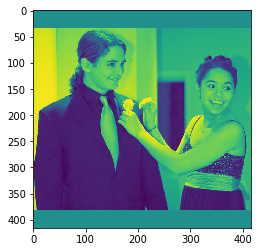

In [62]:
plt.imshow(dataset[108,0,:,:])